In [1]:
import pickle
import numpy as np
import torch
from utils import *
from tqdm.notebook import trange, tqdm
import random
import json
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score, confusion_matrix
import pandas as pd
from classes_synsets import SYNS

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


In [3]:
# Load Test Data

image_embeddings = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/image_embeddings.pt").cpu()
labels = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/labels.pt").cpu()

image_embeddings_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/image_embeddings.pt").cpu()
labels_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/labels.pt").cpu()

image_embeddings_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/image_embeddings.pt").cpu()
labels_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/labels.pt").cpu()


In [4]:
inds = np.array(random.choices(range(50000), k=10000))

small_ie = image_embeddings[inds]
small_labels = labels[inds]
print(small_ie.shape, small_labels.shape)

torch.Size([10000, 1024]) torch.Size([10000])


In [5]:
# Load Model

clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

In [6]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import torch.nn as nn
from clip import clip
import os
import torch


# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

In [7]:
all_labels_text = {}
text_embs = []
text_labels = []
with torch.no_grad():
    for label in tqdm(range(1000)):
        all_labels_text[label] = []

        templates = ["a photo of a {}."]
        c = np.array(CLASSES)[label]
            
        texts = clip.tokenize([template.format(c) for template in templates]) 
        texts = texts.cuda()
        zeroshot_weights = clip_model.encode_text(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )
        all_labels_text[label].append(zeroshot_weights)
        text_embs.append(zeroshot_weights)
        for i in range(len(templates)):
            text_labels.append(label)
        
text_embs = torch.cat(text_embs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
text_embs.shape

torch.Size([1000, 1024])

In [9]:
# Class frequencies

freqs = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/class_frequencies.json"))
freqs = {int(k):v for k,v in freqs.items()}

In [10]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [11]:
many_labels = []
many_embs = []
many_inds = []
med_labels = []
med_embs = []
med_inds = []
few_labels = []
few_embs = []
few_inds = []

for i in tqdm(range(image_embeddings.shape[0])):
    if freqs[labels[i].item()] >= 100:
        many_labels.append(labels[i])
        many_embs.append(image_embeddings[i, :])
        many_inds.append(i)
    elif freqs[labels[i].item()] >= 20:
        med_labels.append(labels[i])
        med_embs.append(image_embeddings[i, :])
        med_inds.append(i)
    else:
        few_labels.append(labels[i])
        few_embs.append(image_embeddings[i, :])
        few_inds.append(i)
        
many_embs = torch.stack(many_embs)
med_embs = torch.stack(med_embs)
few_embs = torch.stack(few_embs)

many_inds = np.array(many_inds)
med_inds = np.array(med_inds)
few_inds = np.array(few_inds)


  0%|          | 0/50000 [00:00<?, ?it/s]

In [12]:
fg_buckets = [5, 10, 15, 20, 30, 40, 60, 100, 160, 10000]

fg_indices_val = {k: [] for k in fg_buckets}

seen = set()

for i in tqdm(range(image_embeddings_val.shape[0])):
    for k in fg_buckets:
        if freqs[labels_val[i].item()] <= k and i not in seen:
            seen.add(i)
            fg_indices_val[k].append(i)
print(len([i for k in fg_indices_val for i in fg_indices_val[k]]))
[len(fg_indices_val[k]) for k in fg_indices_val]

  0%|          | 0/20000 [00:00<?, ?it/s]

20000


[100, 1040, 880, 900, 1580, 1680, 2560, 3560, 3340, 4360]

In [13]:


fg_indices = {k: [] for k in fg_buckets}

seen = set()

for i in tqdm(range(image_embeddings.shape[0])):
    for k in fg_buckets:
        if freqs[labels[i].item()] <= k and i not in seen:
            seen.add(i)
            fg_indices[k].append(i)
print(len([i for k in fg_indices for i in fg_indices[k]]))
[len(fg_indices[k]) for k in fg_indices]

  0%|          | 0/50000 [00:00<?, ?it/s]

50000


[250, 2600, 2200, 2250, 3950, 4200, 6400, 8900, 8350, 10900]

In [14]:
def bucket_indices(l):
    seen = set()
    out = []
    for i in tqdm(range(len(l))):
        for k,kk in enumerate(fg_buckets):
            if freqs[l[i].item()] <= kk and i not in seen:
                seen.add(i)
                out.append(k)
    return out

In [15]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)

In [16]:
def all_accs(model):
    preds = model.predict(image_embeddings)
    l = labels.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds], many_labels)
    med = mic_acc_cal(preds[med_inds], med_labels)
    few = mic_acc_cal(preds[few_inds], few_labels)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [17]:
def all_accs_p(preds):
    l = labels.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds], many_labels)
    med = mic_acc_cal(preds[med_inds], med_labels)
    few = mic_acc_cal(preds[few_inds], few_labels)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [18]:
def all_accs_fg(preds, ls, fg_indices):
    avg_acc = mic_acc_cal(preds, ls)
    out_accs = [avg_acc]
    for k in fg_indices:
        indices = np.array(fg_indices[k])
        acc = mic_acc_cal(preds[indices], ls[indices])
        out_accs.append(acc)
    print([f"{k:.5f}" for k in out_accs])
    return out_accs

In [19]:
conv_comb_0_8_clf = pickle.load(open("results_sklearn/config_convex_comb_1/class_balanced/13-Sep-2022-13-41-17/final_model.sav", 'rb'))

# text_only_balanced_clf = pickle.load(open("results_sklearn/config_text_only_0/29-Sep-2022-01-32-28/final_model.sav", 'rb'))
text_only_balanced_clf = pickle.load(open("results_sklearn/config_text_only_liblinear/06-Nov-2022-01-47-08/final_model.sav", 'rb'))
text_only_balanced_cupl = pickle.load(open("results_sklearn/config_text_only_clip_and_cupl_liblinear/07-Nov-2022-12-41-14/final_model.sav", 'rb'))


image_only_clf = pickle.load(open("results_sklearn/config_image_linear_probe_0/class_balanced/13-Sep-2022-01-35-07/final_model.sav", 'rb'))
image_only_clf_2 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/29-Sep-2022-01-38-27/final_model.sav", 'rb'))
image_only_clf_3 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/07-Nov-2022-18-27-46/final_model.sav", 'rb'))
image_only_clf_4 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/11-Nov-2022-16-23-33/final_model.sav", 'rb'))

image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_oversampled_auto/class_balanced/07-Nov-2022-20-13-26/final_model.sav", 'rb'))
# image_only_clf_oversampled_500 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/11-Nov-2022-16-23-33/final_model.sav", 'rb'))

image_only_clf_undersampled_500 = pickle.load(open("results_sklearn/config_image_linear_probe_undersampled_0-5/12-Nov-2022-12-17-52/final_model.sav", 'rb'))
image_only_clf_undersampled = pickle.load(open("results_sklearn/config_image_linear_probe_undersampled_auto/class_balanced/07-Nov-2022-20-18-24/final_model.sav", 'rb'))

image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_0/c_10/13-Nov-2022-20-07-26/final_model.sav", 'rb'))
image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_nojitter/01-Dec-2022-22-31-07/final_model.sav", 'rb'))





### Predict mixing coefficients at eval time

In [20]:
from data_loader import dataloaders as dataloader

In [23]:
d = dataloader.load_data(
    data_root="./datasets/ImageNet/",
    dataset="ImageNet_LT",
    phase="test",
    batch_size=1000,
    sampler_dic=None,
    num_workers=10,
    type="LT_Dataset",
    prompt_set="Imagenet",
)
dataset_test = d[0]

Loading data from /nethome/bdevnani3/flash1/long_tail_lang/data/ImageNet_LT/ImageNet_LT_test.txt
Use data transformation: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
***********************DATASET: test LT_Dataset
test 50000
No sampler.
Shuffle is True.


In [24]:
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

BICUBIC = InterpolationMode.BICUBIC
t1 = T.RandomResizedCrop(size=224, scale=(0.5, 1), interpolation=BICUBIC)
t2 = T.RandomHorizontalFlip(p=1)
t3 = T.RandomGrayscale(p=1)
t4 = T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0)

In [25]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [244]:
l = 0

cropped_ims = []
cropped_im_labels = []
cropped_im_ind_labels = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
for im, label, _, path in tqdm(dataset_test):
    for k in range(len(im)):
        cropped_ims = []
        cropped_im_labels = []
        if label[k].item() == l:
            print(f"Found {l}")
            curr_im = im[k]
            cropped_ims.append(curr_im)
            cropped_im_labels.append(label[k].item())
            cropped_ims.append(t1(curr_im))
            cropped_im_labels.append(label[k].item())
            cropped_ims.append(t2(curr_im))
            cropped_im_labels.append(label[k].item())
            cropped_ims.append(t3(curr_im))
            cropped_im_labels.append(label[k].item())
            cropped_ims.append(t4(curr_im))
            cropped_im_labels.append(label[k].item())
#             for j in range(10):
#                 t = t1(curr_im)
#                 cropped_ims.append(t)
#                 cropped_im_labels.append(label[k].item())
            cropped_ims = torch.stack(cropped_ims)
            with torch.no_grad():
                x = visual_model(cropped_ims.half()).float()
                x = x / x.norm(dim=-1, keepdim=True)
            final_pred = []
            best_agreement = 0
            default_pred = 0
            all_coef_preds = []
            all_coef_pred_probas = []
            for ii in range(0, 21):
                i = ii/20.0
                mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
                mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
                probas = mixed_clf.predict_proba(x.cpu().detach().numpy())
                preds = mixed_clf.predict(x.cpu().detach().numpy())
                all_coef_preds.append(preds)
                all_coef_pred_probas.append(np.var(probas))
                if i == 0.65:
                    default_pred = preds[0]
                mode = preds[0]
                agreement = preds == mode
#                 agreement = agreement
                agreement = np.sum(agreement)
                if agreement > best_agreement:
                    final_pred = [ii]
                    best_agreement = agreement
                if agreement == best_agreement:
                    final_pred.append(ii)
                    best_agreement = agreement
            if len(final_pred) == 1:
                final_pred = all_coef_preds[final_pred[0]][0]
            else:
                pred_ii = int(np.mean(final_pred))
                final_pred = all_coef_preds[pred_ii][0]
            print(freqs[label[k].item()], default_pred, final_pred, best_agreement)
            print(CLASSES[default_pred], CLASSES[final_pred], best_agreement)
            if final_pred == label[k].item():
                total_acc[label[k].item()] +=1
                if default_pred != label[k].item():
                    print("*********")
                    print(all_coef_preds)
            elif default_pred == label[k].item():
                print(all_coef_preds)
            if default_pred != label[k].item():
                print("xxxxxxxx")
                print(all_coef_preds)
#                 print(np.round(all_coef_pred_probas,6))
                

print(cwa[l], total_acc[l]*2)

  0%|          | 0/50 [00:00<?, ?it/s]

Found 513
75 875 875 11
trombone trombone 11
xxxxxxxx
[array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 513, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 513, 875, 87

75 862 684 6
torch ocarina 6
xxxxxxxx
[array([862, 862, 875, 862, 862, 678, 699, 678, 678, 875, 678]), array([862, 862, 875, 862, 862, 678, 699, 678, 678, 875, 678]), array([862, 862, 875, 862, 862, 678, 699, 678, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 862, 678, 875, 678]), array([862, 862, 875, 862, 875, 699, 699, 862, 862, 875, 678]), array([862, 875, 875, 862, 875, 699, 699, 862, 862, 875, 678]), array([862, 875, 875, 862, 875, 699, 699, 862, 862, 875, 678]), array([862, 875, 875, 862, 875, 699, 699, 862, 862, 875, 699]), a

75 513 513 11
cornet cornet 11
Found 513
75 439 513 11
military hat (bearskin or shako) cornet 11
*********
[array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 43

75 513 875 11
cornet trombone 11
[array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([513, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([513, 875, 875, 875, 875, 875, 513, 875, 875, 875, 875]), array([513, 875, 513, 875, 875, 875, 513, 875, 875, 875, 875]), array([513, 513, 513, 875, 875, 875, 513, 875, 875, 875, 513]), array([513, 513, 513, 875, 513, 513, 513, 875, 875, 513, 513]), array([513, 513, 513, 875, 513, 513, 513, 875, 513, 513, 513]), array(

75 439 439 11
military hat (bearskin or shako) military hat (bearskin or shako) 11
xxxxxxxx
[array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 652, 439, 652, 439, 439, 439, 439, 439, 439, 439]), array([439, 652, 439, 652, 439, 439, 439, 439, 439, 439, 439]), array([439, 652, 652, 652, 439, 439, 439, 439, 439, 439, 439]), array([439, 652, 652, 652, 439, 439, 439, 652, 439, 439, 439]), array([439,

75 513 875 9
cornet trombone 9
[array([875, 875, 875, 875, 875, 875, 566, 566, 875, 875, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 875, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 875, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([513, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([513, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([513, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([513, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([5

In [201]:
# Generate training text and image average prototypes

# image 

image_prototypes = np.zeros((1000, 1024))
c = np.zeros(1000)

for i,l in tqdm(enumerate(labels_train)):
    image_prototypes[l,:] =  image_prototypes[l,:] + image_embeddings_train[i,:].numpy()
    c[l] +=1
    
for i in range(1000):
    image_prototypes[i,:] /= c[i]
image_prototypes.shape

0it [00:00, ?it/s]

(1000, 1024)

In [202]:
text_embs.shape

torch.Size([1000, 1024])

In [232]:
import scipy
scipy.special.softmax([0.19264835, 0.23104969, 0.24819319, 0.25063   ])

array([0.24061828, 0.25003806, 0.25436154, 0.25498212])

In [233]:
scipy.special.softmax([0.82806292, 0.8853344 , 0.89792031, 0.9042871 ])

array([0.23750132, 0.25150042, 0.25468578, 0.25631249])

In [240]:
np.where(cwa < .50)

(array([  7,  32,  35,  36,  41,  46,  54,  55,  58,  59,  60,  62,  65,
         66,  68,  73, 110, 120, 124, 125, 151, 152, 155, 158, 163, 165,
        166, 167, 170, 171, 175, 180, 184, 187, 189, 192, 193, 196, 197,
        199, 200, 202, 204, 210, 211, 212, 217, 223, 226, 229, 231, 233,
        234, 235, 236, 237, 238, 241, 246, 248, 256, 257, 265, 266, 267,
        269, 271, 272, 277, 282, 302, 303, 312, 328, 345, 349, 356, 358,
        360, 374, 380, 381, 384, 385, 389, 409, 431, 434, 436, 438, 445,
        446, 455, 459, 461, 463, 469, 479, 482, 488, 489, 491, 493, 494,
        499, 501, 504, 505, 507, 513, 516, 523, 527, 538, 541, 542, 544,
        556, 558, 567, 572, 579, 584, 587, 590, 596, 600, 606, 615, 618,
        620, 623, 632, 633, 638, 648, 650, 651, 653, 656, 657, 664, 670,
        673, 676, 677, 680, 681, 689, 691, 696, 700, 702, 705, 708, 710,
        718, 725, 726, 728, 729, 730, 731, 733, 735, 740, 741, 742, 744,
        747, 748, 749, 750, 759, 764, 767, 771, 772

In [237]:
cwa[155]

0.0

Zero Shot K

In [248]:
import sklearn 
pairwise_cs_train = sklearn.metrics.pairwise.cosine_similarity(image_embeddings_train.cpu(), text_embs.cpu())

In [249]:
pairwise_cs_val = sklearn.metrics.pairwise.cosine_similarity(image_embeddings_val.cpu(), text_embs.cpu())

In [250]:
def top_k_acc(pairwise_cs, k, labels):
    indices = (-torch.tensor(pairwise_cs).softmax(dim=-1).numpy()).argsort(axis=-1)[:, :k]
    acc = 0
    for i in range(indices.shape[0]):
        if labels[i].item() in indices[i]:
            acc +=1.0
    acc/= indices.shape[0]
    return acc
top_k_acc(pairwise_cs_val, 1, labels_val)

0.5874

In [393]:
lams_val = np.zeros(1000)
indices = (-torch.tensor(pairwise_cs_val).softmax(dim=-1).numpy()).argsort(axis=-1)[:, :1]
for i in range(indices.shape[0]):
    if labels_val[i].item() in indices[i]:
        lams_val[labels_val[i].item()] +=1

In [395]:
inv_lams_val= (1- lams_val/20)*0.75
inv_lams_val = (lams_val<11) *0.75
inv_lams_val

array([0.  , 0.  , 0.75, 0.  , 0.75, 0.75, 0.75, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.75, 0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.75, 0.  , 0.75, 0.  , 0.  , 0.75, 0.  , 0.  ,
       0.  , 0.  , 0.75, 0.75, 0.  , 0.  , 0.  , 0.  , 0.75, 0.75, 0.75,
       0.75, 0.  , 0.  , 0.  , 0.75, 0.75, 0.  , 0.75, 0.75, 0.  , 0.75,
       0.75, 0.75, 0.75, 0.  , 0.  , 0.  , 0.75, 0.75, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.75, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.75, 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.75, 0.75, 0.75, 0.75, 0.  , 0.  , 0.  , 0.  , 0.75, 0.  ,
       0.75, 0.75, 0.  , 0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [406]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
i = 1
mixed_clf.coef_ = i*t_norm + (1-i)*i_norm
mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_/text_only_balanced_clf.intercept_.max() 
+ (1-i)*image_only_clf_oversampled.intercept_/image_only_clf_oversampled.intercept_.max()
preds = mixed_clf.predict(image_embeddings)
temp_acc = all_accs_fg(preds, labels.numpy(), fg_indices)
all_accs_val.append(temp_acc)

['0.45370', '0.51200', '0.46115', '0.38591', '0.47511', '0.41215', '0.44190', '0.41109', '0.43438', '0.47784', '0.50174']


In [405]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
i = 1
mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_
+ (1-i)*image_only_clf_oversampled.intercept_
preds = mixed_clf.predict(image_embeddings)
temp_acc = all_accs_fg(preds, labels.numpy(), fg_indices)
all_accs_val.append(temp_acc)

['0.54418', '0.33600', '0.50962', '0.50727', '0.54089', '0.53620', '0.56143', '0.54078', '0.53225', '0.55186', '0.56743']


In [398]:
t_norm = text_only_balanced_clf.coef_/text_only_balanced_clf.coef_.max(axis=0)
i_norm = image_only_clf_oversampled.coef_/image_only_clf_oversampled.coef_.max(axis=0)

In [383]:
mixed_clf.coef_

492.3570421989682

In [384]:
np.linalg.norm(image_only_clf_oversampled.coef_)

1073.2520928872243

In [385]:
np.linalg.norm(t_norm)

94.34817983660311

In [386]:
np.linalg.norm(i_norm)

108.45128097811237

In [380]:
text_only_balanced_clf.coef_.shape

(1000, 1024)

In [21]:
image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_0/c_10/13-Nov-2022-20-07-26/final_model.sav", 'rb'))

In [25]:
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

BICUBIC = InterpolationMode.BICUBIC
rc = T.RandomResizedCrop(size=224, scale=(0.8, 1), interpolation=BICUBIC)
rg = T.RandomGrayscale()
cj = T.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0)
# t4 = T.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2))
gb = T.GaussianBlur(kernel_size=(5, 5), sigma=(2))
# t4 = T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2))

In [29]:
from scipy import spatial

l = 2

cropped_ims = []
cropped_im_labels = []
cropped_im_ind_labels = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
for im, label, _, path in tqdm(dataset_test):
    for k in range(len(im)):
        cropped_ims = []
        cropped_im_labels = []
        if label[k].item() == l:
            print(f"Found {l} - freq {freqs[l]}")
            curr_im = im[k]
            cropped_ims.append(curr_im)
            cropped_im_labels.append(label[k].item())
#             cropped_ims.append(t1(curr_im))
#             cropped_im_labels.append(label[k].item())
            cropped_ims.append(rg(curr_im))
            cropped_im_labels.append(label[k].item())
#             cropped_ims.append(t2(curr_im))
#             cropped_im_labels.append(label[k].item())
            cropped_ims.append(cj(curr_im))
            cropped_im_labels.append(label[k].item())
#             cropped_ims.append(t4(curr_im))
#             cropped_im_labels.append(label[k].item())
            cropped_ims.append(gb(curr_im))
            cropped_im_labels.append(label[k].item())
            cropped_ims = torch.stack(cropped_ims)
            with torch.no_grad():
                x = visual_model(cropped_ims.half()).float()
                x = x / x.norm(dim=-1, keepdim=True)
            final_pred = []
            best_agreement = 0
            default_pred = 0
            all_coef_preds = []
            all_coef_pred_probas = []
            all_agreements = []
            best_mixer = 0
            for ii in range(0, 21):
                i = ii/20.0
                mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
                mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
                probas = mixed_clf.predict_proba(x.cpu().detach().numpy())
                preds = mixed_clf.predict(x.cpu().detach().numpy())
                all_coef_preds.append(preds)
                all_coef_pred_probas.append(np.var(probas))
                agreement = 0
                if i == 0.65:
                    default_pred = preds[0]
                for n in range(1,len(cropped_im_labels)):
                    agreement+= 1 - spatial.distance.cosine(probas[0], probas[n])
                agreement /= (len(cropped_im_labels)-1)
                all_agreements.append(agreement)
                if agreement > best_agreement and ii >0 and ii < 20:
                    final_pred = [ii]
                    best_agreement = agreement
                    best_mixer = i
            final_pred = all_coef_preds[final_pred[0]][0]
            print(default_pred, final_pred, best_agreement, best_mixer)
            print(CLASSES[default_pred], CLASSES[final_pred])
            if final_pred == label[k].item():
                total_acc[label[k].item()] +=1
                if default_pred != label[k].item():
                    print("*********")
                    print(all_coef_preds)
                    print(all_agreements)
            elif default_pred == label[k].item():
                if final_pred != label[k].item():
                    print("xxxxxxxx")
                    print(all_coef_preds)
                    print(all_agreements)
#             if default_pred != label[k].item():
#                 print("xxxxxxxx")
#                 print(all_coef_preds)
#                 print(np.round(all_coef_pred_probas,6))
                

print(cwa[l], total_acc[l]*2)

  0%|          | 0/50 [00:00<?, ?it/s]

Found 2 - freq 516
2 2 0.9502709503365389 0.05
great white shark great white shark
Found 2 - freq 516
2 2 0.8856829849710576 0.95
great white shark great white shark
Found 2 - freq 516
921 921 0.9423902656332848 0.95
dust jacket dust jacket
Found 2 - freq 516
2 2 0.86227508554837 0.95
great white shark great white shark
Found 2 - freq 516
2 2 0.7802713484927523 0.95
great white shark great white shark
Found 2 - freq 516
148 148 0.9289819907710446 0.95
killer whale killer whale
Found 2 - freq 516
3 3 0.9271258767774206 0.95
tiger shark tiger shark
Found 2 - freq 516
3 3 0.8477640238278562 0.95
tiger shark tiger shark
Found 2 - freq 516
3 3 0.9520554633667632 0.7
tiger shark tiger shark
Found 2 - freq 516
2 3 0.9049691776641001 0.95
great white shark tiger shark
xxxxxxxx
[array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2,

NameError: name 'cwa' is not defined

In [178]:
# Image Embeddings
# og_proba = image_only_clf_oversampled.predict_proba(image_embeddings)
# og_preds = image_only_clf_oversampled.predict(image_embeddings)
# all_accs_p(og_preds)

# og_text_proba = text_only_balanced_clf.predict_proba(image_embeddings)
# og_text_preds = text_only_balanced_clf.predict(image_embeddings)
# all_accs_p(og_text_preds)

In [179]:
def pw_cosine_sim(a,b):
    """a and b are the same dimensions"""
    
    sim = 0
    for i in range(a.shape[0]):
        sim+= 1 - spatial.distance.cosine(a[i], b[i])
        
    sim /= a.shape[0]
    return sim

In [180]:
def vis_enc(im):
    x = visual_model(im.half()).float()
    x = x / x.norm(dim=-1, keepdim=True)
    return x

In [182]:
# Find augmentations for which entropy of text and image classifiers are similar
import importlib
from data_loader import dataloaders as dataloader
importlib.reload(dataloader)
d = dataloader.load_data(
    data_root="./datasets/ImageNet/",
    dataset="ImageNet_LT",
    phase="test",
    batch_size=1000,
    sampler_dic=None,
    num_workers=10,
    type="LT_Dataset_transform_mix",
    prompt_set="Imagenet",
#     override_transform = [T.RandomGrayscale(p=0.5)]
)

dataset_test = d[0]

all_og = []
all_0 = []
all_1 = []
all_2 = []
all_3 = []
all_4 = []
ls = []
for im_cj, im_hf, im_rc, im_gb, im_gs, im_og, label, _, _ in tqdm(dataset_test):
    with torch.no_grad():
        all_0.append(vis_enc(im_cj))
        all_1.append(vis_enc(im_hf))
        all_2.append(vis_enc(im_rc))
        all_3.append(vis_enc(im_gb))
        all_4.append(vis_enc(im_gs))
        all_og.append(vis_enc(im_og))
        ls.append(label)
        
all_0 = torch.cat(all_0,0).cpu().numpy()
all_1 = torch.cat(all_1,0).cpu().numpy()
all_2 = torch.cat(all_2,0).cpu().numpy()
all_3 = torch.cat(all_3,0).cpu().numpy()
all_4 = torch.cat(all_4,0).cpu().numpy()
all_og = torch.cat(all_og,0).cpu().numpy()
ls = torch.cat(ls,0).cpu().numpy()

print(ls.shape)

Loading data from /nethome/bdevnani3/flash1/long_tail_lang/data/ImageNet_LT/ImageNet_LT_test.txt
Use data transformation: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
***********************DATASET: test LT_Dataset_transform_mix
test 50000
No sampler.
Shuffle is True.


  0%|          | 0/50 [00:00<?, ?it/s]

(50000,)


In [183]:
conv_comb_0_8_clf = pickle.load(open("results_sklearn/config_convex_comb_1/class_balanced/13-Sep-2022-13-41-17/final_model.sav", 'rb'))


In [185]:
cossim_jitter = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_0])
    proba = mixed_clf.predict_proba(x)
    t1, t2 = proba[0:50000], proba[50000:]
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_jitter.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()
# print(all_cossims)

0
[0.9120249210986678, 0.1444415331150494]

1
[0.9147627544825738, 0.1396025729738412]

2
[0.9175505393208859, 0.13466818036015873]

3
[0.9203867743136113, 0.12964035188915465]

4
[0.9232695461566974, 0.1245214738746434]

5
[0.9261965752012316, 0.11931423966467254]

6
[0.9291653358438202, 0.11402151095894585]

7
[0.9321732924035578, 0.10864605978786832]

8
[0.9352183018318715, 0.10319008738514551]

9
[0.9382992508164775, 0.09765438979568554]

10
[0.9414170403094902, 0.0920369310289937]

11
[0.9445761282171464, 0.08633016807265782]

12
[0.9477869131688155, 0.08051605245324939]

13
[0.9510690440652056, 0.07455852304677056]

14
[0.9544549736657315, 0.06839575197944762]

15
[0.9579914764733234, 0.061937648271744535]

16
[0.9617341965513048, 0.05507997391162565]

17
[0.9657258872428491, 0.04775246568115234]

18
[0.969943670334706, 0.04001306429221177]

19
[0.9742102929883583, 0.032175849945919356]

20
[0.9781217300741427, 0.02489754191535676]



In [186]:
cossim_gray = []
all_cossims_text = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_2])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_gray.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()

0
[0.8061965345890089, 0.23107796533768096]

1
[0.8114739666439257, 0.22445749881321386]

2
[0.816925034599369, 0.2175959781862778]

3
[0.822553012270692, 0.21049003224304022]

4
[0.8283607035243439, 0.20313749693125588]

5
[0.8343505543102634, 0.19553717645629512]

6
[0.840524901190455, 0.18768845376477503]

7
[0.8468864221421295, 0.1795907604389707]

8
[0.8534389151709725, 0.17124276767737642]

9
[0.8601886451823441, 0.16264089841520735]

10
[0.8671466707348497, 0.1537764663260009]

11
[0.8743327265768708, 0.1446305520138562]

12
[0.881781201947642, 0.13516579045606877]

13
[0.889549235472823, 0.12531483254986228]

14
[0.8977255919100292, 0.11496650085008736]

15
[0.9064352583365075, 0.10395357112682282]

16
[0.9158243648529673, 0.09205845112123731]

17
[0.9259906903476189, 0.07908427621514857]

18
[0.9368134497942687, 0.06506236950918604]

19
[0.9476949866668384, 0.05060025804541709]

20
[0.9574308096566677, 0.03712124125347095]



In [187]:
cossim_crop_easy = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_1])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_crop_easy.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()

0
[0.985789718348282, 0.03935131310688604]

1
[0.9863692228271009, 0.037328426071282166]

2
[0.9869506859886971, 0.035309332852571554]

3
[0.9875331757100064, 0.03329858620322382]

4
[0.9881155935687128, 0.03130139531760007]

5
[0.98869666799503, 0.02932353588398005]

6
[0.9892749728076751, 0.02737105693907994]

7
[0.9898489695983994, 0.025449877701389748]

8
[0.9904170622680168, 0.023565536202339574]

9
[0.9909776556836535, 0.021723340943154538]

10
[0.9915292348467412, 0.019928826515270108]

11
[0.9920705103212476, 0.018187920422621035]

12
[0.9926006776027035, 0.01650621091576028]

13
[0.9931197878849808, 0.01488757098756948]

14
[0.993629137118553, 0.013333349578697038]

15
[0.9941315217244433, 0.011842874096529416]

16
[0.9946310859979517, 0.010414996409361724]

17
[0.9951320179812849, 0.009052452298842264]

18
[0.9956345036702903, 0.007771541406951758]

19
[0.9961259629706962, 0.006612381602912682]

20
[0.9965698237112397, 0.005634056808647798]



In [188]:
cossim_crop_med = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_3])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_crop_med.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()

0
[0.8656811339490187, 0.17633002586367016]

1
[0.8698085808442237, 0.1700307434194142]

2
[0.8740259942251191, 0.16358242307163523]

3
[0.8783305469736928, 0.15698984933398183]

4
[0.8827184007722634, 0.15025937226357006]

5
[0.8871847082349358, 0.1433990459899035]

6
[0.8917237247859721, 0.13641871562326705]

7
[0.8963290970203819, 0.12932991986438686]

8
[0.900994422690329, 0.12214540850700098]

9
[0.9057142105587912, 0.11487794629371197]

10
[0.9104854072709012, 0.10753791259944889]

11
[0.9153097001305763, 0.10012934234777934]

12
[0.9201968867546688, 0.0926450160654624]

13
[0.9251697729907037, 0.08506263439145746]

14
[0.9302710579293639, 0.07734389814829347]

15
[0.9355709635664355, 0.06943617152885737]

16
[0.9411677807005641, 0.06127924800871936]

17
[0.9471606061521383, 0.052836833410513186]

18
[0.9535621963067913, 0.044188080193384875]

19
[0.960141038214849, 0.03566011921479998]

20
[0.9662811986608767, 0.027871994205282004]



In [189]:
cossim_crop_hard = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_4, all_3])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_crop_hard.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()

0
[0.9008365980911565, 0.1462511027833717]

1
[0.9037482336824959, 0.14118239016449952]

2
[0.9067186455237055, 0.135997879228482]

3
[0.9097478665812352, 0.1306960583876205]

4
[0.912835892243501, 0.12527572098810855]

5
[0.9159827856875413, 0.11973601550094015]

6
[0.9191888827632944, 0.11407631571574603]

7
[0.9224551363542824, 0.10829586667332554]

8
[0.9257836261462424, 0.1023932963108749]

9
[0.9291782780894511, 0.09636604965944742]

10
[0.9326459049695018, 0.0902095592033324]

11
[0.9361977287057465, 0.08391598679024108]

12
[0.9398515136284756, 0.07747311570024118]

13
[0.943634295338953, 0.07086454672192227]

14
[0.9475850580429244, 0.06407130391554261]

15
[0.9517545155098016, 0.05707442972594837]

16
[0.9561947606895955, 0.0498688940930231]

17
[0.9609276833081414, 0.04251248073635415]

18
[0.9658840338727627, 0.03520228473177344]

19
[0.9708319259733972, 0.028317655544138176]

20
[0.9753625935096983, 0.022345289531314847]



In [443]:
from scipy import spatial

l = 2

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

inds = np.random.randint(0, 50000, size=5000)

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
following = [0,0,0,0]
for z in tqdm(range(50000)):
    if ls[z] == l:
        final_pred = []
        best_agreement = -np.inf
        default_pred = 0
        all_coef_preds = []
        all_coef_pred_probas = []
        all_agreements = []
        best_mixer = 0
        x = np.vstack([all_0[z], all_1[z], all_2[z], all_3[z], all_4[z], all_og[z]])
        best_acc_temp = 0
        for ii in range(0, 21):
            i = ii/20.0
            mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
            mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
            probas = mixed_clf.predict_proba(x)
            preds = mixed_clf.predict(x)
            all_coef_preds.append(preds)
            all_coef_pred_probas.append(probas)
            agreement = 0
            if i == 0.65:
                default_pred = preds[0]
            agreement1 = 1 - spatial.distance.cosine(probas[5], probas[0])
            mu, sig = cossim_jitter[ii]
            agreement1 = (agreement1- mu)/sig

            agreement2 = 1 - spatial.distance.cosine(probas[5], probas[2])
            mu, sig = cossim_gray[ii]
            agreement2 = 0

            agreement3 = 1 - spatial.distance.cosine(probas[5], probas[1])
            mu, sig = cossim_crop_easy[ii]
            agreement3 = (agreement3- mu)/sig

            agreement4 = 1 - spatial.distance.cosine(probas[5], probas[3])
            mu, sig = cossim_crop_med[ii]
            agreement4 = (agreement4- mu)/sig

            agreement5 = 1 - spatial.distance.cosine(probas[4], probas[3])
            mu, sig = cossim_crop_hard[ii]
            agreement5 = (agreement5- mu)/sig


            agreement = agreement1+ agreement2+agreement3+agreement4+agreement5
            all_agreements.append(agreement)
            if agreement > best_agreement and ii < 19 and ii>1:
                final_pred = [ii]
                best_agreement = agreement
                best_mixer = i
            if preds[0] == ls[z]:
                best_acc_temp = 1
                
                
        final_pred = all_coef_preds[final_pred[0]][0]
        best_acc[ls[z]] += best_acc_temp

        print(default_pred, final_pred, best_agreement, best_mixer)
        print(CLASSES[default_pred], CLASSES[final_pred])
        if final_pred == ls[z]:
            total_acc[ls[z]] +=1
            if default_pred != ls[z]:
                print("*********")
                print(all_coef_preds)
                print(all_agreements)

        if default_pred == ls[z]:
            def_acc[ls[z]] +=1
            if final_pred != ls[z]:
                print("xxxxxxxx")
                print(all_coef_preds)
                print(all_agreements)
#         print(all_coef_preds)
#         print(all_agreements)
                print()

#             if z% 100 == 0:
#                 print(np.sum(best_acc), np.sum(def_acc), np.sum(total_acc))
print(l, best_acc[l]*2, def_acc[l]*2, total_acc[l]*2)

  0%|          | 0/50000 [00:00<?, ?it/s]

2 2 2.0509493908541874 0.65
great white shark great white shark
4 4 -1.7390514714331493 0.9
hammerhead shark hammerhead shark
3 3 1.5879290130618475 0.55
tiger shark tiger shark
2 2 2.8594664841142903 0.85
great white shark great white shark
2 2 2.370243083059974 0.15
great white shark great white shark
3 3 2.2553191548003317 0.85
tiger shark tiger shark
2 2 0.9230762061456887 0.2
great white shark great white shark
2 2 2.46461251844049 0.6
great white shark great white shark
2 2 3.133743558226465 0.9
great white shark great white shark
3 3 1.5178042873285718 0.1
tiger shark tiger shark
2 2 2.406834844671962 0.85
great white shark great white shark
2 2 2.1924681110767876 0.1
great white shark great white shark
921 921 -0.1477900462583432 0.9
dust jacket dust jacket
2 2 -1.4187679989496886 0.1
great white shark great white shark
4 4 0.7321289944806749 0.5
hammerhead shark hammerhead shark
3 3 1.8976435821258437 0.5
tiger shark tiger shark
2 2 2.2654685547969913 0.1
great white shark gre

In [30]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [136]:
all_cossims_2[11]

[0.9356174649713584, 0.0850544846023417]

In [390]:
from scipy import spatial

l = 50

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
following = [0,0,0,0]
for z in tqdm(range(50000)):
    if ls[z] == l:
        final_pred = []
        best_agreement = -np.inf
        default_pred = 0
        all_coef_preds = []
        all_coef_pred_probas = []
        all_agreements = []
        best_mixer = 0
        x = np.vstack([all_og[z], all_0[z], all_1[z], all_2[z], all_3[z], all_4[z]])
        best_acc_temp = 0
        for ii in range(0, 21):
            i = ii/20.0
            mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
            mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
            probas = mixed_clf.predict_proba(x)
            preds = mixed_clf.predict(x)
            all_coef_preds.append(preds)
            all_coef_pred_probas.append(probas)
            agreement = 0
            if i == 0.65:
                default_pred = preds[0]
                
            agreement1 = 1 - spatial.distance.cosine(probas[0], probas[1])
            mu, sig = cossim_jitter[ii]
            agreement1 = (agreement1- mu)/sig

            agreement2 = 1 - spatial.distance.cosine(probas[0], probas[3])
            mu, sig = cossim_gray[ii]
            agreement2 = (agreement2- mu)/sig
            
            agreement3 = 1 - spatial.distance.cosine(probas[0], probas[2])
            mu, sig = cossim_crop_easy[ii]
            agreement3 = (agreement3- mu)/sig
            
            agreement4 = 1 - spatial.distance.cosine(probas[0], probas[4])
            mu, sig = cossim_crop_hard[ii]
            agreement4 = (agreement4- mu)/sig
            
            
            agreement = agreement3 + agreement4
            all_agreements.append(agreement)
            if agreement > best_agreement and ii < 19 and ii>1:
                final_pred = [ii]
                best_agreement = agreement
                best_mixer = i
            if preds[0] == ls[z]:
                best_acc_temp = 1
        final_pred = all_coef_preds[final_pred[0]][0]
        best_acc[ls[z]] += best_acc_temp

        print(default_pred, final_pred, best_agreement, best_mixer)
        print(z, CLASSES[default_pred], CLASSES[final_pred])
        if final_pred == ls[z]:
            total_acc[ls[z]] +=1
            if default_pred != ls[z]:
                print("*********")
                print(all_coef_preds)
                print(all_agreements)

        if default_pred == ls[z]:
            def_acc[ls[z]] +=1
            if final_pred != ls[z]:
                print("xxxxxxxx")
                print(all_coef_preds)
                print(all_agreements)
                
print(l, best_acc[l]*2, def_acc[l]*2, total_acc[l]*2)

# print(np.mean(best_acc), np.mean(def_acc), np.mean(total_acc))

  0%|          | 0/50000 [00:00<?, ?it/s]

49 49 0.921673315318503 0.65
337 Nile crocodile Nile crocodile
50 50 1.2773363422670547 0.9
2800 American alligator American alligator
599 599 0.6927599013906722 0.1
2876 honeycomb honeycomb
50 50 0.0738304934534097 0.85
3184 American alligator American alligator
61 61 -0.20935282066493954 0.9
3996 boa constrictor boa constrictor
49 49 0.9733303053118876 0.35
5776 Nile crocodile Nile crocodile
50 50 0.7837645600718144 0.9
8104 American alligator American alligator
50 50 1.0559403253416733 0.9
8203 American alligator American alligator
48 48 -1.4096407017691732 0.9
8303 Komodo dragon Komodo dragon
63 49 0.9112363615377932 0.9
8402 Indian cobra Nile crocodile
50 50 1.04325041745516 0.65
8656 American alligator American alligator
50 50 0.8374667404312619 0.1
9415 American alligator American alligator
50 50 -3.9032426710443366 0.1
12731 American alligator American alligator
50 50 -7.073259884766241 0.1
13293 American alligator American alligator
147 147 0.9926537641557207 0.1
13596 grey wh

In [458]:
from scipy import spatial

l = 337

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
following = np.array([0.,0.,0.,0.])
checking_corr_jitter = []
checking_corr_gray = []
checking_corr_crop_easy = []
checking_corr_crop_med = []
checking_corr_crop_hard = []
inds = np.random.randint(0, 50000, size=5000)
for l in range(1000):
#     if freqs[l] > 20:
#         continue
    l_count = 0
    for z in tqdm(inds):
        if ls[z] == l:
            l_count +=1
            final_pred = []
            best_agreement = -np.inf
            default_pred = 0
            all_coef_preds = []
            all_coef_pred_probas = []
            all_agreements = []
            best_mixer = 0
            x = np.vstack([all_og[z], all_0[z], all_1[z], all_2[z], all_3[z], all_4[z]])
            best_acc_temp = 0
            og_proba = []
            for ii in range(0, 21):
                i = ii/20.0
                mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
                mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
                probas = mixed_clf.predict_proba(x)
                preds = mixed_clf.predict(x)
                all_coef_preds.append(preds)
                all_coef_pred_probas.append(probas)
                agreement = 0
                if i == 0.65:
                    default_pred = preds[0]

                agreement1 = 1 - spatial.distance.cosine(probas[0], probas[1])
                mu, sig = cossim_jitter[ii]
                agreement1 = (agreement1- mu)/sig

                agreement2 = 1 - spatial.distance.cosine(probas[0], probas[3])
                mu, sig = cossim_gray[ii]
                agreement2 = (agreement2- mu)/sig

                agreement3 = 1 - spatial.distance.cosine(probas[0], probas[2])
                mu, sig = cossim_crop_easy[ii]
                agreement3 = (agreement3- mu)/sig
            
                agreement4 = 1 - spatial.distance.cosine(probas[0], probas[4])
                mu, sig = cossim_crop_med[ii]
                agreement4 = (agreement4- mu)/sig
                
                agreement5 = 1 - spatial.distance.cosine(probas[5], probas[4])
                mu, sig = cossim_crop_hard[ii]
                agreement5 = (agreement5- mu)/sig


                agreement = agreement1+ agreement2+agreement3+agreement4+agreement5
                all_agreements.append(agreement)
                if agreement > best_agreement and ii < 19 and ii>1:
                    final_pred = [ii]
                    best_agreement = agreement
                    best_mixer = i
                if preds[0] == ls[z]:
                    best_acc_temp = 1
                    checking_corr_jitter.append([z, agreement1, i])
                    checking_corr_gray.append([z, agreement2, i])
                    checking_corr_crop_easy.append([z, agreement3, i])
                    checking_corr_crop_med.append([z, agreement4, i])
                    checking_corr_crop_hard.append([z, agreement5, i])
            final_pred = all_coef_preds[final_pred[0]][0]
            best_acc[ls[z]] += best_acc_temp

            if final_pred == ls[z]:
                total_acc[ls[z]] +=1

            if default_pred == ls[z]:
                def_acc[ls[z]] +=1
    stats = np.array([l_count, best_acc[l], def_acc[l], total_acc[l]])
    print(l, freqs[l], stats)
    following += stats
    print(following)
    print(following*100/following[0])

  0%|          | 0/5000 [00:00<?, ?it/s]

0 50 [2. 2. 2. 2.]
[2. 2. 2. 2.]
[100. 100. 100. 100.]


  0%|          | 0/5000 [00:00<?, ?it/s]

1 250 [5. 5. 5. 5.]
[7. 7. 7. 7.]
[100. 100. 100. 100.]


  0%|          | 0/5000 [00:00<?, ?it/s]

2 516 [2. 1. 1. 1.]
[9. 8. 8. 8.]
[100.          88.88888889  88.88888889  88.88888889]


  0%|          | 0/5000 [00:00<?, ?it/s]

3 352 [11.  8.  8.  8.]
[20. 16. 16. 16.]
[100.  80.  80.  80.]


  0%|          | 0/5000 [00:00<?, ?it/s]

4 143 [5. 4. 4. 4.]
[25. 20. 20. 20.]
[100.  80.  80.  80.]


  0%|          | 0/5000 [00:00<?, ?it/s]

5 92 [2. 2. 2. 2.]
[27. 22. 22. 22.]
[100.          81.48148148  81.48148148  81.48148148]


  0%|          | 0/5000 [00:00<?, ?it/s]

6 47 [6. 4. 4. 4.]
[33. 26. 26. 26.]
[100.          78.78787879  78.78787879  78.78787879]


  0%|          | 0/5000 [00:00<?, ?it/s]

7 45 [3. 2. 2. 2.]
[36. 28. 28. 28.]
[100.          77.77777778  77.77777778  77.77777778]


  0%|          | 0/5000 [00:00<?, ?it/s]

8 150 [10. 10. 10. 10.]
[46. 38. 38. 38.]
[100.          82.60869565  82.60869565  82.60869565]


  0%|          | 0/5000 [00:00<?, ?it/s]

9 50 [4. 3. 3. 3.]
[50. 41. 41. 41.]
[100.  82.  82.  82.]


  0%|          | 0/5000 [00:00<?, ?it/s]

10 34 [1. 1. 1. 1.]
[51. 42. 42. 42.]
[100.          82.35294118  82.35294118  82.35294118]


  0%|          | 0/5000 [00:00<?, ?it/s]

11 55 [4. 4. 4. 4.]
[55. 46. 46. 46.]
[100.          83.63636364  83.63636364  83.63636364]


  0%|          | 0/5000 [00:00<?, ?it/s]

12 25 [6. 5. 4. 4.]
[61. 51. 50. 50.]
[100.          83.60655738  81.96721311  81.96721311]


  0%|          | 0/5000 [00:00<?, ?it/s]

13 35 [4. 4. 4. 4.]
[65. 55. 54. 54.]
[100.          84.61538462  83.07692308  83.07692308]


  0%|          | 0/5000 [00:00<?, ?it/s]

14 121 [6. 5. 5. 5.]
[71. 60. 59. 59.]
[100.          84.50704225  83.09859155  83.09859155]


  0%|          | 0/5000 [00:00<?, ?it/s]

15 7 [5. 4. 2. 2.]
[76. 64. 61. 61.]
[100.          84.21052632  80.26315789  80.26315789]


  0%|          | 0/5000 [00:00<?, ?it/s]

16 232 [6. 6. 6. 6.]
[82. 70. 67. 67.]
[100.          85.36585366  81.70731707  81.70731707]


  0%|          | 0/5000 [00:00<?, ?it/s]

17 13 [5. 4. 3. 4.]
[87. 74. 70. 71.]
[100.          85.05747126  80.45977011  81.6091954 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

18 392 [8. 8. 7. 7.]
[95. 82. 77. 78.]
[100.          86.31578947  81.05263158  82.10526316]


  0%|          | 0/5000 [00:00<?, ?it/s]

19 157 [5. 4. 4. 4.]
[100.  86.  81.  82.]
[100.  86.  81.  82.]


  0%|          | 0/5000 [00:00<?, ?it/s]

20 87 [7. 6. 6. 6.]
[107.  92.  87.  88.]
[100.          85.98130841  81.30841121  82.24299065]


  0%|          | 0/5000 [00:00<?, ?it/s]

21 181 [9. 7. 7. 5.]
[116.  99.  94.  93.]
[100.          85.34482759  81.03448276  80.17241379]


  0%|          | 0/5000 [00:00<?, ?it/s]

22 177 [6. 6. 6. 6.]
[122. 105. 100.  99.]
[100.          86.06557377  81.96721311  81.14754098]


  0%|          | 0/5000 [00:00<?, ?it/s]

23 171 [3. 3. 3. 2.]
[125. 108. 103. 101.]
[100.   86.4  82.4  80.8]


  0%|          | 0/5000 [00:00<?, ?it/s]

24 114 [3. 3. 3. 3.]
[128. 111. 106. 104.]
[100.       86.71875  82.8125   81.25   ]


  0%|          | 0/5000 [00:00<?, ?it/s]

25 56 [2. 2. 2. 2.]
[130. 113. 108. 106.]
[100.          86.92307692  83.07692308  81.53846154]


  0%|          | 0/5000 [00:00<?, ?it/s]

26 134 [5. 4. 3. 3.]
[135. 117. 111. 109.]
[100.          86.66666667  82.22222222  80.74074074]


  0%|          | 0/5000 [00:00<?, ?it/s]

27 56 [2. 1. 1. 1.]
[137. 118. 112. 110.]
[100.          86.13138686  81.75182482  80.2919708 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

28 279 [6. 3. 3. 3.]
[143. 121. 115. 113.]
[100.          84.61538462  80.41958042  79.02097902]


  0%|          | 0/5000 [00:00<?, ?it/s]

29 248 [0. 0. 0. 0.]
[143. 121. 115. 113.]
[100.          84.61538462  80.41958042  79.02097902]


  0%|          | 0/5000 [00:00<?, ?it/s]

30 287 [6. 5. 5. 5.]
[149. 126. 120. 118.]
[100.          84.56375839  80.53691275  79.19463087]


  0%|          | 0/5000 [00:00<?, ?it/s]

31 83 [5. 4. 4. 4.]
[154. 130. 124. 122.]
[100.          84.41558442  80.51948052  79.22077922]


  0%|          | 0/5000 [00:00<?, ?it/s]

32 65 [7. 2. 2. 2.]
[161. 132. 126. 124.]
[100.          81.98757764  78.26086957  77.01863354]


  0%|          | 0/5000 [00:00<?, ?it/s]

33 56 [7. 7. 7. 6.]
[168. 139. 133. 130.]
[100.          82.73809524  79.16666667  77.38095238]


  0%|          | 0/5000 [00:00<?, ?it/s]

34 118 [6. 4. 4. 4.]
[174. 143. 137. 134.]
[100.          82.18390805  78.73563218  77.01149425]


  0%|          | 0/5000 [00:00<?, ?it/s]

35 43 [6. 5. 2. 2.]
[180. 148. 139. 136.]
[100.          82.22222222  77.22222222  75.55555556]


  0%|          | 0/5000 [00:00<?, ?it/s]

36 68 [5. 4. 3. 2.]
[185. 152. 142. 138.]
[100.          82.16216216  76.75675676  74.59459459]


  0%|          | 0/5000 [00:00<?, ?it/s]

37 39 [6. 5. 4. 3.]
[191. 157. 146. 141.]
[100.          82.19895288  76.43979058  73.82198953]


  0%|          | 0/5000 [00:00<?, ?it/s]

38 14 [6. 6. 6. 6.]
[197. 163. 152. 147.]
[100.          82.74111675  77.15736041  74.61928934]


  0%|          | 0/5000 [00:00<?, ?it/s]

39 96 [3. 2. 2. 2.]
[200. 165. 154. 149.]
[100.   82.5  77.   74.5]


  0%|          | 0/5000 [00:00<?, ?it/s]

40 80 [6. 4. 4. 2.]
[206. 169. 158. 151.]
[100.          82.03883495  76.69902913  73.30097087]


  0%|          | 0/5000 [00:00<?, ?it/s]

41 15 [7. 6. 1. 4.]
[213. 175. 159. 155.]
[100.          82.15962441  74.64788732  72.76995305]


  0%|          | 0/5000 [00:00<?, ?it/s]

42 236 [9. 7. 5. 7.]
[222. 182. 164. 162.]
[100.          81.98198198  73.87387387  72.97297297]


  0%|          | 0/5000 [00:00<?, ?it/s]

43 103 [5. 4. 1. 4.]
[227. 186. 165. 166.]
[100.          81.93832599  72.68722467  73.1277533 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

44 64 [5. 3. 3. 3.]
[232. 189. 168. 169.]
[100.          81.46551724  72.4137931   72.84482759]


  0%|          | 0/5000 [00:00<?, ?it/s]

45 54 [11.  7.  7.  7.]
[243. 196. 175. 176.]
[100.          80.65843621  72.01646091  72.42798354]


  0%|          | 0/5000 [00:00<?, ?it/s]

46 346 [2. 1. 0. 0.]
[245. 197. 175. 176.]
[100.          80.40816327  71.42857143  71.83673469]


  0%|          | 0/5000 [00:00<?, ?it/s]

47 32 [5. 4. 4. 3.]
[250. 201. 179. 179.]
[100.   80.4  71.6  71.6]


  0%|          | 0/5000 [00:00<?, ?it/s]

48 201 [5. 4. 4. 4.]
[255. 205. 183. 183.]
[100.          80.39215686  71.76470588  71.76470588]


  0%|          | 0/5000 [00:00<?, ?it/s]

49 29 [6. 1. 1. 1.]
[261. 206. 184. 184.]
[100.          78.92720307  70.49808429  70.49808429]


  0%|          | 0/5000 [00:00<?, ?it/s]

50 376 [3. 2. 2. 2.]
[264. 208. 186. 186.]
[100.          78.78787879  70.45454545  70.45454545]


  0%|          | 0/5000 [00:00<?, ?it/s]

51 27 [10. 10.  9. 10.]
[274. 218. 195. 196.]
[100.          79.5620438   71.16788321  71.53284672]


  0%|          | 0/5000 [00:00<?, ?it/s]

52 189 [7. 7. 2. 2.]
[281. 225. 197. 198.]
[100.          80.07117438  70.10676157  70.46263345]


  0%|          | 0/5000 [00:00<?, ?it/s]

53 96 [4. 4. 4. 4.]
[285. 229. 201. 202.]
[100.          80.35087719  70.52631579  70.87719298]


  0%|          | 0/5000 [00:00<?, ?it/s]

54 69 [3. 0. 0. 0.]
[288. 229. 201. 202.]
[100.          79.51388889  69.79166667  70.13888889]


  0%|          | 0/5000 [00:00<?, ?it/s]

55 157 [7. 4. 3. 4.]
[295. 233. 204. 206.]
[100.          78.98305085  69.15254237  69.83050847]


  0%|          | 0/5000 [00:00<?, ?it/s]

56 16 [7. 6. 5. 4.]
[302. 239. 209. 210.]
[100.          79.13907285  69.20529801  69.53642384]


  0%|          | 0/5000 [00:00<?, ?it/s]

57 173 [4. 4. 4. 4.]
[306. 243. 213. 214.]
[100.          79.41176471  69.60784314  69.93464052]


  0%|          | 0/5000 [00:00<?, ?it/s]

58 5 [6. 1. 1. 0.]
[312. 244. 214. 214.]
[100.          78.20512821  68.58974359  68.58974359]


  0%|          | 0/5000 [00:00<?, ?it/s]

59 34 [4. 2. 2. 2.]
[316. 246. 216. 216.]
[100.          77.84810127  68.35443038  68.35443038]


  0%|          | 0/5000 [00:00<?, ?it/s]

60 34 [5. 2. 0. 0.]
[321. 248. 216. 216.]
[100.          77.25856698  67.28971963  67.28971963]


  0%|          | 0/5000 [00:00<?, ?it/s]

61 150 [4. 3. 3. 3.]
[325. 251. 219. 219.]
[100.          77.23076923  67.38461538  67.38461538]


  0%|          | 0/5000 [00:00<?, ?it/s]

62 57 [4. 0. 0. 0.]
[329. 251. 219. 219.]
[100.          76.29179331  66.56534954  66.56534954]


  0%|          | 0/5000 [00:00<?, ?it/s]

63 78 [3. 2. 1. 1.]
[332. 253. 220. 220.]
[100.          76.20481928  66.26506024  66.26506024]


  0%|          | 0/5000 [00:00<?, ?it/s]

64 31 [4. 4. 2. 1.]
[336. 257. 222. 221.]
[100.          76.48809524  66.07142857  65.77380952]


  0%|          | 0/5000 [00:00<?, ?it/s]

65 8 [5. 3. 2. 3.]
[341. 260. 224. 224.]
[100.          76.24633431  65.68914956  65.68914956]


  0%|          | 0/5000 [00:00<?, ?it/s]

66 44 [7. 2. 2. 2.]
[348. 262. 226. 226.]
[100.          75.28735632  64.94252874  64.94252874]


  0%|          | 0/5000 [00:00<?, ?it/s]

67 297 [10.  7.  7.  4.]
[358. 269. 233. 230.]
[100.          75.1396648   65.08379888  64.24581006]


  0%|          | 0/5000 [00:00<?, ?it/s]

68 349 [2. 1. 1. 1.]
[360. 270. 234. 231.]
[100.          75.          65.          64.16666667]


  0%|          | 0/5000 [00:00<?, ?it/s]

69 72 [9. 9. 9. 7.]
[369. 279. 243. 238.]
[100.          75.6097561   65.85365854  64.49864499]


  0%|          | 0/5000 [00:00<?, ?it/s]

70 35 [2. 2. 2. 2.]
[371. 281. 245. 240.]
[100.          75.74123989  66.03773585  64.69002695]


  0%|          | 0/5000 [00:00<?, ?it/s]

71 36 [5. 3. 3. 3.]
[376. 284. 248. 243.]
[100.          75.53191489  65.95744681  64.62765957]


  0%|          | 0/5000 [00:00<?, ?it/s]

72 428 [1. 1. 1. 1.]
[377. 285. 249. 244.]
[100.          75.59681698  66.04774536  64.72148541]


  0%|          | 0/5000 [00:00<?, ?it/s]

73 10 [4. 2. 0. 0.]
[381. 287. 249. 244.]
[100.          75.32808399  65.35433071  64.04199475]


  0%|          | 0/5000 [00:00<?, ?it/s]

74 137 [3. 3. 3. 3.]
[384. 290. 252. 247.]
[100.          75.52083333  65.625       64.32291667]


  0%|          | 0/5000 [00:00<?, ?it/s]

75 58 [7. 7. 7. 7.]
[391. 297. 259. 254.]
[100.          75.95907928  66.24040921  64.96163683]


  0%|          | 0/5000 [00:00<?, ?it/s]

76 80 [4. 4. 4. 4.]
[395. 301. 263. 258.]
[100.          76.20253165  66.58227848  65.3164557 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

77 44 [4. 3. 3. 3.]
[399. 304. 266. 261.]
[100.          76.19047619  66.66666667  65.41353383]


  0%|          | 0/5000 [00:00<?, ?it/s]

78 30 [6. 5. 4. 4.]
[405. 309. 270. 265.]
[100.          76.2962963   66.66666667  65.43209877]


  0%|          | 0/5000 [00:00<?, ?it/s]

79 15 [4. 3. 3. 3.]
[409. 312. 273. 268.]
[100.          76.28361858  66.74816626  65.52567237]


  0%|          | 0/5000 [00:00<?, ?it/s]

80 126 [2. 2. 2. 2.]
[411. 314. 275. 270.]
[100.          76.39902676  66.90997567  65.69343066]


  0%|          | 0/5000 [00:00<?, ?it/s]

81 93 [3. 2. 2. 2.]
[414. 316. 277. 272.]
[100.          76.32850242  66.90821256  65.70048309]


  0%|          | 0/5000 [00:00<?, ?it/s]

82 34 [8. 6. 5. 5.]
[422. 322. 282. 277.]
[100.          76.30331754  66.82464455  65.63981043]


  0%|          | 0/5000 [00:00<?, ?it/s]

83 135 [5. 3. 3. 3.]
[427. 325. 285. 280.]
[100.          76.11241218  66.74473068  65.57377049]


  0%|          | 0/5000 [00:00<?, ?it/s]

84 226 [5. 4. 4. 4.]
[432. 329. 289. 284.]
[100.          76.15740741  66.89814815  65.74074074]


  0%|          | 0/5000 [00:00<?, ?it/s]

85 281 [2. 2. 1. 1.]
[434. 331. 290. 285.]
[100.          76.26728111  66.8202765   65.66820276]


  0%|          | 0/5000 [00:00<?, ?it/s]

86 1280 [4. 3. 3. 3.]
[438. 334. 293. 288.]
[100.          76.25570776  66.89497717  65.75342466]


  0%|          | 0/5000 [00:00<?, ?it/s]

87 19 [2. 2. 2. 2.]
[440. 336. 295. 290.]
[100.          76.36363636  67.04545455  65.90909091]


  0%|          | 0/5000 [00:00<?, ?it/s]

88 38 [8. 8. 8. 8.]
[448. 344. 303. 298.]
[100.          76.78571429  67.63392857  66.51785714]


  0%|          | 0/5000 [00:00<?, ?it/s]

89 502 [6. 6. 6. 6.]
[454. 350. 309. 304.]
[100.          77.09251101  68.06167401  66.96035242]


  0%|          | 0/5000 [00:00<?, ?it/s]

90 186 [5. 5. 5. 5.]
[459. 355. 314. 309.]
[100.          77.34204793  68.40958606  67.32026144]


  0%|          | 0/5000 [00:00<?, ?it/s]

91 81 [3. 1. 1. 1.]
[462. 356. 315. 310.]
[100.          77.05627706  68.18181818  67.0995671 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

92 61 [4. 3. 3. 3.]
[466. 359. 318. 313.]
[100.          77.03862661  68.24034335  67.16738197]


  0%|          | 0/5000 [00:00<?, ?it/s]

93 222 [4. 1. 1. 0.]
[470. 360. 319. 313.]
[100.          76.59574468  67.87234043  66.59574468]


  0%|          | 0/5000 [00:00<?, ?it/s]

94 15 [5. 2. 2. 2.]
[475. 362. 321. 315.]
[100.          76.21052632  67.57894737  66.31578947]


  0%|          | 0/5000 [00:00<?, ?it/s]

95 28 [10. 10. 10. 10.]
[485. 372. 331. 325.]
[100.          76.70103093  68.24742268  67.01030928]


  0%|          | 0/5000 [00:00<?, ?it/s]

96 55 [7. 5. 5. 5.]
[492. 377. 336. 330.]
[100.          76.62601626  68.29268293  67.07317073]


  0%|          | 0/5000 [00:00<?, ?it/s]

97 819 [9. 8. 8. 8.]
[501. 385. 344. 338.]
[100.          76.84630739  68.66267465  67.46506986]


  0%|          | 0/5000 [00:00<?, ?it/s]

98 74 [6. 5. 4. 5.]
[507. 390. 348. 343.]
[100.          76.92307692  68.63905325  67.65285996]


  0%|          | 0/5000 [00:00<?, ?it/s]

99 24 [8. 6. 6. 6.]
[515. 396. 354. 349.]
[100.          76.89320388  68.73786408  67.76699029]


  0%|          | 0/5000 [00:00<?, ?it/s]

100 10 [5. 4. 4. 3.]
[520. 400. 358. 352.]
[100.          76.92307692  68.84615385  67.69230769]


  0%|          | 0/5000 [00:00<?, ?it/s]

101 93 [5. 4. 3. 4.]
[525. 404. 361. 356.]
[100.          76.95238095  68.76190476  67.80952381]


  0%|          | 0/5000 [00:00<?, ?it/s]

102 14 [10. 10. 10. 10.]
[535. 414. 371. 366.]
[100.          77.38317757  69.34579439  68.41121495]


  0%|          | 0/5000 [00:00<?, ?it/s]

103 111 [7. 5. 5. 3.]
[542. 419. 376. 369.]
[100.          77.30627306  69.37269373  68.08118081]


  0%|          | 0/5000 [00:00<?, ?it/s]

104 61 [6. 5. 5. 5.]
[548. 424. 381. 374.]
[100.          77.37226277  69.52554745  68.24817518]


  0%|          | 0/5000 [00:00<?, ?it/s]

105 32 [8. 6. 6. 6.]
[556. 430. 387. 380.]
[100.          77.3381295   69.60431655  68.34532374]


  0%|          | 0/5000 [00:00<?, ?it/s]

106 116 [6. 3. 3. 3.]
[562. 433. 390. 383.]
[100.          77.04626335  69.39501779  68.14946619]


  0%|          | 0/5000 [00:00<?, ?it/s]

107 133 [0. 0. 0. 0.]
[562. 433. 390. 383.]
[100.          77.04626335  69.39501779  68.14946619]


  0%|          | 0/5000 [00:00<?, ?it/s]

108 128 [3. 3. 3. 1.]
[565. 436. 393. 384.]
[100.          77.16814159  69.55752212  67.96460177]


  0%|          | 0/5000 [00:00<?, ?it/s]

109 66 [6. 4. 4. 4.]
[571. 440. 397. 388.]
[100.          77.05779335  69.52714536  67.95096322]


  0%|          | 0/5000 [00:00<?, ?it/s]

110 35 [3. 1. 1. 1.]
[574. 441. 398. 389.]
[100.          76.82926829  69.33797909  67.77003484]


  0%|          | 0/5000 [00:00<?, ?it/s]

111 50 [7. 7. 7. 7.]
[581. 448. 405. 396.]
[100.          77.10843373  69.70740103  68.15834768]


  0%|          | 0/5000 [00:00<?, ?it/s]

112 393 [3. 3. 3. 3.]
[584. 451. 408. 399.]
[100.          77.2260274   69.8630137   68.32191781]


  0%|          | 0/5000 [00:00<?, ?it/s]

113 47 [6. 6. 6. 6.]
[590. 457. 414. 405.]
[100.          77.45762712  70.16949153  68.6440678 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

114 179 [4. 2. 2. 2.]
[594. 459. 416. 407.]
[100.          77.27272727  70.03367003  68.51851852]


  0%|          | 0/5000 [00:00<?, ?it/s]

115 124 [3. 2. 2. 2.]
[597. 461. 418. 409.]
[100.          77.21943049  70.01675042  68.50921273]


  0%|          | 0/5000 [00:00<?, ?it/s]

116 79 [4. 4. 3. 3.]
[601. 465. 421. 412.]
[100.          77.37104825  70.04991681  68.55241265]


  0%|          | 0/5000 [00:00<?, ?it/s]

117 604 [5. 5. 5. 5.]
[606. 470. 426. 417.]
[100.          77.55775578  70.2970297   68.81188119]


  0%|          | 0/5000 [00:00<?, ?it/s]

118 72 [8. 6. 4. 5.]
[614. 476. 430. 422.]
[100.          77.52442997  70.03257329  68.72964169]


  0%|          | 0/5000 [00:00<?, ?it/s]

119 240 [2. 2. 2. 2.]
[616. 478. 432. 424.]
[100.          77.5974026   70.12987013  68.83116883]


  0%|          | 0/5000 [00:00<?, ?it/s]

120 22 [6. 4. 2. 3.]
[622. 482. 434. 427.]
[100.          77.49196141  69.77491961  68.64951768]


  0%|          | 0/5000 [00:00<?, ?it/s]

121 148 [3. 2. 2. 2.]
[625. 484. 436. 429.]
[100.    77.44  69.76  68.64]


  0%|          | 0/5000 [00:00<?, ?it/s]

122 26 [3. 3. 3. 3.]
[628. 487. 439. 432.]
[100.          77.5477707   69.9044586   68.78980892]


  0%|          | 0/5000 [00:00<?, ?it/s]

123 64 [9. 5. 5. 5.]
[637. 492. 444. 437.]
[100.          77.23704867  69.70172684  68.60282575]


  0%|          | 0/5000 [00:00<?, ?it/s]

124 20 [5. 2. 1. 1.]
[642. 494. 445. 438.]
[100.          76.9470405   69.31464174  68.22429907]


  0%|          | 0/5000 [00:00<?, ?it/s]

125 23 [5. 3. 1. 2.]
[647. 497. 446. 440.]
[100.          76.81607419  68.93353941  68.00618238]


  0%|          | 0/5000 [00:00<?, ?it/s]

126 246 [2. 2. 1. 1.]
[649. 499. 447. 441.]
[100.          76.88751926  68.8751926   67.95069337]


  0%|          | 0/5000 [00:00<?, ?it/s]

127 11 [5. 5. 5. 5.]
[654. 504. 452. 446.]
[100.          77.06422018  69.11314985  68.19571865]


  0%|          | 0/5000 [00:00<?, ?it/s]

128 79 [7. 5. 4. 3.]
[661. 509. 456. 449.]
[100.          77.00453858  68.98638427  67.92738275]


  0%|          | 0/5000 [00:00<?, ?it/s]

129 161 [5. 5. 5. 4.]
[666. 514. 461. 453.]
[100.          77.17717718  69.21921922  68.01801802]


  0%|          | 0/5000 [00:00<?, ?it/s]

130 78 [2. 2. 2. 1.]
[668. 516. 463. 454.]
[100.          77.24550898  69.31137725  67.96407186]


  0%|          | 0/5000 [00:00<?, ?it/s]

131 370 [6. 6. 6. 6.]
[674. 522. 469. 460.]
[100.          77.44807122  69.58456973  68.24925816]


  0%|          | 0/5000 [00:00<?, ?it/s]

132 197 [7. 7. 6. 7.]
[681. 529. 475. 467.]
[100.          77.67988253  69.75036711  68.57562408]


  0%|          | 0/5000 [00:00<?, ?it/s]

133 155 [6. 5. 5. 5.]
[687. 534. 480. 472.]
[100.          77.72925764  69.86899563  68.70451237]


  0%|          | 0/5000 [00:00<?, ?it/s]

134 285 [3. 2. 0. 0.]
[690. 536. 480. 472.]
[100.          77.68115942  69.56521739  68.4057971 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

135 59 [5. 5. 5. 5.]
[695. 541. 485. 477.]
[100.          77.84172662  69.78417266  68.63309353]


  0%|          | 0/5000 [00:00<?, ?it/s]

136 59 [4. 4. 3. 3.]
[699. 545. 488. 480.]
[100.          77.96852647  69.81402003  68.6695279 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

137 178 [1. 1. 1. 1.]
[700. 546. 489. 481.]
[100.          78.          69.85714286  68.71428571]


  0%|          | 0/5000 [00:00<?, ?it/s]

138 43 [11.  8.  8.  8.]
[711. 554. 497. 489.]
[100.          77.91842475  69.90154712  68.77637131]


  0%|          | 0/5000 [00:00<?, ?it/s]

139 75 [3. 2. 2. 2.]
[714. 556. 499. 491.]
[100.          77.87114846  69.88795518  68.767507  ]


  0%|          | 0/5000 [00:00<?, ?it/s]

140 11 [5. 3. 3. 3.]
[719. 559. 502. 494.]
[100.          77.74687065  69.81919332  68.70653686]


  0%|          | 0/5000 [00:00<?, ?it/s]

141 23 [12.  9.  9.  9.]
[731. 568. 511. 503.]
[100.          77.70177839  69.90424077  68.80984952]


  0%|          | 0/5000 [00:00<?, ?it/s]

142 16 [4. 3. 3. 2.]
[735. 571. 514. 505.]
[100.          77.68707483  69.93197279  68.70748299]


  0%|          | 0/5000 [00:00<?, ?it/s]

143 74 [7. 7. 7. 6.]
[742. 578. 521. 511.]
[100.          77.89757412  70.21563342  68.86792453]


  0%|          | 0/5000 [00:00<?, ?it/s]

144 27 [5. 5. 5. 4.]
[747. 583. 526. 515.]
[100.          78.04551539  70.41499331  68.94243641]


  0%|          | 0/5000 [00:00<?, ?it/s]

145 87 [6. 5. 5. 5.]
[753. 588. 531. 520.]
[100.          78.0876494   70.51792829  69.05710491]


  0%|          | 0/5000 [00:00<?, ?it/s]

146 86 [5. 4. 4. 4.]
[758. 592. 535. 524.]
[100.          78.10026385  70.58047493  69.1292876 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

147 105 [11.  8.  8.  8.]
[769. 600. 543. 532.]
[100.          78.02340702  70.61118336  69.18075423]


  0%|          | 0/5000 [00:00<?, ?it/s]

148 189 [0. 0. 0. 0.]
[769. 600. 543. 532.]
[100.          78.02340702  70.61118336  69.18075423]


  0%|          | 0/5000 [00:00<?, ?it/s]

149 37 [4. 4. 4. 4.]
[773. 604. 547. 536.]
[100.          78.13712807  70.76326003  69.34023286]


  0%|          | 0/5000 [00:00<?, ?it/s]

150 126 [5. 5. 5. 5.]
[778. 609. 552. 541.]
[100.          78.27763496  70.95115681  69.53727506]


  0%|          | 0/5000 [00:00<?, ?it/s]

151 53 [4. 3. 3. 3.]
[782. 612. 555. 544.]
[100.          78.26086957  70.97186701  69.56521739]


  0%|          | 0/5000 [00:00<?, ?it/s]

152 10 [9. 9. 3. 7.]
[791. 621. 558. 551.]
[100.          78.50821745  70.54361568  69.65865992]


  0%|          | 0/5000 [00:00<?, ?it/s]

153 30 [2. 2. 2. 2.]
[793. 623. 560. 553.]
[100.          78.56242119  70.61790668  69.73518285]


  0%|          | 0/5000 [00:00<?, ?it/s]

154 77 [4. 3. 2. 1.]
[797. 626. 562. 554.]
[100.          78.54454203  70.51442911  69.51066499]


  0%|          | 0/5000 [00:00<?, ?it/s]

155 5 [4. 0. 0. 0.]
[801. 626. 562. 554.]
[100.          78.15230961  70.16229713  69.16354557]


  0%|          | 0/5000 [00:00<?, ?it/s]

156 245 [4. 2. 2. 2.]
[805. 628. 564. 556.]
[100.          78.01242236  70.0621118   69.06832298]


  0%|          | 0/5000 [00:00<?, ?it/s]

157 30 [6. 6. 6. 6.]
[811. 634. 570. 562.]
[100.          78.17509248  70.28360049  69.297164  ]


  0%|          | 0/5000 [00:00<?, ?it/s]

158 100 [3. 3. 1. 1.]
[814. 637. 571. 563.]
[100.          78.25552826  70.14742015  69.16461916]


  0%|          | 0/5000 [00:00<?, ?it/s]

159 37 [3. 3. 3. 3.]
[817. 640. 574. 566.]
[100.          78.33537332  70.25703794  69.27784578]


  0%|          | 0/5000 [00:00<?, ?it/s]

160 69 [5. 3. 3. 2.]
[822. 643. 577. 568.]
[100.          78.22384428  70.1946472   69.09975669]


  0%|          | 0/5000 [00:00<?, ?it/s]

161 119 [5. 4. 4. 2.]
[827. 647. 581. 570.]
[100.          78.23458283  70.25392987  68.92382104]


  0%|          | 0/5000 [00:00<?, ?it/s]

162 26 [10.  7.  7.  6.]
[837. 654. 588. 576.]
[100.          78.13620072  70.25089606  68.8172043 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

163 47 [6. 1. 1. 1.]
[843. 655. 589. 577.]
[100.          77.69869514  69.86951364  68.4460261 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

164 81 [8. 8. 8. 8.]
[851. 663. 597. 585.]
[100.          77.90834313  70.15276146  68.7426557 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

165 100 [1. 1. 0. 0.]
[852. 664. 597. 585.]
[100.          77.9342723   70.07042254  68.66197183]


  0%|          | 0/5000 [00:00<?, ?it/s]

166 25 [8. 7. 5. 3.]
[860. 671. 602. 588.]
[100.          78.02325581  70.          68.37209302]


  0%|          | 0/5000 [00:00<?, ?it/s]

167 35 [8. 3. 3. 2.]
[868. 674. 605. 590.]
[100.          77.64976959  69.70046083  67.97235023]


  0%|          | 0/5000 [00:00<?, ?it/s]

168 112 [2. 0. 0. 0.]
[870. 674. 605. 590.]
[100.          77.47126437  69.54022989  67.81609195]


  0%|          | 0/5000 [00:00<?, ?it/s]

169 35 [8. 5. 3. 3.]
[878. 679. 608. 593.]
[100.          77.33485194  69.24829157  67.53986333]


  0%|          | 0/5000 [00:00<?, ?it/s]

170 7 [3. 0. 0. 0.]
[881. 679. 608. 593.]
[100.          77.07150965  69.01248581  67.30987514]


  0%|          | 0/5000 [00:00<?, ?it/s]

171 35 [6. 1. 0. 0.]
[887. 680. 608. 593.]
[100.          76.66290868  68.54565953  66.85456595]


  0%|          | 0/5000 [00:00<?, ?it/s]

172 272 [4. 2. 2. 2.]
[891. 682. 610. 595.]
[100.          76.54320988  68.4624018   66.77890011]


  0%|          | 0/5000 [00:00<?, ?it/s]

173 469 [4. 4. 4. 4.]
[895. 686. 614. 599.]
[100.          76.64804469  68.60335196  66.9273743 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

174 150 [7. 6. 6. 6.]
[902. 692. 620. 605.]
[100.          76.71840355  68.73614191  67.07317073]


  0%|          | 0/5000 [00:00<?, ?it/s]

175 100 [5. 0. 0. 0.]
[907. 692. 620. 605.]
[100.          76.2954796   68.35722161  66.70341786]


  0%|          | 0/5000 [00:00<?, ?it/s]

176 199 [5. 5. 5. 5.]
[912. 697. 625. 610.]
[100.          76.4254386   68.53070175  66.88596491]


  0%|          | 0/5000 [00:00<?, ?it/s]

177 137 [5. 5. 4. 4.]
[917. 702. 629. 614.]
[100.          76.55398037  68.59323882  66.95747001]


  0%|          | 0/5000 [00:00<?, ?it/s]

178 69 [3. 2. 2. 2.]
[920. 704. 631. 616.]
[100.          76.52173913  68.58695652  66.95652174]


  0%|          | 0/5000 [00:00<?, ?it/s]

179 42 [4. 2. 1. 2.]
[924. 706. 632. 618.]
[100.          76.40692641  68.3982684   66.88311688]


  0%|          | 0/5000 [00:00<?, ?it/s]

180 10 [2. 2. 1. 1.]
[926. 708. 633. 619.]
[100.          76.45788337  68.35853132  66.84665227]


  0%|          | 0/5000 [00:00<?, ?it/s]

181 20 [7. 3. 2. 2.]
[933. 711. 635. 621.]
[100.          76.20578778  68.06002144  66.55948553]


  0%|          | 0/5000 [00:00<?, ?it/s]

182 367 [3. 3. 3. 1.]
[936. 714. 638. 622.]
[100.          76.28205128  68.16239316  66.45299145]


  0%|          | 0/5000 [00:00<?, ?it/s]

183 49 [2. 2. 2. 2.]
[938. 716. 640. 624.]
[100.          76.3326226   68.23027719  66.52452026]


  0%|          | 0/5000 [00:00<?, ?it/s]

184 73 [5. 5. 3. 2.]
[943. 721. 643. 626.]
[100.          76.45811241  68.18663839  66.38388123]


  0%|          | 0/5000 [00:00<?, ?it/s]

185 38 [5. 5. 5. 3.]
[948. 726. 648. 629.]
[100.          76.58227848  68.35443038  66.35021097]


  0%|          | 0/5000 [00:00<?, ?it/s]

186 56 [5. 4. 4. 3.]
[953. 730. 652. 632.]
[100.          76.60020986  68.41552991  66.31689402]


  0%|          | 0/5000 [00:00<?, ?it/s]

187 75 [6. 1. 1. 1.]
[959. 731. 653. 633.]
[100.          76.22523462  68.09176225  66.00625652]


  0%|          | 0/5000 [00:00<?, ?it/s]

188 89 [5. 3. 2. 2.]
[964. 734. 655. 635.]
[100.          76.14107884  67.94605809  65.87136929]


  0%|          | 0/5000 [00:00<?, ?it/s]

189 24 [4. 1. 0. 0.]
[968. 735. 655. 635.]
[100.          75.92975207  67.66528926  65.59917355]


  0%|          | 0/5000 [00:00<?, ?it/s]

190 35 [10.  5.  5.  5.]
[978. 740. 660. 640.]
[100.          75.66462168  67.48466258  65.4396728 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

191 244 [5. 3. 3. 2.]
[983. 743. 663. 642.]
[100.          75.58494405  67.44659207  65.31027467]


  0%|          | 0/5000 [00:00<?, ?it/s]

192 305 [6. 3. 1. 0.]
[989. 746. 664. 642.]
[100.          75.429727    67.13852376  64.9140546 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

193 23 [5. 0. 0. 0.]
[994. 746. 664. 642.]
[100.          75.05030181  66.80080483  64.58752515]


  0%|          | 0/5000 [00:00<?, ?it/s]

194 106 [5. 5. 4. 5.]
[999. 751. 668. 647.]
[100.          75.17517518  66.86686687  64.76476476]


  0%|          | 0/5000 [00:00<?, ?it/s]

195 77 [7. 7. 6. 6.]
[1006.  758.  674.  653.]
[100.          75.34791252  66.99801193  64.91053678]


  0%|          | 0/5000 [00:00<?, ?it/s]

196 10 [2. 0. 0. 0.]
[1008.  758.  674.  653.]
[100.          75.1984127   66.86507937  64.78174603]


  0%|          | 0/5000 [00:00<?, ?it/s]

197 59 [5. 0. 0. 0.]
[1013.  758.  674.  653.]
[100.          74.8272458   66.53504442  64.46199408]


  0%|          | 0/5000 [00:00<?, ?it/s]

198 90 [4. 3. 3. 3.]
[1017.  761.  677.  656.]
[100.          74.82792527  66.56833825  64.50344149]


  0%|          | 0/5000 [00:00<?, ?it/s]

199 33 [3. 2. 1. 0.]
[1020.  763.  678.  656.]
[100.          74.80392157  66.47058824  64.31372549]


  0%|          | 0/5000 [00:00<?, ?it/s]

200 26 [5. 1. 1. 0.]
[1025.  764.  679.  656.]
[100.          74.53658537  66.24390244  64.        ]


  0%|          | 0/5000 [00:00<?, ?it/s]

201 214 [4. 3. 2. 2.]
[1029.  767.  681.  658.]
[100.          74.53838678  66.18075802  63.94557823]


  0%|          | 0/5000 [00:00<?, ?it/s]

202 43 [5. 0. 0. 0.]
[1034.  767.  681.  658.]
[100.          74.17794971  65.86073501  63.63636364]


  0%|          | 0/5000 [00:00<?, ?it/s]

203 50 [5. 4. 4. 1.]
[1039.  771.  685.  659.]
[100.          74.20596728  65.92877767  63.42637151]


  0%|          | 0/5000 [00:00<?, ?it/s]

204 18 [4. 1. 1. 1.]
[1043.  772.  686.  660.]
[100.          74.01725791  65.77181208  63.27900288]


  0%|          | 0/5000 [00:00<?, ?it/s]

205 125 [8. 5. 5. 4.]
[1051.  777.  691.  664.]
[100.          73.92959087  65.74690771  63.17792578]


  0%|          | 0/5000 [00:00<?, ?it/s]

206 110 [4. 2. 2. 2.]
[1055.  779.  693.  666.]
[100.          73.83886256  65.68720379  63.12796209]


  0%|          | 0/5000 [00:00<?, ?it/s]

207 119 [2. 1. 0. 0.]
[1057.  780.  693.  666.]
[100.          73.79375591  65.56291391  63.00851466]


  0%|          | 0/5000 [00:00<?, ?it/s]

208 85 [6. 6. 4. 5.]
[1063.  786.  697.  671.]
[100.          73.94167451  65.56914393  63.12323612]


  0%|          | 0/5000 [00:00<?, ?it/s]

209 43 [2. 2. 2. 2.]
[1065.  788.  699.  673.]
[100.          73.99061033  65.63380282  63.19248826]


  0%|          | 0/5000 [00:00<?, ?it/s]

210 11 [8. 2. 1. 1.]
[1073.  790.  700.  674.]
[100.          73.62534949  65.23765144  62.81453868]


  0%|          | 0/5000 [00:00<?, ?it/s]

211 11 [1. 0. 0. 0.]
[1074.  790.  700.  674.]
[100.          73.55679702  65.17690875  62.75605214]


  0%|          | 0/5000 [00:00<?, ?it/s]

212 114 [4. 2. 1. 1.]
[1078.  792.  701.  675.]
[100.          73.46938776  65.02782931  62.61595547]


  0%|          | 0/5000 [00:00<?, ?it/s]

213 171 [10.  8.  7.  2.]
[1088.  800.  708.  677.]
[100.          73.52941176  65.07352941  62.22426471]


  0%|          | 0/5000 [00:00<?, ?it/s]

214 24 [5. 5. 5. 5.]
[1093.  805.  713.  682.]
[100.          73.6505032   65.23330284  62.39707228]


  0%|          | 0/5000 [00:00<?, ?it/s]

215 54 [6. 5. 5. 4.]
[1099.  810.  718.  686.]
[100.          73.7033667   65.33212011  62.42038217]


  0%|          | 0/5000 [00:00<?, ?it/s]

216 87 [9. 9. 8. 9.]
[1108.  819.  726.  695.]
[100.          73.91696751  65.5234657   62.72563177]


  0%|          | 0/5000 [00:00<?, ?it/s]

217 39 [6. 4. 4. 0.]
[1114.  823.  730.  695.]
[100.          73.87791741  65.52962298  62.38779174]


  0%|          | 0/5000 [00:00<?, ?it/s]

218 86 [3. 2. 2. 0.]
[1117.  825.  732.  695.]
[100.          73.85854969  65.53267681  62.22023277]


  0%|          | 0/5000 [00:00<?, ?it/s]

219 496 [6. 5. 4. 3.]
[1123.  830.  736.  698.]
[100.          73.90917186  65.53873553  62.15494212]


  0%|          | 0/5000 [00:00<?, ?it/s]

220 91 [3. 2. 2. 0.]
[1126.  832.  738.  698.]
[100.          73.88987567  65.54174067  61.98934281]


  0%|          | 0/5000 [00:00<?, ?it/s]

221 52 [5. 3. 2. 2.]
[1131.  835.  740.  700.]
[100.          73.82847038  65.42882405  61.89213086]


  0%|          | 0/5000 [00:00<?, ?it/s]

222 56 [3. 3. 2. 3.]
[1134.  838.  742.  703.]
[100.          73.89770723  65.43209877  61.99294533]


  0%|          | 0/5000 [00:00<?, ?it/s]

223 11 [4. 2. 1. 1.]
[1138.  840.  743.  704.]
[100.          73.81370826  65.28998243  61.8629174 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

224 117 [4. 4. 4. 4.]
[1142.  844.  747.  708.]
[100.          73.90542907  65.41155867  61.99649737]


  0%|          | 0/5000 [00:00<?, ?it/s]

225 48 [7. 6. 4. 3.]
[1149.  850.  751.  711.]
[100.          73.97737163  65.36118364  61.87989556]


  0%|          | 0/5000 [00:00<?, ?it/s]

226 62 [3. 1. 1. 1.]
[1152.  851.  752.  712.]
[100.          73.87152778  65.27777778  61.80555556]


  0%|          | 0/5000 [00:00<?, ?it/s]

227 100 [8. 6. 6. 6.]
[1160.  857.  758.  718.]
[100.          73.87931034  65.34482759  61.89655172]


  0%|          | 0/5000 [00:00<?, ?it/s]

228 41 [8. 7. 7. 7.]
[1168.  864.  765.  725.]
[100.          73.97260274  65.49657534  62.07191781]


  0%|          | 0/5000 [00:00<?, ?it/s]

229 138 [7. 5. 5. 3.]
[1175.  869.  770.  728.]
[100.          73.95744681  65.53191489  61.95744681]


  0%|          | 0/5000 [00:00<?, ?it/s]

230 22 [1. 1. 1. 1.]
[1176.  870.  771.  729.]
[100.          73.97959184  65.56122449  61.98979592]


  0%|          | 0/5000 [00:00<?, ?it/s]

231 7 [5. 0. 0. 0.]
[1181.  870.  771.  729.]
[100.          73.66638442  65.28365792  61.7273497 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

232 50 [3. 1. 1. 1.]
[1184.  871.  772.  730.]
[100.          73.56418919  65.2027027   61.65540541]


  0%|          | 0/5000 [00:00<?, ?it/s]

233 51 [5. 5. 4. 4.]
[1189.  876.  776.  734.]
[100.          73.67535744  65.26492851  61.73254836]


  0%|          | 0/5000 [00:00<?, ?it/s]

234 6 [2. 2. 0. 1.]
[1191.  878.  776.  735.]
[100.          73.71956339  65.15533165  61.71284635]


  0%|          | 0/5000 [00:00<?, ?it/s]

235 281 [1. 0. 0. 0.]
[1192.  878.  776.  735.]
[100.          73.65771812  65.10067114  61.66107383]


  0%|          | 0/5000 [00:00<?, ?it/s]

236 29 [2. 0. 0. 0.]
[1194.  878.  776.  735.]
[100.          73.53433836  64.99162479  61.55778894]


  0%|          | 0/5000 [00:00<?, ?it/s]

237 13 [8. 3. 3. 3.]
[1202.  881.  779.  738.]
[100.          73.29450915  64.80865225  61.39767055]


  0%|          | 0/5000 [00:00<?, ?it/s]

238 36 [6. 2. 1. 0.]
[1208.  883.  780.  738.]
[100.          73.09602649  64.56953642  61.09271523]


  0%|          | 0/5000 [00:00<?, ?it/s]

239 75 [4. 4. 2. 1.]
[1212.  887.  782.  739.]
[100.          73.18481848  64.52145215  60.97359736]


  0%|          | 0/5000 [00:00<?, ?it/s]

240 126 [8. 7. 5. 7.]
[1220.  894.  787.  746.]
[100.          73.27868852  64.50819672  61.14754098]


  0%|          | 0/5000 [00:00<?, ?it/s]

241 127 [6. 3. 1. 1.]
[1226.  897.  788.  747.]
[100.          73.16476346  64.27406199  60.92985318]


  0%|          | 0/5000 [00:00<?, ?it/s]

242 59 [5. 4. 4. 4.]
[1231.  901.  792.  751.]
[100.          73.1925264   64.33793664  61.00731113]


  0%|          | 0/5000 [00:00<?, ?it/s]

243 56 [4. 2. 2. 1.]
[1235.  903.  794.  752.]
[100.          73.11740891  64.29149798  60.89068826]


  0%|          | 0/5000 [00:00<?, ?it/s]

244 172 [8. 6. 6. 5.]
[1243.  909.  800.  757.]
[100.          73.12952534  64.36041834  60.90104586]


  0%|          | 0/5000 [00:00<?, ?it/s]

245 119 [2. 2. 2. 2.]
[1245.  911.  802.  759.]
[100.          73.17269076  64.41767068  60.96385542]


  0%|          | 0/5000 [00:00<?, ?it/s]

246 90 [2. 0. 0. 0.]
[1247.  911.  802.  759.]
[100.          73.0553328   64.31435445  60.86607859]


  0%|          | 0/5000 [00:00<?, ?it/s]

247 163 [9. 4. 4. 3.]
[1256.  915.  806.  762.]
[100.          72.85031847  64.17197452  60.66878981]


  0%|          | 0/5000 [00:00<?, ?it/s]

248 17 [8. 2. 0. 0.]
[1264.  917.  806.  762.]
[100.          72.54746835  63.76582278  60.28481013]


  0%|          | 0/5000 [00:00<?, ?it/s]

249 53 [6. 5. 4. 2.]
[1270.  922.  810.  764.]
[100.          72.5984252   63.77952756  60.15748031]


  0%|          | 0/5000 [00:00<?, ?it/s]

250 181 [2. 2. 1. 1.]
[1272.  924.  811.  765.]
[100.          72.64150943  63.75786164  60.14150943]


  0%|          | 0/5000 [00:00<?, ?it/s]

251 81 [2. 2. 2. 2.]
[1274.  926.  813.  767.]
[100.          72.6844584   63.81475667  60.20408163]


  0%|          | 0/5000 [00:00<?, ?it/s]

252 63 [8. 6. 6. 5.]
[1282.  932.  819.  772.]
[100.          72.69890796  63.88455538  60.21840874]


  0%|          | 0/5000 [00:00<?, ?it/s]

253 167 [4. 4. 3. 4.]
[1286.  936.  822.  776.]
[100.          72.78382582  63.91912908  60.34214619]


  0%|          | 0/5000 [00:00<?, ?it/s]

254 45 [1. 1. 1. 0.]
[1287.  937.  823.  776.]
[100.          72.8049728   63.94716395  60.2952603 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

255 37 [2. 2. 2. 2.]
[1289.  939.  825.  778.]
[100.          72.84716835  64.00310318  60.35686579]


  0%|          | 0/5000 [00:00<?, ?it/s]

256 39 [7. 5. 4. 4.]
[1296.  944.  829.  782.]
[100.          72.83950617  63.96604938  60.33950617]


  0%|          | 0/5000 [00:00<?, ?it/s]

257 282 [3. 2. 0. 1.]
[1299.  946.  829.  783.]
[100.          72.82525019  63.81832179  60.27713626]


  0%|          | 0/5000 [00:00<?, ?it/s]

258 71 [4. 4. 4. 4.]
[1303.  950.  833.  787.]
[100.          72.90867229  63.92939371  60.39907905]


  0%|          | 0/5000 [00:00<?, ?it/s]

259 32 [7. 7. 6. 6.]
[1310.  957.  839.  793.]
[100.          73.05343511  64.04580153  60.53435115]


  0%|          | 0/5000 [00:00<?, ?it/s]

260 12 [5. 3. 2. 3.]
[1315.  960.  841.  796.]
[100.          73.00380228  63.95437262  60.53231939]


  0%|          | 0/5000 [00:00<?, ?it/s]

261 137 [2. 1. 1. 1.]
[1317.  961.  842.  797.]
[100.          72.96886864  63.93318147  60.51632498]


  0%|          | 0/5000 [00:00<?, ?it/s]

262 102 [7. 5. 5. 5.]
[1324.  966.  847.  802.]
[100.          72.96072508  63.97280967  60.57401813]


  0%|          | 0/5000 [00:00<?, ?it/s]

263 97 [5. 5. 5. 5.]
[1329.  971.  852.  807.]
[100.          73.06245297  64.10835214  60.72234763]


  0%|          | 0/5000 [00:00<?, ?it/s]

264 60 [2. 1. 1. 1.]
[1331.  972.  853.  808.]
[100.          73.02779865  64.08715252  60.70623591]


  0%|          | 0/5000 [00:00<?, ?it/s]

265 14 [6. 0. 0. 0.]
[1337.  972.  853.  808.]
[100.          72.70007479  63.79955123  60.43380703]


  0%|          | 0/5000 [00:00<?, ?it/s]

266 66 [11.  3.  3.  0.]
[1348.  975.  856.  808.]
[100.          72.32937685  63.50148368  59.94065282]


  0%|          | 0/5000 [00:00<?, ?it/s]

267 14 [2. 1. 1. 0.]
[1350.  976.  857.  808.]
[100.          72.2962963   63.48148148  59.85185185]


  0%|          | 0/5000 [00:00<?, ?it/s]

268 6 [3. 3. 2. 2.]
[1353.  979.  859.  810.]
[100.          72.35772358  63.48854398  59.86696231]


  0%|          | 0/5000 [00:00<?, ?it/s]

269 132 [6. 3. 3. 3.]
[1359.  982.  862.  813.]
[100.          72.25901398  63.42899191  59.82339956]


  0%|          | 0/5000 [00:00<?, ?it/s]

270 303 [5. 5. 5. 5.]
[1364.  987.  867.  818.]
[100.          72.36070381  63.56304985  59.97067449]


  0%|          | 0/5000 [00:00<?, ?it/s]

271 81 [3. 1. 1. 1.]
[1367.  988.  868.  819.]
[100.          72.27505486  63.49670812  59.91221653]


  0%|          | 0/5000 [00:00<?, ?it/s]

272 167 [6. 3. 2. 2.]
[1373.  991.  870.  821.]
[100.          72.17771304  63.36489439  59.79606701]


  0%|          | 0/5000 [00:00<?, ?it/s]

273 28 [7. 3. 2. 3.]
[1380.  994.  872.  824.]
[100.          72.02898551  63.1884058   59.71014493]


  0%|          | 0/5000 [00:00<?, ?it/s]

274 15 [6. 5. 5. 5.]
[1386.  999.  877.  829.]
[100.          72.07792208  63.27561328  59.81240981]


  0%|          | 0/5000 [00:00<?, ?it/s]

275 72 [0. 0. 0. 0.]
[1386.  999.  877.  829.]
[100.          72.07792208  63.27561328  59.81240981]


  0%|          | 0/5000 [00:00<?, ?it/s]

276 187 [7. 3. 3. 3.]
[1393. 1002.  880.  832.]
[100.          71.93108399  63.1730079   59.72720747]


  0%|          | 0/5000 [00:00<?, ?it/s]

277 20 [5. 3. 1. 1.]
[1398. 1005.  881.  833.]
[100.          71.88841202  63.018598    59.5851216 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

278 310 [5. 3. 3. 3.]
[1403. 1008.  884.  836.]
[100.          71.84604419  63.00784034  59.58660014]


  0%|          | 0/5000 [00:00<?, ?it/s]

279 137 [2. 2. 2. 2.]
[1405. 1010.  886.  838.]
[100.          71.886121    63.06049822  59.64412811]


  0%|          | 0/5000 [00:00<?, ?it/s]

280 241 [13.  9.  8.  6.]
[1418. 1019.  894.  844.]
[100.          71.86177715  63.04654443  59.52045134]


  0%|          | 0/5000 [00:00<?, ?it/s]

281 123 [4. 4. 3. 2.]
[1422. 1023.  897.  846.]
[100.          71.94092827  63.08016878  59.49367089]


  0%|          | 0/5000 [00:00<?, ?it/s]

282 27 [8. 1. 0. 0.]
[1430. 1024.  897.  846.]
[100.          71.60839161  62.72727273  59.16083916]


  0%|          | 0/5000 [00:00<?, ?it/s]

283 19 [6. 5. 5. 5.]
[1436. 1029.  902.  851.]
[100.          71.65738162  62.81337047  59.26183844]


  0%|          | 0/5000 [00:00<?, ?it/s]

284 186 [2. 2. 2. 2.]
[1438. 1031.  904.  853.]
[100.          71.69680111  62.8650904   59.31849791]


  0%|          | 0/5000 [00:00<?, ?it/s]

285 12 [4. 3. 2. 3.]
[1442. 1034.  906.  856.]
[100.          71.70596394  62.82940361  59.36199723]


  0%|          | 0/5000 [00:00<?, ?it/s]

286 12 [5. 5. 2. 4.]
[1447. 1039.  908.  860.]
[100.          71.80373186  62.75051831  59.4333103 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

287 42 [4. 2. 2. 2.]
[1451. 1041.  910.  862.]
[100.          71.74362509  62.71536871  59.40730531]


  0%|          | 0/5000 [00:00<?, ?it/s]

288 71 [6. 6. 3. 3.]
[1457. 1047.  913.  865.]
[100.          71.85998627  62.66300618  59.36856555]


  0%|          | 0/5000 [00:00<?, ?it/s]

289 96 [3. 3. 3. 3.]
[1460. 1050.  916.  868.]
[100.          71.91780822  62.73972603  59.45205479]


  0%|          | 0/5000 [00:00<?, ?it/s]

290 71 [3. 3. 3. 3.]
[1463. 1053.  919.  871.]
[100.          71.97539303  62.81613124  59.53520164]


  0%|          | 0/5000 [00:00<?, ?it/s]

291 53 [5. 5. 5. 5.]
[1468. 1058.  924.  876.]
[100.          72.07084469  62.94277929  59.67302452]


  0%|          | 0/5000 [00:00<?, ?it/s]

292 53 [4. 4. 3. 4.]
[1472. 1062.  927.  880.]
[100.          72.14673913  62.97554348  59.7826087 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

293 19 [5. 5. 4. 4.]
[1477. 1067.  931.  884.]
[100.          72.24102911  63.03317536  59.85104942]


  0%|          | 0/5000 [00:00<?, ?it/s]

294 62 [5. 5. 5. 5.]
[1482. 1072.  936.  889.]
[100.          72.33468286  63.15789474  59.98650472]


  0%|          | 0/5000 [00:00<?, ?it/s]

295 43 [5. 3. 3. 3.]
[1487. 1075.  939.  892.]
[100.         72.2932078  63.1472764  59.9865501]


  0%|          | 0/5000 [00:00<?, ?it/s]

296 330 [5. 4. 3. 4.]
[1492. 1079.  942.  896.]
[100.          72.31903485  63.13672922  60.0536193 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

297 41 [5. 2. 2. 2.]
[1497. 1081.  944.  898.]
[100.          72.21108884  63.05945224  59.98663995]


  0%|          | 0/5000 [00:00<?, ?it/s]

298 11 [3. 3. 2. 2.]
[1500. 1084.  946.  900.]
[100.          72.26666667  63.06666667  60.        ]


  0%|          | 0/5000 [00:00<?, ?it/s]

299 42 [3. 3. 3. 3.]
[1503. 1087.  949.  903.]
[100.          72.32202262  63.14038589  60.07984032]


  0%|          | 0/5000 [00:00<?, ?it/s]

300 43 [5. 5. 5. 5.]
[1508. 1092.  954.  908.]
[100.          72.4137931   63.26259947  60.21220159]


  0%|          | 0/5000 [00:00<?, ?it/s]

301 22 [3. 2. 2. 2.]
[1511. 1094.  956.  910.]
[100.          72.40238253  63.26935804  60.22501655]


  0%|          | 0/5000 [00:00<?, ?it/s]

302 208 [4. 2. 1. 2.]
[1515. 1096.  957.  912.]
[100.          72.34323432  63.16831683  60.1980198 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

303 18 [6. 1. 1. 1.]
[1521. 1097.  958.  913.]
[100.          72.12360289  62.98487837  60.02629849]


  0%|          | 0/5000 [00:00<?, ?it/s]

304 566 [4. 3. 3. 2.]
[1525. 1100.  961.  915.]
[100.          72.13114754  63.01639344  60.        ]


  0%|          | 0/5000 [00:00<?, ?it/s]

305 46 [2. 2. 2. 2.]
[1527. 1102.  963.  917.]
[100.          72.16764898  63.06483301  60.05239031]


  0%|          | 0/5000 [00:00<?, ?it/s]

306 19 [4. 3. 3. 3.]
[1531. 1105.  966.  920.]
[100.          72.17504899  63.09601568  60.0914435 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

307 10 [8. 5. 2. 2.]
[1539. 1110.  968.  922.]
[100.          72.12475634  62.89798571  59.90903184]


  0%|          | 0/5000 [00:00<?, ?it/s]

308 58 [8. 8. 7. 7.]
[1547. 1118.  975.  929.]
[100.          72.26890756  63.02521008  60.05171299]


  0%|          | 0/5000 [00:00<?, ?it/s]

309 306 [4. 3. 3. 2.]
[1551. 1121.  978.  931.]
[100.          72.275951    63.05609284  60.02578981]


  0%|          | 0/5000 [00:00<?, ?it/s]

310 67 [10.  6.  5.  5.]
[1561. 1127.  983.  936.]
[100.          72.19730942  62.97245356  59.9615631 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

311 119 [4. 3. 3. 3.]
[1565. 1130.  986.  939.]
[100.          72.20447284  63.00319489  60.        ]


  0%|          | 0/5000 [00:00<?, ?it/s]

312 50 [9. 3. 1. 3.]
[1574. 1133.  987.  942.]
[100.          71.98221093  62.7064803   59.84752224]


  0%|          | 0/5000 [00:00<?, ?it/s]

313 51 [3. 3. 2. 3.]
[1577. 1136.  989.  945.]
[100.          72.03551046  62.71401395  59.92390615]


  0%|          | 0/5000 [00:00<?, ?it/s]

314 87 [6. 4. 3. 3.]
[1583. 1140.  992.  948.]
[100.          72.01516109  62.66582438  59.88629185]


  0%|          | 0/5000 [00:00<?, ?it/s]

315 143 [5. 4. 4. 4.]
[1588. 1144.  996.  952.]
[100.          72.04030227  62.72040302  59.94962217]


  0%|          | 0/5000 [00:00<?, ?it/s]

316 37 [1. 1. 1. 1.]
[1589. 1145.  997.  953.]
[100.          72.05789805  62.74386407  59.97482694]


  0%|          | 0/5000 [00:00<?, ?it/s]

317 16 [8. 8. 7. 6.]
[1597. 1153. 1004.  959.]
[100.          72.19787101  62.86787727  60.05009393]


  0%|          | 0/5000 [00:00<?, ?it/s]

318 611 [2. 2. 1. 1.]
[1599. 1155. 1005.  960.]
[100.          72.2326454   62.85178236  60.03752345]


  0%|          | 0/5000 [00:00<?, ?it/s]

319 290 [1. 1. 1. 1.]
[1600. 1156. 1006.  961.]
[100.      72.25    62.875   60.0625]


  0%|          | 0/5000 [00:00<?, ?it/s]

320 170 [8. 8. 8. 8.]
[1608. 1164. 1014.  969.]
[100.          72.3880597   63.05970149  60.26119403]


  0%|          | 0/5000 [00:00<?, ?it/s]

321 114 [3. 3. 3. 3.]
[1611. 1167. 1017.  972.]
[100.          72.43947858  63.12849162  60.33519553]


  0%|          | 0/5000 [00:00<?, ?it/s]

322 19 [4. 4. 3. 4.]
[1615. 1171. 1020.  976.]
[100.          72.50773994  63.15789474  60.43343653]


  0%|          | 0/5000 [00:00<?, ?it/s]

323 79 [6. 5. 5. 5.]
[1621. 1176. 1025.  981.]
[100.          72.54780999  63.23257249  60.51819864]


  0%|          | 0/5000 [00:00<?, ?it/s]

324 81 [5. 2. 2. 2.]
[1626. 1178. 1027.  983.]
[100.          72.44772448  63.16113161  60.45510455]


  0%|          | 0/5000 [00:00<?, ?it/s]

325 128 [2. 2. 2. 2.]
[1628. 1180. 1029.  985.]
[100.          72.48157248  63.20638821  60.5036855 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

326 77 [3. 3. 2. 2.]
[1631. 1183. 1031.  987.]
[100.          72.53218884  63.21275291  60.51502146]


  0%|          | 0/5000 [00:00<?, ?it/s]

327 332 [2. 1. 1. 1.]
[1633. 1184. 1032.  988.]
[100.          72.50459277  63.19657073  60.50214329]


  0%|          | 0/5000 [00:00<?, ?it/s]

328 8 [5. 2. 1. 1.]
[1638. 1186. 1033.  989.]
[100.          72.40537241  63.06471306  60.37851038]


  0%|          | 0/5000 [00:00<?, ?it/s]

329 446 [5. 4. 4. 4.]
[1643. 1190. 1037.  993.]
[100.          72.42848448  63.11625076  60.43822276]


  0%|          | 0/5000 [00:00<?, ?it/s]

330 42 [2. 2. 1. 1.]
[1645. 1192. 1038.  994.]
[100.          72.46200608  63.10030395  60.42553191]


  0%|          | 0/5000 [00:00<?, ?it/s]

331 122 [7. 7. 7. 7.]
[1652. 1199. 1045. 1001.]
[100.          72.57869249  63.2566586   60.59322034]


  0%|          | 0/5000 [00:00<?, ?it/s]

332 86 [9. 9. 8. 7.]
[1661. 1208. 1053. 1008.]
[100.          72.72727273  63.39554485  60.68633353]


  0%|          | 0/5000 [00:00<?, ?it/s]

333 1121 [7. 7. 7. 7.]
[1668. 1215. 1060. 1015.]
[100.          72.84172662  63.54916067  60.85131894]


  0%|          | 0/5000 [00:00<?, ?it/s]

334 48 [5. 2. 2. 2.]
[1673. 1217. 1062. 1017.]
[100.          72.74357442  63.47878063  60.78900179]


  0%|          | 0/5000 [00:00<?, ?it/s]

335 109 [5. 4. 4. 4.]
[1678. 1221. 1066. 1021.]
[100.          72.76519666  63.52800954  60.84624553]


  0%|          | 0/5000 [00:00<?, ?it/s]

336 133 [2. 2. 2. 2.]
[1680. 1223. 1068. 1023.]
[100.          72.79761905  63.57142857  60.89285714]


  0%|          | 0/5000 [00:00<?, ?it/s]

337 7 [5. 3. 2. 2.]
[1685. 1226. 1070. 1025.]
[100.          72.75964392  63.50148368  60.83086053]


  0%|          | 0/5000 [00:00<?, ?it/s]

338 174 [10. 10. 10. 10.]
[1695. 1236. 1080. 1035.]
[100.          72.92035398  63.71681416  61.0619469 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

339 17 [11. 11. 11. 11.]
[1706. 1247. 1091. 1046.]
[100.          73.09495897  63.95076202  61.3130129 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

340 283 [4. 4. 4. 4.]
[1710. 1251. 1095. 1050.]
[100.          73.15789474  64.03508772  61.40350877]


  0%|          | 0/5000 [00:00<?, ?it/s]

341 140 [4. 3. 3. 3.]
[1714. 1254. 1098. 1053.]
[100.          73.1621937   64.06067678  61.43523921]


  0%|          | 0/5000 [00:00<?, ?it/s]

342 27 [3. 2. 1. 1.]
[1717. 1256. 1099. 1054.]
[100.          73.1508445   64.00698893  61.38613861]


  0%|          | 0/5000 [00:00<?, ?it/s]

343 15 [5. 3. 1. 1.]
[1722. 1259. 1100. 1055.]
[100.          73.1126597   63.87921022  61.2659698 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

344 30 [6. 5. 4. 4.]
[1728. 1264. 1104. 1059.]
[100.          73.14814815  63.88888889  61.28472222]


  0%|          | 0/5000 [00:00<?, ?it/s]

345 134 [4. 2. 2. 2.]
[1732. 1266. 1106. 1061.]
[100.          73.09468822  63.85681293  61.25866051]


  0%|          | 0/5000 [00:00<?, ?it/s]

346 167 [6. 6. 5. 5.]
[1738. 1272. 1111. 1066.]
[100.          73.18757192  63.92405063  61.33486766]


  0%|          | 0/5000 [00:00<?, ?it/s]

347 198 [10. 10.  9.  9.]
[1748. 1282. 1120. 1075.]
[100.          73.3409611   64.07322654  61.49885584]


  0%|          | 0/5000 [00:00<?, ?it/s]

348 149 [3. 3. 3. 3.]
[1751. 1285. 1123. 1078.]
[100.          73.38663621  64.13478013  61.5648201 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

349 16 [5. 3. 3. 3.]
[1756. 1288. 1126. 1081.]
[100.          73.34851936  64.12300683  61.56036446]


  0%|          | 0/5000 [00:00<?, ?it/s]

350 122 [3. 3. 3. 3.]
[1759. 1291. 1129. 1084.]
[100.          73.39397385  64.18419557  61.62592382]


  0%|          | 0/5000 [00:00<?, ?it/s]

351 23 [5. 5. 4. 4.]
[1764. 1296. 1133. 1088.]
[100.          73.46938776  64.22902494  61.67800454]


  0%|          | 0/5000 [00:00<?, ?it/s]

352 194 [7. 6. 6. 6.]
[1771. 1302. 1139. 1094.]
[100.          73.51778656  64.31394692  61.7730096 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

353 149 [4. 3. 2. 2.]
[1775. 1305. 1141. 1096.]
[100.          73.52112676  64.28169014  61.74647887]


  0%|          | 0/5000 [00:00<?, ?it/s]

354 23 [7. 5. 4. 4.]
[1782. 1310. 1145. 1100.]
[100.          73.51290685  64.25364759  61.72839506]


  0%|          | 0/5000 [00:00<?, ?it/s]

355 156 [3. 3. 3. 3.]
[1785. 1313. 1148. 1103.]
[100.          73.55742297  64.31372549  61.79271709]


  0%|          | 0/5000 [00:00<?, ?it/s]

356 5 [9. 5. 3. 4.]
[1794. 1318. 1151. 1107.]
[100.          73.4671126   64.15830546  61.70568562]


  0%|          | 0/5000 [00:00<?, ?it/s]

357 127 [3. 3. 3. 3.]
[1797. 1321. 1154. 1110.]
[100.          73.5114079   64.21814135  61.76961603]


  0%|          | 0/5000 [00:00<?, ?it/s]

358 11 [4. 2. 1. 0.]
[1801. 1323. 1155. 1110.]
[100.          73.45918934  64.13103831  61.63242643]


  0%|          | 0/5000 [00:00<?, ?it/s]

359 31 [7. 3. 3. 3.]
[1808. 1326. 1158. 1113.]
[100.          73.34070796  64.04867257  61.55973451]


  0%|          | 0/5000 [00:00<?, ?it/s]

360 49 [4. 1. 1. 1.]
[1812. 1327. 1159. 1114.]
[100.          73.23399558  63.96247241  61.4790287 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

361 143 [3. 2. 2. 2.]
[1815. 1329. 1161. 1116.]
[100.          73.2231405   63.96694215  61.48760331]


  0%|          | 0/5000 [00:00<?, ?it/s]

362 145 [4. 3. 3. 3.]
[1819. 1332. 1164. 1119.]
[100.          73.22704783  63.99120396  61.51731721]


  0%|          | 0/5000 [00:00<?, ?it/s]

363 169 [5. 5. 5. 5.]
[1824. 1337. 1169. 1124.]
[100.          73.3004386   64.08991228  61.62280702]


  0%|          | 0/5000 [00:00<?, ?it/s]

364 20 [7. 7. 7. 7.]
[1831. 1344. 1176. 1131.]
[100.          73.40251229  64.22719825  61.76952485]


  0%|          | 0/5000 [00:00<?, ?it/s]

365 158 [4. 2. 2. 2.]
[1835. 1346. 1178. 1133.]
[100.          73.35149864  64.19618529  61.74386921]


  0%|          | 0/5000 [00:00<?, ?it/s]

366 87 [7. 4. 4. 4.]
[1842. 1350. 1182. 1137.]
[100.          73.28990228  64.16938111  61.72638436]


  0%|          | 0/5000 [00:00<?, ?it/s]

367 128 [0. 0. 0. 0.]
[1842. 1350. 1182. 1137.]
[100.          73.28990228  64.16938111  61.72638436]


  0%|          | 0/5000 [00:00<?, ?it/s]

368 96 [5. 3. 3. 3.]
[1847. 1353. 1185. 1140.]
[100.          73.25392528  64.15809421  61.72171088]


  0%|          | 0/5000 [00:00<?, ?it/s]

369 65 [7. 5. 5. 4.]
[1854. 1358. 1190. 1144.]
[100.          73.24703344  64.18554477  61.70442287]


  0%|          | 0/5000 [00:00<?, ?it/s]

370 49 [5. 1. 1. 1.]
[1859. 1359. 1191. 1145.]
[100.          73.10381926  64.06670253  61.5922539 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

371 391 [5. 3. 3. 3.]
[1864. 1362. 1194. 1148.]
[100.          73.06866953  64.05579399  61.58798283]


  0%|          | 0/5000 [00:00<?, ?it/s]

372 349 [5. 4. 4. 3.]
[1869. 1366. 1198. 1151.]
[100.          73.08721241  64.09844837  61.58373462]


  0%|          | 0/5000 [00:00<?, ?it/s]

373 83 [5. 4. 4. 4.]
[1874. 1370. 1202. 1155.]
[100.          73.10565635  64.14087513  61.63287086]


  0%|          | 0/5000 [00:00<?, ?it/s]

374 123 [4. 2. 1. 1.]
[1878. 1372. 1203. 1156.]
[100.          73.05644302  64.05750799  61.55484558]


  0%|          | 0/5000 [00:00<?, ?it/s]

375 232 [2. 2. 2. 1.]
[1880. 1374. 1205. 1157.]
[100.          73.08510638  64.09574468  61.54255319]


  0%|          | 0/5000 [00:00<?, ?it/s]

376 12 [4. 2. 2. 2.]
[1884. 1376. 1207. 1159.]
[100.          73.03609342  64.06581741  61.51804671]


  0%|          | 0/5000 [00:00<?, ?it/s]

377 51 [5. 5. 4. 5.]
[1889. 1381. 1211. 1164.]
[100.          73.10746427  64.10799365  61.61990471]


  0%|          | 0/5000 [00:00<?, ?it/s]

378 137 [4. 3. 3. 3.]
[1893. 1384. 1214. 1167.]
[100.          73.11146329  64.13100898  61.6481775 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

379 31 [5. 4. 3. 4.]
[1898. 1388. 1217. 1171.]
[100.          73.12961012  64.12012645  61.69652266]


  0%|          | 0/5000 [00:00<?, ?it/s]

380 73 [9. 6. 6. 6.]
[1907. 1394. 1223. 1177.]
[100.          73.09910855  64.13214473  61.71997902]


  0%|          | 0/5000 [00:00<?, ?it/s]

381 32 [6. 0. 0. 0.]
[1913. 1394. 1223. 1177.]
[100.          72.86983795  63.93099843  61.52639833]


  0%|          | 0/5000 [00:00<?, ?it/s]

382 41 [5. 4. 4. 4.]
[1918. 1398. 1227. 1181.]
[100.          72.88842544  63.97288843  61.57455683]


  0%|          | 0/5000 [00:00<?, ?it/s]

383 65 [8. 7. 7. 7.]
[1926. 1405. 1234. 1188.]
[100.          72.94911734  64.07061267  61.68224299]


  0%|          | 0/5000 [00:00<?, ?it/s]

384 6 [6. 5. 2. 5.]
[1932. 1410. 1236. 1193.]
[100.          72.98136646  63.97515528  61.7494824 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

385 6 [6. 1. 0. 0.]
[1938. 1411. 1236. 1193.]
[100.          72.80701754  63.77708978  61.55830753]


  0%|          | 0/5000 [00:00<?, ?it/s]

386 85 [3. 2. 1. 1.]
[1941. 1413. 1237. 1194.]
[100.          72.79752705  63.73003606  61.51468315]


  0%|          | 0/5000 [00:00<?, ?it/s]

387 231 [5. 4. 4. 4.]
[1946. 1417. 1241. 1198.]
[100.          72.81603289  63.77183967  61.56217883]


  0%|          | 0/5000 [00:00<?, ?it/s]

388 171 [3. 3. 3. 3.]
[1949. 1420. 1244. 1201.]
[100.          72.85787583  63.8276039   61.62134428]


  0%|          | 0/5000 [00:00<?, ?it/s]

389 28 [4. 3. 2. 3.]
[1953. 1423. 1246. 1204.]
[100.          72.86226318  63.79928315  61.64874552]


  0%|          | 0/5000 [00:00<?, ?it/s]

390 108 [1. 0. 0. 0.]
[1954. 1423. 1246. 1204.]
[100.          72.82497441  63.76663255  61.6171955 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

391 96 [5. 5. 5. 5.]
[1959. 1428. 1251. 1209.]
[100.          72.89433384  63.85911179  61.7151608 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

392 101 [5. 5. 5. 5.]
[1964. 1433. 1256. 1214.]
[100.          72.96334012  63.95112016  61.81262729]


  0%|          | 0/5000 [00:00<?, ?it/s]

393 32 [6. 5. 5. 5.]
[1970. 1438. 1261. 1219.]
[100.          72.99492386  64.01015228  61.87817259]


  0%|          | 0/5000 [00:00<?, ?it/s]

394 122 [5. 4. 4. 4.]
[1975. 1442. 1265. 1223.]
[100.          73.01265823  64.05063291  61.92405063]


  0%|          | 0/5000 [00:00<?, ?it/s]

395 26 [5. 5. 3. 4.]
[1980. 1447. 1268. 1227.]
[100.          73.08080808  64.04040404  61.96969697]


  0%|          | 0/5000 [00:00<?, ?it/s]

396 165 [6. 6. 6. 6.]
[1986. 1453. 1274. 1233.]
[100.          73.16213494  64.1490433   62.08459215]


  0%|          | 0/5000 [00:00<?, ?it/s]

397 10 [8. 5. 5. 5.]
[1994. 1458. 1279. 1238.]
[100.          73.11935807  64.14242728  62.08625878]


  0%|          | 0/5000 [00:00<?, ?it/s]

398 372 [6. 6. 6. 6.]
[2000. 1464. 1285. 1244.]
[100.    73.2   64.25  62.2 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

399 34 [13. 12. 10. 10.]
[2013. 1476. 1295. 1254.]
[100.          73.32339791  64.33184302  62.29508197]


  0%|          | 0/5000 [00:00<?, ?it/s]

400 31 [6. 4. 2. 3.]
[2019. 1480. 1297. 1257.]
[100.          73.30361565  64.23972263  62.25854383]


  0%|          | 0/5000 [00:00<?, ?it/s]

401 63 [1. 1. 1. 1.]
[2020. 1481. 1298. 1258.]
[100.          73.31683168  64.25742574  62.27722772]


  0%|          | 0/5000 [00:00<?, ?it/s]

402 679 [7. 5. 3. 4.]
[2027. 1486. 1301. 1262.]
[100.          73.3103108   64.18352245  62.25949679]


  0%|          | 0/5000 [00:00<?, ?it/s]

403 34 [2. 1. 1. 1.]
[2029. 1487. 1302. 1263.]
[100.          73.28733366  64.16954165  62.24741252]


  0%|          | 0/5000 [00:00<?, ?it/s]

404 257 [1. 0. 0. 0.]
[2030. 1487. 1302. 1263.]
[100.          73.25123153  64.13793103  62.21674877]


  0%|          | 0/5000 [00:00<?, ?it/s]

405 27 [5. 3. 3. 3.]
[2035. 1490. 1305. 1266.]
[100.          73.21867322  64.12776413  62.21130221]


  0%|          | 0/5000 [00:00<?, ?it/s]

406 83 [4. 4. 4. 4.]
[2039. 1494. 1309. 1270.]
[100.          73.27121138  64.19813634  62.28543404]


  0%|          | 0/5000 [00:00<?, ?it/s]

407 23 [5. 5. 4. 4.]
[2044. 1499. 1313. 1274.]
[100.          73.33659491  64.23679061  62.32876712]


  0%|          | 0/5000 [00:00<?, ?it/s]

408 275 [2. 1. 1. 1.]
[2046. 1500. 1314. 1275.]
[100.          73.31378299  64.2228739   62.31671554]


  0%|          | 0/5000 [00:00<?, ?it/s]

409 13 [6. 1. 0. 1.]
[2052. 1501. 1314. 1276.]
[100.          73.14814815  64.03508772  62.18323587]


  0%|          | 0/5000 [00:00<?, ?it/s]

410 22 [7. 6. 5. 4.]
[2059. 1507. 1319. 1280.]
[100.          73.19086935  64.06022341  62.16610005]


  0%|          | 0/5000 [00:00<?, ?it/s]

411 47 [5. 3. 3. 3.]
[2064. 1510. 1322. 1283.]
[100.          73.15891473  64.0503876   62.16085271]


  0%|          | 0/5000 [00:00<?, ?it/s]

412 118 [2. 2. 2. 2.]
[2066. 1512. 1324. 1285.]
[100.          73.18489835  64.08518877  62.19748306]


  0%|          | 0/5000 [00:00<?, ?it/s]

413 411 [7. 6. 5. 5.]
[2073. 1518. 1329. 1290.]
[100.          73.22720695  64.10998553  62.22865412]


  0%|          | 0/5000 [00:00<?, ?it/s]

414 159 [5. 4. 2. 1.]
[2078. 1522. 1331. 1291.]
[100.          73.24350337  64.05197305  62.12704524]


  0%|          | 0/5000 [00:00<?, ?it/s]

415 124 [3. 2. 2. 2.]
[2081. 1524. 1333. 1293.]
[100.          73.2340221   64.05574243  62.13358962]


  0%|          | 0/5000 [00:00<?, ?it/s]

416 45 [6. 2. 1. 1.]
[2087. 1526. 1334. 1294.]
[100.          73.11931001  63.91950168  62.00287494]


  0%|          | 0/5000 [00:00<?, ?it/s]

417 1053 [7. 7. 7. 6.]
[2094. 1533. 1341. 1300.]
[100.          73.20916905  64.04011461  62.08213945]


  0%|          | 0/5000 [00:00<?, ?it/s]

418 111 [8. 7. 6. 5.]
[2102. 1540. 1347. 1305.]
[100.          73.26355852  64.08182683  62.08372978]


  0%|          | 0/5000 [00:00<?, ?it/s]

419 184 [1. 0. 0. 0.]
[2103. 1540. 1347. 1305.]
[100.          73.22872087  64.05135521  62.05420827]


  0%|          | 0/5000 [00:00<?, ?it/s]

420 68 [5. 5. 5. 5.]
[2108. 1545. 1352. 1310.]
[100.          73.29222011  64.13662239  62.14421252]


  0%|          | 0/5000 [00:00<?, ?it/s]

421 52 [1. 1. 1. 1.]
[2109. 1546. 1353. 1311.]
[100.          73.30488383  64.15362731  62.16216216]


  0%|          | 0/5000 [00:00<?, ?it/s]

422 41 [5. 4. 4. 3.]
[2114. 1550. 1357. 1314.]
[100.          73.32071902  64.19110691  62.15704825]


  0%|          | 0/5000 [00:00<?, ?it/s]

423 150 [1. 1. 1. 1.]
[2115. 1551. 1358. 1315.]
[100.          73.33333333  64.20803783  62.1749409 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

424 10 [5. 4. 3. 2.]
[2120. 1555. 1361. 1317.]
[100.          73.3490566   64.19811321  62.12264151]


  0%|          | 0/5000 [00:00<?, ?it/s]

425 47 [6. 6. 6. 6.]
[2126. 1561. 1367. 1323.]
[100.          73.42427093  64.29915334  62.22953904]


  0%|          | 0/5000 [00:00<?, ?it/s]

426 109 [4. 3. 3. 3.]
[2130. 1564. 1370. 1326.]
[100.          73.42723005  64.31924883  62.25352113]


  0%|          | 0/5000 [00:00<?, ?it/s]

427 32 [6. 2. 2. 2.]
[2136. 1566. 1372. 1328.]
[100.          73.31460674  64.23220974  62.17228464]


  0%|          | 0/5000 [00:00<?, ?it/s]

428 69 [0. 0. 0. 0.]
[2136. 1566. 1372. 1328.]
[100.          73.31460674  64.23220974  62.17228464]


  0%|          | 0/5000 [00:00<?, ?it/s]

429 34 [5. 2. 2. 2.]
[2141. 1568. 1374. 1330.]
[100.          73.23680523  64.17561887  62.12050444]


  0%|          | 0/5000 [00:00<?, ?it/s]

430 38 [7. 7. 7. 7.]
[2148. 1575. 1381. 1337.]
[100.          73.32402235  64.29236499  62.24394786]


  0%|          | 0/5000 [00:00<?, ?it/s]

431 10 [7. 7. 3. 2.]
[2155. 1582. 1384. 1339.]
[100.          73.41067285  64.22273782  62.13457077]


  0%|          | 0/5000 [00:00<?, ?it/s]

432 30 [8. 5. 5. 5.]
[2163. 1587. 1389. 1344.]
[100.          73.370319    64.21636616  62.13592233]


  0%|          | 0/5000 [00:00<?, ?it/s]

433 82 [2. 2. 2. 2.]
[2165. 1589. 1391. 1346.]
[100.          73.39491917  64.24942263  62.17090069]


  0%|          | 0/5000 [00:00<?, ?it/s]

434 16 [1. 0. 0. 0.]
[2166. 1589. 1391. 1346.]
[100.          73.36103416  64.21975993  62.1421976 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

435 157 [4. 3. 2. 3.]
[2170. 1592. 1393. 1349.]
[100.          73.3640553   64.19354839  62.16589862]


  0%|          | 0/5000 [00:00<?, ?it/s]

436 14 [3. 2. 2. 2.]
[2173. 1594. 1395. 1351.]
[100.          73.35480902  64.19696272  62.17211229]


  0%|          | 0/5000 [00:00<?, ?it/s]

437 141 [9. 9. 8. 9.]
[2182. 1603. 1403. 1360.]
[100.          73.46471127  64.29880843  62.32813932]


  0%|          | 0/5000 [00:00<?, ?it/s]

438 10 [9. 4. 2. 2.]
[2191. 1607. 1405. 1362.]
[100.          73.34550434  64.12596988  62.16339571]


  0%|          | 0/5000 [00:00<?, ?it/s]

439 58 [4. 4. 4. 3.]
[2195. 1611. 1409. 1365.]
[100.          73.39407745  64.19134396  62.18678815]


  0%|          | 0/5000 [00:00<?, ?it/s]

440 25 [3. 3. 1. 1.]
[2198. 1614. 1410. 1366.]
[100.          73.43039126  64.14922657  62.14740673]


  0%|          | 0/5000 [00:00<?, ?it/s]

441 152 [5. 5. 4. 4.]
[2203. 1619. 1414. 1370.]
[100.          73.49069451  64.185202    62.18792556]


  0%|          | 0/5000 [00:00<?, ?it/s]

442 165 [2. 0. 0. 0.]
[2205. 1619. 1414. 1370.]
[100.          73.42403628  64.12698413  62.13151927]


  0%|          | 0/5000 [00:00<?, ?it/s]

443 112 [3. 2. 2. 2.]
[2208. 1621. 1416. 1372.]
[100.          73.41485507  64.13043478  62.13768116]


  0%|          | 0/5000 [00:00<?, ?it/s]

444 480 [4. 4. 3. 3.]
[2212. 1625. 1419. 1375.]
[100.          73.46292948  64.15009042  62.16094033]


  0%|          | 0/5000 [00:00<?, ?it/s]

445 91 [4. 1. 1. 1.]
[2216. 1626. 1420. 1376.]
[100.          73.37545126  64.07942238  62.09386282]


  0%|          | 0/5000 [00:00<?, ?it/s]

446 43 [6. 3. 3. 3.]
[2222. 1629. 1423. 1379.]
[100.          73.31233123  64.04140414  62.06120612]


  0%|          | 0/5000 [00:00<?, ?it/s]

447 113 [8. 5. 5. 4.]
[2230. 1634. 1428. 1383.]
[100.          73.2735426   64.03587444  62.01793722]


  0%|          | 0/5000 [00:00<?, ?it/s]

448 22 [3. 2. 2. 2.]
[2233. 1636. 1430. 1385.]
[100.          73.26466637  64.03940887  62.02418271]


  0%|          | 0/5000 [00:00<?, ?it/s]

449 236 [2. 2. 2. 1.]
[2235. 1638. 1432. 1386.]
[100.          73.2885906   64.07158837  62.01342282]


  0%|          | 0/5000 [00:00<?, ?it/s]

450 48 [13. 12. 10. 10.]
[2248. 1650. 1442. 1396.]
[100.          73.39857651  64.14590747  62.09964413]


  0%|          | 0/5000 [00:00<?, ?it/s]

451 137 [4. 4. 4. 4.]
[2252. 1654. 1446. 1400.]
[100.          73.44582593  64.20959147  62.1669627 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

452 48 [4. 2. 2. 2.]
[2256. 1656. 1448. 1402.]
[100.          73.40425532  64.18439716  62.14539007]


  0%|          | 0/5000 [00:00<?, ?it/s]

453 147 [4. 3. 3. 3.]
[2260. 1659. 1451. 1405.]
[100.          73.40707965  64.20353982  62.16814159]


  0%|          | 0/5000 [00:00<?, ?it/s]

454 511 [3. 3. 3. 3.]
[2263. 1662. 1454. 1408.]
[100.          73.44233319  64.25099426  62.2182943 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

455 17 [5. 2. 2. 2.]
[2268. 1664. 1456. 1410.]
[100.          73.3686067   64.19753086  62.16931217]


  0%|          | 0/5000 [00:00<?, ?it/s]

456 86 [6. 4. 4. 4.]
[2274. 1668. 1460. 1414.]
[100.          73.35092348  64.20404573  62.18117854]


  0%|          | 0/5000 [00:00<?, ?it/s]

457 33 [5. 2. 2. 2.]
[2279. 1670. 1462. 1416.]
[100.          73.2777534   64.1509434   62.13251426]


  0%|          | 0/5000 [00:00<?, ?it/s]

458 44 [4. 4. 3. 3.]
[2283. 1674. 1465. 1419.]
[100.          73.32457293  64.16995182  62.15505913]


  0%|          | 0/5000 [00:00<?, ?it/s]

459 36 [6. 3. 3. 3.]
[2289. 1677. 1468. 1422.]
[100.          73.26343381  64.13280909  62.1231979 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

460 333 [8. 4. 4. 4.]
[2297. 1681. 1472. 1426.]
[100.          73.18241184  64.08358729  62.08097519]


  0%|          | 0/5000 [00:00<?, ?it/s]

461 19 [7. 2. 0. 0.]
[2304. 1683. 1472. 1426.]
[100.          73.046875    63.88888889  61.89236111]


  0%|          | 0/5000 [00:00<?, ?it/s]

462 48 [5. 5. 4. 4.]
[2309. 1688. 1476. 1430.]
[100.          73.10524036  63.92377653  61.93157211]


  0%|          | 0/5000 [00:00<?, ?it/s]

463 15 [6. 2. 1. 2.]
[2315. 1690. 1477. 1432.]
[100.          73.00215983  63.8012959   61.8574514 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

464 224 [5. 3. 3. 3.]
[2320. 1693. 1480. 1435.]
[100.          72.97413793  63.79310345  61.85344828]


  0%|          | 0/5000 [00:00<?, ?it/s]

465 108 [5. 3. 3. 3.]
[2325. 1696. 1483. 1438.]
[100.          72.94623656  63.78494624  61.84946237]


  0%|          | 0/5000 [00:00<?, ?it/s]

466 152 [5. 5. 5. 5.]
[2330. 1701. 1488. 1443.]
[100.          73.00429185  63.86266094  61.93133047]


  0%|          | 0/5000 [00:00<?, ?it/s]

467 16 [6. 5. 5. 3.]
[2336. 1706. 1493. 1446.]
[100.          73.03082192  63.91267123  61.90068493]


  0%|          | 0/5000 [00:00<?, ?it/s]

468 186 [3. 3. 3. 3.]
[2339. 1709. 1496. 1449.]
[100.          73.06541257  63.95895682  61.94955109]


  0%|          | 0/5000 [00:00<?, ?it/s]

469 114 [8. 4. 4. 3.]
[2347. 1713. 1500. 1452.]
[100.          72.98679165  63.91137622  61.86621219]


  0%|          | 0/5000 [00:00<?, ?it/s]

470 31 [4. 3. 3. 3.]
[2351. 1716. 1503. 1455.]
[100.          72.99021693  63.93024245  61.88855806]


  0%|          | 0/5000 [00:00<?, ?it/s]

471 82 [4. 4. 4. 4.]
[2355. 1720. 1507. 1459.]
[100.          73.03609342  63.99150743  61.95329087]


  0%|          | 0/5000 [00:00<?, ?it/s]

472 125 [10. 10. 10. 10.]
[2365. 1730. 1517. 1469.]
[100.          73.15010571  64.14376321  62.1141649 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

473 155 [6. 5. 4. 2.]
[2371. 1735. 1521. 1471.]
[100.          73.17587516  64.15014762  62.04133277]


  0%|          | 0/5000 [00:00<?, ?it/s]

474 59 [3. 3. 3. 3.]
[2374. 1738. 1524. 1474.]
[100.          73.20977254  64.19545072  62.08930076]


  0%|          | 0/5000 [00:00<?, ?it/s]

475 186 [6. 6. 6. 6.]
[2380. 1744. 1530. 1480.]
[100.          73.27731092  64.28571429  62.18487395]


  0%|          | 0/5000 [00:00<?, ?it/s]

476 188 [1. 1. 1. 1.]
[2381. 1745. 1531. 1481.]
[100.          73.28853423  64.30071399  62.20075598]


  0%|          | 0/5000 [00:00<?, ?it/s]

477 134 [2. 1. 1. 1.]
[2383. 1746. 1532. 1482.]
[100.          73.26898867  64.28871171  62.19051616]


  0%|          | 0/5000 [00:00<?, ?it/s]

478 25 [4. 2. 2. 1.]
[2387. 1748. 1534. 1483.]
[100.          73.22999581  64.26476749  62.12819439]


  0%|          | 0/5000 [00:00<?, ?it/s]

479 121 [5. 4. 2. 3.]
[2392. 1752. 1536. 1486.]
[100.          73.24414716  64.21404682  62.12374582]


  0%|          | 0/5000 [00:00<?, ?it/s]

480 288 [4. 3. 3. 3.]
[2396. 1755. 1539. 1489.]
[100.          73.24707846  64.23205342  62.14524207]


  0%|          | 0/5000 [00:00<?, ?it/s]

481 39 [6. 4. 4. 4.]
[2402. 1759. 1543. 1493.]
[100.          73.23064113  64.23813489  62.15653622]


  0%|          | 0/5000 [00:00<?, ?it/s]

482 8 [6. 0. 0. 0.]
[2408. 1759. 1543. 1493.]
[100.          73.04817276  64.07807309  62.00166113]


  0%|          | 0/5000 [00:00<?, ?it/s]

483 32 [5. 5. 5. 5.]
[2413. 1764. 1548. 1498.]
[100.          73.10401989  64.15250725  62.08039785]


  0%|          | 0/5000 [00:00<?, ?it/s]

484 41 [9. 9. 4. 4.]
[2422. 1773. 1552. 1502.]
[100.          73.20396367  64.07927333  62.01486375]


  0%|          | 0/5000 [00:00<?, ?it/s]

485 346 [4. 2. 2. 2.]
[2426. 1775. 1554. 1504.]
[100.          73.16570486  64.05605936  61.99505359]


  0%|          | 0/5000 [00:00<?, ?it/s]

486 127 [1. 1. 1. 1.]
[2427. 1776. 1555. 1505.]
[100.          73.17676143  64.07086939  62.01071281]


  0%|          | 0/5000 [00:00<?, ?it/s]

487 232 [4. 4. 4. 4.]
[2431. 1780. 1559. 1509.]
[100.          73.22089675  64.12998766  62.0732209 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

488 123 [7. 2. 2. 1.]
[2438. 1782. 1561. 1510.]
[100.          73.09269893  64.02789171  61.93601313]


  0%|          | 0/5000 [00:00<?, ?it/s]

489 81 [6. 3. 2. 3.]
[2444. 1785. 1563. 1513.]
[100.          73.03600655  63.95253682  61.90671031]


  0%|          | 0/5000 [00:00<?, ?it/s]

490 652 [4. 3. 3. 3.]
[2448. 1788. 1566. 1516.]
[100.          73.03921569  63.97058824  61.92810458]


  0%|          | 0/5000 [00:00<?, ?it/s]

491 6 [7. 4. 4. 4.]
[2455. 1792. 1570. 1520.]
[100.          72.99389002  63.95112016  61.91446029]


  0%|          | 0/5000 [00:00<?, ?it/s]

492 154 [7. 4. 4. 4.]
[2462. 1796. 1574. 1524.]
[100.          72.9488221   63.93176279  61.90089358]


  0%|          | 0/5000 [00:00<?, ?it/s]

493 203 [3. 1. 1. 0.]
[2465. 1797. 1575. 1524.]
[100.          72.90060852  63.89452333  61.82555781]


  0%|          | 0/5000 [00:00<?, ?it/s]

494 48 [6. 4. 3. 4.]
[2471. 1801. 1578. 1528.]
[100.          72.88547147  63.86078511  61.83731283]


  0%|          | 0/5000 [00:00<?, ?it/s]

495 66 [7. 6. 5. 5.]
[2478. 1807. 1583. 1533.]
[100.          72.92171106  63.88216303  61.86440678]


  0%|          | 0/5000 [00:00<?, ?it/s]

496 178 [2. 2. 2. 2.]
[2480. 1809. 1585. 1535.]
[100.          72.94354839  63.91129032  61.89516129]


  0%|          | 0/5000 [00:00<?, ?it/s]

497 45 [6. 3. 3. 3.]
[2486. 1812. 1588. 1538.]
[100.          72.88817377  63.87771521  61.86645213]


  0%|          | 0/5000 [00:00<?, ?it/s]

498 6 [4. 4. 3. 3.]
[2490. 1816. 1591. 1541.]
[100.          72.93172691  63.89558233  61.8875502 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

499 22 [7. 1. 1. 1.]
[2497. 1817. 1592. 1542.]
[100.          72.76732078  63.75650781  61.75410493]


  0%|          | 0/5000 [00:00<?, ?it/s]

500 85 [8. 8. 8. 8.]
[2505. 1825. 1600. 1550.]
[100.          72.85429142  63.87225549  61.8762475 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

501 102 [6. 5. 4. 5.]
[2511. 1830. 1604. 1555.]
[100.          72.87933094  63.8789327   61.92751892]


  0%|          | 0/5000 [00:00<?, ?it/s]

502 44 [8. 8. 5. 6.]
[2519. 1838. 1609. 1561.]
[100.          72.96546249  63.87455339  61.96903533]


  0%|          | 0/5000 [00:00<?, ?it/s]

503 105 [4. 3. 3. 3.]
[2523. 1841. 1612. 1564.]
[100.          72.96868807  63.89219184  61.98969481]


  0%|          | 0/5000 [00:00<?, ?it/s]

504 44 [8. 4. 4. 3.]
[2531. 1845. 1616. 1567.]
[100.          72.8960885   63.84828131  61.91228763]


  0%|          | 0/5000 [00:00<?, ?it/s]

505 54 [4. 1. 0. 0.]
[2535. 1846. 1616. 1567.]
[100.          72.82051282  63.74753452  61.81459566]


  0%|          | 0/5000 [00:00<?, ?it/s]

506 42 [3. 1. 1. 1.]
[2538. 1847. 1617. 1568.]
[100.          72.77383767  63.71158392  61.78092987]


  0%|          | 0/5000 [00:00<?, ?it/s]

507 20 [2. 1. 1. 1.]
[2540. 1848. 1618. 1569.]
[100.          72.75590551  63.7007874   61.77165354]


  0%|          | 0/5000 [00:00<?, ?it/s]

508 122 [7. 6. 3. 5.]
[2547. 1854. 1621. 1574.]
[100.          72.79151943  63.64350216  61.79819395]


  0%|          | 0/5000 [00:00<?, ?it/s]

509 220 [6. 5. 5. 5.]
[2553. 1859. 1626. 1579.]
[100.          72.81629456  63.68977673  61.84880533]


  0%|          | 0/5000 [00:00<?, ?it/s]

510 82 [6. 6. 5. 6.]
[2559. 1865. 1631. 1585.]
[100.          72.88003126  63.73583431  61.93825713]


  0%|          | 0/5000 [00:00<?, ?it/s]

511 44 [6. 4. 4. 4.]
[2565. 1869. 1635. 1589.]
[100.          72.86549708  63.74269006  61.94931774]


  0%|          | 0/5000 [00:00<?, ?it/s]

512 43 [6. 4. 3. 4.]
[2571. 1873. 1638. 1593.]
[100.          72.85103073  63.71061844  61.96032672]


  0%|          | 0/5000 [00:00<?, ?it/s]

513 75 [5. 2. 2. 2.]
[2576. 1875. 1640. 1595.]
[100.          72.78726708  63.66459627  61.91770186]


  0%|          | 0/5000 [00:00<?, ?it/s]

514 8 [5. 3. 3. 3.]
[2581. 1878. 1643. 1598.]
[100.          72.76249516  63.65749709  61.91398683]


  0%|          | 0/5000 [00:00<?, ?it/s]

515 142 [4. 4. 4. 2.]
[2585. 1882. 1647. 1600.]
[100.          72.80464217  63.71373308  61.89555126]


  0%|          | 0/5000 [00:00<?, ?it/s]

516 82 [2. 0. 0. 0.]
[2587. 1882. 1647. 1600.]
[100.          72.74835717  63.66447623  61.84770004]


  0%|          | 0/5000 [00:00<?, ?it/s]

517 38 [3. 3. 3. 3.]
[2590. 1885. 1650. 1603.]
[100.          72.77992278  63.70656371  61.89189189]


  0%|          | 0/5000 [00:00<?, ?it/s]

518 231 [4. 3. 3. 3.]
[2594. 1888. 1653. 1606.]
[100.          72.78334618  63.72397841  61.91210486]


  0%|          | 0/5000 [00:00<?, ?it/s]

519 619 [5. 1. 1. 1.]
[2599. 1889. 1654. 1607.]
[100.          72.68180069  63.63986149  61.83147364]


  0%|          | 0/5000 [00:00<?, ?it/s]

520 162 [6. 6. 6. 5.]
[2605. 1895. 1660. 1612.]
[100.          72.74472169  63.72360845  61.88099808]


  0%|          | 0/5000 [00:00<?, ?it/s]

521 62 [5. 5. 5. 4.]
[2610. 1900. 1665. 1616.]
[100.          72.79693487  63.79310345  61.91570881]


  0%|          | 0/5000 [00:00<?, ?it/s]

522 134 [7. 4. 4. 3.]
[2617. 1904. 1669. 1619.]
[100.          72.75506305  63.77531525  61.86473061]


  0%|          | 0/5000 [00:00<?, ?it/s]

523 8 [7. 5. 2. 3.]
[2624. 1909. 1671. 1622.]
[100.          72.75152439  63.68140244  61.81402439]


  0%|          | 0/5000 [00:00<?, ?it/s]

524 71 [6. 5. 4. 5.]
[2630. 1914. 1675. 1627.]
[100.          72.7756654   63.68821293  61.86311787]


  0%|          | 0/5000 [00:00<?, ?it/s]

525 41 [6. 6. 5. 5.]
[2636. 1920. 1680. 1632.]
[100.          72.83763278  63.73292868  61.91198786]


  0%|          | 0/5000 [00:00<?, ?it/s]

526 86 [3. 3. 3. 3.]
[2639. 1923. 1683. 1635.]
[100.          72.8685108   63.77415688  61.95528609]


  0%|          | 0/5000 [00:00<?, ?it/s]

527 55 [9. 5. 3. 4.]
[2648. 1928. 1686. 1639.]
[100.          72.80966767  63.67069486  61.89577039]


  0%|          | 0/5000 [00:00<?, ?it/s]

528 116 [3. 3. 3. 2.]
[2651. 1931. 1689. 1641.]
[100.          72.84043757  63.71180687  61.90116937]


  0%|          | 0/5000 [00:00<?, ?it/s]

529 35 [5. 4. 4. 3.]
[2656. 1935. 1693. 1644.]
[100.          72.85391566  63.74246988  61.89759036]


  0%|          | 0/5000 [00:00<?, ?it/s]

530 94 [5. 3. 3. 3.]
[2661. 1938. 1696. 1647.]
[100.          72.82976325  63.73543781  61.8940248 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

531 100 [4. 4. 3. 4.]
[2665. 1942. 1699. 1651.]
[100.          72.87054409  63.75234522  61.95121951]


  0%|          | 0/5000 [00:00<?, ?it/s]

532 330 [2. 2. 2. 2.]
[2667. 1944. 1701. 1653.]
[100.          72.89088864  63.77952756  61.97975253]


  0%|          | 0/5000 [00:00<?, ?it/s]

533 54 [3. 3. 3. 3.]
[2670. 1947. 1704. 1656.]
[100.          72.92134831  63.82022472  62.02247191]


  0%|          | 0/5000 [00:00<?, ?it/s]

534 87 [4. 3. 3. 3.]
[2674. 1950. 1707. 1659.]
[100.          72.92445774  63.83694839  62.04188482]


  0%|          | 0/5000 [00:00<?, ?it/s]

535 143 [2. 2. 2. 2.]
[2676. 1952. 1709. 1661.]
[100.          72.94469357  63.86397608  62.07025411]


  0%|          | 0/5000 [00:00<?, ?it/s]

536 110 [3. 3. 3. 3.]
[2679. 1955. 1712. 1664.]
[100.          72.97499067  63.90444196  62.11272863]


  0%|          | 0/5000 [00:00<?, ?it/s]

537 191 [4. 4. 4. 4.]
[2683. 1959. 1716. 1668.]
[100.          73.0152814   63.95825568  62.16921357]


  0%|          | 0/5000 [00:00<?, ?it/s]

538 6 [3. 1. 0. 1.]
[2686. 1960. 1716. 1669.]
[100.          72.97096054  63.88682055  62.1370067 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

539 48 [5. 1. 1. 1.]
[2691. 1961. 1717. 1670.]
[100.          72.87253809  63.80527685  62.05871423]


  0%|          | 0/5000 [00:00<?, ?it/s]

540 153 [3. 2. 2. 2.]
[2694. 1963. 1719. 1672.]
[100.          72.86562732  63.80846325  62.06384558]


  0%|          | 0/5000 [00:00<?, ?it/s]

541 84 [9. 5. 4. 4.]
[2703. 1968. 1723. 1676.]
[100.          72.80799112  63.74398816  62.00517943]


  0%|          | 0/5000 [00:00<?, ?it/s]

542 16 [5. 3. 2. 3.]
[2708. 1971. 1725. 1679.]
[100.          72.78434269  63.70014771  62.0014771 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

543 55 [8. 6. 6. 6.]
[2716. 1977. 1731. 1685.]
[100.          72.79086892  63.73343152  62.03976436]


  0%|          | 0/5000 [00:00<?, ?it/s]

544 10 [5. 2. 2. 2.]
[2721. 1979. 1733. 1687.]
[100.          72.73061374  63.68981992  61.99926498]


  0%|          | 0/5000 [00:00<?, ?it/s]

545 422 [5. 2. 1. 1.]
[2726. 1981. 1734. 1688.]
[100.          72.6705796   63.60968452  61.92223037]


  0%|          | 0/5000 [00:00<?, ?it/s]

546 92 [6. 4. 3. 3.]
[2732. 1985. 1737. 1691.]
[100.          72.65739385  63.57979502  61.89604685]


  0%|          | 0/5000 [00:00<?, ?it/s]

547 25 [3. 3. 3. 3.]
[2735. 1988. 1740. 1694.]
[100.          72.68738574  63.61974406  61.93784278]


  0%|          | 0/5000 [00:00<?, ?it/s]

548 507 [10. 10. 10.  9.]
[2745. 1998. 1750. 1703.]
[100.          72.78688525  63.75227687  62.04007286]


  0%|          | 0/5000 [00:00<?, ?it/s]

549 168 [5. 4. 4. 3.]
[2750. 2002. 1754. 1706.]
[100.          72.8         63.78181818  62.03636364]


  0%|          | 0/5000 [00:00<?, ?it/s]

550 104 [3. 3. 1. 1.]
[2753. 2005. 1755. 1707.]
[100.          72.82964039  63.74863785  62.00508536]


  0%|          | 0/5000 [00:00<?, ?it/s]

551 83 [2. 2. 2. 2.]
[2755. 2007. 1757. 1709.]
[100.          72.84936479  63.77495463  62.03266788]


  0%|          | 0/5000 [00:00<?, ?it/s]

552 70 [5. 4. 4. 4.]
[2760. 2011. 1761. 1713.]
[100.          72.86231884  63.80434783  62.06521739]


  0%|          | 0/5000 [00:00<?, ?it/s]

553 47 [8. 8. 8. 8.]
[2768. 2019. 1769. 1721.]
[100.          72.94075145  63.90895954  62.17485549]


  0%|          | 0/5000 [00:00<?, ?it/s]

554 382 [6. 6. 6. 6.]
[2774. 2025. 1775. 1727.]
[100.          72.99927902  63.98702235  62.25666907]


  0%|          | 0/5000 [00:00<?, ?it/s]

555 148 [7. 7. 7. 7.]
[2781. 2032. 1782. 1734.]
[100.          73.067242    64.0776699   62.35167206]


  0%|          | 0/5000 [00:00<?, ?it/s]

556 10 [9. 2. 0. 1.]
[2790. 2034. 1782. 1735.]
[100.          72.90322581  63.87096774  62.18637993]


  0%|          | 0/5000 [00:00<?, ?it/s]

557 164 [4. 4. 4. 4.]
[2794. 2038. 1786. 1739.]
[100.          72.94201861  63.92269148  62.24051539]


  0%|          | 0/5000 [00:00<?, ?it/s]

558 30 [6. 4. 4. 4.]
[2800. 2042. 1790. 1743.]
[100.          72.92857143  63.92857143  62.25      ]


  0%|          | 0/5000 [00:00<?, ?it/s]

559 310 [9. 5. 5. 5.]
[2809. 2047. 1795. 1748.]
[100.          72.87290851  63.90174439  62.22855109]


  0%|          | 0/5000 [00:00<?, ?it/s]

560 381 [7. 6. 6. 6.]
[2816. 2053. 1801. 1754.]
[100.          72.90482955  63.95596591  62.28693182]


  0%|          | 0/5000 [00:00<?, ?it/s]

561 174 [2. 2. 2. 2.]
[2818. 2055. 1803. 1756.]
[100.          72.92405962  63.9815472   62.31369766]


  0%|          | 0/5000 [00:00<?, ?it/s]

562 92 [8. 8. 8. 8.]
[2826. 2063. 1811. 1764.]
[100.          73.00070771  64.08351026  62.42038217]


  0%|          | 0/5000 [00:00<?, ?it/s]

563 87 [2. 2. 2. 2.]
[2828. 2065. 1813. 1766.]
[100.          73.01980198  64.10891089  62.44695898]


  0%|          | 0/5000 [00:00<?, ?it/s]

564 268 [2. 2. 2. 2.]
[2830. 2067. 1815. 1768.]
[100.          73.03886926  64.13427562  62.47349823]


  0%|          | 0/5000 [00:00<?, ?it/s]

565 202 [7. 7. 7. 7.]
[2837. 2074. 1822. 1775.]
[100.          73.10539302  64.22277053  62.56609094]


  0%|          | 0/5000 [00:00<?, ?it/s]

566 1173 [3. 1. 1. 1.]
[2840. 2075. 1823. 1776.]
[100.          73.06338028  64.19014085  62.53521127]


  0%|          | 0/5000 [00:00<?, ?it/s]

567 110 [7. 2. 2. 2.]
[2847. 2077. 1825. 1778.]
[100.          72.95398665  64.1025641   62.45170355]


  0%|          | 0/5000 [00:00<?, ?it/s]

568 8 [4. 3. 3. 3.]
[2851. 2080. 1828. 1781.]
[100.          72.95685724  64.11785338  62.46930901]


  0%|          | 0/5000 [00:00<?, ?it/s]

569 125 [2. 2. 2. 2.]
[2853. 2082. 1830. 1783.]
[100.          72.97581493  64.14300736  62.49561865]


  0%|          | 0/5000 [00:00<?, ?it/s]

570 51 [1. 1. 1. 1.]
[2854. 2083. 1831. 1784.]
[100.          72.98528381  64.15557113  62.50875964]


  0%|          | 0/5000 [00:00<?, ?it/s]

571 340 [4. 4. 4. 4.]
[2858. 2087. 1835. 1788.]
[100.          73.02309307  64.20573828  62.56123163]


  0%|          | 0/5000 [00:00<?, ?it/s]

572 37 [3. 3. 3. 3.]
[2861. 2090. 1838. 1791.]
[100.          73.05138064  64.24327158  62.60048934]


  0%|          | 0/5000 [00:00<?, ?it/s]

573 209 [3. 3. 3. 3.]
[2864. 2093. 1841. 1794.]
[100.          73.07960894  64.28072626  62.6396648 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

574 71 [5. 4. 4. 4.]
[2869. 2097. 1845. 1798.]
[100.          73.09166957  64.3081213   62.66991983]


  0%|          | 0/5000 [00:00<?, ?it/s]

575 14 [7. 5. 5. 4.]
[2876. 2102. 1850. 1802.]
[100.          73.0876217   64.32545202  62.65646732]


  0%|          | 0/5000 [00:00<?, ?it/s]

576 14 [2. 2. 0. 2.]
[2878. 2104. 1850. 1804.]
[100.          73.10632384  64.28075052  62.68241835]


  0%|          | 0/5000 [00:00<?, ?it/s]

577 46 [7. 4. 3. 3.]
[2885. 2108. 1853. 1807.]
[100.          73.06759099  64.2287695   62.63431542]


  0%|          | 0/5000 [00:00<?, ?it/s]

578 252 [6. 6. 5. 5.]
[2891. 2114. 1858. 1812.]
[100.          73.12348668  64.26841923  62.6772743 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

579 14 [3. 1. 1. 1.]
[2894. 2115. 1859. 1813.]
[100.          73.08223912  64.23635107  62.64685556]


  0%|          | 0/5000 [00:00<?, ?it/s]

580 239 [8. 7. 6. 7.]
[2902. 2122. 1865. 1820.]
[100.          73.12198484  64.26602343  62.71536871]


  0%|          | 0/5000 [00:00<?, ?it/s]

581 58 [4. 2. 2. 2.]
[2906. 2124. 1867. 1822.]
[100.          73.09015829  64.24638679  62.69786648]


  0%|          | 0/5000 [00:00<?, ?it/s]

582 22 [4. 3. 2. 2.]
[2910. 2127. 1869. 1824.]
[100.          73.09278351  64.22680412  62.68041237]


  0%|          | 0/5000 [00:00<?, ?it/s]

583 112 [7. 7. 6. 7.]
[2917. 2134. 1875. 1831.]
[100.          73.15735345  64.27836819  62.76996915]


  0%|          | 0/5000 [00:00<?, ?it/s]

584 22 [8. 6. 5. 6.]
[2925. 2140. 1880. 1837.]
[100.          73.16239316  64.27350427  62.8034188 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

585 101 [5. 3. 3. 3.]
[2930. 2143. 1883. 1840.]
[100.          73.13993174  64.2662116   62.79863481]


  0%|          | 0/5000 [00:00<?, ?it/s]

586 130 [3. 3. 3. 3.]
[2933. 2146. 1886. 1843.]
[100.          73.16740539  64.30276168  62.83668599]


  0%|          | 0/5000 [00:00<?, ?it/s]

587 278 [5. 2. 2. 2.]
[2938. 2148. 1888. 1845.]
[100.          73.11095984  64.26140231  62.79782165]


  0%|          | 0/5000 [00:00<?, ?it/s]

588 18 [2. 2. 1. 2.]
[2940. 2150. 1889. 1847.]
[100.          73.1292517   64.25170068  62.82312925]


  0%|          | 0/5000 [00:00<?, ?it/s]

589 220 [6. 5. 5. 4.]
[2946. 2155. 1894. 1851.]
[100.          73.15003394  64.29056348  62.83095723]


  0%|          | 0/5000 [00:00<?, ?it/s]

590 21 [8. 3. 1. 2.]
[2954. 2158. 1895. 1853.]
[100.          73.0534868   64.15030467  62.72850372]


  0%|          | 0/5000 [00:00<?, ?it/s]

591 253 [7. 5. 5. 5.]
[2961. 2163. 1900. 1858.]
[100.          73.04964539  64.16751098  62.74907126]


  0%|          | 0/5000 [00:00<?, ?it/s]

592 39 [4. 4. 2. 3.]
[2965. 2167. 1902. 1861.]
[100.          73.08600337  64.14839798  62.76559865]


  0%|          | 0/5000 [00:00<?, ?it/s]

593 292 [6. 5. 5. 3.]
[2971. 2172. 1907. 1864.]
[100.          73.10669808  64.18714238  62.73981824]


  0%|          | 0/5000 [00:00<?, ?it/s]

594 317 [9. 8. 8. 8.]
[2980. 2180. 1915. 1872.]
[100.          73.15436242  64.26174497  62.81879195]


  0%|          | 0/5000 [00:00<?, ?it/s]

595 179 [3. 3. 3. 3.]
[2983. 2183. 1918. 1875.]
[100.          73.18136105  64.29768689  62.85618505]


  0%|          | 0/5000 [00:00<?, ?it/s]

596 36 [3. 1. 1. 0.]
[2986. 2184. 1919. 1875.]
[100.          73.14132619  64.26657736  62.79303416]


  0%|          | 0/5000 [00:00<?, ?it/s]

597 305 [11.  7.  7.  7.]
[2997. 2191. 1926. 1882.]
[100.          73.10643977  64.26426426  62.79612946]


  0%|          | 0/5000 [00:00<?, ?it/s]

598 32 [6. 4. 4. 4.]
[3003. 2195. 1930. 1886.]
[100.          73.09357309  64.26906427  62.8038628 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

599 65 [3. 3. 3. 3.]
[3006. 2198. 1933. 1889.]
[100.          73.12042582  64.30472389  62.8409847 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

600 169 [5. 1. 0. 0.]
[3011. 2199. 1933. 1889.]
[100.          73.03221521  64.19794088  62.73663235]


  0%|          | 0/5000 [00:00<?, ?it/s]

601 683 [6. 3. 2. 2.]
[3017. 2202. 1935. 1891.]
[100.          72.98641034  64.1365595   62.67815711]


  0%|          | 0/5000 [00:00<?, ?it/s]

602 98 [8. 7. 7. 6.]
[3025. 2209. 1942. 1897.]
[100.          73.02479339  64.19834711  62.7107438 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

603 376 [3. 3. 3. 3.]
[3028. 2212. 1945. 1900.]
[100.          73.05151915  64.2338177   62.74768824]


  0%|          | 0/5000 [00:00<?, ?it/s]

604 125 [11.  9.  9.  8.]
[3039. 2221. 1954. 1908.]
[100.          73.08325107  64.29746627  62.78381046]


  0%|          | 0/5000 [00:00<?, ?it/s]

605 39 [4. 4. 4. 3.]
[3043. 2225. 1958. 1911.]
[100.          73.11863293  64.34439698  62.79986855]


  0%|          | 0/5000 [00:00<?, ?it/s]

606 8 [9. 2. 1. 1.]
[3052. 2227. 1959. 1912.]
[100.          72.96854522  64.18741809  62.6474443 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

607 28 [5. 5. 5. 5.]
[3057. 2232. 1964. 1917.]
[100.          73.01275761  64.2459928   62.70853778]


  0%|          | 0/5000 [00:00<?, ?it/s]

608 298 [7. 4. 4. 4.]
[3064. 2236. 1968. 1921.]
[100.          72.97650131  64.22976501  62.69582245]


  0%|          | 0/5000 [00:00<?, ?it/s]

609 132 [5. 4. 3. 3.]
[3069. 2240. 1971. 1924.]
[100.          72.98794396  64.2228739   62.69143043]


  0%|          | 0/5000 [00:00<?, ?it/s]

610 43 [6. 6. 5. 5.]
[3075. 2246. 1976. 1929.]
[100.          73.04065041  64.2601626   62.73170732]


  0%|          | 0/5000 [00:00<?, ?it/s]

611 69 [4. 4. 4. 4.]
[3079. 2250. 1980. 1933.]
[100.          73.07567392  64.30659305  62.78012342]


  0%|          | 0/5000 [00:00<?, ?it/s]

612 80 [9. 9. 9. 9.]
[3088. 2259. 1989. 1942.]
[100.          73.15414508  64.41062176  62.88860104]


  0%|          | 0/5000 [00:00<?, ?it/s]

613 413 [7. 6. 5. 5.]
[3095. 2265. 1994. 1947.]
[100.          73.1825525   64.42649435  62.90791599]


  0%|          | 0/5000 [00:00<?, ?it/s]

614 19 [3. 3. 3. 3.]
[3098. 2268. 1997. 1950.]
[100.          73.20852163  64.46094254  62.94383473]


  0%|          | 0/5000 [00:00<?, ?it/s]

615 25 [6. 4. 3. 3.]
[3104. 2272. 2000. 1953.]
[100.          73.19587629  64.43298969  62.91881443]


  0%|          | 0/5000 [00:00<?, ?it/s]

616 354 [2. 1. 1. 1.]
[3106. 2273. 2001. 1954.]
[100.          73.18094012  64.42369607  62.91049581]


  0%|          | 0/5000 [00:00<?, ?it/s]

617 120 [5. 5. 5. 4.]
[3111. 2278. 2006. 1958.]
[100.          73.22404372  64.48087432  62.93796207]


  0%|          | 0/5000 [00:00<?, ?it/s]

618 72 [4. 2. 2. 2.]
[3115. 2280. 2008. 1960.]
[100.          73.19422151  64.46227929  62.92134831]


  0%|          | 0/5000 [00:00<?, ?it/s]

619 86 [4. 3. 3. 3.]
[3119. 2283. 2011. 1963.]
[100.          73.19653735  64.47579352  62.93683873]


  0%|          | 0/5000 [00:00<?, ?it/s]

620 50 [4. 4. 0. 4.]
[3123. 2287. 2011. 1967.]
[100.          73.23086776  64.39321166  62.98430996]


  0%|          | 0/5000 [00:00<?, ?it/s]

621 76 [1. 1. 1. 1.]
[3124. 2288. 2012. 1968.]
[100.          73.23943662  64.40460948  62.99615877]


  0%|          | 0/5000 [00:00<?, ?it/s]

622 72 [5. 1. 1. 1.]
[3129. 2289. 2013. 1969.]
[100.          73.15436242  64.33365292  62.92745286]


  0%|          | 0/5000 [00:00<?, ?it/s]

623 102 [2. 0. 0. 0.]
[3131. 2289. 2013. 1969.]
[100.          73.10763334  64.29255829  62.88725647]


  0%|          | 0/5000 [00:00<?, ?it/s]

624 310 [3. 2. 2. 1.]
[3134. 2291. 2015. 1970.]
[100.          73.10146777  64.29483089  62.85896618]


  0%|          | 0/5000 [00:00<?, ?it/s]

625 21 [7. 4. 4. 4.]
[3141. 2295. 2019. 1974.]
[100.          73.06590258  64.27889207  62.84622732]


  0%|          | 0/5000 [00:00<?, ?it/s]

626 26 [6. 4. 4. 3.]
[3147. 2299. 2023. 1977.]
[100.          73.05370194  64.28344455  62.82173499]


  0%|          | 0/5000 [00:00<?, ?it/s]

627 119 [8. 8. 7. 8.]
[3155. 2307. 2030. 1985.]
[100.          73.12202853  64.34231379  62.91600634]


  0%|          | 0/5000 [00:00<?, ?it/s]

628 140 [4. 4. 4. 3.]
[3159. 2311. 2034. 1988.]
[100.          73.15606204  64.38746439  62.93130738]


  0%|          | 0/5000 [00:00<?, ?it/s]

629 75 [4. 4. 4. 4.]
[3163. 2315. 2038. 1992.]
[100.          73.19000948  64.43250079  62.97818527]


  0%|          | 0/5000 [00:00<?, ?it/s]

630 63 [6. 6. 6. 6.]
[3169. 2321. 2044. 1998.]
[100.          73.24076996  64.49984222  63.04828021]


  0%|          | 0/5000 [00:00<?, ?it/s]

631 57 [6. 5. 5. 5.]
[3175. 2326. 2049. 2003.]
[100.          73.25984252  64.53543307  63.08661417]


  0%|          | 0/5000 [00:00<?, ?it/s]

632 10 [7. 6. 5. 6.]
[3182. 2332. 2054. 2009.]
[100.          73.28724073  64.55059711  63.13639221]


  0%|          | 0/5000 [00:00<?, ?it/s]

633 10 [1. 1. 0. 1.]
[3183. 2333. 2054. 2010.]
[100.          73.29563305  64.53031731  63.14797361]


  0%|          | 0/5000 [00:00<?, ?it/s]

634 31 [4. 4. 2. 2.]
[3187. 2337. 2056. 2012.]
[100.          73.32914967  64.51208033  63.1314716 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

635 106 [7. 6. 6. 6.]
[3194. 2343. 2062. 2018.]
[100.          73.35629305  64.55854728  63.18096431]


  0%|          | 0/5000 [00:00<?, ?it/s]

636 54 [7. 5. 4. 5.]
[3201. 2348. 2066. 2023.]
[100.          73.35207748  64.54233052  63.19900031]


  0%|          | 0/5000 [00:00<?, ?it/s]

637 100 [3. 1. 1. 1.]
[3204. 2349. 2067. 2024.]
[100.          73.31460674  64.51310861  63.1710362 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

638 90 [5. 2. 0. 0.]
[3209. 2351. 2067. 2024.]
[100.          73.26269866  64.41258959  63.07260829]


  0%|          | 0/5000 [00:00<?, ?it/s]

639 64 [5. 4. 4. 4.]
[3214. 2355. 2071. 2028.]
[100.          73.27317984  64.43683883  63.09894213]


  0%|          | 0/5000 [00:00<?, ?it/s]

640 88 [3. 3. 3. 3.]
[3217. 2358. 2074. 2031.]
[100.          73.29810382  64.47000311  63.13335406]


  0%|          | 0/5000 [00:00<?, ?it/s]

641 34 [5. 2. 2. 2.]
[3222. 2360. 2076. 2033.]
[100.          73.24643079  64.4320298   63.097455  ]


  0%|          | 0/5000 [00:00<?, ?it/s]

642 90 [9. 6. 5. 6.]
[3231. 2366. 2081. 2039.]
[100.          73.22810275  64.40730424  63.10739709]


  0%|          | 0/5000 [00:00<?, ?it/s]

643 36 [5. 3. 2. 2.]
[3236. 2369. 2083. 2041.]
[100.          73.20766378  64.36959209  63.07169345]


  0%|          | 0/5000 [00:00<?, ?it/s]

644 85 [7. 4. 2. 3.]
[3243. 2373. 2085. 2044.]
[100.          73.17298797  64.29232192  63.02806044]


  0%|          | 0/5000 [00:00<?, ?it/s]

645 82 [4. 4. 4. 4.]
[3247. 2377. 2089. 2048.]
[100.          73.20603634  64.33631044  63.07360641]


  0%|          | 0/5000 [00:00<?, ?it/s]

646 6 [4. 4. 3. 4.]
[3251. 2381. 2092. 2052.]
[100.          73.23900338  64.34943094  63.1190403 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

647 64 [6. 2. 2. 2.]
[3257. 2383. 2094. 2054.]
[100.          73.16548971  64.29229352  63.06416948]


  0%|          | 0/5000 [00:00<?, ?it/s]

648 86 [7. 2. 2. 2.]
[3264. 2385. 2096. 2056.]
[100.          73.06985294  64.21568627  62.99019608]


  0%|          | 0/5000 [00:00<?, ?it/s]

649 29 [7. 5. 5. 5.]
[3271. 2390. 2101. 2061.]
[100.          73.06634057  64.23112198  63.00825436]


  0%|          | 0/5000 [00:00<?, ?it/s]

650 6 [6. 6. 5. 4.]
[3277. 2396. 2106. 2065.]
[100.          73.11565456  64.26609704  63.0149527 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

651 30 [7. 6. 3. 5.]
[3284. 2402. 2109. 2070.]
[100.          73.14250914  64.22046285  63.03288672]


  0%|          | 0/5000 [00:00<?, ?it/s]

652 204 [3. 2. 2. 2.]
[3287. 2404. 2111. 2072.]
[100.          73.13659872  64.22269547  63.03620322]


  0%|          | 0/5000 [00:00<?, ?it/s]

653 27 [7. 3. 2. 2.]
[3294. 2407. 2113. 2074.]
[100.          73.07225258  64.14693382  62.96296296]


  0%|          | 0/5000 [00:00<?, ?it/s]

654 209 [3. 3. 3. 3.]
[3297. 2410. 2116. 2077.]
[100.          73.09675463  64.17955717  62.99666363]


  0%|          | 0/5000 [00:00<?, ?it/s]

655 115 [3. 3. 3. 3.]
[3300. 2413. 2119. 2080.]
[100.          73.12121212  64.21212121  63.03030303]


  0%|          | 0/5000 [00:00<?, ?it/s]

656 24 [3. 2. 2. 2.]
[3303. 2415. 2121. 2082.]
[100.          73.11534968  64.21435059  63.03360581]


  0%|          | 0/5000 [00:00<?, ?it/s]

657 72 [3. 0. 0. 0.]
[3306. 2415. 2121. 2082.]
[100.          73.04900181  64.15607985  62.97640653]


  0%|          | 0/5000 [00:00<?, ?it/s]

658 253 [6. 6. 5. 4.]
[3312. 2421. 2126. 2086.]
[100.          73.09782609  64.19082126  62.98309179]


  0%|          | 0/5000 [00:00<?, ?it/s]

659 55 [7. 5. 5. 4.]
[3319. 2426. 2131. 2090.]
[100.          73.09430551  64.20608617  62.97077433]


  0%|          | 0/5000 [00:00<?, ?it/s]

660 10 [8. 7. 6. 7.]
[3327. 2433. 2137. 2097.]
[100.          73.128945    64.23204088  63.02975654]


  0%|          | 0/5000 [00:00<?, ?it/s]

661 33 [2. 2. 2. 2.]
[3329. 2435. 2139. 2099.]
[100.          73.14508862  64.25352959  63.05196756]


  0%|          | 0/5000 [00:00<?, ?it/s]

662 104 [10.  8.  8.  8.]
[3339. 2443. 2147. 2107.]
[100.          73.16561845  64.30068883  63.10272537]


  0%|          | 0/5000 [00:00<?, ?it/s]

663 38 [5. 2. 2. 2.]
[3344. 2445. 2149. 2109.]
[100.          73.11602871  64.26435407  63.06818182]


  0%|          | 0/5000 [00:00<?, ?it/s]

664 46 [10.  3.  2.  3.]
[3354. 2448. 2151. 2112.]
[100.          72.98747764  64.13237925  62.96958855]


  0%|          | 0/5000 [00:00<?, ?it/s]

665 296 [3. 1. 1. 1.]
[3357. 2449. 2152. 2113.]
[100.          72.95204051  64.10485553  62.94310396]


  0%|          | 0/5000 [00:00<?, ?it/s]

666 26 [5. 4. 2. 2.]
[3362. 2453. 2154. 2115.]
[100.          72.96252231  64.06900654  62.90898275]


  0%|          | 0/5000 [00:00<?, ?it/s]

667 128 [7. 6. 3. 3.]
[3369. 2459. 2157. 2118.]
[100.          72.98901751  64.02493321  62.86731968]


  0%|          | 0/5000 [00:00<?, ?it/s]

668 170 [4. 4. 4. 4.]
[3373. 2463. 2161. 2122.]
[100.          73.02104951  64.06759561  62.91135488]


  0%|          | 0/5000 [00:00<?, ?it/s]

669 15 [9. 8. 8. 8.]
[3382. 2471. 2169. 2130.]
[100.          73.06327617  64.13364873  62.98048492]


  0%|          | 0/5000 [00:00<?, ?it/s]

670 66 [7. 4. 3. 3.]
[3389. 2475. 2172. 2133.]
[100.          73.03039245  64.08970198  62.93892004]


  0%|          | 0/5000 [00:00<?, ?it/s]

671 130 [6. 5. 5. 5.]
[3395. 2480. 2177. 2138.]
[100.          73.04860088  64.12371134  62.97496318]


  0%|          | 0/5000 [00:00<?, ?it/s]

672 138 [5. 5. 5. 5.]
[3400. 2485. 2182. 2143.]
[100.          73.08823529  64.17647059  63.02941176]


  0%|          | 0/5000 [00:00<?, ?it/s]

673 28 [5. 4. 2. 2.]
[3405. 2489. 2184. 2145.]
[100.          73.09838473  64.14096916  62.99559471]


  0%|          | 0/5000 [00:00<?, ?it/s]

674 1246 [4. 4. 4. 4.]
[3409. 2493. 2188. 2149.]
[100.          73.12995013  64.18304488  63.03901437]


  0%|          | 0/5000 [00:00<?, ?it/s]

675 107 [4. 3. 3. 3.]
[3413. 2496. 2191. 2152.]
[100.          73.13214181  64.19572224  63.05303252]


  0%|          | 0/5000 [00:00<?, ?it/s]

676 63 [2. 1. 1. 1.]
[3415. 2497. 2192. 2153.]
[100.          73.11859444  64.18740849  63.04538799]


  0%|          | 0/5000 [00:00<?, ?it/s]

677 75 [5. 1. 1. 0.]
[3420. 2498. 2193. 2153.]
[100.          73.04093567  64.12280702  62.95321637]


  0%|          | 0/5000 [00:00<?, ?it/s]

678 108 [4. 4. 3. 3.]
[3424. 2502. 2196. 2156.]
[100.          73.07242991  64.13551402  62.96728972]


  0%|          | 0/5000 [00:00<?, ?it/s]

679 167 [4. 4. 4. 4.]
[3428. 2506. 2200. 2160.]
[100.          73.10385064  64.17736289  63.01050175]


  0%|          | 0/5000 [00:00<?, ?it/s]

680 61 [6. 3. 1. 2.]
[3434. 2509. 2201. 2162.]
[100.          73.06348282  64.09435061  62.95864881]


  0%|          | 0/5000 [00:00<?, ?it/s]

681 26 [4. 1. 0. 0.]
[3438. 2510. 2201. 2162.]
[100.          73.00756254  64.01977894  62.88539849]


  0%|          | 0/5000 [00:00<?, ?it/s]

682 83 [3. 3. 3. 3.]
[3441. 2513. 2204. 2165.]
[100.          73.03109561  64.05114792  62.91775647]


  0%|          | 0/5000 [00:00<?, ?it/s]

683 77 [3. 2. 2. 2.]
[3444. 2515. 2206. 2167.]
[100.          73.02555168  64.05342625  62.92102207]


  0%|          | 0/5000 [00:00<?, ?it/s]

684 42 [6. 4. 4. 4.]
[3450. 2519. 2210. 2171.]
[100.          73.01449275  64.05797101  62.92753623]


  0%|          | 0/5000 [00:00<?, ?it/s]

685 113 [6. 6. 6. 6.]
[3456. 2525. 2216. 2177.]
[100.          73.06134259  64.12037037  62.99189815]


  0%|          | 0/5000 [00:00<?, ?it/s]

686 103 [1. 1. 1. 1.]
[3457. 2526. 2217. 2178.]
[100.          73.06913509  64.1307492   63.00260341]


  0%|          | 0/5000 [00:00<?, ?it/s]

687 264 [2. 2. 2. 2.]
[3459. 2528. 2219. 2180.]
[100.          73.08470656  64.15148887  63.02399537]


  0%|          | 0/5000 [00:00<?, ?it/s]

688 59 [6. 6. 5. 5.]
[3465. 2534. 2224. 2185.]
[100.          73.13131313  64.18470418  63.05916306]


  0%|          | 0/5000 [00:00<?, ?it/s]

689 16 [3. 2. 0. 0.]
[3468. 2536. 2224. 2185.]
[100.          73.12572088  64.12918108  63.00461361]


  0%|          | 0/5000 [00:00<?, ?it/s]

690 49 [4. 4. 4. 4.]
[3472. 2540. 2228. 2189.]
[100.          73.15668203  64.17050691  63.04723502]


  0%|          | 0/5000 [00:00<?, ?it/s]

691 29 [5. 3. 1. 1.]
[3477. 2543. 2229. 2190.]
[100.          73.13776244  64.10698878  62.98533218]


  0%|          | 0/5000 [00:00<?, ?it/s]

692 33 [7. 6. 6. 5.]
[3484. 2549. 2235. 2195.]
[100.          73.163031    64.15040184  63.00229621]


  0%|          | 0/5000 [00:00<?, ?it/s]

693 33 [3. 1. 1. 1.]
[3487. 2550. 2236. 2196.]
[100.          73.12876398  64.12388873  62.97677086]


  0%|          | 0/5000 [00:00<?, ?it/s]

694 481 [3. 3. 2. 3.]
[3490. 2553. 2238. 2199.]
[100.          73.15186246  64.1260745   63.00859599]


  0%|          | 0/5000 [00:00<?, ?it/s]

695 29 [6. 6. 5. 6.]
[3496. 2559. 2243. 2205.]
[100.          73.1979405   64.1590389   63.07208238]


  0%|          | 0/5000 [00:00<?, ?it/s]

696 45 [5. 2. 2. 2.]
[3501. 2561. 2245. 2207.]
[100.          73.15052842  64.12453585  63.03913168]


  0%|          | 0/5000 [00:00<?, ?it/s]

697 24 [3. 3. 2. 2.]
[3504. 2564. 2247. 2209.]
[100.          73.17351598  64.12671233  63.04223744]


  0%|          | 0/5000 [00:00<?, ?it/s]

698 38 [3. 3. 3. 3.]
[3507. 2567. 2250. 2212.]
[100.          73.19646421  64.15739949  63.0738523 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

699 165 [7. 6. 6. 5.]
[3514. 2573. 2256. 2217.]
[100.          73.22140011  64.20034149  63.09049516]


  0%|          | 0/5000 [00:00<?, ?it/s]

700 82 [2. 0. 0. 0.]
[3516. 2573. 2256. 2217.]
[100.          73.17974972  64.16382253  63.05460751]


  0%|          | 0/5000 [00:00<?, ?it/s]

701 36 [5. 5. 5. 5.]
[3521. 2578. 2261. 2222.]
[100.          73.21783584  64.21471173  63.10707185]


  0%|          | 0/5000 [00:00<?, ?it/s]

702 15 [9. 2. 1. 1.]
[3530. 2580. 2262. 2223.]
[100.          73.0878187   64.07932011  62.97450425]


  0%|          | 0/5000 [00:00<?, ?it/s]

703 60 [6. 6. 6. 6.]
[3536. 2586. 2268. 2229.]
[100.          73.13348416  64.14027149  63.03733032]


  0%|          | 0/5000 [00:00<?, ?it/s]

704 62 [4. 2. 2. 2.]
[3540. 2588. 2270. 2231.]
[100.          73.10734463  64.12429379  63.02259887]


  0%|          | 0/5000 [00:00<?, ?it/s]

705 72 [4. 4. 4. 2.]
[3544. 2592. 2274. 2233.]
[100.          73.13769752  64.16478555  63.00790068]


  0%|          | 0/5000 [00:00<?, ?it/s]

706 73 [8. 7. 7. 7.]
[3552. 2599. 2281. 2240.]
[100.          73.17004505  64.21734234  63.06306306]


  0%|          | 0/5000 [00:00<?, ?it/s]

707 25 [5. 1. 1. 1.]
[3557. 2600. 2282. 2241.]
[100.          73.09530503  64.15518696  63.00253022]


  0%|          | 0/5000 [00:00<?, ?it/s]

708 8 [3. 0. 0. 0.]
[3560. 2600. 2282. 2241.]
[100.          73.03370787  64.1011236   62.9494382 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

709 182 [4. 3. 3. 3.]
[3564. 2603. 2285. 2244.]
[100.          73.0359147   64.11335578  62.96296296]


  0%|          | 0/5000 [00:00<?, ?it/s]

710 99 [6. 3. 2. 3.]
[3570. 2606. 2287. 2247.]
[100.          72.99719888  64.06162465  62.94117647]


  0%|          | 0/5000 [00:00<?, ?it/s]

711 283 [4. 2. 2. 2.]
[3574. 2608. 2289. 2249.]
[100.          72.97146055  64.04588696  62.92669278]


  0%|          | 0/5000 [00:00<?, ?it/s]

712 101 [6. 3. 3. 3.]
[3580. 2611. 2292. 2252.]
[100.          72.93296089  64.02234637  62.90502793]


  0%|          | 0/5000 [00:00<?, ?it/s]

713 297 [5. 5. 5. 5.]
[3585. 2616. 2297. 2257.]
[100.          72.9707113   64.07252441  62.9567643 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

714 28 [6. 6. 4. 4.]
[3591. 2622. 2301. 2261.]
[100.          73.01587302  64.07685881  62.96296296]


  0%|          | 0/5000 [00:00<?, ?it/s]

715 194 [3. 2. 1. 2.]
[3594. 2624. 2302. 2263.]
[100.          73.01057318  64.05119644  62.96605454]


  0%|          | 0/5000 [00:00<?, ?it/s]

716 26 [5. 4. 4. 4.]
[3599. 2628. 2306. 2267.]
[100.          73.02028341  64.07335371  62.98971937]


  0%|          | 0/5000 [00:00<?, ?it/s]

717 141 [6. 5. 5. 5.]
[3605. 2633. 2311. 2272.]
[100.          73.03744799  64.10540915  63.02357836]


  0%|          | 0/5000 [00:00<?, ?it/s]

718 14 [4. 3. 1. 0.]
[3609. 2636. 2312. 2272.]
[100.          73.03962316  64.06206705  62.95372679]


  0%|          | 0/5000 [00:00<?, ?it/s]

719 78 [2. 1. 1. 1.]
[3611. 2637. 2313. 2273.]
[100.          73.02686236  64.05427859  62.9465522 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

720 13 [4. 2. 1. 2.]
[3615. 2639. 2314. 2275.]
[100.          73.00138313  64.01106501  62.93222683]


  0%|          | 0/5000 [00:00<?, ?it/s]

721 67 [5. 5. 4. 4.]
[3620. 2644. 2318. 2279.]
[100.          73.03867403  64.03314917  62.9558011 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

722 82 [5. 2. 2. 2.]
[3625. 2646. 2320. 2281.]
[100.          72.99310345  64.          62.92413793]


  0%|          | 0/5000 [00:00<?, ?it/s]

723 63 [5. 5. 5. 4.]
[3630. 2651. 2325. 2285.]
[100.          73.03030303  64.04958678  62.9476584 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

724 103 [4. 1. 1. 1.]
[3634. 2652. 2326. 2286.]
[100.          72.97743533  64.00660429  62.90588883]


  0%|          | 0/5000 [00:00<?, ?it/s]

725 454 [7. 3. 0. 2.]
[3641. 2655. 2326. 2288.]
[100.          72.9195276   63.88354848  62.83987915]


  0%|          | 0/5000 [00:00<?, ?it/s]

726 6 [4. 2. 1. 1.]
[3645. 2657. 2327. 2289.]
[100.          72.89437586  63.84087791  62.79835391]


  0%|          | 0/5000 [00:00<?, ?it/s]

727 22 [6. 5. 5. 5.]
[3651. 2662. 2332. 2294.]
[100.          72.91153109  63.87291153  62.83210079]


  0%|          | 0/5000 [00:00<?, ?it/s]

728 66 [3. 2. 2. 1.]
[3654. 2664. 2334. 2295.]
[100.          72.90640394  63.87520525  62.80788177]


  0%|          | 0/5000 [00:00<?, ?it/s]

729 93 [6. 5. 4. 5.]
[3660. 2669. 2338. 2300.]
[100.          72.92349727  63.87978142  62.84153005]


  0%|          | 0/5000 [00:00<?, ?it/s]

730 8 [6. 4. 4. 4.]
[3666. 2673. 2342. 2304.]
[100.          72.91325696  63.88434261  62.84779051]


  0%|          | 0/5000 [00:00<?, ?it/s]

731 11 [6. 2. 1. 1.]
[3672. 2675. 2343. 2305.]
[100.          72.84858388  63.80718954  62.77233115]


  0%|          | 0/5000 [00:00<?, ?it/s]

732 131 [7. 5. 4. 4.]
[3679. 2680. 2347. 2309.]
[100.          72.84588203  63.79450938  62.76162001]


  0%|          | 0/5000 [00:00<?, ?it/s]

733 137 [9. 4. 1. 1.]
[3688. 2684. 2348. 2310.]
[100.          72.77657267  63.6659436   62.63557484]


  0%|          | 0/5000 [00:00<?, ?it/s]

734 40 [10.  8.  7.  7.]
[3698. 2692. 2355. 2317.]
[100.          72.796106    63.68307193  62.65548945]


  0%|          | 0/5000 [00:00<?, ?it/s]

735 66 [8. 4. 2. 1.]
[3706. 2696. 2357. 2318.]
[100.          72.74689692  63.59956827  62.54722072]


  0%|          | 0/5000 [00:00<?, ?it/s]

736 25 [9. 9. 9. 8.]
[3715. 2705. 2366. 2326.]
[100.          72.81292059  63.68775236  62.61103634]


  0%|          | 0/5000 [00:00<?, ?it/s]

737 472 [8. 7. 7. 6.]
[3723. 2712. 2373. 2332.]
[100.          72.84448026  63.73892023  62.6376578 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

738 9 [3. 3. 3. 2.]
[3726. 2715. 2376. 2334.]
[100.          72.86634461  63.76811594  62.64090177]


  0%|          | 0/5000 [00:00<?, ?it/s]

739 183 [5. 5. 5. 4.]
[3731. 2720. 2381. 2338.]
[100.          72.90270705  63.81667113  62.6641651 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

740 32 [7. 3. 1. 1.]
[3738. 2723. 2382. 2339.]
[100.          72.84644195  63.72391653  62.57356875]


  0%|          | 0/5000 [00:00<?, ?it/s]

741 14 [4. 2. 2. 2.]
[3742. 2725. 2384. 2341.]
[100.          72.82202031  63.70924639  62.56012827]


  0%|          | 0/5000 [00:00<?, ?it/s]

742 43 [4. 2. 2. 2.]
[3746. 2727. 2386. 2343.]
[100.          72.79765083  63.69460758  62.5467165 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

743 299 [4. 4. 4. 4.]
[3750. 2731. 2390. 2347.]
[100.          72.82666667  63.73333333  62.58666667]


  0%|          | 0/5000 [00:00<?, ?it/s]

744 56 [3. 3. 1. 1.]
[3753. 2734. 2391. 2348.]
[100.          72.84838796  63.70903277  62.56328271]


  0%|          | 0/5000 [00:00<?, ?it/s]

745 40 [7. 4. 4. 3.]
[3760. 2738. 2395. 2351.]
[100.          72.81914894  63.69680851  62.52659574]


  0%|          | 0/5000 [00:00<?, ?it/s]

746 392 [3. 3. 3. 3.]
[3763. 2741. 2398. 2354.]
[100.          72.8408185   63.72575073  62.5564709 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

747 5 [3. 2. 2. 2.]
[3766. 2743. 2400. 2356.]
[100.          72.83590016  63.72809347  62.55974509]


  0%|          | 0/5000 [00:00<?, ?it/s]

748 20 [5. 2. 1. 0.]
[3771. 2745. 2401. 2356.]
[100.          72.79236277  63.67011403  62.47679661]


  0%|          | 0/5000 [00:00<?, ?it/s]

749 31 [4. 2. 2. 2.]
[3775. 2747. 2403. 2358.]
[100.          72.76821192  63.65562914  62.46357616]


  0%|          | 0/5000 [00:00<?, ?it/s]

750 32 [8. 3. 3. 0.]
[3783. 2750. 2406. 2358.]
[100.          72.69362939  63.60031721  62.33148295]


  0%|          | 0/5000 [00:00<?, ?it/s]

751 83 [6. 3. 3. 3.]
[3789. 2753. 2409. 2361.]
[100.          72.65769332  63.57878068  62.31195566]


  0%|          | 0/5000 [00:00<?, ?it/s]

752 194 [7. 6. 6. 6.]
[3796. 2759. 2415. 2367.]
[100.          72.68177028  63.61959958  62.35511064]


  0%|          | 0/5000 [00:00<?, ?it/s]

753 81 [3. 2. 2. 2.]
[3799. 2761. 2417. 2369.]
[100.          72.67702027  63.62200579  62.3585154 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

754 80 [11.  6.  6.  5.]
[3810. 2767. 2423. 2374.]
[100.          72.62467192  63.59580052  62.30971129]


  0%|          | 0/5000 [00:00<?, ?it/s]

755 787 [5. 4. 4. 4.]
[3815. 2771. 2427. 2378.]
[100.          72.63433814  63.61730013  62.33289646]


  0%|          | 0/5000 [00:00<?, ?it/s]

756 7 [6. 6. 5. 5.]
[3821. 2777. 2432. 2383.]
[100.          72.6773096   63.64825962  62.36587281]


  0%|          | 0/5000 [00:00<?, ?it/s]

757 137 [4. 4. 3. 3.]
[3825. 2781. 2435. 2386.]
[100.          72.70588235  63.66013072  62.37908497]


  0%|          | 0/5000 [00:00<?, ?it/s]

758 50 [7. 6. 6. 5.]
[3832. 2787. 2441. 2391.]
[100.          72.72964509  63.70041754  62.39561587]


  0%|          | 0/5000 [00:00<?, ?it/s]

759 9 [2. 0. 0. 0.]
[3834. 2787. 2441. 2391.]
[100.          72.69170579  63.66718832  62.36306729]


  0%|          | 0/5000 [00:00<?, ?it/s]

760 133 [4. 4. 4. 4.]
[3838. 2791. 2445. 2395.]
[100.          72.72016675  63.70505472  62.40229286]


  0%|          | 0/5000 [00:00<?, ?it/s]

761 34 [7. 5. 5. 5.]
[3845. 2796. 2450. 2400.]
[100.          72.71781534  63.71911573  62.41872562]


  0%|          | 0/5000 [00:00<?, ?it/s]

762 174 [6. 2. 2. 2.]
[3851. 2798. 2452. 2402.]
[100.          72.65645287  63.67177357  62.3734095 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

763 315 [5. 5. 5. 5.]
[3856. 2803. 2457. 2407.]
[100.          72.69190871  63.71887967  62.42219917]


  0%|          | 0/5000 [00:00<?, ?it/s]

764 35 [6. 5. 3. 2.]
[3862. 2808. 2460. 2409.]
[100.          72.70844122  63.69756603  62.37700673]


  0%|          | 0/5000 [00:00<?, ?it/s]

765 290 [6. 3. 3. 3.]
[3868. 2811. 2463. 2412.]
[100.          72.67321613  63.67631851  62.35780765]


  0%|          | 0/5000 [00:00<?, ?it/s]

766 9 [1. 1. 1. 1.]
[3869. 2812. 2464. 2413.]
[100.          72.68027914  63.6857069   62.36753683]


  0%|          | 0/5000 [00:00<?, ?it/s]

767 263 [4. 3. 3. 3.]
[3873. 2815. 2467. 2416.]
[100.          72.68267493  63.6973922   62.38058353]


  0%|          | 0/5000 [00:00<?, ?it/s]

768 164 [5. 4. 4. 4.]
[3878. 2819. 2471. 2420.]
[100.          72.69210933  63.71841155  62.40330067]


  0%|          | 0/5000 [00:00<?, ?it/s]

769 86 [3. 1. 1. 1.]
[3881. 2820. 2472. 2421.]
[100.          72.66168513  63.69492399  62.38082968]


  0%|          | 0/5000 [00:00<?, ?it/s]

770 129 [6. 5. 5. 5.]
[3887. 2825. 2477. 2426.]
[100.          72.67815796  63.72523797  62.41317211]


  0%|          | 0/5000 [00:00<?, ?it/s]

771 20 [6. 4. 3. 4.]
[3893. 2829. 2480. 2430.]
[100.          72.66889288  63.70408425  62.41972772]


  0%|          | 0/5000 [00:00<?, ?it/s]

772 53 [8. 5. 5. 5.]
[3901. 2834. 2485. 2435.]
[100.          72.64803896  63.70161497  62.41989234]


  0%|          | 0/5000 [00:00<?, ?it/s]

773 175 [6. 5. 4. 4.]
[3907. 2839. 2489. 2439.]
[100.          72.66444843  63.70616842  62.42641413]


  0%|          | 0/5000 [00:00<?, ?it/s]

774 43 [2. 1. 1. 0.]
[3909. 2840. 2490. 2439.]
[100.          72.65285239  63.69915579  62.39447429]


  0%|          | 0/5000 [00:00<?, ?it/s]

775 775 [2. 1. 1. 1.]
[3911. 2841. 2491. 2440.]
[100.          72.64126822  63.69215035  62.38813603]


  0%|          | 0/5000 [00:00<?, ?it/s]

776 11 [5. 2. 1. 1.]
[3916. 2843. 2492. 2441.]
[100.          72.59959142  63.63636364  62.3340143 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

777 54 [3. 3. 3. 3.]
[3919. 2846. 2495. 2444.]
[100.          72.62056647  63.66420005  62.36284767]


  0%|          | 0/5000 [00:00<?, ?it/s]

778 12 [5. 2. 1. 1.]
[3924. 2848. 2496. 2445.]
[100.          72.57900102  63.60856269  62.3088685 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

779 137 [6. 6. 6. 6.]
[3930. 2854. 2502. 2451.]
[100.          72.62086514  63.66412214  62.36641221]


  0%|          | 0/5000 [00:00<?, ?it/s]

780 31 [4. 4. 4. 3.]
[3934. 2858. 2506. 2454.]
[100.          72.64870361  63.70106762  62.37925775]


  0%|          | 0/5000 [00:00<?, ?it/s]

781 87 [7. 7. 6. 7.]
[3941. 2865. 2512. 2461.]
[100.          72.69728495  63.74016747  62.44607968]


  0%|          | 0/5000 [00:00<?, ?it/s]

782 32 [5. 1. 1. 1.]
[3946. 2866. 2513. 2462.]
[100.          72.63051191  63.68474404  62.392296  ]


  0%|          | 0/5000 [00:00<?, ?it/s]

783 229 [2. 2. 2. 2.]
[3948. 2868. 2515. 2464.]
[100.          72.6443769   63.70314083  62.41134752]


  0%|          | 0/5000 [00:00<?, ?it/s]

784 96 [5. 3. 2. 1.]
[3953. 2871. 2517. 2465.]
[100.          72.62838351  63.67315963  62.35770301]


  0%|          | 0/5000 [00:00<?, ?it/s]

785 161 [6. 6. 5. 5.]
[3959. 2877. 2522. 2470.]
[100.          72.66986613  63.70295529  62.3894923 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

786 126 [4. 2. 2. 2.]
[3963. 2879. 2524. 2472.]
[100.          72.64698461  63.6891244   62.37698713]


  0%|          | 0/5000 [00:00<?, ?it/s]

787 271 [5. 3. 1. 2.]
[3968. 2882. 2525. 2474.]
[100.          72.63104839  63.63407258  62.34879032]


  0%|          | 0/5000 [00:00<?, ?it/s]

788 221 [7. 7. 7. 7.]
[3975. 2889. 2532. 2481.]
[100.          72.67924528  63.69811321  62.41509434]


  0%|          | 0/5000 [00:00<?, ?it/s]

789 27 [2. 2. 1. 1.]
[3977. 2891. 2533. 2482.]
[100.          72.69298466  63.69122454  62.40885089]


  0%|          | 0/5000 [00:00<?, ?it/s]

790 28 [2. 2. 2. 1.]
[3979. 2893. 2535. 2483.]
[100.          72.70671023  63.70947474  62.40261372]


  0%|          | 0/5000 [00:00<?, ?it/s]

791 36 [3. 3. 2. 1.]
[3982. 2896. 2537. 2484.]
[100.          72.72727273  63.71170266  62.38071321]


  0%|          | 0/5000 [00:00<?, ?it/s]

792 14 [5. 2. 2. 2.]
[3987. 2898. 2539. 2486.]
[100.          72.68623025  63.68196639  62.3526461 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

793 85 [4. 4. 3. 2.]
[3991. 2902. 2542. 2488.]
[100.          72.71360561  63.69330995  62.3402656 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

794 197 [6. 6. 6. 4.]
[3997. 2908. 2548. 2492.]
[100.          72.75456592  63.74781086  62.34676007]


  0%|          | 0/5000 [00:00<?, ?it/s]

795 82 [4. 3. 3. 2.]
[4001. 2911. 2551. 2494.]
[100.          72.7568108   63.75906023  62.3344164 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

796 76 [9. 9. 8. 9.]
[4010. 2920. 2559. 2503.]
[100.          72.81795511  63.81546135  62.41895262]


  0%|          | 0/5000 [00:00<?, ?it/s]

797 15 [7. 3. 2. 2.]
[4017. 2923. 2561. 2505.]
[100.          72.76574558  63.75404531  62.35997013]


  0%|          | 0/5000 [00:00<?, ?it/s]

798 63 [9. 7. 5. 7.]
[4026. 2930. 2566. 2512.]
[100.          72.77694983  63.73571783  62.39443616]


  0%|          | 0/5000 [00:00<?, ?it/s]

799 130 [5. 3. 3. 2.]
[4031. 2933. 2569. 2514.]
[100.          72.76110146  63.7310841   62.3666584 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

800 11 [5. 5. 5. 5.]
[4036. 2938. 2574. 2519.]
[100.          72.79484638  63.77601586  62.41328048]


  0%|          | 0/5000 [00:00<?, ?it/s]

801 85 [5. 4. 3. 1.]
[4041. 2942. 2577. 2520.]
[100.          72.80376145  63.77134373  62.36080178]


  0%|          | 0/5000 [00:00<?, ?it/s]

802 134 [3. 3. 3. 3.]
[4044. 2945. 2580. 2523.]
[100.          72.8239367   63.79821958  62.38872404]


  0%|          | 0/5000 [00:00<?, ?it/s]

803 211 [4. 3. 3. 2.]
[4048. 2948. 2583. 2525.]
[100.          72.82608696  63.80928854  62.37648221]


  0%|          | 0/5000 [00:00<?, ?it/s]

804 21 [6. 2. 1. 1.]
[4054. 2950. 2584. 2526.]
[100.          72.7676369   63.73951653  62.30883078]


  0%|          | 0/5000 [00:00<?, ?it/s]

805 328 [6. 6. 6. 6.]
[4060. 2956. 2590. 2532.]
[100.          72.80788177  63.79310345  62.36453202]


  0%|          | 0/5000 [00:00<?, ?it/s]

806 302 [7. 3. 3. 3.]
[4067. 2959. 2593. 2535.]
[100.          72.75633145  63.75706909  62.33095648]


  0%|          | 0/5000 [00:00<?, ?it/s]

807 205 [9. 7. 7. 5.]
[4076. 2966. 2600. 2540.]
[100.          72.76741904  63.78802748  62.31599607]


  0%|          | 0/5000 [00:00<?, ?it/s]

808 21 [2. 1. 1. 0.]
[4078. 2967. 2601. 2540.]
[100.          72.75625307  63.78126533  62.28543404]


  0%|          | 0/5000 [00:00<?, ?it/s]

809 53 [1. 1. 1. 1.]
[4079. 2968. 2602. 2541.]
[100.          72.76293209  63.79014464  62.29468007]


  0%|          | 0/5000 [00:00<?, ?it/s]

810 102 [4. 3. 1. 2.]
[4083. 2971. 2603. 2543.]
[100.          72.76512368  63.75214303  62.28263532]


  0%|          | 0/5000 [00:00<?, ?it/s]

811 93 [4. 2. 2. 2.]
[4087. 2973. 2605. 2545.]
[100.          72.74284316  63.73868363  62.27061414]


  0%|          | 0/5000 [00:00<?, ?it/s]

812 111 [5. 4. 4. 4.]
[4092. 2977. 2609. 2549.]
[100.          72.75171065  63.75855327  62.29227761]


  0%|          | 0/5000 [00:00<?, ?it/s]

813 19 [4. 0. 0. 0.]
[4096. 2977. 2609. 2549.]
[100.          72.68066406  63.69628906  62.23144531]


  0%|          | 0/5000 [00:00<?, ?it/s]

814 41 [3. 2. 2. 2.]
[4099. 2979. 2611. 2551.]
[100.          72.6762625   63.69846304  62.23469139]


  0%|          | 0/5000 [00:00<?, ?it/s]

815 17 [12.  8.  4.  6.]
[4111. 2987. 2615. 2557.]
[100.          72.65872051  63.60982729  62.19897835]


  0%|          | 0/5000 [00:00<?, ?it/s]

816 218 [2. 1. 1. 1.]
[4113. 2988. 2616. 2558.]
[100.          72.64770241  63.60320934  62.19304644]


  0%|          | 0/5000 [00:00<?, ?it/s]

817 128 [7. 6. 6. 6.]
[4120. 2994. 2622. 2564.]
[100.          72.66990291  63.6407767   62.23300971]


  0%|          | 0/5000 [00:00<?, ?it/s]

818 242 [6. 5. 5. 4.]
[4126. 2999. 2627. 2568.]
[100.          72.6854096   63.66941348  62.2394571 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

819 188 [6. 5. 5. 5.]
[4132. 3004. 2632. 2573.]
[100.          72.70087125  63.69796709  62.27008712]


  0%|          | 0/5000 [00:00<?, ?it/s]

820 166 [4. 4. 4. 4.]
[4136. 3008. 2636. 2577.]
[100.          72.72727273  63.73307544  62.3065764 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

821 105 [4. 4. 3. 3.]
[4140. 3012. 2639. 2580.]
[100.          72.75362319  63.74396135  62.31884058]


  0%|          | 0/5000 [00:00<?, ?it/s]

822 46 [6. 3. 3. 3.]
[4146. 3015. 2642. 2583.]
[100.          72.72069465  63.72407139  62.30101302]


  0%|          | 0/5000 [00:00<?, ?it/s]

823 7 [2. 0. 0. 0.]
[4148. 3015. 2642. 2583.]
[100.          72.68563163  63.69334619  62.27097396]


  0%|          | 0/5000 [00:00<?, ?it/s]

824 189 [8. 3. 3. 3.]
[4156. 3018. 2645. 2586.]
[100.          72.61790183  63.64292589  62.22329163]


  0%|          | 0/5000 [00:00<?, ?it/s]

825 20 [3. 3. 3. 3.]
[4159. 3021. 2648. 2589.]
[100.          72.63765328  63.66915124  62.250541  ]


  0%|          | 0/5000 [00:00<?, ?it/s]

826 73 [6. 2. 2. 2.]
[4165. 3023. 2650. 2591.]
[100.          72.58103241  63.62545018  62.20888355]


  0%|          | 0/5000 [00:00<?, ?it/s]

827 247 [2. 1. 1. 1.]
[4167. 3024. 2651. 2592.]
[100.          72.57019438  63.61891049  62.20302376]


  0%|          | 0/5000 [00:00<?, ?it/s]

828 229 [3. 1. 1. 0.]
[4170. 3025. 2652. 2592.]
[100.          72.54196643  63.5971223   62.15827338]


  0%|          | 0/5000 [00:00<?, ?it/s]

829 35 [10.  8.  8.  8.]
[4180. 3033. 2660. 2600.]
[100.          72.55980861  63.63636364  62.20095694]


  0%|          | 0/5000 [00:00<?, ?it/s]

830 343 [5. 4. 4. 4.]
[4185. 3037. 2664. 2604.]
[100.          72.56869773  63.65591398  62.22222222]


  0%|          | 0/5000 [00:00<?, ?it/s]

831 95 [6. 5. 5. 5.]
[4191. 3042. 2669. 2609.]
[100.          72.5841088   63.68408494  62.25244572]


  0%|          | 0/5000 [00:00<?, ?it/s]

832 146 [3. 3. 3. 2.]
[4194. 3045. 2672. 2611.]
[100.          72.6037196   63.71006199  62.25560324]


  0%|          | 0/5000 [00:00<?, ?it/s]

833 57 [3. 2. 2. 1.]
[4197. 3047. 2674. 2612.]
[100.          72.59947582  63.71217536  62.23492971]


  0%|          | 0/5000 [00:00<?, ?it/s]

834 285 [5. 2. 2. 2.]
[4202. 3049. 2676. 2614.]
[100.          72.56068539  63.68396002  62.20847216]


  0%|          | 0/5000 [00:00<?, ?it/s]

835 43 [4. 2. 2. 2.]
[4206. 3051. 2678. 2616.]
[100.          72.53922967  63.67094627  62.19686163]


  0%|          | 0/5000 [00:00<?, ?it/s]

836 60 [1. 0. 0. 0.]
[4207. 3051. 2678. 2616.]
[100.          72.52198716  63.65581174  62.18207749]


  0%|          | 0/5000 [00:00<?, ?it/s]

837 84 [2. 0. 0. 0.]
[4209. 3051. 2678. 2616.]
[100.          72.48752673  63.62556427  62.15253029]


  0%|          | 0/5000 [00:00<?, ?it/s]

838 64 [4. 3. 1. 1.]
[4213. 3054. 2679. 2617.]
[100.          72.48991218  63.58889153  62.11725611]


  0%|          | 0/5000 [00:00<?, ?it/s]

839 28 [4. 3. 2. 3.]
[4217. 3057. 2681. 2620.]
[100.          72.4922931   63.5760019   62.12947593]


  0%|          | 0/5000 [00:00<?, ?it/s]

840 17 [4. 2. 2. 1.]
[4221. 3059. 2683. 2621.]
[100.          72.47097844  63.5631367   62.09429045]


  0%|          | 0/5000 [00:00<?, ?it/s]

841 44 [7. 6. 4. 4.]
[4228. 3065. 2687. 2625.]
[100.          72.49290445  63.5525071   62.08609272]


  0%|          | 0/5000 [00:00<?, ?it/s]

842 18 [2. 2. 2. 2.]
[4230. 3067. 2689. 2627.]
[100.          72.50591017  63.56973995  62.10401891]


  0%|          | 0/5000 [00:00<?, ?it/s]

843 39 [3. 3. 3. 3.]
[4233. 3070. 2692. 2630.]
[100.          72.5253957   63.59555871  62.13087645]


  0%|          | 0/5000 [00:00<?, ?it/s]

844 175 [6. 4. 4. 4.]
[4239. 3074. 2696. 2634.]
[100.          72.51710309  63.59990564  62.13729653]


  0%|          | 0/5000 [00:00<?, ?it/s]

845 25 [3. 3. 3. 2.]
[4242. 3077. 2699. 2636.]
[100.          72.53653937  63.62564828  62.14049976]


  0%|          | 0/5000 [00:00<?, ?it/s]

846 60 [5. 4. 4. 4.]
[4247. 3081. 2703. 2640.]
[100.          72.54532611  63.64492583  62.16152578]


  0%|          | 0/5000 [00:00<?, ?it/s]

847 134 [6. 4. 4. 4.]
[4253. 3085. 2707. 2644.]
[100.          72.53703268  63.64918881  62.1678815 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

848 8 [5. 0. 0. 0.]
[4258. 3085. 2707. 2644.]
[100.          72.45185533  63.5744481   62.09488023]


  0%|          | 0/5000 [00:00<?, ?it/s]

849 54 [7. 7. 6. 7.]
[4265. 3092. 2713. 2651.]
[100.          72.49706917  63.61078546  62.15709261]


  0%|          | 0/5000 [00:00<?, ?it/s]

850 46 [4. 4. 4. 4.]
[4269. 3096. 2717. 2655.]
[100.          72.52283907  63.64488171  62.19255095]


  0%|          | 0/5000 [00:00<?, ?it/s]

851 31 [6. 4. 4. 4.]
[4275. 3100. 2721. 2659.]
[100.          72.51461988  63.64912281  62.19883041]


  0%|          | 0/5000 [00:00<?, ?it/s]

852 17 [4. 1. 1. 1.]
[4279. 3101. 2722. 2660.]
[100.          72.47020332  63.61299369  62.16405702]


  0%|          | 0/5000 [00:00<?, ?it/s]

853 10 [6. 4. 3. 4.]
[4285. 3105. 2725. 2664.]
[100.          72.46207701  63.59393232  62.17036173]


  0%|          | 0/5000 [00:00<?, ?it/s]

854 9 [11.  8.  5.  6.]
[4296. 3113. 2730. 2670.]
[100.          72.46275605  63.54748603  62.15083799]


  0%|          | 0/5000 [00:00<?, ?it/s]

855 143 [3. 2. 2. 2.]
[4299. 3115. 2732. 2672.]
[100.          72.45871133  63.54966271  62.1539893 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

856 114 [5. 2. 2. 2.]
[4304. 3117. 2734. 2674.]
[100.          72.42100372  63.52230483  62.12825279]


  0%|          | 0/5000 [00:00<?, ?it/s]

857 101 [2. 1. 1. 1.]
[4306. 3118. 2735. 2675.]
[100.          72.41058987  63.51602415  62.1226196 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

858 157 [3. 2. 2. 2.]
[4309. 3120. 2737. 2677.]
[100.          72.40659086  63.51821768  62.12578324]


  0%|          | 0/5000 [00:00<?, ?it/s]

859 70 [0. 0. 0. 0.]
[4309. 3120. 2737. 2677.]
[100.          72.40659086  63.51821768  62.12578324]


  0%|          | 0/5000 [00:00<?, ?it/s]

860 6 [4. 2. 1. 1.]
[4313. 3122. 2738. 2678.]
[100.          72.38581034  63.48249478  62.09135173]


  0%|          | 0/5000 [00:00<?, ?it/s]

861 75 [2. 1. 1. 1.]
[4315. 3123. 2739. 2679.]
[100.          72.37543453  63.47624565  62.08574739]


  0%|          | 0/5000 [00:00<?, ?it/s]

862 192 [4. 4. 4. 4.]
[4319. 3127. 2743. 2683.]
[100.          72.40101875  63.51007178  62.12086131]


  0%|          | 0/5000 [00:00<?, ?it/s]

863 64 [4. 4. 4. 4.]
[4323. 3131. 2747. 2687.]
[100.          72.42655563  63.5438353   62.15591025]


  0%|          | 0/5000 [00:00<?, ?it/s]

864 65 [7. 7. 6. 7.]
[4330. 3138. 2753. 2694.]
[100.          72.47113164  63.57967667  62.21709007]


  0%|          | 0/5000 [00:00<?, ?it/s]

865 5 [2. 2. 0. 2.]
[4332. 3140. 2753. 2696.]
[100.          72.48384118  63.55032318  62.2345337 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

866 8 [4. 2. 2. 2.]
[4336. 3142. 2755. 2698.]
[100.          72.46309963  63.53782288  62.22324723]


  0%|          | 0/5000 [00:00<?, ?it/s]

867 9 [3. 0. 0. 0.]
[4339. 3142. 2755. 2698.]
[100.          72.41299839  63.4938926   62.18022586]


  0%|          | 0/5000 [00:00<?, ?it/s]

868 31 [3. 2. 1. 1.]
[4342. 3144. 2756. 2699.]
[100.          72.4090281   63.47305389  62.1602948 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

869 15 [8. 6. 5. 6.]
[4350. 3150. 2761. 2705.]
[100.          72.4137931   63.47126437  62.18390805]


  0%|          | 0/5000 [00:00<?, ?it/s]

870 642 [7. 5. 4. 4.]
[4357. 3155. 2765. 2709.]
[100.          72.41221024  63.46109709  62.17580904]


  0%|          | 0/5000 [00:00<?, ?it/s]

871 31 [3. 3. 3. 3.]
[4360. 3158. 2768. 2712.]
[100.          72.43119266  63.48623853  62.20183486]


  0%|          | 0/5000 [00:00<?, ?it/s]

872 107 [3. 3. 2. 3.]
[4363. 3161. 2770. 2715.]
[100.          72.45014898  63.4884254   62.22782489]


  0%|          | 0/5000 [00:00<?, ?it/s]

873 11 [3. 3. 3. 3.]
[4366. 3164. 2773. 2718.]
[100.          72.46907925  63.51351351  62.2537792 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

874 69 [2. 2. 2. 2.]
[4368. 3166. 2775. 2720.]
[100.          72.48168498  63.53021978  62.27106227]


  0%|          | 0/5000 [00:00<?, ?it/s]

875 459 [8. 4. 3. 3.]
[4376. 3170. 2778. 2723.]
[100.          72.44058501  63.48263254  62.22577697]


  0%|          | 0/5000 [00:00<?, ?it/s]

876 238 [8. 4. 2. 1.]
[4384. 3174. 2780. 2724.]
[100.          72.39963504  63.41240876  62.1350365 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

877 19 [5. 4. 2. 3.]
[4389. 3178. 2782. 2727.]
[100.          72.40829346  63.38573707  62.13260424]


  0%|          | 0/5000 [00:00<?, ?it/s]

878 31 [4. 4. 4. 2.]
[4393. 3182. 2786. 2729.]
[100.          72.4334168   63.4190758   62.12155702]


  0%|          | 0/5000 [00:00<?, ?it/s]

879 134 [4. 2. 2. 1.]
[4397. 3184. 2788. 2730.]
[100.          72.41300887  63.40686832  62.08778713]


  0%|          | 0/5000 [00:00<?, ?it/s]

880 252 [2. 2. 2. 2.]
[4399. 3186. 2790. 2732.]
[100.          72.42555126  63.42350534  62.10502387]


  0%|          | 0/5000 [00:00<?, ?it/s]

881 25 [4. 2. 2. 2.]
[4403. 3188. 2792. 2734.]
[100.          72.40517829  63.41131047  62.0940268 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

882 456 [3. 2. 2. 2.]
[4406. 3190. 2794. 2736.]
[100.          72.40127099  63.41352701  62.09714026]


  0%|          | 0/5000 [00:00<?, ?it/s]

883 15 [6. 4. 3. 3.]
[4412. 3194. 2797. 2739.]
[100.          72.39347235  63.39528558  62.08068903]


  0%|          | 0/5000 [00:00<?, ?it/s]

884 80 [5. 4. 3. 3.]
[4417. 3198. 2800. 2742.]
[100.          72.40208286  63.39144216  62.07833371]


  0%|          | 0/5000 [00:00<?, ?it/s]

885 102 [5. 2. 1. 2.]
[4422. 3200. 2801. 2744.]
[100.          72.3654455   63.34237901  62.05336952]


  0%|          | 0/5000 [00:00<?, ?it/s]

886 274 [8. 8. 8. 7.]
[4430. 3208. 2809. 2751.]
[100.          72.41534989  63.40857788  62.0993228 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

887 6 [5. 1. 1. 1.]
[4435. 3209. 2810. 2752.]
[100.          72.35625705  63.35963923  62.0518602 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

888 32 [7. 6. 4. 4.]
[4442. 3215. 2814. 2756.]
[100.          72.37730752  63.34984241  62.04412427]


  0%|          | 0/5000 [00:00<?, ?it/s]

889 50 [5. 3. 2. 3.]
[4447. 3218. 2816. 2759.]
[100.          72.36339105  63.32358894  62.04182595]


  0%|          | 0/5000 [00:00<?, ?it/s]

890 140 [10. 10.  9.  9.]
[4457. 3228. 2825. 2768.]
[100.          72.42539825  63.38344178  62.10455463]


  0%|          | 0/5000 [00:00<?, ?it/s]

891 104 [8. 5. 5. 4.]
[4465. 3233. 2830. 2772.]
[100.          72.40761478  63.3818589   62.08286674]


  0%|          | 0/5000 [00:00<?, ?it/s]

892 112 [5. 5. 5. 5.]
[4470. 3238. 2835. 2777.]
[100.          72.43847875  63.42281879  62.12527964]


  0%|          | 0/5000 [00:00<?, ?it/s]

893 133 [3. 3. 3. 2.]
[4473. 3241. 2838. 2779.]
[100.          72.45696401  63.44735077  62.12832551]


  0%|          | 0/5000 [00:00<?, ?it/s]

894 28 [9. 6. 5. 4.]
[4482. 3247. 2843. 2783.]
[100.          72.4453369   63.43150379  62.09281571]


  0%|          | 0/5000 [00:00<?, ?it/s]

895 182 [6. 5. 5. 5.]
[4488. 3252. 2848. 2788.]
[100.          72.45989305  63.45811052  62.12121212]


  0%|          | 0/5000 [00:00<?, ?it/s]

896 170 [3. 3. 2. 2.]
[4491. 3255. 2850. 2790.]
[100.          72.47828991  63.46025384  62.1242485 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

897 76 [3. 3. 3. 3.]
[4494. 3258. 2853. 2793.]
[100.          72.49666222  63.48464619  62.14953271]


  0%|          | 0/5000 [00:00<?, ?it/s]

898 173 [7. 6. 5. 3.]
[4501. 3264. 2858. 2796.]
[100.          72.5172184   63.49700067  62.11952899]


  0%|          | 0/5000 [00:00<?, ?it/s]

899 272 [4. 1. 0. 0.]
[4505. 3265. 2858. 2796.]
[100.          72.47502775  63.44062153  62.06437292]


  0%|          | 0/5000 [00:00<?, ?it/s]

900 20 [1. 1. 1. 1.]
[4506. 3266. 2859. 2797.]
[100.          72.48113626  63.44873502  62.07279183]


  0%|          | 0/5000 [00:00<?, ?it/s]

901 102 [3. 3. 3. 3.]
[4509. 3269. 2862. 2800.]
[100.          72.49944555  63.47305389  62.09802617]


  0%|          | 0/5000 [00:00<?, ?it/s]

902 30 [4. 4. 3. 4.]
[4513. 3273. 2865. 2804.]
[100.          72.52382008  63.48327055  62.13161977]


  0%|          | 0/5000 [00:00<?, ?it/s]

903 138 [3. 3. 3. 3.]
[4516. 3276. 2868. 2807.]
[100.          72.54207263  63.50752879  62.15677591]


  0%|          | 0/5000 [00:00<?, ?it/s]

904 150 [4. 3. 2. 2.]
[4520. 3279. 2870. 2809.]
[100.          72.54424779  63.49557522  62.1460177 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

905 116 [4. 1. 1. 1.]
[4524. 3280. 2871. 2810.]
[100.          72.50221043  63.46153846  62.11317418]


  0%|          | 0/5000 [00:00<?, ?it/s]

906 110 [9. 4. 3. 4.]
[4533. 3284. 2874. 2814.]
[100.          72.44650342  63.40172071  62.07809398]


  0%|          | 0/5000 [00:00<?, ?it/s]

907 216 [5. 4. 4. 3.]
[4538. 3288. 2878. 2817.]
[100.          72.45482591  63.42000881  62.07580432]


  0%|          | 0/5000 [00:00<?, ?it/s]

908 42 [4. 2. 1. 1.]
[4542. 3290. 2879. 2818.]
[100.          72.43505064  63.38617349  62.0431528 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

909 39 [6. 1. 1. 1.]
[4548. 3291. 2880. 2819.]
[100.          72.36147757  63.32453826  61.98328936]


  0%|          | 0/5000 [00:00<?, ?it/s]

910 116 [7. 4. 2. 1.]
[4555. 3295. 2882. 2820.]
[100.          72.33809001  63.27113063  61.90998902]


  0%|          | 0/5000 [00:00<?, ?it/s]

911 16 [6. 2. 2. 1.]
[4561. 3297. 2884. 2821.]
[100.          72.28677922  63.23174742  61.85047139]


  0%|          | 0/5000 [00:00<?, ?it/s]

912 13 [8. 5. 5. 5.]
[4569. 3302. 2889. 2826.]
[100.          72.26964325  63.23046619  61.85160867]


  0%|          | 0/5000 [00:00<?, ?it/s]

913 215 [8. 8. 7. 8.]
[4577. 3310. 2896. 2834.]
[100.          72.3181123   63.27288617  61.91828709]


  0%|          | 0/5000 [00:00<?, ?it/s]

914 85 [6. 4. 3. 2.]
[4583. 3314. 2899. 2836.]
[100.          72.31071351  63.25550949  61.88086406]


  0%|          | 0/5000 [00:00<?, ?it/s]

915 155 [9. 9. 9. 9.]
[4592. 3323. 2908. 2845.]
[100.          72.36498258  63.32752613  61.95557491]


  0%|          | 0/5000 [00:00<?, ?it/s]

916 19 [5. 5. 5. 5.]
[4597. 3328. 2913. 2850.]
[100.          72.39504024  63.36741353  61.99695454]


  0%|          | 0/5000 [00:00<?, ?it/s]

917 7 [7. 7. 6. 5.]
[4604. 3335. 2919. 2855.]
[100.          72.43701129  63.4013901   62.01129453]


  0%|          | 0/5000 [00:00<?, ?it/s]

918 36 [3. 3. 3. 3.]
[4607. 3338. 2922. 2858.]
[100.          72.45495984  63.42522249  62.03603213]


  0%|          | 0/5000 [00:00<?, ?it/s]

919 66 [0. 0. 0. 0.]
[4607. 3338. 2922. 2858.]
[100.          72.45495984  63.42522249  62.03603213]


  0%|          | 0/5000 [00:00<?, ?it/s]

920 323 [6. 6. 6. 5.]
[4613. 3344. 2928. 2863.]
[100.          72.49078691  63.47279428  62.06373293]


  0%|          | 0/5000 [00:00<?, ?it/s]

921 22 [7. 5. 4. 4.]
[4620. 3349. 2932. 2867.]
[100.          72.48917749  63.46320346  62.05627706]


  0%|          | 0/5000 [00:00<?, ?it/s]

922 284 [5. 5. 5. 5.]
[4625. 3354. 2937. 2872.]
[100.          72.51891892  63.5027027   62.0972973 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

923 172 [5. 3. 1. 2.]
[4630. 3357. 2938. 2874.]
[100.          72.50539957  63.45572354  62.07343413]


  0%|          | 0/5000 [00:00<?, ?it/s]

924 398 [3. 3. 3. 3.]
[4633. 3360. 2941. 2877.]
[100.          72.52320311  63.47938701  62.09799266]


  0%|          | 0/5000 [00:00<?, ?it/s]

925 110 [6. 5. 4. 4.]
[4639. 3365. 2945. 2881.]
[100.          72.53718474  63.48350938  62.1039017 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

926 56 [3. 3. 3. 3.]
[4642. 3368. 2948. 2884.]
[100.          72.55493322  63.507109    62.12839293]


  0%|          | 0/5000 [00:00<?, ?it/s]

927 25 [4. 4. 4. 4.]
[4646. 3372. 2952. 2888.]
[100.          72.5785622   63.53852777  62.16099871]


  0%|          | 0/5000 [00:00<?, ?it/s]

928 53 [3. 2. 1. 2.]
[4649. 3374. 2953. 2890.]
[100.          72.57474726  63.51903635  62.16390622]


  0%|          | 0/5000 [00:00<?, ?it/s]

929 534 [4. 3. 3. 3.]
[4653. 3377. 2956. 2893.]
[100.          72.57683215  63.52890608  62.1749409 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

930 43 [6. 3. 2. 2.]
[4659. 3380. 2958. 2895.]
[100.          72.54775703  63.49001932  62.13779781]


  0%|          | 0/5000 [00:00<?, ?it/s]

931 38 [4. 3. 1. 2.]
[4663. 3383. 2959. 2897.]
[100.          72.5498606   63.45700193  62.1273858 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

932 26 [6. 6. 5. 5.]
[4669. 3389. 2964. 2902.]
[100.          72.585136    63.48254444  62.15463697]


  0%|          | 0/5000 [00:00<?, ?it/s]

933 418 [4. 4. 4. 3.]
[4673. 3393. 2968. 2905.]
[100.          72.60860261  63.5138027   62.16563236]


  0%|          | 0/5000 [00:00<?, ?it/s]

934 141 [6. 6. 5. 6.]
[4679. 3399. 2973. 2911.]
[100.          72.64372729  63.53921778  62.21414832]


  0%|          | 0/5000 [00:00<?, ?it/s]

935 7 [5. 5. 5. 4.]
[4684. 3404. 2978. 2915.]
[100.          72.67292912  63.57813834  62.23313407]


  0%|          | 0/5000 [00:00<?, ?it/s]

936 36 [5. 4. 4. 4.]
[4689. 3408. 2982. 2919.]
[100.          72.68074216  63.59564939  62.25207933]


  0%|          | 0/5000 [00:00<?, ?it/s]

937 55 [6. 6. 5. 5.]
[4695. 3414. 2987. 2924.]
[100.          72.71565495  63.62087327  62.27902023]


  0%|          | 0/5000 [00:00<?, ?it/s]

938 20 [6. 4. 3. 2.]
[4701. 3418. 2990. 2926.]
[100.          72.70793448  63.60348862  62.24207615]


  0%|          | 0/5000 [00:00<?, ?it/s]

939 63 [6. 6. 6. 5.]
[4707. 3424. 2996. 2931.]
[100.          72.7427236   63.64988315  62.26896112]


  0%|          | 0/5000 [00:00<?, ?it/s]

940 45 [7. 5. 4. 4.]
[4714. 3429. 3000. 2935.]
[100.          72.74077217  63.64022062  62.26134917]


  0%|          | 0/5000 [00:00<?, ?it/s]

941 18 [8. 6. 6. 6.]
[4722. 3435. 3006. 2941.]
[100.          72.74459975  63.65946633  62.28293096]


  0%|          | 0/5000 [00:00<?, ?it/s]

942 80 [2. 1. 1. 1.]
[4724. 3436. 3007. 2942.]
[100.          72.73497036  63.65368332  62.27773074]


  0%|          | 0/5000 [00:00<?, ?it/s]

943 67 [7. 6. 6. 6.]
[4731. 3442. 3013. 2948.]
[100.          72.75417459  63.68632424  62.31240752]


  0%|          | 0/5000 [00:00<?, ?it/s]

944 151 [4. 3. 3. 3.]
[4735. 3445. 3016. 2951.]
[100.          72.75607181  63.69588173  62.32312566]


  0%|          | 0/5000 [00:00<?, ?it/s]

945 94 [5. 4. 3. 3.]
[4740. 3449. 3019. 2954.]
[100.          72.76371308  63.69198312  62.32067511]


  0%|          | 0/5000 [00:00<?, ?it/s]

946 103 [7. 6. 4. 6.]
[4747. 3455. 3023. 2960.]
[100.          72.7828102   63.68232568  62.35517169]


  0%|          | 0/5000 [00:00<?, ?it/s]

947 284 [8. 5. 4. 4.]
[4755. 3460. 3027. 2964.]
[100.          72.76550999  63.65930599  62.33438486]


  0%|          | 0/5000 [00:00<?, ?it/s]

948 180 [9. 7. 7. 6.]
[4764. 3467. 3034. 2970.]
[100.          72.77497901  63.68597817  62.34256927]


  0%|          | 0/5000 [00:00<?, ?it/s]

949 23 [8. 4. 4. 4.]
[4772. 3471. 3038. 2974.]
[100.          72.73679799  63.66303437  62.32187762]


  0%|          | 0/5000 [00:00<?, ?it/s]

950 175 [4. 3. 3. 3.]
[4776. 3474. 3041. 2977.]
[100.          72.73869347  63.67252931  62.33249581]


  0%|          | 0/5000 [00:00<?, ?it/s]

951 472 [3. 2. 2. 2.]
[4779. 3476. 3043. 2979.]
[100.          72.73488177  63.67440887  62.33521657]


  0%|          | 0/5000 [00:00<?, ?it/s]

952 133 [8. 7. 5. 7.]
[4787. 3483. 3048. 2986.]
[100.          72.75955713  63.67244621  62.37727178]


  0%|          | 0/5000 [00:00<?, ?it/s]

953 99 [3. 2. 2. 2.]
[4790. 3485. 3050. 2988.]
[100.          72.75574113  63.6743215   62.37995825]


  0%|          | 0/5000 [00:00<?, ?it/s]

954 71 [6. 5. 1. 2.]
[4796. 3490. 3051. 2990.]
[100.          72.76897415  63.61551293  62.34361968]


  0%|          | 0/5000 [00:00<?, ?it/s]

955 67 [2. 2. 2. 2.]
[4798. 3492. 3053. 2992.]
[100.          72.78032514  63.63067945  62.35931638]


  0%|          | 0/5000 [00:00<?, ?it/s]

956 80 [6. 6. 5. 5.]
[4804. 3498. 3058. 2997.]
[100.          72.8143214   63.65528726  62.38551207]


  0%|          | 0/5000 [00:00<?, ?it/s]

957 32 [4. 3. 3. 3.]
[4808. 3501. 3061. 3000.]
[100.          72.81613977  63.66472546  62.39600666]


  0%|          | 0/5000 [00:00<?, ?it/s]

958 113 [7. 7. 7. 7.]
[4815. 3508. 3068. 3007.]
[100.          72.8556594   63.71754933  62.45067497]


  0%|          | 0/5000 [00:00<?, ?it/s]

959 17 [3. 3. 3. 2.]
[4818. 3511. 3071. 3009.]
[100.          72.87256123  63.74014114  62.45330012]


  0%|          | 0/5000 [00:00<?, ?it/s]

960 57 [2. 2. 2. 2.]
[4820. 3513. 3073. 3011.]
[100.          72.88381743  63.75518672  62.46887967]


  0%|          | 0/5000 [00:00<?, ?it/s]

961 172 [4. 0. 0. 0.]
[4824. 3513. 3073. 3011.]
[100.          72.82338308  63.70232172  62.41708126]


  0%|          | 0/5000 [00:00<?, ?it/s]

962 17 [2. 2. 2. 2.]
[4826. 3515. 3075. 3013.]
[100.          72.83464567  63.71736428  62.43265644]


  0%|          | 0/5000 [00:00<?, ?it/s]

963 19 [6. 4. 4. 4.]
[4832. 3519. 3079. 3017.]
[100.          72.82698675  63.72102649  62.43791391]


  0%|          | 0/5000 [00:00<?, ?it/s]

964 93 [7. 6. 6. 6.]
[4839. 3525. 3085. 3023.]
[100.          72.84562926  63.7528415   62.47158504]


  0%|          | 0/5000 [00:00<?, ?it/s]

965 124 [7. 7. 6. 7.]
[4846. 3532. 3091. 3030.]
[100.          72.88485349  63.78456459  62.52579447]


  0%|          | 0/5000 [00:00<?, ?it/s]

966 23 [3. 2. 2. 2.]
[4849. 3534. 3093. 3032.]
[100.          72.88100639  63.7863477   62.52835636]


  0%|          | 0/5000 [00:00<?, ?it/s]

967 55 [4. 4. 4. 4.]
[4853. 3538. 3097. 3036.]
[100.          72.90335875  63.81619617  62.55924171]


  0%|          | 0/5000 [00:00<?, ?it/s]

968 258 [5. 3. 1. 1.]
[4858. 3541. 3098. 3037.]
[100.          72.89007822  63.77109922  62.51543845]


  0%|          | 0/5000 [00:00<?, ?it/s]

969 108 [5. 5. 4. 4.]
[4863. 3546. 3102. 3041.]
[100.          72.91795188  63.78778532  62.53341559]


  0%|          | 0/5000 [00:00<?, ?it/s]

970 72 [8. 5. 3. 4.]
[4871. 3551. 3105. 3045.]
[100.          72.90084172  63.74461096  62.51283104]


  0%|          | 0/5000 [00:00<?, ?it/s]

971 33 [6. 5. 5. 5.]
[4877. 3556. 3110. 3050.]
[100.          72.91367644  63.76871027  62.53844577]


  0%|          | 0/5000 [00:00<?, ?it/s]

972 165 [2. 0. 0. 0.]
[4879. 3556. 3110. 3050.]
[100.          72.88378766  63.7425702   62.51281   ]


  0%|          | 0/5000 [00:00<?, ?it/s]

973 95 [3. 3. 3. 3.]
[4882. 3559. 3113. 3053.]
[100.          72.90045063  63.76485047  62.53584596]


  0%|          | 0/5000 [00:00<?, ?it/s]

974 52 [4. 4. 4. 4.]
[4886. 3563. 3117. 3057.]
[100.          72.9226361   63.79451494  62.56651658]


  0%|          | 0/5000 [00:00<?, ?it/s]

975 45 [5. 4. 2. 1.]
[4891. 3567. 3119. 3058.]
[100.          72.92987119  63.77019015  62.52300143]


  0%|          | 0/5000 [00:00<?, ?it/s]

976 625 [2. 0. 0. 0.]
[4893. 3567. 3119. 3058.]
[100.          72.90006131  63.74412426  62.49744533]


  0%|          | 0/5000 [00:00<?, ?it/s]

977 73 [4. 2. 2. 1.]
[4897. 3569. 3121. 3059.]
[100.          72.88135593  63.73289769  62.46681642]


  0%|          | 0/5000 [00:00<?, ?it/s]

978 217 [2. 1. 1. 1.]
[4899. 3570. 3122. 3060.]
[100.          72.8720147   63.72729128  62.46172688]


  0%|          | 0/5000 [00:00<?, ?it/s]

979 98 [5. 4. 4. 4.]
[4904. 3574. 3126. 3064.]
[100.          72.87928222  63.74388254  62.47960848]


  0%|          | 0/5000 [00:00<?, ?it/s]

980 45 [5. 4. 4. 4.]
[4909. 3578. 3130. 3068.]
[100.          72.88653494  63.76044001  62.49745366]


  0%|          | 0/5000 [00:00<?, ?it/s]

981 34 [5. 5. 4. 4.]
[4914. 3583. 3134. 3072.]
[100.          72.91412291  63.77696378  62.51526252]


  0%|          | 0/5000 [00:00<?, ?it/s]

982 41 [7. 6. 5. 6.]
[4921. 3589. 3139. 3078.]
[100.          72.93233083  63.787848    62.54826255]


  0%|          | 0/5000 [00:00<?, ?it/s]

983 39 [8. 8. 7. 7.]
[4929. 3597. 3146. 3085.]
[100.          72.97626293  63.82633394  62.5887604 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

984 714 [5. 5. 5. 5.]
[4934. 3602. 3151. 3090.]
[100.          73.00364816  63.86299149  62.62667207]


  0%|          | 0/5000 [00:00<?, ?it/s]

985 143 [6. 6. 6. 6.]
[4940. 3608. 3157. 3096.]
[100.          73.03643725  63.90688259  62.67206478]


  0%|          | 0/5000 [00:00<?, ?it/s]

986 141 [5. 5. 5. 5.]
[4945. 3613. 3162. 3101.]
[100.          73.06370071  63.94337715  62.70980789]


  0%|          | 0/5000 [00:00<?, ?it/s]

987 233 [5. 2. 2. 2.]
[4950. 3615. 3164. 3103.]
[100.          73.03030303  63.91919192  62.68686869]


  0%|          | 0/5000 [00:00<?, ?it/s]

988 119 [3. 3. 2. 2.]
[4953. 3618. 3166. 3105.]
[100.          73.0466384   63.92085605  62.68927922]


  0%|          | 0/5000 [00:00<?, ?it/s]

989 63 [7. 6. 6. 6.]
[4960. 3624. 3172. 3111.]
[100.          73.06451613  63.9516129   62.72177419]


  0%|          | 0/5000 [00:00<?, ?it/s]

990 236 [6. 5. 4. 4.]
[4966. 3629. 3176. 3115.]
[100.          73.07692308  63.95489327  62.72654048]


  0%|          | 0/5000 [00:00<?, ?it/s]

991 150 [4. 4. 3. 4.]
[4970. 3633. 3179. 3119.]
[100.          73.09859155  63.9637827   62.75653924]


  0%|          | 0/5000 [00:00<?, ?it/s]

992 19 [2. 2. 1. 0.]
[4972. 3635. 3180. 3119.]
[100.          73.10941271  63.95816573  62.73129525]


  0%|          | 0/5000 [00:00<?, ?it/s]

993 15 [2. 2. 2. 2.]
[4974. 3637. 3182. 3121.]
[100.          73.12022517  63.97265782  62.74628066]


  0%|          | 0/5000 [00:00<?, ?it/s]

994 35 [3. 3. 3. 3.]
[4977. 3640. 3185. 3124.]
[100.          73.13642757  63.99437412  62.76873619]


  0%|          | 0/5000 [00:00<?, ?it/s]

995 167 [4. 4. 4. 4.]
[4981. 3644. 3189. 3128.]
[100.          73.1580004   64.0232885   62.79863481]


  0%|          | 0/5000 [00:00<?, ?it/s]

996 19 [3. 3. 3. 3.]
[4984. 3647. 3192. 3131.]
[100.          73.1741573   64.04494382  62.82102729]


  0%|          | 0/5000 [00:00<?, ?it/s]

997 25 [4. 4. 2. 4.]
[4988. 3651. 3194. 3135.]
[100.          73.19566961  64.03368083  62.85084202]


  0%|          | 0/5000 [00:00<?, ?it/s]

998 21 [5. 2. 0. 0.]
[4993. 3653. 3194. 3135.]
[100.          73.1624274   63.96955738  62.78790306]


  0%|          | 0/5000 [00:00<?, ?it/s]

999 21 [7. 4. 4. 3.]
[5000. 3657. 3198. 3138.]
[100.    73.14  63.96  62.76]


[Text(0.5, 0, 'similarity'), Text(0, 0.5, 'coefficient')]

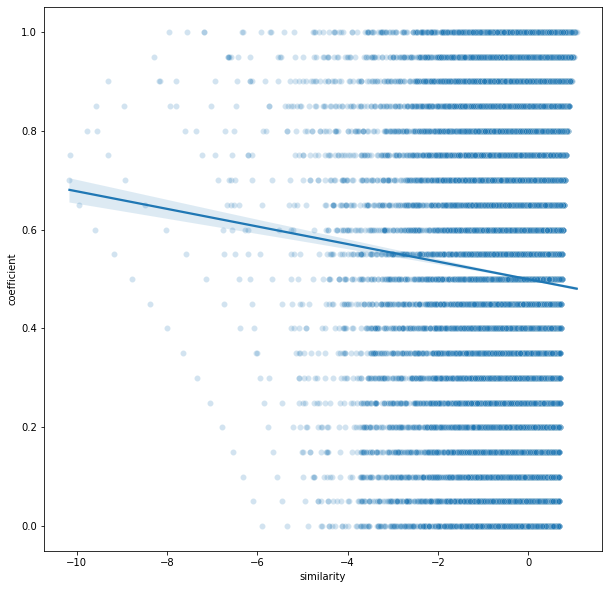

In [468]:
import seaborn as sns
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)

x = [i[1] for i in checking_corr_crop_hard]
y = [i[2] for i in checking_corr_crop_hard]

sns.scatterplot(x = x, y = y, alpha=0.2)
# sns.kdeplot(x = x, y = y, fill=True, common_norm=False, palette="crest", alpha=.2)
ax = sns.regplot(x = x, y = y, scatter=False)
ax.set(xlabel='similarity', ylabel='coefficient')

In [320]:
from scipy import spatial

l = 337

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
following = np.array([0.,0.,0.,0.])
for l in range(1000):
#     if freqs[l] > 20:
#         continue
    for z in tqdm(range(50000)):
        if ls[z] == l:
            final_pred = []
            best_agreement = -np.inf
            default_pred = 0
            all_coef_preds = []
            all_coef_pred_probas = []
            all_agreements = []
            best_mixer = 0
            x = np.vstack([all_og[z], all_0[z], all_1[z], all_2[z], all_3[z], all_4[z]])
            best_acc_temp = 0
            for ii in range(0, 21):
                i = ii/20.0
                mixed_clf.coef_ = i*conv_comb_0_8_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
                mixed_clf.intercept_ = i*conv_comb_0_8_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
                probas = mixed_clf.predict_proba(x)
                preds = mixed_clf.predict(x)
                all_coef_preds.append(preds)
                all_coef_pred_probas.append(probas)
                agreement = 0
                if i == 0.65:
                    default_pred = preds[0]

                agreement1 = 1 - spatial.distance.cosine(probas[0], probas[1])
                mu, sig = cossim_jitter[ii]
                agreement1 = (agreement1- mu)/sig

                agreement2 = 1 - spatial.distance.cosine(probas[0], probas[3])
                mu, sig = cossim_gray[ii]
                agreement2 = 0

                agreement3 = 1 - spatial.distance.cosine(probas[0], probas[2])
                mu, sig = cossim_crop_easy[ii]
                agreement3 = (agreement3- mu)/sig
            
                agreement4 = 1 - spatial.distance.cosine(probas[0], probas[4])
                mu, sig = cossim_crop_med[ii]
                agreement4 = 0
                
                agreement5 = 1 - spatial.distance.cosine(probas[5], probas[4])
                mu, sig = cossim_crop_hard[ii]
                agreement5 = 0


                agreement = agreement1+ agreement2+agreement3+agreement4+agreement5
                all_agreements.append(agreement)
                if agreement > best_agreement and ii < 19 and ii>1:
                    final_pred = [ii]
                    best_agreement = agreement
                    best_mixer = i
                if preds[0] == ls[z]:
                    best_acc_temp = 1
            final_pred = all_coef_preds[final_pred[0]][0]
            best_acc[ls[z]] += best_acc_temp

            if final_pred == ls[z]:
                total_acc[ls[z]] +=1

            if default_pred == ls[z]:
                def_acc[ls[z]] +=1
    stats = np.array([50, best_acc[l], def_acc[l], total_acc[l]])
    print(l, freqs[l], stats)
    following += stats
    print(following)
    print(following*100/following[0])

  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [273]:
l = 2
for z in tqdm(range(50000)):
    if ls[z] == l:
        print(z)

  0%|          | 0/50000 [00:00<?, ?it/s]

165
367
390
2511
2855
3682
3899
4510
7403
8948
9954
11091
11655
14516
15611
15616
17040
18128
18303
19117
20131
22112
24948
26328
26436
26568
26827
28427
30167
32229
33211
34537
36300
37299
37579
38827
39167
40895
40915
41211
41368
41612
42114
43594
44031
44648
45843
47129
47189
47448


In [440]:
z = 2122

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))


x = np.vstack([all_og[z], all_0[z], all_1[z], all_2[z], all_3[z], all_4[z]])
og_probas = []
og_preds = []
for ii in range(0, 21):
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    probas = mixed_clf.predict_proba(x)
    preds = mixed_clf.predict(x)
    og_probas.append(probas[0])
    og_preds.append(preds[0])
    
og_probas = np.array(og_probas)
print(og_preds)
og_preds = np.unique(np.array(og_preds))

og_preds

[855, 855, 855, 855, 855, 855, 855, 855, 855, 855, 855, 855, 855, 650, 650, 650, 650, 650, 650, 650, 650]


array([650, 855])

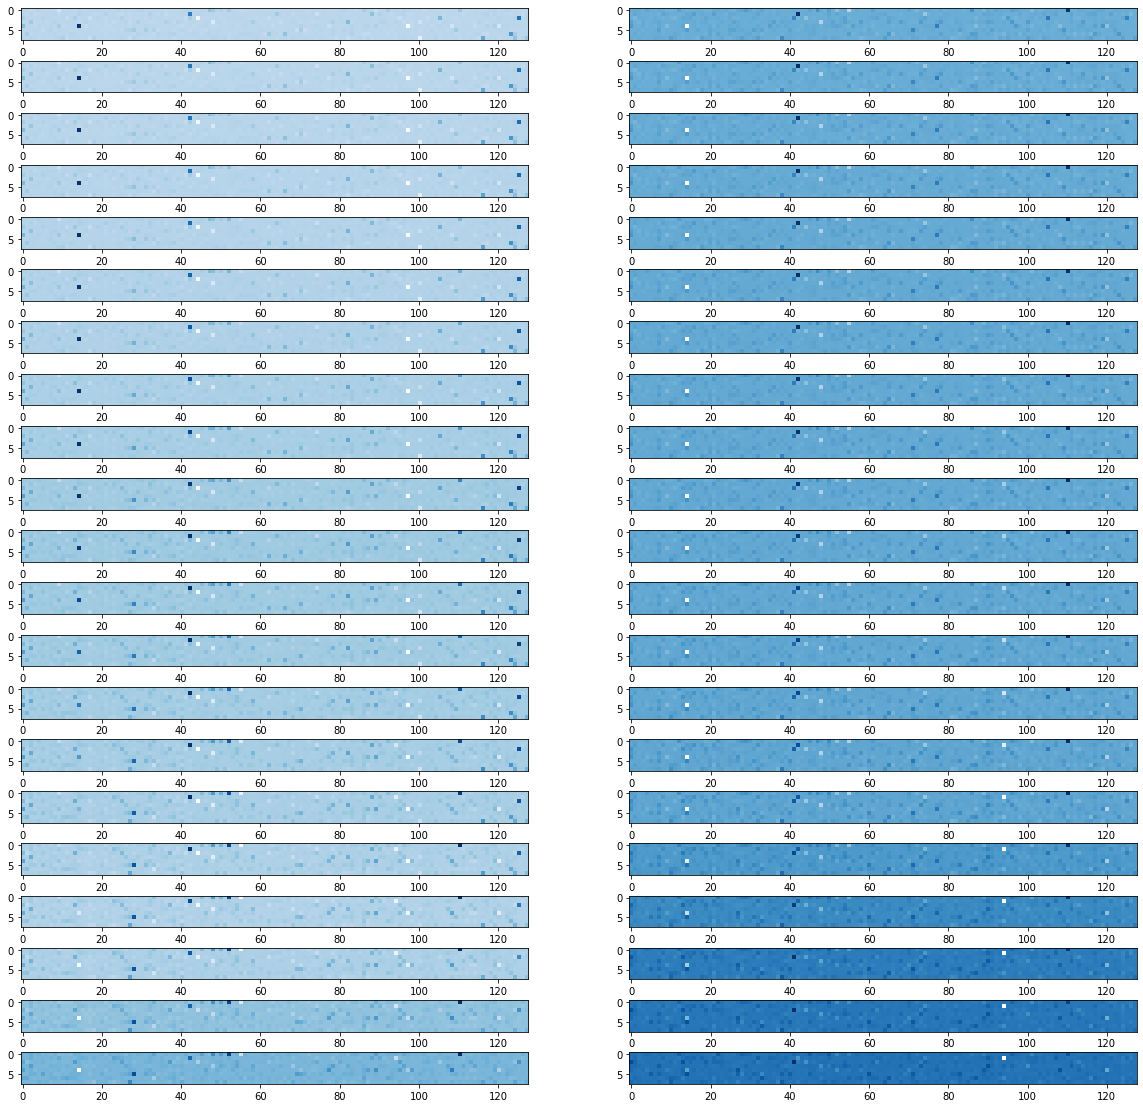

In [441]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (100,30)

fig, axs = plt.subplots(21, 2, figsize= (20,20))

for ii in range(21):
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    
    orig = np.array([mixed_clf.coef_[og_preds[0]] * all_og[z]])
    orig = (orig-np.mean(orig))/np.std(orig)
    to_plt = []
    for j in range(8):
        start = 128*j
        end = 128*(j+1)
        to_plt.append(orig[:,start:end])
    to_plt = np.vstack(to_plt)
    axs[ii][0].imshow(to_plt, cmap='Blues', interpolation='nearest')

#     mixed_clf.coef_ = j*text_only_balanced_clf.coef_ + (1-j)*image_only_clf_oversampled.coef_
    orig = np.array([mixed_clf.coef_[og_preds[1]] * all_og[z]])
    orig = (orig-np.mean(orig))/np.std(orig)
    to_plt = []
    for j in range(8):
        start = 128*j
        end = 128*(j+1)
        to_plt.append(orig[:,start:end])
    to_plt = np.vstack(to_plt)
    axs[ii][1].imshow(to_plt, cmap='Blues', interpolation='nearest')

plt.show()

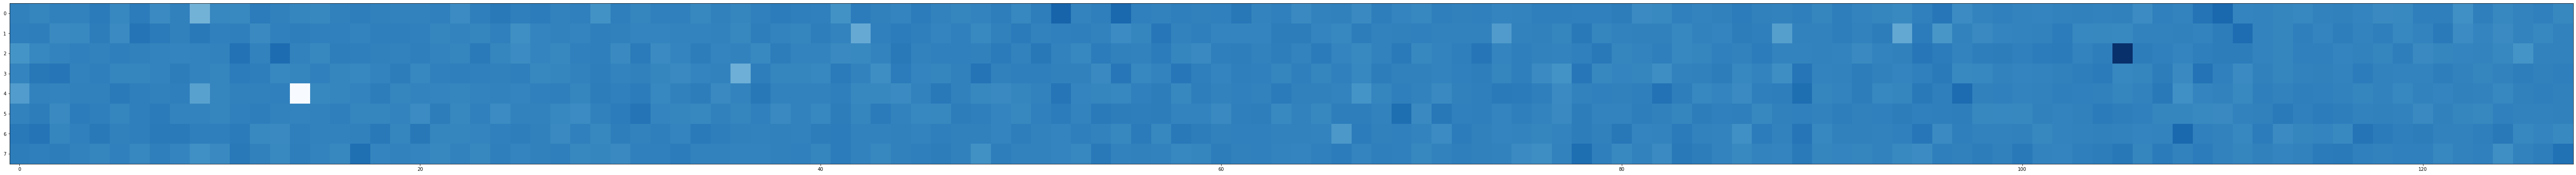

In [439]:
orig = np.array([all_og[z]])
orig = (orig-np.mean(orig))/np.std(orig)
to_plt = []
for j in range(8):
    start = 128*j
    end = 128*(j+1)
    to_plt.append(orig[:,start:end])
to_plt = np.vstack(to_plt)
plt.imshow(to_plt, cmap='Blues', interpolation='nearest')

In [433]:
for ii in range(21):
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    a = all_og[z]
    b = mixed_clf.coef_[og_preds[0]]
    print(1 - spatial.distance.cosine(a, b))

0.35950187812130885
0.35917293697043773
0.35856298988082447
0.3576083773943681
0.35623256991235186
0.35434405838109306
0.3518342256647746
0.34857543282884307
0.34441970397445654
0.3391985902692679
0.3327250253321179
0.3247982056105927
0.31521264579761044
0.3037724126165371
0.29031092599373687
0.274715462276796
0.25695361987014476
0.23709692582694042
0.21533536050193325
0.19197696282199206
0.16742950575302284


In [436]:
from scipy import spatial

l = 650

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
following = [0,0,0,0]
for z in tqdm(range(50000)):
    if ls[z] == l:
        final_pred = []
        best_agreement = -np.inf
        default_pred = 0
        all_coef_preds = []
        all_coef_pred_probas = []
        all_agreements = []
        best_mixer = 0
        x = np.vstack([all_og[z], all_0[z], all_1[z], all_2[z], all_3[z], all_4[z]])
        best_acc_temp = 0
        for ii in range(0, 21):
            i = ii/20.0
            mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
            mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
            probas = mixed_clf.predict_proba(x)
            preds = mixed_clf.predict(x)
            all_coef_preds.append(preds)
            all_coef_pred_probas.append(probas)
            agreement = 0
            if i == 0.65:
                default_pred = preds[0]
                
            agreement1 = 1 - spatial.distance.cosine(probas[0], probas[1])
            mu, sig = cossim_jitter[ii]
            agreement1 = (agreement1- mu)/sig

            agreement2 = 1 - spatial.distance.cosine(probas[0], probas[3])
            mu, sig = cossim_gray[ii]
            agreement2 = (agreement2- mu)/sig
            
            agreement3 = 1 - spatial.distance.cosine(probas[0], probas[2])
            mu, sig = cossim_crop_easy[ii]
            agreement3 = (agreement3- mu)/sig
            
            agreement4 = 1 - spatial.distance.cosine(probas[0], probas[4])
            mu, sig = cossim_crop_hard[ii]
            agreement4 = (agreement4- mu)/sig
            
            
            agreement = agreement3 + agreement4
            all_agreements.append(agreement)
            if agreement > best_agreement and ii < 19 and ii>1:
                final_pred = [ii]
                best_agreement = agreement
                best_mixer = i
            if preds[0] == ls[z]:
                best_acc_temp = 1
        final_pred = all_coef_preds[final_pred[0]][0]
        best_acc[ls[z]] += best_acc_temp

        print(default_pred, final_pred, best_agreement, best_mixer)
        print(z, CLASSES[default_pred], CLASSES[final_pred])
        if final_pred == ls[z]:
            total_acc[ls[z]] +=1
            if default_pred != ls[z]:
                print("*********")
                print(all_coef_preds)
                print(all_agreements)

        if default_pred == ls[z]:
            def_acc[ls[z]] +=1
            if final_pred != ls[z]:
                print("xxxxxxxx")
                print(all_coef_preds)
                print(all_agreements)
                
print(l, best_acc[l]*2, def_acc[l]*2, total_acc[l]*2)

# print(np.mean(best_acc), np.mean(def_acc), np.mean(total_acc))

  0%|          | 0/50000 [00:00<?, ?it/s]

613 613 -3.6908292575847086 0.7
995 joystick joystick
855 650 0.6504401396115733 0.9
1064 thimble microphone
*********
[array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([650, 855, 855, 650, 855, 650]), array([650, 855, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650])]
[-0.1417877450156978, -0.12228071708653752, -0.10145146084162

683 683 -1.3070733451873975 0.1
12770 oboe oboe
622 650 -0.49054687367374183 0.9
13231 lens cap microphone
*********
[array([872, 818, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([818, 855, 818, 855, 818, 745]), array([818, 855, 818, 855, 818, 745]), array([855, 855, 855, 855, 818, 745]), array([855, 855, 855, 855, 818, 745]), array([622, 855, 622, 650, 818, 745]), array([622, 650, 622, 650, 563, 745]), array([622, 650, 622, 650, 563, 745]), array([650, 650, 650, 650, 563, 650]), array([650, 650, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650])]
[-0.7571272965217076, -0.7440353462674993, -0.7319365749649853,

593 593 0.9174650667446027 0.8
24738 harmonica harmonica
650 650 1.3990555950732588 0.9
25777 microphone microphone
596 596 -1.245254758686568 0.1
26769 hatchet hatchet
546 546 0.541032664894589 0.45
28534 electric guitar electric guitar
477 477 -1.432117537452565 0.7
29079 tool kit tool kit
610 16 -0.06668554933710391 0.9
30318 T-shirt bulbul
650 632 -2.678707033744166 0.1
33039 microphone music speaker
xxxxxxxx
[array([632, 650, 632, 818, 818, 818]), array([632, 650, 632, 818, 818, 818]), array([632, 650, 632, 818, 818, 818]), array([632, 650, 632, 818, 818, 818]), array([632, 650, 632, 650, 818, 818]), array([650, 650, 632, 650, 818, 818]), array([650, 650, 632, 650, 818, 818]), array([650, 650, 632, 650, 818, 818]), array([650, 650, 632, 650, 818, 818]), array([650, 650, 632, 650, 818, 818]), array([650, 650, 650, 650, 818, 818]), array([650, 650, 650, 650, 818, 818]), array([650, 650, 650, 650, 818, 650]), array([650, 650, 650, 650, 818, 650]), array([650, 650, 650, 650, 818, 650]

In [442]:
cossim_jitter_cc = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_0])
    proba = mixed_clf.predict_proba(x)
    t1, t2 = proba[0:50000], proba[50000:]
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_jitter_cc.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()
    
cossim_gray_cc = []
all_cossims_text = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_2])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_gray_cc.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()
    
cossim_crop_easy_cc = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_1])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_crop_easy_cc.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()
    
    
cossim_crop_med_cc = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_3])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_crop_med_cc.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()
    
cossim_crop_hard_cc = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_4, all_3])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_crop_hard_cc.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()

0


KeyboardInterrupt: 

### Learning to predict based on augmentations similarities

In [40]:
def vis_enc(im):
    x = visual_model(im.half()).float()
    x = x / x.norm(dim=-1, keepdim=True)
    return x

In [41]:
# Find augmentations for which entropy of text and image classifiers are similar
import importlib
from data_loader import dataloaders as dataloader
importlib.reload(dataloader)
d = dataloader.load_data(
    data_root="./datasets/ImageNet/",
    dataset="ImageNet_LT",
    phase="test",
    batch_size=500,
    sampler_dic=None,
    num_workers=10,
    type="LT_Dataset_transform_mix",
    prompt_set="Imagenet",
#     override_transform = [T.RandomGrayscale(p=0.5)]
)

dataset_test = d[0]

og = []
ls = []
for im_cj, im_hf, im_rc, im_gb, im_gs, im_og, label, _, _ in tqdm(dataset_test):
    with torch.no_grad():
        og.append(vis_enc(im_og))
        ls.append(label)
        
og = torch.cat(og,0).cpu().numpy()
ls = torch.cat(ls,0).cpu().numpy()

print(og.shape)
print(ls.shape)

Loading data from /nethome/bdevnani3/flash1/long_tail_lang/data/ImageNet_LT/ImageNet_LT_test.txt
Use data transformation: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
***********************DATASET: test LT_Dataset_transform_mix
test 50000
No sampler.
Shuffle is True.


  0%|          | 0/100 [00:00<?, ?it/s]

(50000, 1024)
(50000,)


In [42]:
all_test_proba_og = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

for ii in tqdm(range(0, 21)):
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    probas = mixed_clf.predict_proba(og)
    all_test_proba_og.append(probas)

  0%|          | 0/21 [00:00<?, ?it/s]

In [43]:
from scipy import spatial

l = 337

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
following = np.array([0.,0.,0.,0.])
proba_set = []
# inds = np.random.randint(0, 50000, size=5000)
# for l in range(1000):
#     if freqs[l] > 20:
#         continue
#     l_count = 0
training_set = []
training_set2 = []
targets = []

all_training_set = []
all_training_set2 = []
all_targets = []
target_indices = []
for z in tqdm(range(50000)):
    print(z)
    l = ls[z]
    final_pred = []
    best_agreement = -np.inf
    default_pred = 0
    all_coef_preds = []
    all_coef_pred_probas = []
    all_agreements = []
    best_mixer = 0
    x = np.array([og[z]])
    best_acc_temp = 0
    og_proba = []
    
    t_set = []
    t_set2 = []
    trgt = []
    for ii in range(0, 21):
        i = ii/20.0
        mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
        mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
        probas = mixed_clf.predict_proba(x)
#         preds = mixed_clf.predict(x)
#         all_coef_preds.append(preds)
        all_coef_pred_probas.append(probas)
        pred = np.argmax(probas[0])
        
        agreement = 0
        if i == 0.65:
            default_pred = pred
            
        if i == 0:
            t_set = probas
            
        if ii == 20:
            t_set2 = probas
            

        if pred == ls[z]:
            trgt.append(ii)
            best_acc_temp = 1
#             proba_set.append([z, probas[1], probas[3], ii])
            
    if len(trgt) > 0:
        training_set.append(t_set)
        training_set2.append(t_set2)
        trgt = [np.min(trgt), np.max(trgt)]
        targets.append(trgt)
        target_indices.append(z)
    
    best_acc[ls[z]] += best_acc_temp

    if default_pred == ls[z]:
        def_acc[ls[z]] +=1
    stats = np.array([best_acc[l], def_acc[l]])
    print(l, freqs[l], stats)
# following += stats
# print(following)
# print(following*100/following[0])

  0%|          | 0/50000 [00:00<?, ?it/s]

0
243 56 [0. 0.]
1
505 54 [0. 0.]
2
581 58 [0. 0.]
3
502 44 [0. 0.]
4
233 51 [1. 1.]
5
408 275 [0. 0.]
6
320 170 [1. 1.]
7
458 44 [1. 1.]
8
25 56 [1. 1.]
9
48 201 [1. 1.]
10
252 63 [1. 1.]
11
959 17 [1. 1.]
12
848 8 [0. 0.]
13
425 47 [1. 1.]
14
780 31 [1. 1.]
15
157 30 [1. 1.]
16
28 279 [1. 1.]
17
26 134 [0. 0.]
18
7 45 [1. 0.]
19
557 164 [1. 0.]
20
372 349 [1. 1.]
21
889 50 [0. 0.]
22
170 7 [0. 0.]
23
298 11 [1. 1.]
24
203 50 [1. 1.]
25
394 122 [0. 0.]
26
451 137 [1. 1.]
27
311 119 [1. 1.]
28
8 150 [1. 1.]
29
334 48 [1. 1.]
30
312 50 [1. 1.]
31
398 372 [1. 1.]
32
825 20 [1. 0.]
33
242 59 [1. 1.]
34
280 241 [1. 0.]
35
623 102 [0. 0.]
36
778 12 [1. 1.]
37
664 46 [0. 0.]
38
906 110 [1. 0.]
39
346 167 [1. 1.]
40
152 10 [1. 0.]
41
665 296 [1. 1.]
42
2 516 [1. 1.]
43
446 43 [1. 1.]
44
368 96 [1. 1.]
45
408 275 [0. 0.]
46
794 197 [1. 1.]
47
584 22 [0. 0.]
48
57 173 [1. 1.]
49
415 124 [1. 1.]
50
655 115 [1. 1.]
51
661 33 [1. 1.]
52
781 87 [1. 1.]
53
808 21 [0. 0.]
54
182 367 [0. 0.]
55
291 53

87 19 [1. 1.]
432
554 382 [2. 2.]
433
833 57 [1. 1.]
434
895 182 [1. 1.]
435
940 45 [1. 1.]
436
785 161 [2. 2.]
437
873 11 [2. 1.]
438
832 146 [1. 1.]
439
273 28 [2. 2.]
440
583 112 [2. 1.]
441
968 258 [1. 0.]
442
682 83 [1. 1.]
443
69 72 [1. 1.]
444
216 87 [1. 1.]
445
905 116 [0. 0.]
446
977 73 [0. 0.]
447
97 819 [1. 1.]
448
875 459 [0. 0.]
449
58 5 [0. 0.]
450
477 134 [2. 2.]
451
363 169 [1. 1.]
452
191 244 [3. 2.]
453
284 186 [1. 1.]
454
448 22 [2. 2.]
455
416 45 [1. 0.]
456
218 86 [2. 2.]
457
880 252 [1. 1.]
458
906 110 [1. 0.]
459
482 8 [0. 0.]
460
969 108 [0. 0.]
461
743 299 [1. 1.]
462
387 231 [1. 1.]
463
498 6 [1. 0.]
464
4 143 [2. 2.]
465
420 68 [1. 1.]
466
261 137 [1. 1.]
467
19 157 [2. 2.]
468
983 39 [0. 0.]
469
647 64 [1. 1.]
470
603 376 [1. 1.]
471
205 125 [1. 1.]
472
198 90 [1. 1.]
473
617 120 [1. 1.]
474
842 18 [1. 1.]
475
305 46 [1. 1.]
476
855 143 [0. 0.]
477
537 191 [1. 1.]
478
577 46 [1. 0.]
479
202 43 [0. 0.]
480
301 22 [1. 1.]
481
696 45 [1. 1.]
482
503 105 [0. 0.]

290 71 [1. 1.]
858
190 35 [3. 3.]
859
706 73 [4. 4.]
860
711 283 [2. 2.]
861
412 118 [1. 1.]
862
481 39 [1. 1.]
863
20 87 [1. 1.]
864
284 186 [2. 2.]
865
599 65 [0. 0.]
866
698 38 [4. 4.]
867
837 84 [0. 0.]
868
894 28 [2. 2.]
869
529 35 [2. 2.]
870
554 382 [4. 4.]
871
37 39 [2. 2.]
872
13 35 [3. 3.]
873
452 48 [2. 2.]
874
326 77 [1. 0.]
875
283 19 [3. 3.]
876
593 292 [2. 2.]
877
739 183 [2. 2.]
878
723 63 [0. 0.]
879
834 285 [1. 1.]
880
496 178 [2. 2.]
881
373 83 [2. 2.]
882
338 174 [1. 1.]
883
536 110 [2. 1.]
884
172 272 [4. 3.]
885
849 54 [2. 2.]
886
294 62 [1. 1.]
887
106 116 [1. 1.]
888
474 59 [2. 0.]
889
579 14 [2. 2.]
890
916 19 [1. 0.]
891
672 138 [1. 1.]
892
790 28 [1. 1.]
893
655 115 [3. 3.]
894
234 6 [0. 0.]
895
943 67 [1. 1.]
896
21 181 [1. 1.]
897
185 38 [0. 0.]
898
878 31 [2. 2.]
899
789 27 [2. 1.]
900
196 10 [0. 0.]
901
295 43 [1. 1.]
902
740 32 [2. 2.]
903
282 27 [0. 0.]
904
534 87 [1. 1.]
905
410 22 [1. 1.]
906
718 14 [0. 0.]
907
151 53 [2. 2.]
908
438 10 [1. 1.]
909
81

414 159 [3. 2.]
1270
750 32 [3. 3.]
1271
839 28 [1. 1.]
1272
990 236 [2. 2.]
1273
576 14 [2. 2.]
1274
804 21 [1. 0.]
1275
580 239 [2. 2.]
1276
675 107 [2. 2.]
1277
635 106 [2. 1.]
1278
281 123 [1. 1.]
1279
327 332 [2. 2.]
1280
989 63 [2. 2.]
1281
189 24 [0. 0.]
1282
712 101 [1. 1.]
1283
424 10 [1. 1.]
1284
537 191 [2. 2.]
1285
244 172 [3. 3.]
1286
427 32 [1. 1.]
1287
299 42 [3. 3.]
1288
130 78 [1. 1.]
1289
84 226 [1. 1.]
1290
209 43 [3. 2.]
1291
600 169 [0. 0.]
1292
927 25 [3. 3.]
1293
339 17 [1. 1.]
1294
614 19 [0. 0.]
1295
699 165 [2. 2.]
1296
771 20 [1. 1.]
1297
857 101 [3. 3.]
1298
775 775 [2. 1.]
1299
798 63 [2. 2.]
1300
967 55 [2. 2.]
1301
840 17 [1. 1.]
1302
102 14 [3. 3.]
1303
791 36 [3. 3.]
1304
485 346 [2. 2.]
1305
646 6 [1. 1.]
1306
304 566 [0. 0.]
1307
586 130 [3. 2.]
1308
400 31 [1. 1.]
1309
67 297 [4. 4.]
1310
635 106 [3. 2.]
1311
708 8 [1. 1.]
1312
513 75 [2. 0.]
1313
856 114 [1. 1.]
1314
217 39 [1. 0.]
1315
507 20 [2. 1.]
1316
143 74 [3. 3.]
1317
110 35 [2. 1.]
1318
786

658 253 [1. 1.]
1674
742 43 [0. 0.]
1675
513 75 [2. 0.]
1676
981 34 [1. 1.]
1677
853 10 [3. 3.]
1678
992 19 [1. 0.]
1679
977 73 [3. 3.]
1680
271 81 [1. 1.]
1681
818 242 [1. 0.]
1682
404 257 [2. 2.]
1683
752 194 [4. 4.]
1684
66 44 [6. 3.]
1685
560 381 [4. 4.]
1686
857 101 [3. 3.]
1687
97 819 [2. 2.]
1688
498 6 [2. 1.]
1689
378 137 [3. 3.]
1690
193 23 [1. 0.]
1691
621 76 [2. 2.]
1692
353 149 [1. 0.]
1693
254 45 [1. 0.]
1694
808 21 [2. 2.]
1695
885 102 [1. 0.]
1696
302 208 [0. 0.]
1697
505 54 [2. 1.]
1698
193 23 [1. 0.]
1699
872 107 [2. 1.]
1700
842 18 [2. 2.]
1701
562 92 [1. 1.]
1702
152 10 [3. 0.]
1703
451 137 [3. 3.]
1704
322 19 [1. 1.]
1705
251 81 [2. 2.]
1706
28 279 [3. 3.]
1707
178 69 [1. 1.]
1708
941 18 [0. 0.]
1709
994 35 [3. 3.]
1710
164 81 [4. 3.]
1711
5 92 [2. 2.]
1712
363 169 [3. 3.]
1713
947 284 [4. 2.]
1714
807 205 [1. 1.]
1715
857 101 [4. 4.]
1716
954 71 [1. 1.]
1717
568 8 [0. 0.]
1718
923 172 [1. 1.]
1719
965 124 [5. 5.]
1720
858 157 [3. 3.]
1721
762 174 [0. 0.]
1722
389 2

357 127 [2. 2.]
2080
270 303 [4. 3.]
2081
976 625 [1. 0.]
2082
137 178 [3. 3.]
2083
644 85 [4. 3.]
2084
860 6 [3. 2.]
2085
297 41 [3. 3.]
2086
366 87 [4. 3.]
2087
519 619 [2. 2.]
2088
801 85 [3. 3.]
2089
710 99 [0. 0.]
2090
959 17 [3. 3.]
2091
796 76 [3. 3.]
2092
160 69 [4. 4.]
2093
184 73 [1. 1.]
2094
933 418 [3. 3.]
2095
380 73 [0. 0.]
2096
218 86 [3. 3.]
2097
136 59 [5. 5.]
2098
235 281 [4. 3.]
2099
980 45 [0. 0.]
2100
656 24 [2. 1.]
2101
695 29 [2. 2.]
2102
167 35 [0. 0.]
2103
81 93 [2. 2.]
2104
945 94 [2. 2.]
2105
923 172 [2. 2.]
2106
167 35 [0. 0.]
2107
578 252 [2. 2.]
2108
575 14 [0. 0.]
2109
418 111 [0. 0.]
2110
465 108 [1. 1.]
2111
8 150 [2. 2.]
2112
348 149 [2. 2.]
2113
594 317 [2. 2.]
2114
565 202 [3. 3.]
2115
106 116 [2. 2.]
2116
446 43 [2. 2.]
2117
662 104 [1. 1.]
2118
636 54 [2. 2.]
2119
93 222 [2. 1.]
2120
49 29 [2. 1.]
2121
869 15 [0. 0.]
2122
299 42 [7. 7.]
2123
946 103 [2. 1.]
2124
211 11 [2. 2.]
2125
869 15 [0. 0.]
2126
229 138 [0. 0.]
2127
32 65 [4. 4.]
2128
687 264

666 26 [2. 1.]
2486
129 161 [5. 4.]
2487
729 93 [0. 0.]
2488
230 22 [1. 1.]
2489
85 281 [3. 2.]
2490
778 12 [2. 1.]
2491
623 102 [2. 1.]
2492
434 16 [1. 1.]
2493
924 398 [4. 4.]
2494
793 85 [4. 4.]
2495
212 114 [1. 1.]
2496
1 250 [1. 1.]
2497
804 21 [1. 0.]
2498
348 149 [5. 5.]
2499
28 279 [4. 4.]
2500
433 82 [3. 3.]
2501
400 31 [4. 3.]
2502
761 34 [3. 3.]
2503
439 58 [2. 2.]
2504
475 186 [5. 5.]
2505
634 31 [3. 3.]
2506
710 99 [1. 1.]
2507
237 13 [2. 2.]
2508
814 41 [3. 3.]
2509
475 186 [6. 6.]
2510
632 10 [2. 1.]
2511
289 96 [3. 3.]
2512
508 122 [0. 0.]
2513
287 42 [2. 2.]
2514
756 7 [1. 0.]
2515
756 7 [1. 0.]
2516
796 76 [4. 4.]
2517
461 19 [0. 0.]
2518
988 119 [2. 1.]
2519
776 11 [1. 1.]
2520
859 70 [1. 0.]
2521
252 63 [4. 4.]
2522
606 8 [2. 2.]
2523
18 392 [5. 5.]
2524
789 27 [5. 4.]
2525
199 33 [1. 1.]
2526
778 12 [2. 1.]
2527
451 137 [5. 5.]
2528
107 133 [1. 1.]
2529
977 73 [4. 4.]
2530
915 155 [5. 5.]
2531
146 86 [2. 2.]
2532
326 77 [2. 1.]
2533
370 49 [1. 1.]
2534
620 50 [3. 1

726 6 [0. 0.]
2892
525 41 [7. 7.]
2893
313 51 [6. 6.]
2894
691 29 [3. 3.]
2895
569 125 [6. 6.]
2896
890 140 [4. 3.]
2897
845 25 [2. 2.]
2898
617 120 [4. 4.]
2899
941 18 [0. 0.]
2900
841 44 [2. 2.]
2901
126 246 [1. 1.]
2902
915 155 [6. 6.]
2903
968 258 [4. 2.]
2904
325 128 [2. 2.]
2905
245 119 [4. 4.]
2906
813 19 [0. 0.]
2907
937 55 [4. 3.]
2908
697 24 [5. 4.]
2909
990 236 [3. 3.]
2910
980 45 [1. 1.]
2911
426 109 [3. 3.]
2912
902 30 [3. 2.]
2913
868 31 [3. 3.]
2914
633 10 [0. 0.]
2915
203 50 [3. 1.]
2916
623 102 [3. 2.]
2917
294 62 [6. 6.]
2918
774 43 [1. 1.]
2919
619 86 [1. 1.]
2920
91 81 [1. 1.]
2921
796 76 [6. 6.]
2922
539 48 [2. 2.]
2923
513 75 [3. 0.]
2924
499 22 [0. 0.]
2925
167 35 [0. 0.]
2926
550 104 [2. 2.]
2927
902 30 [4. 2.]
2928
517 38 [2. 2.]
2929
697 24 [5. 4.]
2930
349 16 [3. 1.]
2931
940 45 [4. 3.]
2932
791 36 [5. 5.]
2933
193 23 [1. 0.]
2934
722 82 [4. 4.]
2935
687 264 [2. 2.]
2936
57 173 [4. 3.]
2937
343 15 [3. 3.]
2938
389 28 [3. 3.]
2939
939 63 [1. 1.]
2940
219 496 [

95 28 [3. 3.]
3298
166 25 [1. 1.]
3299
508 122 [1. 1.]
3300
485 346 [2. 2.]
3301
929 534 [7. 7.]
3302
896 170 [3. 3.]
3303
396 165 [6. 6.]
3304
952 133 [2. 2.]
3305
937 55 [7. 6.]
3306
533 54 [7. 7.]
3307
144 27 [4. 4.]
3308
70 35 [6. 6.]
3309
620 50 [4. 1.]
3310
443 112 [6. 6.]
3311
428 69 [1. 1.]
3312
981 34 [7. 7.]
3313
950 175 [2. 2.]
3314
153 30 [6. 6.]
3315
553 47 [2. 2.]
3316
782 32 [1. 0.]
3317
498 6 [4. 1.]
3318
211 11 [3. 3.]
3319
34 118 [1. 1.]
3320
712 101 [3. 3.]
3321
38 14 [2. 2.]
3322
661 33 [4. 4.]
3323
351 23 [2. 2.]
3324
900 20 [2. 2.]
3325
964 93 [3. 3.]
3326
320 170 [5. 5.]
3327
291 53 [4. 4.]
3328
360 49 [2. 2.]
3329
680 61 [1. 0.]
3330
594 317 [4. 4.]
3331
207 119 [2. 2.]
3332
559 310 [1. 1.]
3333
432 30 [3. 2.]
3334
10 34 [2. 2.]
3335
403 34 [3. 3.]
3336
33 56 [3. 3.]
3337
821 105 [3. 3.]
3338
979 98 [4. 3.]
3339
749 31 [3. 3.]
3340
989 63 [4. 4.]
3341
357 127 [2. 2.]
3342
937 55 [8. 7.]
3343
217 39 [3. 2.]
3344
576 14 [4. 4.]
3345
935 7 [3. 3.]
3346
443 112 [7. 

802 134 [7. 7.]
3704
706 73 [8. 8.]
3705
681 26 [1. 1.]
3706
627 119 [5. 5.]
3707
765 290 [1. 1.]
3708
631 57 [1. 1.]
3709
303 18 [5. 4.]
3710
118 72 [3. 2.]
3711
562 92 [3. 3.]
3712
623 102 [5. 4.]
3713
52 189 [2. 2.]
3714
569 125 [7. 7.]
3715
394 122 [6. 5.]
3716
497 45 [3. 3.]
3717
312 50 [3. 1.]
3718
184 73 [1. 1.]
3719
818 242 [3. 2.]
3720
17 13 [3. 1.]
3721
238 36 [5. 3.]
3722
74 137 [2. 1.]
3723
968 258 [6. 3.]
3724
421 52 [4. 4.]
3725
105 32 [4. 4.]
3726
73 10 [1. 1.]
3727
103 111 [2. 1.]
3728
254 45 [4. 3.]
3729
275 72 [5. 5.]
3730
767 263 [5. 4.]
3731
481 39 [2. 2.]
3732
949 23 [3. 3.]
3733
203 50 [4. 2.]
3734
251 81 [4. 4.]
3735
841 44 [2. 2.]
3736
380 73 [1. 1.]
3737
711 283 [4. 4.]
3738
806 302 [3. 3.]
3739
185 38 [4. 4.]
3740
478 25 [2. 2.]
3741
796 76 [7. 7.]
3742
725 454 [2. 1.]
3743
298 11 [5. 2.]
3744
628 140 [4. 4.]
3745
979 98 [5. 4.]
3746
608 298 [2. 2.]
3747
448 22 [5. 4.]
3748
26 134 [1. 1.]
3749
528 116 [5. 5.]
3750
490 652 [2. 2.]
3751
25 56 [4. 4.]
3752
171 35

191 244 [5. 4.]
4110
610 43 [5. 5.]
4111
677 75 [5. 4.]
4112
463 15 [3. 3.]
4113
938 20 [2. 2.]
4114
20 87 [6. 6.]
4115
870 642 [4. 4.]
4116
168 112 [5. 5.]
4117
994 35 [5. 4.]
4118
616 354 [4. 4.]
4119
540 153 [4. 3.]
4120
444 480 [5. 4.]
4121
699 165 [5. 5.]
4122
60 34 [1. 0.]
4123
507 20 [3. 2.]
4124
527 55 [2. 2.]
4125
982 41 [8. 8.]
4126
763 315 [4. 4.]
4127
197 59 [3. 1.]
4128
139 75 [7. 6.]
4129
642 90 [3. 3.]
4130
759 9 [2. 2.]
4131
443 112 [8. 8.]
4132
416 45 [3. 1.]
4133
675 107 [5. 5.]
4134
194 106 [4. 3.]
4135
531 100 [4. 4.]
4136
252 63 [7. 7.]
4137
587 278 [1. 1.]
4138
811 93 [5. 5.]
4139
217 39 [5. 3.]
4140
485 346 [4. 4.]
4141
385 6 [1. 0.]
4142
943 67 [5. 5.]
4143
267 14 [2. 1.]
4144
255 37 [5. 4.]
4145
141 23 [3. 3.]
4146
399 34 [3. 3.]
4147
975 45 [3. 3.]
4148
125 23 [2. 1.]
4149
307 10 [6. 6.]
4150
276 187 [7. 7.]
4151
517 38 [3. 3.]
4152
436 14 [5. 3.]
4153
839 28 [4. 3.]
4154
677 75 [6. 5.]
4155
661 33 [6. 6.]
4156
299 42 [8. 8.]
4157
144 27 [6. 6.]
4158
368 96 [3

606 8 [4. 4.]
4516
51 27 [5. 4.]
4517
877 19 [4. 3.]
4518
446 43 [2. 2.]
4519
399 34 [3. 3.]
4520
944 151 [3. 3.]
4521
67 297 [7. 7.]
4522
608 298 [3. 3.]
4523
508 122 [1. 1.]
4524
667 128 [8. 6.]
4525
821 105 [4. 4.]
4526
109 66 [7. 6.]
4527
800 11 [2. 2.]
4528
505 54 [2. 1.]
4529
666 26 [3. 2.]
4530
635 106 [5. 3.]
4531
279 137 [2. 2.]
4532
307 10 [7. 7.]
4533
559 310 [4. 4.]
4534
250 181 [3. 3.]
4535
613 413 [4. 3.]
4536
246 90 [1. 1.]
4537
185 38 [5. 5.]
4538
112 393 [2. 2.]
4539
865 5 [1. 1.]
4540
3 352 [2. 1.]
4541
328 8 [3. 0.]
4542
723 63 [3. 3.]
4543
706 73 [10. 10.]
4544
83 135 [5. 5.]
4545
915 155 [7. 7.]
4546
922 284 [4. 4.]
4547
926 56 [2. 2.]
4548
985 143 [4. 4.]
4549
152 10 [7. 1.]
4550
509 220 [2. 2.]
4551
752 194 [7. 7.]
4552
467 16 [3. 3.]
4553
181 20 [5. 5.]
4554
832 146 [8. 8.]
4555
220 91 [3. 3.]
4556
14 121 [7. 6.]
4557
225 48 [2. 2.]
4558
308 58 [5. 5.]
4559
64 31 [6. 4.]
4560
201 214 [2. 2.]
4561
957 32 [4. 3.]
4562
485 346 [5. 5.]
4563
893 133 [3. 3.]
4564
0 50

782 32 [2. 0.]
4924
691 29 [4. 4.]
4925
406 83 [8. 6.]
4926
65 8 [2. 1.]
4927
313 51 [7. 7.]
4928
622 72 [6. 6.]
4929
477 134 [5. 5.]
4930
657 72 [1. 0.]
4931
741 14 [2. 1.]
4932
585 101 [1. 1.]
4933
830 343 [5. 4.]
4934
642 90 [4. 4.]
4935
186 56 [4. 4.]
4936
102 14 [5. 5.]
4937
460 333 [2. 0.]
4938
953 99 [5. 5.]
4939
511 44 [3. 3.]
4940
778 12 [2. 1.]
4941
3 352 [3. 2.]
4942
60 34 [1. 0.]
4943
956 80 [7. 6.]
4944
814 41 [8. 7.]
4945
735 66 [3. 2.]
4946
171 35 [3. 2.]
4947
990 236 [8. 8.]
4948
183 49 [8. 5.]
4949
707 25 [4. 3.]
4950
731 11 [1. 0.]
4951
545 422 [6. 4.]
4952
846 60 [1. 1.]
4953
852 17 [4. 4.]
4954
240 126 [5. 3.]
4955
117 604 [4. 4.]
4956
510 82 [2. 2.]
4957
383 65 [5. 5.]
4958
608 298 [5. 5.]
4959
684 42 [5. 5.]
4960
51 27 [7. 6.]
4961
893 133 [3. 3.]
4962
296 330 [2. 2.]
4963
745 40 [5. 4.]
4964
298 11 [6. 2.]
4965
915 155 [8. 8.]
4966
471 82 [2. 2.]
4967
885 102 [2. 1.]
4968
896 170 [6. 6.]
4969
881 25 [4. 4.]
4970
212 114 [1. 1.]
4971
192 305 [1. 1.]
4972
938 20 [4

480 288 [5. 5.]
5329
439 58 [6. 6.]
5330
750 32 [4. 4.]
5331
425 47 [6. 6.]
5332
5 92 [4. 4.]
5333
207 119 [4. 3.]
5334
706 73 [11. 10.]
5335
187 75 [3. 3.]
5336
869 15 [1. 1.]
5337
841 44 [3. 3.]
5338
869 15 [2. 1.]
5339
512 43 [5. 4.]
5340
832 146 [9. 9.]
5341
995 167 [7. 6.]
5342
587 278 [1. 1.]
5343
274 15 [4. 4.]
5344
433 82 [6. 6.]
5345
653 27 [3. 3.]
5346
169 35 [7. 6.]
5347
196 10 [1. 0.]
5348
368 96 [6. 6.]
5349
541 84 [3. 3.]
5350
780 31 [4. 3.]
5351
114 179 [6. 5.]
5352
917 7 [7. 5.]
5353
549 168 [4. 4.]
5354
101 93 [4. 3.]
5355
899 272 [1. 1.]
5356
737 472 [5. 5.]
5357
663 38 [6. 6.]
5358
332 86 [5. 5.]
5359
147 105 [5. 4.]
5360
263 97 [3. 2.]
5361
1 250 [3. 3.]
5362
325 128 [3. 3.]
5363
754 80 [3. 1.]
5364
670 66 [6. 5.]
5365
5 92 [4. 4.]
5366
645 82 [7. 7.]
5367
221 52 [3. 2.]
5368
742 43 [4. 4.]
5369
146 86 [3. 3.]
5370
391 96 [5. 5.]
5371
882 456 [6. 6.]
5372
782 32 [2. 0.]
5373
102 14 [5. 5.]
5374
734 40 [7. 6.]
5375
354 23 [4. 4.]
5376
888 32 [3. 3.]
5377
226 62 [2. 1

310 67 [5. 5.]
5735
24 114 [4. 4.]
5736
615 25 [4. 2.]
5737
275 72 [7. 7.]
5738
820 166 [5. 5.]
5739
659 55 [5. 5.]
5740
856 114 [4. 4.]
5741
223 11 [1. 1.]
5742
475 186 [7. 7.]
5743
383 65 [6. 6.]
5744
677 75 [8. 6.]
5745
43 103 [8. 8.]
5746
925 110 [3. 3.]
5747
826 73 [3. 2.]
5748
71 36 [3. 3.]
5749
622 72 [7. 6.]
5750
541 84 [3. 3.]
5751
645 82 [8. 8.]
5752
962 17 [7. 6.]
5753
272 167 [1. 0.]
5754
316 37 [7. 7.]
5755
496 178 [6. 6.]
5756
792 14 [2. 2.]
5757
840 17 [1. 1.]
5758
578 252 [8. 8.]
5759
131 370 [8. 7.]
5760
301 22 [6. 5.]
5761
887 6 [2. 1.]
5762
168 112 [5. 5.]
5763
33 56 [5. 5.]
5764
220 91 [5. 5.]
5765
595 179 [6. 6.]
5766
322 19 [7. 6.]
5767
959 17 [5. 5.]
5768
863 64 [6. 6.]
5769
896 170 [7. 7.]
5770
240 126 [6. 3.]
5771
104 61 [3. 3.]
5772
838 64 [4. 2.]
5773
553 47 [4. 4.]
5774
292 53 [5. 5.]
5775
217 39 [6. 4.]
5776
598 32 [5. 4.]
5777
129 161 [8. 7.]
5778
442 165 [3. 2.]
5779
233 51 [5. 3.]
5780
991 150 [5. 5.]
5781
493 203 [3. 2.]
5782
836 60 [2. 2.]
5783
247 163

839 28 [6. 3.]
6139
120 22 [3. 2.]
6140
70 35 [9. 9.]
6141
828 229 [6. 5.]
6142
330 42 [3. 2.]
6143
113 47 [5. 5.]
6144
448 22 [7. 5.]
6145
188 89 [7. 6.]
6146
10 34 [4. 4.]
6147
932 26 [4. 3.]
6148
867 9 [11.  9.]
6149
229 138 [3. 3.]
6150
259 32 [8. 8.]
6151
146 86 [6. 5.]
6152
531 100 [5. 4.]
6153
648 86 [3. 2.]
6154
647 64 [4. 4.]
6155
92 61 [3. 3.]
6156
388 171 [5. 5.]
6157
357 127 [7. 7.]
6158
642 90 [7. 7.]
6159
339 17 [6. 6.]
6160
873 11 [6. 4.]
6161
398 372 [8. 8.]
6162
175 100 [4. 4.]
6163
244 172 [7. 7.]
6164
455 17 [3. 3.]
6165
942 80 [5. 4.]
6166
709 182 [6. 5.]
6167
930 43 [5. 4.]
6168
276 187 [8. 8.]
6169
672 138 [9. 9.]
6170
838 64 [5. 3.]
6171
328 8 [6. 2.]
6172
866 8 [6. 3.]
6173
558 30 [2. 1.]
6174
314 87 [9. 8.]
6175
624 310 [3. 2.]
6176
763 315 [7. 7.]
6177
996 19 [5. 5.]
6178
892 112 [4. 4.]
6179
146 86 [7. 6.]
6180
95 28 [6. 6.]
6181
434 16 [2. 2.]
6182
54 69 [3. 2.]
6183
154 77 [3. 3.]
6184
652 204 [7. 7.]
6185
265 14 [2. 1.]
6186
50 376 [7. 6.]
6187
851 31 [3. 

832 146 [11. 11.]
6543
695 29 [8. 6.]
6544
950 175 [4. 4.]
6545
402 679 [8. 8.]
6546
503 105 [4. 3.]
6547
87 19 [5. 5.]
6548
454 511 [6. 6.]
6549
324 81 [6. 6.]
6550
246 90 [3. 3.]
6551
182 367 [8. 8.]
6552
372 349 [10. 10.]
6553
891 104 [4. 3.]
6554
245 119 [9. 9.]
6555
875 459 [4. 4.]
6556
203 50 [8. 5.]
6557
912 13 [4. 4.]
6558
881 25 [4. 4.]
6559
361 143 [7. 7.]
6560
0 50 [12. 12.]
6561
843 39 [7. 6.]
6562
6 47 [6. 5.]
6563
342 27 [7. 6.]
6564
90 186 [12. 11.]
6565
847 134 [4. 4.]
6566
838 64 [5. 3.]
6567
586 130 [6. 5.]
6568
911 16 [2. 1.]
6569
399 34 [6. 6.]
6570
401 63 [8. 7.]
6571
821 105 [7. 7.]
6572
983 39 [7. 6.]
6573
261 137 [5. 5.]
6574
477 134 [9. 9.]
6575
728 66 [1. 1.]
6576
278 310 [4. 3.]
6577
415 124 [5. 5.]
6578
205 125 [6. 5.]
6579
46 346 [1. 1.]
6580
139 75 [9. 8.]
6581
856 114 [7. 7.]
6582
163 47 [1. 1.]
6583
555 148 [7. 7.]
6584
228 41 [6. 6.]
6585
407 23 [5. 4.]
6586
771 20 [6. 5.]
6587
295 43 [8. 8.]
6588
296 330 [5. 5.]
6589
734 40 [8. 7.]
6590
460 333 [4. 1.]

373 83 [9. 8.]
6945
427 32 [4. 4.]
6946
728 66 [2. 2.]
6947
237 13 [4. 3.]
6948
630 63 [8. 8.]
6949
751 83 [7. 6.]
6950
902 30 [5. 2.]
6951
332 86 [7. 7.]
6952
801 85 [10. 10.]
6953
152 10 [8. 1.]
6954
85 281 [5. 4.]
6955
258 71 [8. 8.]
6956
271 81 [2. 2.]
6957
779 137 [10. 10.]
6958
820 166 [6. 6.]
6959
795 82 [6. 6.]
6960
143 74 [11. 10.]
6961
191 244 [6. 5.]
6962
254 45 [6. 5.]
6963
303 18 [6. 5.]
6964
853 10 [11.  9.]
6965
987 233 [5. 5.]
6966
124 20 [1. 0.]
6967
326 77 [7. 3.]
6968
990 236 [10. 10.]
6969
375 232 [5. 5.]
6970
818 242 [3. 2.]
6971
296 330 [6. 6.]
6972
94 15 [5. 4.]
6973
240 126 [7. 3.]
6974
734 40 [9. 8.]
6975
741 14 [3. 1.]
6976
880 252 [4. 4.]
6977
182 367 [9. 9.]
6978
798 63 [7. 7.]
6979
353 149 [3. 0.]
6980
603 376 [8. 8.]
6981
789 27 [8. 7.]
6982
968 258 [8. 5.]
6983
832 146 [12. 12.]
6984
565 202 [9. 9.]
6985
170 7 [1. 1.]
6986
358 11 [3. 0.]
6987
627 119 [7. 7.]
6988
303 18 [7. 6.]
6989
262 102 [5. 5.]
6990
542 16 [4. 3.]
6991
815 17 [10.  9.]
6992
491 6 [2. 

719 78 [3. 3.]
7347
934 141 [4. 4.]
7348
151 53 [4. 4.]
7349
614 19 [10. 10.]
7350
334 48 [10. 10.]
7351
289 96 [9. 9.]
7352
913 215 [6. 6.]
7353
370 49 [3. 3.]
7354
687 264 [5. 4.]
7355
485 346 [6. 6.]
7356
508 122 [2. 2.]
7357
212 114 [3. 3.]
7358
553 47 [4. 4.]
7359
8 150 [7. 7.]
7360
992 19 [5. 4.]
7361
583 112 [6. 4.]
7362
408 275 [5. 4.]
7363
202 43 [4. 1.]
7364
166 25 [5. 4.]
7365
497 45 [6. 6.]
7366
408 275 [5. 4.]
7367
351 23 [8. 7.]
7368
678 108 [5. 5.]
7369
405 27 [3. 3.]
7370
53 96 [4. 2.]
7371
748 20 [3. 2.]
7372
6 47 [6. 5.]
7373
168 112 [6. 6.]
7374
945 94 [5. 5.]
7375
412 118 [7. 6.]
7376
632 10 [5. 4.]
7377
42 236 [5. 5.]
7378
250 181 [6. 6.]
7379
915 155 [10. 10.]
7380
462 48 [6. 5.]
7381
40 80 [3. 1.]
7382
332 86 [8. 7.]
7383
689 16 [4. 1.]
7384
864 65 [3. 1.]
7385
755 787 [6. 6.]
7386
459 36 [4. 2.]
7387
783 229 [9. 9.]
7388
615 25 [7. 3.]
7389
15 7 [9. 7.]
7390
742 43 [6. 6.]
7391
706 73 [12. 11.]
7392
977 73 [6. 6.]
7393
914 85 [7. 6.]
7394
722 82 [8. 8.]
7395
347

116 79 [3. 2.]
7749
963 19 [6. 6.]
7750
150 126 [3. 3.]
7751
190 35 [10. 10.]
7752
292 53 [10. 10.]
7753
0 50 [13. 13.]
7754
976 625 [5. 1.]
7755
628 140 [7. 7.]
7756
333 1121 [6. 6.]
7757
25 56 [8. 8.]
7758
821 105 [10. 10.]
7759
223 11 [1. 1.]
7760
969 108 [2. 1.]
7761
134 285 [7. 7.]
7762
166 25 [6. 4.]
7763
477 134 [12. 12.]
7764
73 10 [2. 1.]
7765
712 101 [5. 5.]
7766
389 28 [4. 4.]
7767
19 157 [10. 10.]
7768
724 103 [5. 5.]
7769
896 170 [8. 8.]
7770
562 92 [7. 7.]
7771
88 38 [7. 5.]
7772
897 76 [8. 8.]
7773
860 6 [8. 4.]
7774
212 114 [4. 3.]
7775
296 330 [7. 7.]
7776
859 70 [3. 2.]
7777
480 288 [8. 8.]
7778
627 119 [8. 8.]
7779
37 39 [8. 7.]
7780
861 75 [2. 2.]
7781
874 69 [10. 10.]
7782
313 51 [7. 7.]
7783
825 20 [6. 3.]
7784
715 194 [7. 6.]
7785
524 71 [3. 2.]
7786
854 9 [5. 4.]
7787
991 150 [9. 9.]
7788
55 157 [5. 3.]
7789
617 120 [7. 7.]
7790
209 43 [7. 6.]
7791
830 343 [6. 5.]
7792
914 85 [8. 7.]
7793
216 87 [7. 7.]
7794
620 50 [7. 3.]
7795
996 19 [7. 7.]
7796
270 303 [7. 6.

146 86 [10.  8.]
8149
891 104 [7. 6.]
8150
113 47 [8. 7.]
8151
649 29 [5. 5.]
8152
265 14 [3. 2.]
8153
41 15 [7. 1.]
8154
416 45 [10.  7.]
8155
177 137 [10.  8.]
8156
806 302 [6. 6.]
8157
104 61 [7. 7.]
8158
830 343 [7. 6.]
8159
671 130 [8. 6.]
8160
872 107 [4. 3.]
8161
30 287 [7. 7.]
8162
977 73 [10. 10.]
8163
765 290 [2. 2.]
8164
609 132 [9. 6.]
8165
681 26 [5. 2.]
8166
892 112 [5. 5.]
8167
10 34 [6. 6.]
8168
56 16 [5. 4.]
8169
192 305 [4. 3.]
8170
856 114 [8. 8.]
8171
263 97 [4. 3.]
8172
273 28 [6. 6.]
8173
491 6 [3. 1.]
8174
620 50 [7. 3.]
8175
610 43 [7. 7.]
8176
45 54 [4. 4.]
8177
260 12 [5. 4.]
8178
247 163 [10.  9.]
8179
404 257 [5. 5.]
8180
277 20 [4. 3.]
8181
520 162 [7. 5.]
8182
554 382 [10. 10.]
8183
996 19 [8. 8.]
8184
347 198 [8. 8.]
8185
483 32 [4. 4.]
8186
639 64 [7. 5.]
8187
938 20 [7. 7.]
8188
73 10 [2. 1.]
8189
163 47 [4. 2.]
8190
93 222 [9. 7.]
8191
441 152 [9. 8.]
8192
290 71 [8. 8.]
8193
798 63 [9. 9.]
8194
731 11 [1. 0.]
8195
361 143 [9. 9.]
8196
301 22 [9. 8.]
8

929 534 [12. 12.]
8547
356 5 [4. 3.]
8548
976 625 [6. 2.]
8549
621 76 [9. 9.]
8550
948 180 [5. 5.]
8551
86 1280 [8. 7.]
8552
294 62 [10. 10.]
8553
177 137 [12. 10.]
8554
390 108 [6. 6.]
8555
954 71 [4. 4.]
8556
386 85 [7. 5.]
8557
652 204 [8. 8.]
8558
702 15 [1. 0.]
8559
306 19 [8. 8.]
8560
357 127 [8. 8.]
8561
639 64 [8. 5.]
8562
246 90 [5. 5.]
8563
572 37 [8. 6.]
8564
54 69 [5. 2.]
8565
527 55 [2. 2.]
8566
703 60 [5. 4.]
8567
107 133 [6. 6.]
8568
366 87 [9. 7.]
8569
86 1280 [9. 8.]
8570
987 233 [7. 7.]
8571
481 39 [6. 5.]
8572
935 7 [7. 6.]
8573
720 13 [10.  8.]
8574
422 41 [12. 10.]
8575
397 10 [6. 6.]
8576
1 250 [8. 8.]
8577
156 245 [7. 6.]
8578
57 173 [10.  9.]
8579
324 81 [7. 7.]
8580
288 71 [6. 5.]
8581
23 171 [7. 6.]
8582
14 121 [13. 11.]
8583
263 97 [5. 4.]
8584
184 73 [4. 3.]
8585
431 10 [4. 3.]
8586
357 127 [9. 9.]
8587
326 77 [8. 4.]
8588
134 285 [7. 7.]
8589
920 323 [8. 8.]
8590
296 330 [10. 10.]
8591
672 138 [15. 15.]
8592
666 26 [5. 4.]
8593
85 281 [7. 5.]
8594
367 128 [

564 268 [9. 8.]
8945
547 25 [8. 6.]
8946
906 110 [6. 4.]
8947
125 23 [8. 5.]
8948
665 296 [5. 4.]
8949
769 86 [8. 7.]
8950
482 8 [2. 1.]
8951
501 102 [2. 2.]
8952
742 43 [7. 6.]
8953
531 100 [8. 7.]
8954
35 43 [7. 3.]
8955
403 34 [7. 7.]
8956
195 77 [3. 3.]
8957
320 170 [8. 8.]
8958
771 20 [9. 7.]
8959
590 21 [5. 2.]
8960
995 167 [12. 11.]
8961
505 54 [4. 3.]
8962
624 310 [6. 5.]
8963
199 33 [7. 6.]
8964
492 154 [5. 4.]
8965
490 652 [9. 9.]
8966
811 93 [7. 7.]
8967
403 34 [8. 8.]
8968
778 12 [3. 2.]
8969
136 59 [9. 9.]
8970
175 100 [6. 6.]
8971
857 101 [12. 11.]
8972
222 56 [5. 2.]
8973
488 123 [5. 5.]
8974
306 19 [9. 9.]
8975
450 48 [5. 5.]
8976
257 282 [5. 2.]
8977
821 105 [12. 12.]
8978
726 6 [5. 2.]
8979
583 112 [8. 6.]
8980
809 53 [6. 5.]
8981
828 229 [7. 6.]
8982
79 15 [7. 5.]
8983
92 61 [5. 5.]
8984
683 77 [4. 4.]
8985
679 167 [6. 6.]
8986
693 33 [6. 5.]
8987
319 290 [10.  9.]
8988
441 152 [11. 10.]
8989
298 11 [10.  4.]
8990
247 163 [11. 10.]
8991
34 118 [5. 4.]
8992
139 75 [11

823 7 [5. 4.]
9343
664 46 [1. 1.]
9344
963 19 [9. 9.]
9345
91 81 [8. 8.]
9346
615 25 [8. 4.]
9347
927 25 [12. 12.]
9348
758 50 [11. 11.]
9349
349 16 [4. 2.]
9350
891 104 [7. 6.]
9351
97 819 [7. 7.]
9352
885 102 [3. 2.]
9353
995 167 [13. 12.]
9354
442 165 [6. 4.]
9355
326 77 [9. 5.]
9356
853 10 [14. 11.]
9357
30 287 [9. 9.]
9358
355 156 [7. 7.]
9359
306 19 [9. 9.]
9360
762 174 [3. 3.]
9361
419 184 [5. 4.]
9362
796 76 [10. 10.]
9363
165 100 [2. 1.]
9364
32 65 [8. 7.]
9365
10 34 [8. 8.]
9366
770 129 [11. 10.]
9367
894 28 [6. 6.]
9368
843 39 [10.  9.]
9369
300 43 [6. 6.]
9370
999 21 [3. 2.]
9371
545 422 [8. 6.]
9372
811 93 [7. 7.]
9373
206 110 [4. 3.]
9374
163 47 [4. 2.]
9375
265 14 [5. 2.]
9376
883 15 [6. 6.]
9377
689 16 [5. 2.]
9378
915 155 [14. 14.]
9379
809 53 [7. 6.]
9380
242 59 [5. 5.]
9381
399 34 [9. 9.]
9382
716 26 [8. 8.]
9383
442 165 [6. 4.]
9384
9 50 [11. 11.]
9385
276 187 [9. 9.]
9386
239 75 [8. 5.]
9387
777 54 [6. 4.]
9388
120 22 [4. 3.]
9389
541 84 [5. 3.]
9390
787 271 [4. 4.

21 181 [10. 10.]
9741
423 150 [5. 3.]
9742
684 42 [7. 7.]
9743
782 32 [3. 1.]
9744
539 48 [9. 9.]
9745
992 19 [6. 5.]
9746
630 63 [14. 14.]
9747
867 9 [11.  9.]
9748
502 44 [5. 4.]
9749
894 28 [9. 8.]
9750
522 134 [8. 6.]
9751
229 138 [6. 5.]
9752
517 38 [7. 7.]
9753
100 10 [11.  9.]
9754
484 41 [8. 5.]
9755
92 61 [7. 6.]
9756
520 162 [10.  7.]
9757
180 10 [5. 4.]
9758
433 82 [13. 13.]
9759
371 391 [7. 7.]
9760
553 47 [6. 6.]
9761
759 9 [5. 3.]
9762
905 116 [5. 5.]
9763
516 82 [7. 2.]
9764
79 15 [9. 7.]
9765
850 46 [6. 6.]
9766
424 10 [7. 6.]
9767
217 39 [8. 5.]
9768
341 140 [9. 9.]
9769
778 12 [3. 2.]
9770
373 83 [12. 11.]
9771
283 19 [8. 7.]
9772
690 49 [4. 3.]
9773
842 18 [9. 8.]
9774
118 72 [11.  9.]
9775
411 47 [4. 3.]
9776
970 72 [3. 3.]
9777
282 27 [0. 0.]
9778
989 63 [7. 7.]
9779
988 119 [12. 11.]
9780
547 25 [9. 7.]
9781
839 28 [9. 5.]
9782
782 32 [3. 1.]
9783
610 43 [9. 8.]
9784
499 22 [4. 3.]
9785
339 17 [10. 10.]
9786
876 238 [3. 1.]
9787
927 25 [13. 13.]
9788
276 187 [9. 9

748 20 [5. 3.]
10131
34 118 [7. 6.]
10132
799 130 [6. 5.]
10133
371 391 [9. 9.]
10134
585 101 [6. 6.]
10135
294 62 [12. 12.]
10136
776 11 [5. 4.]
10137
614 19 [16. 16.]
10138
392 101 [10. 10.]
10139
634 31 [10.  8.]
10140
238 36 [6. 4.]
10141
539 48 [10.  9.]
10142
761 34 [5. 5.]
10143
254 45 [10.  8.]
10144
850 46 [7. 7.]
10145
633 10 [2. 2.]
10146
389 28 [6. 4.]
10147
277 20 [4. 3.]
10148
79 15 [10.  7.]
10149
960 57 [9. 9.]
10150
955 67 [10. 10.]
10151
486 127 [11.  9.]
10152
867 9 [12. 10.]
10153
697 24 [10.  7.]
10154
894 28 [9. 8.]
10155
885 102 [3. 2.]
10156
303 18 [9. 7.]
10157
772 53 [6. 5.]
10158
495 66 [7. 5.]
10159
532 330 [9. 9.]
10160
97 819 [9. 9.]
10161
317 16 [13. 10.]
10162
478 25 [8. 7.]
10163
708 8 [5. 3.]
10164
725 454 [5. 3.]
10165
207 119 [10.  7.]
10166
220 91 [8. 8.]
10167
624 310 [9. 7.]
10168
714 28 [13. 11.]
10169
57 173 [11. 10.]
10170
902 30 [8. 4.]
10171
589 220 [3. 3.]
10172
233 51 [9. 6.]
10173
56 16 [6. 5.]
10174
327 332 [11. 10.]
10175
568 8 [4. 4.]
1

131 370 [11. 10.]
10505
103 111 [5. 4.]
10506
698 38 [7. 7.]
10507
94 15 [9. 7.]
10508
887 6 [3. 1.]
10509
175 100 [7. 7.]
10510
704 62 [8. 8.]
10511
938 20 [8. 8.]
10512
991 150 [12. 12.]
10513
885 102 [3. 2.]
10514
551 83 [9. 9.]
10515
591 253 [6. 6.]
10516
676 63 [9. 9.]
10517
408 275 [9. 8.]
10518
876 238 [4. 1.]
10519
169 35 [11.  9.]
10520
960 57 [11. 10.]
10521
430 38 [8. 8.]
10522
871 31 [13. 12.]
10523
433 82 [15. 14.]
10524
566 1173 [6. 6.]
10525
340 283 [5. 5.]
10526
61 150 [11. 11.]
10527
594 317 [9. 9.]
10528
358 11 [3. 0.]
10529
152 10 [11.  3.]
10530
228 41 [10. 10.]
10531
564 268 [12. 11.]
10532
362 145 [7. 7.]
10533
596 36 [4. 3.]
10534
638 90 [4. 0.]
10535
593 292 [10. 10.]
10536
54 69 [6. 2.]
10537
892 112 [7. 7.]
10538
353 149 [11.  6.]
10539
25 56 [10. 10.]
10540
495 66 [7. 5.]
10541
207 119 [11.  8.]
10542
111 50 [11. 11.]
10543
238 36 [6. 4.]
10544
335 109 [7. 7.]
10545
829 35 [11.  9.]
10546
570 51 [10. 10.]
10547
260 12 [7. 6.]
10548
296 330 [12. 12.]
10549
33 

313 51 [9. 9.]
10877
845 25 [7. 7.]
10878
922 284 [10. 10.]
10879
22 177 [13. 13.]
10880
543 55 [6. 5.]
10881
720 13 [11.  9.]
10882
374 123 [2. 1.]
10883
643 36 [6. 5.]
10884
524 71 [8. 6.]
10885
728 66 [5. 5.]
10886
442 165 [7. 5.]
10887
508 122 [7. 7.]
10888
578 252 [9. 9.]
10889
385 6 [2. 0.]
10890
176 199 [10.  9.]
10891
398 372 [16. 15.]
10892
75 58 [10. 10.]
10893
721 67 [9. 9.]
10894
575 14 [11. 11.]
10895
174 150 [10.  9.]
10896
810 102 [9. 1.]
10897
134 285 [7. 7.]
10898
397 10 [9. 9.]
10899
579 14 [7. 6.]
10900
592 39 [13. 13.]
10901
703 60 [5. 4.]
10902
811 93 [10. 10.]
10903
368 96 [7. 7.]
10904
989 63 [10. 10.]
10905
822 46 [10.  9.]
10906
552 70 [6. 6.]
10907
194 106 [9. 8.]
10908
219 496 [10.  5.]
10909
14 121 [16. 14.]
10910
974 52 [14. 14.]
10911
58 5 [5. 3.]
10912
852 17 [7. 6.]
10913
775 775 [10.  9.]
10914
110 35 [5. 2.]
10915
724 103 [8. 8.]
10916
898 173 [7. 7.]
10917
894 28 [10.  9.]
10918
242 59 [9. 9.]
10919
723 63 [8. 8.]
10920
681 26 [5. 2.]
10921
983 39 [12

979 98 [11.  9.]
11249
404 257 [9. 9.]
11250
333 1121 [9. 9.]
11251
967 55 [7. 6.]
11252
382 41 [7. 6.]
11253
105 32 [11. 11.]
11254
770 129 [15. 13.]
11255
384 6 [7. 1.]
11256
542 16 [5. 4.]
11257
531 100 [11. 10.]
11258
190 35 [14. 14.]
11259
380 73 [3. 3.]
11260
394 122 [11.  9.]
11261
880 252 [6. 5.]
11262
326 77 [12.  7.]
11263
405 27 [5. 5.]
11264
21 181 [11. 11.]
11265
37 39 [9. 8.]
11266
188 89 [11.  9.]
11267
160 69 [7. 6.]
11268
163 47 [4. 2.]
11269
816 218 [10. 10.]
11270
936 36 [8. 8.]
11271
134 285 [10.  9.]
11272
555 148 [11. 11.]
11273
780 31 [11. 10.]
11274
362 145 [10. 10.]
11275
476 188 [9. 9.]
11276
249 53 [9. 6.]
11277
497 45 [8. 8.]
11278
743 299 [8. 8.]
11279
44 64 [12. 10.]
11280
325 128 [5. 5.]
11281
651 30 [5. 4.]
11282
776 11 [6. 5.]
11283
214 24 [4. 3.]
11284
107 133 [12. 12.]
11285
673 28 [3. 2.]
11286
778 12 [3. 2.]
11287
376 12 [10.  8.]
11288
533 54 [15. 14.]
11289
824 189 [4. 4.]
11290
91 81 [11. 11.]
11291
141 23 [11.  9.]
11292
136 59 [9. 9.]
11293
875

611 69 [11. 10.]
11619
518 231 [11. 10.]
11620
55 157 [8. 4.]
11621
642 90 [14. 13.]
11622
919 66 [12. 10.]
11623
757 137 [13. 13.]
11624
217 39 [10.  7.]
11625
397 10 [11. 11.]
11626
382 41 [9. 8.]
11627
99 24 [9. 8.]
11628
221 52 [11. 10.]
11629
830 343 [13. 11.]
11630
594 317 [11. 10.]
11631
32 65 [8. 7.]
11632
669 15 [4. 4.]
11633
270 303 [11.  9.]
11634
967 55 [8. 7.]
11635
114 179 [12. 10.]
11636
443 112 [15. 13.]
11637
315 143 [7. 7.]
11638
52 189 [8. 7.]
11639
940 45 [13. 12.]
11640
610 43 [11. 10.]
11641
775 775 [12. 10.]
11642
386 85 [11.  8.]
11643
476 188 [10. 10.]
11644
135 59 [8. 8.]
11645
65 8 [4. 3.]
11646
537 191 [14. 14.]
11647
792 14 [6. 6.]
11648
113 47 [12. 11.]
11649
571 340 [14. 13.]
11650
523 8 [3. 1.]
11651
746 392 [10. 10.]
11652
480 288 [14. 14.]
11653
882 456 [16. 16.]
11654
868 31 [9. 6.]
11655
158 100 [3. 1.]
11656
297 41 [9. 9.]
11657
253 167 [7. 6.]
11658
618 72 [1. 1.]
11659
842 18 [11. 10.]
11660
839 28 [12.  7.]
11661
811 93 [11. 11.]
11662
751 83 [12

828 229 [8. 7.]
11987
65 8 [7. 6.]
11988
171 35 [9. 8.]
11989
580 239 [9. 9.]
11990
115 124 [4. 4.]
11991
572 37 [11.  9.]
11992
574 71 [10. 10.]
11993
210 11 [4. 4.]
11994
523 8 [3. 1.]
11995
777 54 [6. 4.]
11996
445 91 [5. 4.]
11997
887 6 [4. 1.]
11998
344 30 [13. 11.]
11999
784 96 [4. 3.]
12000
431 10 [7. 6.]
12001
75 58 [13. 13.]
12002
234 6 [5. 0.]
12003
770 129 [18. 16.]
12004
159 37 [6. 5.]
12005
114 179 [13. 11.]
12006
210 11 [5. 5.]
12007
993 15 [17. 17.]
12008
230 22 [8. 6.]
12009
542 16 [6. 5.]
12010
465 108 [5. 5.]
12011
592 39 [15. 14.]
12012
922 284 [13. 13.]
12013
296 330 [15. 15.]
12014
770 129 [18. 16.]
12015
716 26 [11. 10.]
12016
894 28 [12. 11.]
12017
526 86 [18. 17.]
12018
876 238 [4. 1.]
12019
995 167 [18. 16.]
12020
58 5 [5. 3.]
12021
91 81 [13. 13.]
12022
135 59 [10. 10.]
12023
362 145 [12. 12.]
12024
359 31 [11. 10.]
12025
474 59 [15. 10.]
12026
12 25 [11. 11.]
12027
310 67 [7. 7.]
12028
547 25 [11.  9.]
12029
376 12 [14. 10.]
12030
205 125 [7. 6.]
12031
998 21

341 140 [11. 11.]
12355
341 140 [12. 12.]
12356
387 231 [7. 7.]
12357
522 134 [10.  7.]
12358
191 244 [8. 7.]
12359
836 60 [2. 2.]
12360
521 62 [11.  9.]
12361
409 13 [5. 3.]
12362
948 180 [10. 10.]
12363
211 11 [5. 5.]
12364
267 14 [5. 2.]
12365
389 28 [7. 4.]
12366
437 141 [4. 4.]
12367
86 1280 [11.  9.]
12368
892 112 [9. 9.]
12369
775 775 [13. 11.]
12370
591 253 [8. 8.]
12371
969 108 [6. 3.]
12372
826 73 [8. 7.]
12373
826 73 [8. 7.]
12374
714 28 [14. 12.]
12375
921 22 [15. 13.]
12376
207 119 [13.  8.]
12377
393 32 [5. 4.]
12378
680 61 [7. 6.]
12379
216 87 [10. 10.]
12380
681 26 [5. 2.]
12381
327 332 [14. 13.]
12382
642 90 [15. 14.]
12383
384 6 [8. 1.]
12384
126 246 [8. 7.]
12385
398 372 [17. 16.]
12386
697 24 [13. 10.]
12387
866 8 [12.  8.]
12388
826 73 [9. 8.]
12389
828 229 [9. 8.]
12390
538 6 [10.  3.]
12391
9 50 [15. 15.]
12392
664 46 [4. 4.]
12393
641 34 [10.  8.]
12394
11 55 [12. 12.]
12395
842 18 [11. 10.]
12396
562 92 [10. 10.]
12397
50 376 [10.  9.]
12398
589 220 [6. 6.]
123

371 391 [11. 11.]
12725
531 100 [12. 11.]
12726
759 9 [10.  6.]
12727
148 189 [11. 11.]
12728
108 128 [7. 6.]
12729
333 1121 [10. 10.]
12730
566 1173 [8. 8.]
12731
451 137 [14. 13.]
12732
330 42 [10.  7.]
12733
854 9 [13. 10.]
12734
930 43 [11.  8.]
12735
84 226 [9. 8.]
12736
268 6 [7. 4.]
12737
437 141 [5. 5.]
12738
78 30 [10. 10.]
12739
593 292 [13. 13.]
12740
873 11 [13. 11.]
12741
580 239 [11. 11.]
12742
531 100 [13. 12.]
12743
99 24 [10.  9.]
12744
464 224 [10. 10.]
12745
160 69 [10.  8.]
12746
613 413 [9. 7.]
12747
518 231 [12. 11.]
12748
351 23 [10.  8.]
12749
123 64 [10. 10.]
12750
278 310 [6. 5.]
12751
178 69 [12. 12.]
12752
534 87 [10.  9.]
12753
122 26 [6. 6.]
12754
307 10 [12. 12.]
12755
559 310 [9. 8.]
12756
441 152 [15. 14.]
12757
368 96 [9. 9.]
12758
727 22 [8. 8.]
12759
633 10 [2. 2.]
12760
928 53 [12. 11.]
12761
323 79 [9. 9.]
12762
349 16 [5. 3.]
12763
924 398 [18. 18.]
12764
9 50 [16. 16.]
12765
381 32 [6. 2.]
12766
391 96 [10. 10.]
12767
37 39 [11. 10.]
12768
153 30

69 72 [19. 19.]
13091
627 119 [13. 12.]
13092
374 123 [2. 1.]
13093
634 31 [11.  9.]
13094
469 114 [8. 6.]
13095
108 128 [8. 7.]
13096
811 93 [15. 15.]
13097
387 231 [9. 9.]
13098
155 5 [0. 0.]
13099
604 125 [9. 8.]
13100
982 41 [19. 18.]
13101
448 22 [8. 6.]
13102
686 103 [6. 6.]
13103
204 18 [3. 1.]
13104
940 45 [15. 14.]
13105
955 67 [18. 14.]
13106
518 231 [13. 12.]
13107
439 58 [14. 13.]
13108
152 10 [14.  4.]
13109
558 30 [5. 2.]
13110
276 187 [14. 14.]
13111
896 170 [12. 11.]
13112
29 248 [6. 6.]
13113
446 43 [8. 7.]
13114
509 220 [10.  9.]
13115
530 94 [8. 7.]
13116
594 317 [12. 11.]
13117
472 125 [11.  9.]
13118
47 32 [5. 5.]
13119
53 96 [9. 6.]
13120
347 198 [15. 14.]
13121
377 51 [9. 6.]
13122
638 90 [4. 0.]
13123
99 24 [11.  9.]
13124
964 93 [8. 8.]
13125
63 78 [9. 9.]
13126
103 111 [9. 8.]
13127
506 42 [6. 5.]
13128
150 126 [6. 6.]
13129
816 218 [11. 11.]
13130
823 7 [7. 4.]
13131
319 290 [15. 14.]
13132
458 44 [13. 13.]
13133
575 14 [13. 13.]
13134
860 6 [12.  7.]
13135
2

160 69 [11.  8.]
13457
18 392 [16. 14.]
13458
861 75 [6. 5.]
13459
835 43 [8. 6.]
13460
864 65 [8. 6.]
13461
257 282 [9. 5.]
13462
789 27 [14. 12.]
13463
153 30 [18. 16.]
13464
388 171 [13. 13.]
13465
825 20 [11.  8.]
13466
449 236 [9. 9.]
13467
662 104 [10. 10.]
13468
389 28 [8. 5.]
13469
80 126 [11. 11.]
13470
273 28 [9. 9.]
13471
787 271 [7. 6.]
13472
984 714 [17. 17.]
13473
280 241 [12. 10.]
13474
329 446 [9. 8.]
13475
547 25 [14. 12.]
13476
455 17 [4. 3.]
13477
509 220 [12. 11.]
13478
414 159 [11.  6.]
13479
122 26 [8. 8.]
13480
206 110 [6. 4.]
13481
684 42 [10. 10.]
13482
252 63 [16. 16.]
13483
14 121 [18. 16.]
13484
21 181 [12. 12.]
13485
834 285 [11.  7.]
13486
4 143 [12. 12.]
13487
169 35 [12. 10.]
13488
611 69 [12. 11.]
13489
880 252 [7. 6.]
13490
883 15 [9. 8.]
13491
160 69 [12.  9.]
13492
224 117 [10. 10.]
13493
823 7 [8. 5.]
13494
153 30 [19. 17.]
13495
264 60 [12. 11.]
13496
90 186 [20. 19.]
13497
877 19 [13.  9.]
13498
606 8 [6. 6.]
13499
881 25 [9. 8.]
13500
522 134 [12

33 56 [8. 8.]
13821
131 370 [13. 12.]
13822
45 54 [7. 7.]
13823
293 19 [8. 7.]
13824
69 72 [21. 21.]
13825
277 20 [9. 5.]
13826
445 91 [5. 4.]
13827
121 148 [8. 5.]
13828
584 22 [2. 2.]
13829
527 55 [4. 4.]
13830
652 204 [11. 11.]
13831
589 220 [6. 6.]
13832
649 29 [10. 10.]
13833
964 93 [11. 11.]
13834
801 85 [16. 16.]
13835
90 186 [21. 20.]
13836
732 131 [14. 12.]
13837
13 35 [10. 10.]
13838
739 183 [13. 13.]
13839
463 15 [6. 4.]
13840
692 33 [11.  7.]
13841
257 282 [9. 5.]
13842
300 43 [13. 13.]
13843
989 63 [12. 12.]
13844
122 26 [10. 10.]
13845
973 95 [11. 10.]
13846
706 73 [15. 14.]
13847
583 112 [11.  9.]
13848
802 134 [20. 20.]
13849
790 28 [4. 4.]
13850
777 54 [8. 6.]
13851
370 49 [7. 6.]
13852
926 56 [11. 11.]
13853
563 87 [14. 13.]
13854
333 1121 [11. 11.]
13855
184 73 [4. 3.]
13856
7 45 [11.  9.]
13857
304 566 [4. 4.]
13858
544 10 [9. 7.]
13859
292 53 [18. 18.]
13860
96 55 [11. 10.]
13861
457 33 [4. 3.]
13862
986 141 [15. 15.]
13863
711 283 [13. 13.]
13864
878 31 [10. 10.]


674 1246 [13. 13.]
14185
906 110 [10.  8.]
14186
64 31 [11.  7.]
14187
490 652 [10. 10.]
14188
950 175 [10.  9.]
14189
143 74 [21. 20.]
14190
864 65 [9. 7.]
14191
421 52 [8. 8.]
14192
551 83 [12. 12.]
14193
920 323 [13. 13.]
14194
510 82 [9. 8.]
14195
203 50 [13. 10.]
14196
326 77 [17. 10.]
14197
934 141 [11. 10.]
14198
911 16 [4. 2.]
14199
16 232 [10. 10.]
14200
516 82 [9. 3.]
14201
595 179 [16. 15.]
14202
778 12 [5. 3.]
14203
844 175 [13. 13.]
14204
331 122 [8. 8.]
14205
306 19 [10. 10.]
14206
988 119 [16. 15.]
14207
812 111 [9. 8.]
14208
392 101 [15. 15.]
14209
360 49 [7. 7.]
14210
793 85 [10. 10.]
14211
288 71 [10.  8.]
14212
384 6 [11.  1.]
14213
375 232 [9. 8.]
14214
224 117 [11. 11.]
14215
631 57 [9. 8.]
14216
128 79 [14. 13.]
14217
153 30 [21. 19.]
14218
638 90 [5. 0.]
14219
611 69 [14. 13.]
14220
460 333 [12.  8.]
14221
113 47 [14. 13.]
14222
372 349 [15. 14.]
14223
387 231 [10. 10.]
14224
157 30 [15. 14.]
14225
33 56 [9. 9.]
14226
903 138 [11. 11.]
14227
568 8 [9. 9.]
14228
5

757 137 [17. 17.]
14549
954 71 [8. 8.]
14550
992 19 [9. 7.]
14551
684 42 [11. 11.]
14552
112 393 [7. 6.]
14553
676 63 [11. 11.]
14554
878 31 [12. 12.]
14555
196 10 [3. 0.]
14556
217 39 [13.  8.]
14557
839 28 [13.  8.]
14558
863 64 [14. 14.]
14559
581 58 [6. 6.]
14560
496 178 [16. 16.]
14561
534 87 [11.  9.]
14562
574 71 [13. 13.]
14563
634 31 [14. 11.]
14564
779 137 [15. 15.]
14565
486 127 [13. 10.]
14566
894 28 [15. 14.]
14567
140 11 [7. 4.]
14568
964 93 [12. 12.]
14569
666 26 [5. 4.]
14570
312 50 [7. 2.]
14571
590 21 [6. 2.]
14572
898 173 [10. 10.]
14573
254 45 [14. 10.]
14574
489 81 [11.  6.]
14575
14 121 [19. 17.]
14576
480 288 [17. 16.]
14577
727 22 [10. 10.]
14578
432 30 [9. 7.]
14579
546 92 [13. 12.]
14580
6 47 [13. 10.]
14581
608 298 [13. 13.]
14582
116 79 [11.  8.]
14583
56 16 [7. 5.]
14584
112 393 [8. 7.]
14585
679 167 [13. 13.]
14586
744 56 [2. 1.]
14587
31 83 [11. 10.]
14588
83 135 [11. 11.]
14589
450 48 [10. 10.]
14590
459 36 [7. 5.]
14591
983 39 [14. 13.]
14592
589 220 [8

470 31 [11. 11.]
14915
805 328 [11. 11.]
14916
364 20 [10.  9.]
14917
233 51 [11.  8.]
14918
332 86 [13. 12.]
14919
820 166 [17. 17.]
14920
664 46 [4. 4.]
14921
240 126 [13.  6.]
14922
538 6 [11.  3.]
14923
417 1053 [16. 14.]
14924
918 36 [19. 19.]
14925
342 27 [10.  8.]
14926
362 145 [17. 15.]
14927
116 79 [12.  9.]
14928
624 310 [12. 10.]
14929
206 110 [10.  6.]
14930
154 77 [7. 7.]
14931
898 173 [11. 11.]
14932
678 108 [11.  9.]
14933
427 32 [9. 8.]
14934
640 88 [11. 11.]
14935
43 103 [11. 10.]
14936
411 47 [9. 8.]
14937
489 81 [12.  7.]
14938
481 39 [13. 12.]
14939
860 6 [12.  7.]
14940
501 102 [7. 6.]
14941
73 10 [5. 4.]
14942
9 50 [19. 19.]
14943
83 135 [12. 12.]
14944
175 100 [8. 8.]
14945
36 68 [12.  8.]
14946
929 534 [15. 15.]
14947
608 298 [16. 14.]
14948
53 96 [12.  9.]
14949
766 9 [8. 7.]
14950
444 480 [16. 14.]
14951
550 104 [11. 10.]
14952
599 65 [8. 7.]
14953
264 60 [14. 13.]
14954
701 36 [15. 15.]
14955
568 8 [10.  9.]
14956
15 7 [10.  7.]
14957
189 24 [0. 0.]
14958
1 2

687 264 [16. 15.]
15277
441 152 [19. 17.]
15278
773 175 [5. 5.]
15279
136 59 [14. 13.]
15280
942 80 [11. 10.]
15281
118 72 [13. 11.]
15282
42 236 [11. 11.]
15283
933 418 [12. 12.]
15284
530 94 [9. 8.]
15285
543 55 [9. 8.]
15286
48 201 [13. 13.]
15287
829 35 [17. 15.]
15288
682 83 [14. 14.]
15289
427 32 [10.  9.]
15290
126 246 [12. 11.]
15291
384 6 [12.  1.]
15292
373 83 [17. 16.]
15293
434 16 [8. 8.]
15294
251 81 [14. 14.]
15295
547 25 [17. 15.]
15296
192 305 [10.  6.]
15297
464 224 [10. 10.]
15298
165 100 [3. 2.]
15299
776 11 [10.  8.]
15300
424 10 [13. 12.]
15301
971 33 [13. 12.]
15302
676 63 [13. 11.]
15303
773 175 [6. 5.]
15304
521 62 [14. 11.]
15305
896 170 [15. 13.]
15306
424 10 [14. 13.]
15307
348 149 [15. 14.]
15308
852 17 [8. 6.]
15309
408 275 [12. 11.]
15310
25 56 [16. 16.]
15311
465 108 [6. 6.]
15312
817 128 [9. 9.]
15313
485 346 [12. 11.]
15314
455 17 [5. 4.]
15315
984 714 [19. 19.]
15316
969 108 [12.  8.]
15317
386 85 [14. 11.]
15318
830 343 [17. 15.]
15319
771 20 [12. 10.

105 32 [14. 14.]
15639
755 787 [13. 13.]
15640
409 13 [7. 4.]
15641
993 15 [21. 21.]
15642
230 22 [9. 7.]
15643
813 19 [4. 2.]
15644
840 17 [5. 3.]
15645
392 101 [17. 17.]
15646
951 472 [17. 17.]
15647
10 34 [14. 14.]
15648
266 66 [4. 4.]
15649
117 604 [10.  9.]
15650
11 55 [15. 15.]
15651
400 31 [17. 14.]
15652
853 10 [17. 14.]
15653
51 27 [20. 18.]
15654
160 69 [14. 11.]
15655
539 48 [11. 10.]
15656
163 47 [5. 3.]
15657
602 98 [8. 8.]
15658
208 85 [11. 11.]
15659
731 11 [2. 0.]
15660
613 413 [11.  9.]
15661
875 459 [12. 12.]
15662
386 85 [17. 13.]
15663
979 98 [15. 13.]
15664
943 67 [17. 17.]
15665
48 201 [14. 14.]
15666
353 149 [13.  8.]
15667
805 328 [13. 13.]
15668
481 39 [15. 14.]
15669
152 10 [16.  5.]
15670
630 63 [19. 18.]
15671
273 28 [11. 11.]
15672
112 393 [9. 8.]
15673
366 87 [13. 11.]
15674
676 63 [14. 11.]
15675
872 107 [11.  9.]
15676
834 285 [14. 10.]
15677
723 63 [12. 11.]
15678
90 186 [23. 22.]
15679
967 55 [13. 10.]
15680
275 72 [14. 14.]
15681
538 6 [12.  3.]
15682

269 132 [12.  5.]
16001
32 65 [10.  8.]
16002
392 101 [18. 18.]
16003
600 169 [6. 4.]
16004
524 71 [12.  9.]
16005
533 54 [16. 15.]
16006
60 34 [3. 2.]
16007
4 143 [18. 17.]
16008
794 197 [11. 11.]
16009
598 32 [12. 11.]
16010
241 127 [13.  9.]
16011
379 31 [12. 10.]
16012
427 32 [11. 10.]
16013
621 76 [16. 16.]
16014
832 146 [19. 19.]
16015
730 8 [7. 4.]
16016
189 24 [0. 0.]
16017
733 137 [7. 6.]
16018
68 349 [9. 5.]
16019
698 38 [9. 9.]
16020
29 248 [10. 10.]
16021
855 143 [11. 10.]
16022
875 459 [14. 14.]
16023
862 192 [9. 9.]
16024
973 95 [13. 12.]
16025
522 134 [17. 13.]
16026
511 44 [12. 10.]
16027
319 290 [17. 16.]
16028
14 121 [21. 19.]
16029
224 117 [14. 13.]
16030
962 17 [14. 12.]
16031
355 156 [12. 12.]
16032
410 22 [19. 17.]
16033
825 20 [13. 10.]
16034
524 71 [13. 10.]
16035
444 480 [18. 16.]
16036
799 130 [9. 7.]
16037
999 21 [4. 3.]
16038
587 278 [8. 6.]
16039
887 6 [6. 3.]
16040
152 10 [17.  5.]
16041
113 47 [16. 15.]
16042
913 215 [10. 10.]
16043
223 11 [4. 4.]
16044
4

855 143 [12. 11.]
16363
54 69 [7. 2.]
16364
25 56 [18. 18.]
16365
384 6 [12.  1.]
16366
43 103 [12. 11.]
16367
21 181 [13. 12.]
16368
518 231 [17. 16.]
16369
462 48 [14. 13.]
16370
34 118 [14. 12.]
16371
72 428 [19. 17.]
16372
329 446 [13. 12.]
16373
337 7 [9. 8.]
16374
402 679 [17. 16.]
16375
243 56 [6. 5.]
16376
408 275 [14. 12.]
16377
895 182 [13. 13.]
16378
657 72 [13.  8.]
16379
902 30 [13.  6.]
16380
849 54 [12. 12.]
16381
695 29 [15. 12.]
16382
662 104 [11. 11.]
16383
1 250 [16. 16.]
16384
343 15 [13.  9.]
16385
556 10 [4. 1.]
16386
328 8 [18.  8.]
16387
644 85 [14. 12.]
16388
634 31 [16. 12.]
16389
978 217 [12.  9.]
16390
874 69 [15. 15.]
16391
69 72 [23. 23.]
16392
694 481 [15. 13.]
16393
146 86 [20. 18.]
16394
962 17 [15. 13.]
16395
60 34 [3. 2.]
16396
929 534 [18. 18.]
16397
904 150 [11. 10.]
16398
549 168 [12. 12.]
16399
429 34 [15. 10.]
16400
458 44 [17. 17.]
16401
457 33 [6. 5.]
16402
300 43 [13. 13.]
16403
105 32 [15. 15.]
16404
313 51 [17. 17.]
16405
309 306 [13. 13.]
1

367 128 [14. 12.]
16723
200 26 [0. 0.]
16724
431 10 [12.  9.]
16725
699 165 [15. 14.]
16726
632 10 [8. 6.]
16727
740 32 [10.  6.]
16728
605 39 [8. 7.]
16729
536 110 [11.  8.]
16730
775 775 [19. 16.]
16731
577 46 [12. 11.]
16732
225 48 [13. 12.]
16733
794 197 [12. 12.]
16734
756 7 [15. 12.]
16735
719 78 [9. 9.]
16736
48 201 [16. 16.]
16737
556 10 [5. 1.]
16738
261 137 [19. 18.]
16739
933 418 [16. 16.]
16740
825 20 [15. 12.]
16741
564 268 [17. 15.]
16742
783 229 [20. 20.]
16743
419 184 [9. 7.]
16744
309 306 [14. 14.]
16745
461 19 [7. 2.]
16746
417 1053 [17. 14.]
16747
453 147 [14. 12.]
16748
239 75 [15. 10.]
16749
902 30 [14.  7.]
16750
690 49 [10.  9.]
16751
312 50 [8. 3.]
16752
780 31 [16. 14.]
16753
504 44 [5. 4.]
16754
591 253 [9. 9.]
16755
39 96 [10.  9.]
16756
833 57 [15. 11.]
16757
769 86 [13. 11.]
16758
480 288 [20. 19.]
16759
11 55 [18. 17.]
16760
671 130 [12. 10.]
16761
741 14 [12.  8.]
16762
313 51 [17. 17.]
16763
523 8 [4. 2.]
16764
983 39 [16. 15.]
16765
238 36 [8. 6.]
16766

931 38 [10.  9.]
17083
941 18 [9. 8.]
17084
885 102 [4. 3.]
17085
431 10 [13.  9.]
17086
236 29 [11.  8.]
17087
832 146 [20. 20.]
17088
320 170 [15. 15.]
17089
187 75 [7. 5.]
17090
964 93 [16. 16.]
17091
561 174 [16. 15.]
17092
758 50 [17. 17.]
17093
665 296 [10.  7.]
17094
286 12 [14. 10.]
17095
774 43 [11.  9.]
17096
898 173 [13. 13.]
17097
608 298 [16. 14.]
17098
472 125 [15. 13.]
17099
346 167 [13. 13.]
17100
495 66 [15. 13.]
17101
256 39 [7. 6.]
17102
432 30 [13.  9.]
17103
957 32 [19. 15.]
17104
375 232 [11. 10.]
17105
313 51 [18. 18.]
17106
224 117 [16. 15.]
17107
660 10 [15. 10.]
17108
929 534 [22. 22.]
17109
315 143 [11. 11.]
17110
685 113 [15. 15.]
17111
428 69 [13. 13.]
17112
358 11 [4. 1.]
17113
926 56 [15. 15.]
17114
557 164 [15. 14.]
17115
433 82 [17. 15.]
17116
805 328 [14. 14.]
17117
803 211 [13. 13.]
17118
710 99 [5. 5.]
17119
215 54 [13.  9.]
17120
402 679 [18. 17.]
17121
233 51 [12.  9.]
17122
622 72 [18. 16.]
17123
261 137 [19. 18.]
17124
280 241 [13. 11.]
17125
610

548 507 [18. 17.]
17441
34 118 [17. 15.]
17442
159 37 [14. 11.]
17443
638 90 [8. 0.]
17444
519 619 [9. 9.]
17445
832 146 [21. 21.]
17446
520 162 [17. 14.]
17447
1 250 [17. 17.]
17448
807 205 [16. 13.]
17449
877 19 [16. 10.]
17450
399 34 [18. 17.]
17451
108 128 [14. 13.]
17452
443 112 [21. 18.]
17453
161 119 [12.  7.]
17454
404 257 [18. 18.]
17455
38 14 [6. 4.]
17456
382 41 [10.  9.]
17457
444 480 [22. 20.]
17458
484 41 [13.  9.]
17459
835 43 [11.  8.]
17460
42 236 [13. 13.]
17461
433 82 [18. 15.]
17462
247 163 [21. 19.]
17463
925 110 [10. 10.]
17464
748 20 [9. 5.]
17465
745 40 [13. 11.]
17466
545 422 [12. 10.]
17467
438 10 [6. 5.]
17468
63 78 [13. 12.]
17469
715 194 [13. 10.]
17470
943 67 [20. 19.]
17471
910 116 [10.  9.]
17472
432 30 [14. 10.]
17473
7 45 [14. 10.]
17474
124 20 [8. 4.]
17475
762 174 [7. 6.]
17476
578 252 [16. 13.]
17477
918 36 [20. 20.]
17478
506 42 [9. 8.]
17479
966 23 [11. 10.]
17480
529 35 [17. 16.]
17481
936 36 [12. 12.]
17482
966 23 [12. 11.]
17483
350 122 [13. 12

495 66 [17. 15.]
17799
469 114 [12.  8.]
17800
83 135 [14. 14.]
17801
730 8 [8. 4.]
17802
776 11 [11.  8.]
17803
34 118 [18. 16.]
17804
827 247 [19. 18.]
17805
168 112 [18. 16.]
17806
305 46 [20. 19.]
17807
381 32 [6. 2.]
17808
561 174 [18. 17.]
17809
479 121 [9. 9.]
17810
431 10 [14.  9.]
17811
916 19 [11. 10.]
17812
911 16 [6. 3.]
17813
214 24 [11. 10.]
17814
13 35 [18. 18.]
17815
166 25 [9. 6.]
17816
438 10 [7. 5.]
17817
175 100 [10. 10.]
17818
146 86 [21. 19.]
17819
865 5 [15.  9.]
17820
305 46 [21. 20.]
17821
367 128 [16. 14.]
17822
812 111 [12. 11.]
17823
980 45 [14. 12.]
17824
829 35 [18. 16.]
17825
484 41 [14. 10.]
17826
934 141 [17. 16.]
17827
63 78 [14. 13.]
17828
345 134 [7. 6.]
17829
285 12 [12.  9.]
17830
659 55 [14. 14.]
17831
383 65 [15. 15.]
17832
968 258 [15. 12.]
17833
125 23 [12.  7.]
17834
54 69 [8. 2.]
17835
204 18 [4. 2.]
17836
733 137 [8. 7.]
17837
822 46 [16. 14.]
17838
518 231 [19. 18.]
17839
411 47 [12. 10.]
17840
361 143 [16. 16.]
17841
467 16 [14. 13.]
17842

408 275 [15. 13.]
18159
803 211 [14. 13.]
18160
959 17 [20. 20.]
18161
892 112 [11. 10.]
18162
3 352 [12.  9.]
18163
351 23 [13. 11.]
18164
671 130 [13. 11.]
18165
262 102 [11. 11.]
18166
793 85 [15. 14.]
18167
76 80 [14. 13.]
18168
122 26 [17. 16.]
18169
97 819 [21. 21.]
18170
358 11 [4. 1.]
18171
873 11 [20. 18.]
18172
704 62 [12. 12.]
18173
650 6 [15.  9.]
18174
281 123 [16. 11.]
18175
2 516 [12. 11.]
18176
836 60 [4. 4.]
18177
731 11 [2. 0.]
18178
500 85 [17. 16.]
18179
982 41 [23. 22.]
18180
324 81 [17. 17.]
18181
8 150 [15. 14.]
18182
32 65 [11.  9.]
18183
430 38 [17. 17.]
18184
786 126 [14. 13.]
18185
882 456 [20. 20.]
18186
957 32 [22. 18.]
18187
16 232 [16. 16.]
18188
333 1121 [16. 16.]
18189
327 332 [17. 15.]
18190
381 32 [6. 2.]
18191
117 604 [12. 11.]
18192
592 39 [17. 15.]
18193
730 8 [8. 4.]
18194
857 101 [19. 16.]
18195
122 26 [18. 16.]
18196
985 143 [16. 16.]
18197
713 297 [17. 17.]
18198
459 36 [10.  8.]
18199
597 305 [14. 13.]
18200
432 30 [14. 10.]
18201
231 7 [4. 1.

218 86 [8. 6.]
18517
715 194 [15. 12.]
18518
82 34 [16. 13.]
18519
684 42 [17. 16.]
18520
273 28 [12. 12.]
18521
691 29 [13. 10.]
18522
617 120 [15. 15.]
18523
883 15 [11. 10.]
18524
335 109 [11. 11.]
18525
144 27 [18. 17.]
18526
381 32 [6. 2.]
18527
192 305 [13.  7.]
18528
359 31 [12. 11.]
18529
194 106 [16. 14.]
18530
631 57 [11. 10.]
18531
369 65 [12.  9.]
18532
276 187 [17. 17.]
18533
863 64 [19. 19.]
18534
702 15 [3. 0.]
18535
419 184 [12. 10.]
18536
395 26 [17. 15.]
18537
409 13 [7. 4.]
18538
570 51 [15. 14.]
18539
581 58 [12. 12.]
18540
687 264 [22. 20.]
18541
382 41 [11. 10.]
18542
287 42 [17. 16.]
18543
223 11 [5. 5.]
18544
444 480 [23. 21.]
18545
801 85 [18. 18.]
18546
529 35 [18. 17.]
18547
127 11 [14. 12.]
18548
170 7 [5. 2.]
18549
712 101 [14. 12.]
18550
535 143 [14. 14.]
18551
325 128 [14. 14.]
18552
489 81 [14.  8.]
18553
391 96 [15. 15.]
18554
319 290 [20. 19.]
18555
996 19 [18. 18.]
18556
76 80 [15. 14.]
18557
389 28 [12.  7.]
18558
562 92 [16. 16.]
18559
15 7 [13. 10.

177 137 [19. 17.]
18877
461 19 [7. 2.]
18878
545 422 [13. 11.]
18879
517 38 [14. 14.]
18880
848 8 [1. 0.]
18881
227 100 [11. 10.]
18882
177 137 [20. 18.]
18883
955 67 [26. 22.]
18884
527 55 [8. 8.]
18885
596 36 [9. 7.]
18886
199 33 [9. 8.]
18887
627 119 [18. 17.]
18888
953 99 [19. 17.]
18889
256 39 [8. 7.]
18890
851 31 [10. 10.]
18891
483 32 [13. 13.]
18892
483 32 [14. 14.]
18893
385 6 [3. 1.]
18894
803 211 [15. 14.]
18895
632 10 [11.  8.]
18896
40 80 [9. 6.]
18897
792 14 [8. 8.]
18898
280 241 [15. 13.]
18899
340 283 [11. 11.]
18900
475 186 [20. 20.]
18901
72 428 [22. 19.]
18902
125 23 [14.  7.]
18903
47 32 [9. 9.]
18904
187 75 [8. 5.]
18905
310 67 [9. 9.]
18906
446 43 [13. 10.]
18907
710 99 [6. 5.]
18908
616 354 [16. 13.]
18909
743 299 [13. 13.]
18910
358 11 [4. 1.]
18911
616 354 [17. 14.]
18912
695 29 [17. 12.]
18913
60 34 [5. 3.]
18914
76 80 [16. 15.]
18915
886 274 [22. 20.]
18916
299 42 [18. 18.]
18917
791 36 [20. 20.]
18918
659 55 [15. 15.]
18919
696 45 [9. 9.]
18920
719 78 [10. 1

139 75 [24. 23.]
19235
774 43 [12. 10.]
19236
54 69 [9. 2.]
19237
797 15 [16. 11.]
19238
35 43 [15. 10.]
19239
677 75 [16. 13.]
19240
331 122 [12. 12.]
19241
857 101 [20. 17.]
19242
926 56 [16. 16.]
19243
637 100 [13. 13.]
19244
438 10 [7. 5.]
19245
125 23 [15.  8.]
19246
244 172 [17. 17.]
19247
248 17 [2. 0.]
19248
448 22 [11.  9.]
19249
90 186 [27. 26.]
19250
505 54 [8. 6.]
19251
331 122 [13. 13.]
19252
761 34 [15. 15.]
19253
986 141 [20. 20.]
19254
236 29 [11.  8.]
19255
308 58 [19. 18.]
19256
529 35 [21. 19.]
19257
75 58 [21. 21.]
19258
94 15 [18. 14.]
19259
932 26 [8. 6.]
19260
846 60 [17. 14.]
19261
644 85 [19. 13.]
19262
853 10 [21. 17.]
19263
468 186 [16. 14.]
19264
397 10 [18. 16.]
19265
298 11 [17.  9.]
19266
169 35 [16. 13.]
19267
108 128 [14. 13.]
19268
49 29 [10.  9.]
19269
100 10 [16. 14.]
19270
829 35 [19. 17.]
19271
806 302 [14. 13.]
19272
173 469 [12. 11.]
19273
480 288 [24. 23.]
19274
854 9 [16. 12.]
19275
487 232 [9. 9.]
19276
572 37 [13. 10.]
19277
138 43 [14. 12.]


160 69 [18. 15.]
19595
985 143 [18. 18.]
19596
76 80 [17. 16.]
19597
83 135 [16. 16.]
19598
784 96 [7. 4.]
19599
566 1173 [16. 14.]
19600
158 100 [5. 2.]
19601
342 27 [13.  9.]
19602
230 22 [13. 10.]
19603
166 25 [12.  8.]
19604
356 5 [8. 6.]
19605
883 15 [11. 10.]
19606
605 39 [9. 8.]
19607
117 604 [14. 13.]
19608
157 30 [19. 18.]
19609
867 9 [20. 18.]
19610
23 171 [14. 13.]
19611
120 22 [12. 10.]
19612
233 51 [13. 10.]
19613
30 287 [16. 16.]
19614
644 85 [20. 13.]
19615
156 245 [21. 18.]
19616
925 110 [14. 14.]
19617
661 33 [19. 19.]
19618
825 20 [16. 13.]
19619
27 56 [14. 11.]
19620
890 140 [25. 23.]
19621
829 35 [20. 18.]
19622
876 238 [11.  5.]
19623
675 107 [15. 15.]
19624
708 8 [12.  6.]
19625
818 242 [6. 4.]
19626
242 59 [17. 16.]
19627
150 126 [9. 9.]
19628
317 16 [21. 16.]
19629
967 55 [18. 14.]
19630
204 18 [4. 2.]
19631
12 25 [19. 18.]
19632
984 714 [25. 25.]
19633
487 232 [10. 10.]
19634
116 79 [17. 14.]
19635
851 31 [10. 10.]
19636
72 428 [23. 20.]
19637
715 194 [16. 13.]

557 164 [20. 19.]
19953
712 101 [15. 13.]
19954
916 19 [14. 13.]
19955
2 516 [13. 12.]
19956
860 6 [15.  8.]
19957
793 85 [18. 17.]
19958
536 110 [13. 10.]
19959
847 134 [17. 17.]
19960
905 116 [11. 10.]
19961
222 56 [11.  6.]
19962
164 81 [14. 13.]
19963
425 47 [23. 22.]
19964
62 57 [12.  8.]
19965
690 49 [19. 16.]
19966
331 122 [14. 13.]
19967
370 49 [13. 10.]
19968
790 28 [8. 8.]
19969
364 20 [13. 12.]
19970
653 27 [10.  8.]
19971
291 53 [18. 18.]
19972
698 38 [12. 12.]
19973
918 36 [26. 26.]
19974
168 112 [18. 16.]
19975
486 127 [19. 15.]
19976
759 9 [15.  8.]
19977
36 68 [12.  8.]
19978
999 21 [6. 3.]
19979
786 126 [15. 14.]
19980
766 9 [13. 10.]
19981
144 27 [21. 20.]
19982
15 7 [16. 12.]
19983
834 285 [17. 13.]
19984
370 49 [14. 11.]
19985
435 157 [12. 10.]
19986
103 111 [17. 14.]
19987
445 91 [10.  8.]
19988
979 98 [19. 17.]
19989
339 17 [26. 26.]
19990
612 80 [21. 19.]
19991
4 143 [21. 20.]
19992
764 35 [10.  6.]
19993
1 250 [19. 19.]
19994
12 25 [20. 19.]
19995
948 180 [18. 1

275 72 [17. 16.]
20311
299 42 [20. 20.]
20312
730 8 [8. 4.]
20313
344 30 [20. 18.]
20314
157 30 [22. 20.]
20315
72 428 [24. 21.]
20316
228 41 [12. 12.]
20317
651 30 [11.  9.]
20318
384 6 [16.  2.]
20319
615 25 [12.  6.]
20320
88 38 [18. 16.]
20321
424 10 [17. 16.]
20322
300 43 [15. 15.]
20323
39 96 [16. 14.]
20324
461 19 [7. 2.]
20325
639 64 [15. 12.]
20326
93 222 [19. 14.]
20327
228 41 [12. 12.]
20328
462 48 [17. 16.]
20329
666 26 [11.  9.]
20330
876 238 [11.  5.]
20331
97 819 [23. 23.]
20332
862 192 [15. 15.]
20333
787 271 [11.  9.]
20334
915 155 [26. 24.]
20335
631 57 [12. 11.]
20336
748 20 [10.  6.]
20337
99 24 [17. 14.]
20338
416 45 [24. 18.]
20339
143 74 [24. 23.]
20340
166 25 [12.  8.]
20341
944 151 [14. 14.]
20342
643 36 [11.  9.]
20343
78 30 [15. 15.]
20344
269 132 [14.  6.]
20345
813 19 [7. 3.]
20346
972 165 [12.  8.]
20347
917 7 [24. 19.]
20348
485 346 [15. 14.]
20349
513 75 [11.  8.]
20350
267 14 [7. 2.]
20351
65 8 [14. 12.]
20352
849 54 [16. 15.]
20353
249 53 [13. 10.]
203

837 84 [5. 5.]
20669
169 35 [18. 15.]
20670
311 119 [20. 18.]
20671
230 22 [14. 11.]
20672
783 229 [25. 25.]
20673
603 376 [26. 24.]
20674
279 137 [17. 16.]
20675
810 102 [11.  1.]
20676
463 15 [13. 10.]
20677
484 41 [21. 16.]
20678
280 241 [16. 13.]
20679
217 39 [14.  9.]
20680
159 37 [16. 13.]
20681
183 49 [15. 11.]
20682
506 42 [14. 12.]
20683
690 49 [21. 18.]
20684
217 39 [14.  9.]
20685
862 192 [16. 16.]
20686
190 35 [15. 15.]
20687
119 240 [12. 11.]
20688
703 60 [13. 12.]
20689
598 32 [15. 14.]
20690
309 306 [20. 20.]
20691
145 87 [15. 15.]
20692
128 79 [21. 20.]
20693
398 372 [23. 22.]
20694
244 172 [18. 18.]
20695
553 47 [14. 12.]
20696
507 20 [13. 10.]
20697
569 125 [22. 20.]
20698
47 32 [10. 10.]
20699
344 30 [21. 19.]
20700
636 54 [15. 13.]
20701
127 11 [17. 15.]
20702
283 19 [15. 14.]
20703
826 73 [13. 12.]
20704
234 6 [13.  2.]
20705
154 77 [11. 11.]
20706
852 17 [9. 7.]
20707
838 64 [10.  7.]
20708
541 84 [8. 6.]
20709
278 310 [13. 11.]
20710
294 62 [18. 17.]
20711
641 34

383 65 [19. 19.]
21025
613 413 [13. 11.]
21026
492 154 [20. 17.]
21027
342 27 [15.  9.]
21028
89 502 [17. 17.]
21029
24 114 [22. 22.]
21030
811 93 [18. 15.]
21031
366 87 [17. 14.]
21032
674 1246 [19. 19.]
21033
495 66 [19. 17.]
21034
324 81 [19. 19.]
21035
81 93 [12. 11.]
21036
120 22 [13. 11.]
21037
719 78 [13. 13.]
21038
648 86 [13. 10.]
21039
767 263 [15. 12.]
21040
643 36 [13. 11.]
21041
436 14 [8. 5.]
21042
387 231 [15. 15.]
21043
242 59 [20. 19.]
21044
943 67 [20. 19.]
21045
33 56 [16. 15.]
21046
74 137 [15. 12.]
21047
955 67 [28. 24.]
21048
563 87 [20. 19.]
21049
479 121 [11. 10.]
21050
204 18 [5. 3.]
21051
955 67 [29. 25.]
21052
807 205 [18. 14.]
21053
108 128 [15. 14.]
21054
248 17 [3. 0.]
21055
357 127 [16. 16.]
21056
465 108 [8. 8.]
21057
500 85 [21. 20.]
21058
195 77 [17. 16.]
21059
580 239 [20. 20.]
21060
685 113 [21. 21.]
21061
604 125 [15. 14.]
21062
602 98 [13. 11.]
21063
717 141 [18. 17.]
21064
140 11 [10.  7.]
21065
541 84 [9. 7.]
21066
366 87 [18. 15.]
21067
967 55 [

928 53 [17. 14.]
21381
683 77 [12.  9.]
21382
921 22 [19. 17.]
21383
439 58 [23. 22.]
21384
728 66 [8. 8.]
21385
994 35 [13. 12.]
21386
897 76 [23. 22.]
21387
540 153 [19. 18.]
21388
173 469 [15. 14.]
21389
454 511 [20. 20.]
21390
874 69 [21. 21.]
21391
50 376 [16. 15.]
21392
72 428 [25. 22.]
21393
920 323 [21. 19.]
21394
949 23 [11. 11.]
21395
129 161 [18. 16.]
21396
162 26 [13. 10.]
21397
486 127 [19. 15.]
21398
283 19 [19. 18.]
21399
220 91 [15. 14.]
21400
897 76 [24. 23.]
21401
248 17 [3. 0.]
21402
39 96 [18. 16.]
21403
571 340 [22. 21.]
21404
698 38 [14. 13.]
21405
741 14 [13.  9.]
21406
201 214 [17. 13.]
21407
981 34 [25. 22.]
21408
656 24 [12. 10.]
21409
541 84 [10.  8.]
21410
969 108 [16. 11.]
21411
792 14 [10. 10.]
21412
130 78 [18. 16.]
21413
363 169 [18. 17.]
21414
727 22 [16. 16.]
21415
883 15 [14. 11.]
21416
784 96 [7. 4.]
21417
327 332 [20. 18.]
21418
455 17 [9. 7.]
21419
546 92 [18. 15.]
21420
933 418 [20. 20.]
21421
868 31 [18. 15.]
21422
634 31 [22. 18.]
21423
750 32 [

649 29 [17. 17.]
21737
829 35 [22. 20.]
21738
341 140 [17. 15.]
21739
844 175 [18. 18.]
21740
677 75 [16. 13.]
21741
58 5 [5. 3.]
21742
109 66 [22. 20.]
21743
662 104 [14. 14.]
21744
265 14 [14.  7.]
21745
60 34 [5. 3.]
21746
54 69 [11.  2.]
21747
652 204 [21. 21.]
21748
781 87 [18. 18.]
21749
240 126 [19. 10.]
21750
249 53 [14. 10.]
21751
872 107 [16. 14.]
21752
470 31 [14. 14.]
21753
249 53 [15. 11.]
21754
5 92 [17. 16.]
21755
604 125 [16. 15.]
21756
356 5 [10.  8.]
21757
573 209 [26. 26.]
21758
930 43 [20. 17.]
21759
291 53 [19. 19.]
21760
420 68 [19. 19.]
21761
700 82 [5. 2.]
21762
830 343 [19. 17.]
21763
59 34 [12.  9.]
21764
368 96 [14. 14.]
21765
686 103 [16. 15.]
21766
731 11 [2. 0.]
21767
32 65 [12. 10.]
21768
539 48 [15. 13.]
21769
415 124 [19. 16.]
21770
812 111 [16. 14.]
21771
646 6 [10.  8.]
21772
433 82 [21. 18.]
21773
551 83 [22. 22.]
21774
504 44 [6. 5.]
21775
483 32 [21. 21.]
21776
362 145 [21. 19.]
21777
913 215 [19. 19.]
21778
246 90 [8. 8.]
21779
465 108 [9. 9.]
217

809 53 [12. 11.]
22095
808 21 [11.  9.]
22096
762 174 [12. 11.]
22097
352 194 [20. 19.]
22098
28 279 [12. 12.]
22099
630 63 [25. 23.]
22100
382 41 [14. 13.]
22101
156 245 [23. 19.]
22102
696 45 [11. 10.]
22103
765 290 [12.  8.]
22104
680 61 [12.  9.]
22105
705 72 [14. 11.]
22106
338 174 [19. 19.]
22107
162 26 [14. 10.]
22108
622 72 [19. 16.]
22109
976 625 [11.  6.]
22110
893 133 [15. 13.]
22111
292 53 [21. 21.]
22112
932 26 [13. 10.]
22113
686 103 [17. 16.]
22114
860 6 [17.  9.]
22115
121 148 [17. 14.]
22116
343 15 [18. 14.]
22117
414 159 [15. 10.]
22118
891 104 [14. 11.]
22119
308 58 [23. 22.]
22120
701 36 [27. 27.]
22121
879 134 [12. 11.]
22122
722 82 [17. 15.]
22123
949 23 [11. 11.]
22124
491 6 [9. 4.]
22125
76 80 [20. 19.]
22126
139 75 [26. 25.]
22127
454 511 [22. 22.]
22128
302 208 [12.  7.]
22129
677 75 [18. 14.]
22130
978 217 [16. 13.]
22131
546 92 [19. 16.]
22132
137 178 [19. 18.]
22133
148 189 [17. 17.]
22134
407 23 [16. 14.]
22135
430 38 [19. 19.]
22136
123 64 [20. 20.]
22137

957 32 [28. 24.]
22451
805 328 [24. 24.]
22452
994 35 [14. 13.]
22453
613 413 [15. 13.]
22454
453 147 [19. 17.]
22455
252 63 [23. 21.]
22456
345 134 [8. 7.]
22457
461 19 [8. 3.]
22458
694 481 [17. 14.]
22459
499 22 [7. 4.]
22460
564 268 [21. 19.]
22461
435 157 [12. 10.]
22462
506 42 [17. 14.]
22463
598 32 [17. 16.]
22464
789 27 [21. 19.]
22465
137 178 [20. 19.]
22466
605 39 [14. 12.]
22467
262 102 [16. 16.]
22468
407 23 [18. 16.]
22469
178 69 [19. 18.]
22470
207 119 [20. 14.]
22471
304 566 [13. 11.]
22472
597 305 [19. 18.]
22473
658 253 [17. 15.]
22474
119 240 [14. 13.]
22475
316 37 [21. 20.]
22476
683 77 [13. 10.]
22477
32 65 [12. 10.]
22478
542 16 [13. 10.]
22479
767 263 [17. 13.]
22480
269 132 [15.  7.]
22481
260 12 [14. 12.]
22482
427 32 [17. 16.]
22483
181 20 [18. 15.]
22484
215 54 [16. 12.]
22485
765 290 [12.  8.]
22486
138 43 [17. 15.]
22487
269 132 [15.  7.]
22488
158 100 [6. 3.]
22489
911 16 [7. 4.]
22490
309 306 [22. 22.]
22491
684 42 [20. 19.]
22492
280 241 [17. 14.]
22493
2

866 8 [21. 14.]
22807
539 48 [16. 13.]
22808
750 32 [12. 10.]
22809
49 29 [12. 11.]
22810
92 61 [17. 16.]
22811
147 105 [24. 23.]
22812
835 43 [13. 10.]
22813
389 28 [15. 10.]
22814
558 30 [10.  7.]
22815
943 67 [21. 20.]
22816
86 1280 [19. 17.]
22817
966 23 [18. 17.]
22818
290 71 [22. 21.]
22819
216 87 [23. 20.]
22820
535 143 [18. 18.]
22821
41 15 [12.  1.]
22822
207 119 [20. 14.]
22823
516 82 [13.  5.]
22824
738 9 [10.  9.]
22825
572 37 [16. 12.]
22826
765 290 [13.  8.]
22827
707 25 [15. 13.]
22828
904 150 [15. 14.]
22829
300 43 [19. 18.]
22830
13 35 [24. 24.]
22831
120 22 [15. 13.]
22832
225 48 [17. 15.]
22833
39 96 [19. 17.]
22834
124 20 [14.  9.]
22835
116 79 [24. 21.]
22836
254 45 [24. 19.]
22837
805 328 [25. 25.]
22838
838 64 [11.  7.]
22839
83 135 [18. 18.]
22840
84 226 [13. 11.]
22841
660 10 [20. 12.]
22842
426 109 [13. 13.]
22843
724 103 [15. 15.]
22844
209 43 [19. 15.]
22845
166 25 [13.  8.]
22846
162 26 [14. 10.]
22847
41 15 [13.  1.]
22848
415 124 [20. 17.]
22849
122 26 [2

257 282 [14.  9.]
23163
450 48 [19. 19.]
23164
268 6 [17.  7.]
23165
676 63 [18. 14.]
23166
698 38 [16. 13.]
23167
373 83 [22. 20.]
23168
221 52 [18. 15.]
23169
312 50 [10.  4.]
23170
132 197 [20. 20.]
23171
956 80 [21. 20.]
23172
560 381 [18. 17.]
23173
672 138 [32. 31.]
23174
210 11 [7. 7.]
23175
670 66 [14.  9.]
23176
342 27 [17. 11.]
23177
772 53 [7. 5.]
23178
695 29 [21. 16.]
23179
673 28 [9. 8.]
23180
593 292 [19. 19.]
23181
412 118 [19. 14.]
23182
591 253 [15. 15.]
23183
393 32 [14. 12.]
23184
206 110 [12.  8.]
23185
931 38 [15. 12.]
23186
485 346 [16. 15.]
23187
437 141 [20. 19.]
23188
961 172 [14. 12.]
23189
864 65 [18. 15.]
23190
18 392 [25. 23.]
23191
992 19 [19. 17.]
23192
631 57 [13. 11.]
23193
842 18 [17. 16.]
23194
820 166 [24. 24.]
23195
911 16 [7. 4.]
23196
689 16 [9. 2.]
23197
435 157 [13. 10.]
23198
831 95 [19. 18.]
23199
463 15 [14. 11.]
23200
841 44 [14. 12.]
23201
547 25 [26. 23.]
23202
822 46 [20. 18.]
23203
566 1173 [18. 16.]
23204
638 90 [9. 0.]
23205
234 6 [16

321 114 [11. 11.]
23519
415 124 [21. 17.]
23520
647 64 [15. 11.]
23521
380 73 [9. 9.]
23522
754 80 [9. 6.]
23523
116 79 [25. 22.]
23524
98 74 [22. 22.]
23525
808 21 [13. 11.]
23526
619 86 [12. 11.]
23527
567 110 [10.  9.]
23528
937 55 [30. 28.]
23529
19 157 [23. 22.]
23530
753 81 [14. 14.]
23531
214 24 [18. 16.]
23532
755 787 [22. 21.]
23533
107 133 [19. 19.]
23534
202 43 [5. 1.]
23535
265 14 [15.  8.]
23536
259 32 [20. 20.]
23537
278 310 [18. 16.]
23538
593 292 [20. 19.]
23539
913 215 [22. 22.]
23540
601 683 [20. 16.]
23541
881 25 [16. 14.]
23542
352 194 [20. 19.]
23543
776 11 [16. 11.]
23544
772 53 [8. 6.]
23545
96 55 [19. 18.]
23546
393 32 [16. 14.]
23547
333 1121 [20. 20.]
23548
795 82 [17. 17.]
23549
999 21 [10.  6.]
23550
657 72 [18. 10.]
23551
201 214 [18. 14.]
23552
403 34 [24. 22.]
23553
618 72 [2. 1.]
23554
836 60 [6. 6.]
23555
203 50 [22. 18.]
23556
20 87 [18. 17.]
23557
604 125 [18. 17.]
23558
461 19 [8. 3.]
23559
30 287 [17. 17.]
23560
522 134 [25. 21.]
23561
354 23 [18. 1

591 253 [18. 18.]
23875
940 45 [19. 18.]
23876
105 32 [19. 19.]
23877
842 18 [18. 16.]
23878
411 47 [15. 13.]
23879
662 104 [16. 16.]
23880
456 86 [12. 10.]
23881
616 354 [23. 20.]
23882
444 480 [25. 23.]
23883
200 26 [3. 3.]
23884
212 114 [18. 11.]
23885
905 116 [12. 11.]
23886
604 125 [19. 18.]
23887
295 43 [21. 21.]
23888
792 14 [13. 11.]
23889
134 285 [14. 12.]
23890
489 81 [17. 11.]
23891
455 17 [10.  8.]
23892
776 11 [17. 11.]
23893
264 60 [17. 15.]
23894
527 55 [11. 11.]
23895
717 141 [21. 20.]
23896
242 59 [22. 20.]
23897
233 51 [17. 14.]
23898
364 20 [19. 18.]
23899
885 102 [5. 4.]
23900
139 75 [27. 26.]
23901
611 69 [23. 22.]
23902
259 32 [21. 21.]
23903
224 117 [18. 17.]
23904
763 315 [23. 22.]
23905
79 15 [18. 14.]
23906
883 15 [15. 11.]
23907
912 13 [19. 15.]
23908
885 102 [5. 4.]
23909
34 118 [20. 18.]
23910
67 297 [18. 16.]
23911
933 418 [24. 24.]
23912
840 17 [10.  8.]
23913
756 7 [21. 16.]
23914
624 310 [18. 15.]
23915
718 14 [9. 5.]
23916
450 48 [20. 20.]
23917
998 21

81 93 [13. 12.]
24231
154 77 [15. 15.]
24232
856 114 [17. 17.]
24233
328 8 [22. 12.]
24234
407 23 [19. 17.]
24235
466 152 [20. 20.]
24236
924 398 [30. 30.]
24237
993 15 [32. 32.]
24238
135 59 [25. 25.]
24239
259 32 [22. 22.]
24240
85 281 [19. 14.]
24241
337 7 [13. 12.]
24242
393 32 [18. 16.]
24243
989 63 [21. 21.]
24244
58 5 [5. 3.]
24245
413 411 [17. 15.]
24246
418 111 [14. 13.]
24247
142 16 [11. 11.]
24248
782 32 [3. 1.]
24249
640 88 [25. 25.]
24250
522 134 [26. 22.]
24251
59 34 [14. 10.]
24252
632 10 [16. 11.]
24253
761 34 [22. 22.]
24254
68 349 [14.  8.]
24255
737 472 [21. 18.]
24256
322 19 [22. 20.]
24257
20 87 [20. 19.]
24258
881 25 [18. 15.]
24259
762 174 [15. 13.]
24260
217 39 [15. 10.]
24261
107 133 [22. 22.]
24262
40 80 [13.  9.]
24263
575 14 [25. 24.]
24264
690 49 [23. 19.]
24265
461 19 [8. 3.]
24266
862 192 [19. 18.]
24267
984 714 [27. 27.]
24268
395 26 [18. 16.]
24269
163 47 [6. 4.]
24270
914 85 [17. 15.]
24271
151 53 [16. 11.]
24272
856 114 [17. 17.]
24273
378 137 [22. 17

369 65 [14. 11.]
24587
452 48 [14. 13.]
24588
463 15 [15. 11.]
24589
763 315 [24. 23.]
24590
405 27 [13. 13.]
24591
329 446 [16. 15.]
24592
398 372 [26. 25.]
24593
591 253 [20. 19.]
24594
151 53 [17. 12.]
24595
231 7 [5. 1.]
24596
225 48 [18. 16.]
24597
31 83 [17. 16.]
24598
275 72 [21. 20.]
24599
612 80 [26. 24.]
24600
809 53 [17. 16.]
24601
321 114 [13. 13.]
24602
335 109 [16. 15.]
24603
212 114 [19. 12.]
24604
715 194 [21. 17.]
24605
808 21 [15. 13.]
24606
85 281 [20. 15.]
24607
127 11 [18. 16.]
24608
760 133 [17. 16.]
24609
151 53 [18. 13.]
24610
350 122 [21. 20.]
24611
499 22 [9. 6.]
24612
335 109 [17. 16.]
24613
583 112 [21. 17.]
24614
773 175 [15. 12.]
24615
120 22 [18. 16.]
24616
509 220 [24. 23.]
24617
113 47 [22. 21.]
24618
424 10 [22. 21.]
24619
752 194 [30. 30.]
24620
133 155 [24. 22.]
24621
339 17 [27. 27.]
24622
14 121 [28. 25.]
24623
10 34 [23. 23.]
24624
100 10 [19. 17.]
24625
732 131 [18. 16.]
24626
955 67 [30. 26.]
24627
271 81 [7. 7.]
24628
584 22 [9. 7.]
24629
875 4

905 116 [14. 13.]
24943
197 59 [7. 4.]
24944
118 72 [24. 21.]
24945
38 14 [12.  8.]
24946
629 75 [19. 19.]
24947
721 67 [20. 18.]
24948
55 157 [16.  8.]
24949
764 35 [13.  9.]
24950
464 224 [15. 15.]
24951
525 41 [27. 26.]
24952
655 115 [22. 22.]
24953
537 191 [28. 28.]
24954
522 134 [27. 23.]
24955
794 197 [18. 17.]
24956
789 27 [22. 19.]
24957
416 45 [29. 22.]
24958
293 19 [19. 14.]
24959
116 79 [28. 25.]
24960
950 175 [16. 14.]
24961
457 33 [11. 10.]
24962
156 245 [26. 22.]
24963
919 66 [22. 19.]
24964
128 79 [23. 21.]
24965
754 80 [9. 6.]
24966
790 28 [12. 10.]
24967
559 310 [18. 17.]
24968
255 37 [24. 23.]
24969
349 16 [16. 12.]
24970
858 157 [19. 18.]
24971
804 21 [10.  7.]
24972
124 20 [14.  9.]
24973
259 32 [23. 23.]
24974
143 74 [28. 26.]
24975
653 27 [12. 10.]
24976
517 38 [18. 18.]
24977
431 10 [21. 13.]
24978
674 1246 [25. 24.]
24979
560 381 [20. 19.]
24980
793 85 [22. 21.]
24981
200 26 [4. 4.]
24982
670 66 [18. 13.]
24983
214 24 [21. 19.]
24984
209 43 [20. 15.]
24985
577 4

142 16 [14. 13.]
25299
321 114 [14. 14.]
25300
46 346 [15.  9.]
25301
42 236 [20. 17.]
25302
224 117 [20. 19.]
25303
973 95 [18. 17.]
25304
999 21 [11.  6.]
25305
209 43 [21. 16.]
25306
548 507 [29. 27.]
25307
325 128 [20. 20.]
25308
977 73 [18. 18.]
25309
998 21 [11.  6.]
25310
174 150 [22. 21.]
25311
767 263 [18. 13.]
25312
6 47 [18. 15.]
25313
646 6 [13. 11.]
25314
360 49 [15. 14.]
25315
112 393 [14. 13.]
25316
162 26 [16. 12.]
25317
304 566 [16. 13.]
25318
701 36 [29. 28.]
25319
513 75 [15. 12.]
25320
930 43 [21. 18.]
25321
401 63 [20. 18.]
25322
218 86 [12. 10.]
25323
787 271 [17. 15.]
25324
419 184 [20. 18.]
25325
304 566 [17. 14.]
25326
802 134 [31. 31.]
25327
201 214 [20. 15.]
25328
802 134 [32. 32.]
25329
699 165 [20. 18.]
25330
350 122 [23. 22.]
25331
808 21 [16. 14.]
25332
13 35 [26. 26.]
25333
88 38 [21. 19.]
25334
573 209 [28. 28.]
25335
852 17 [12. 10.]
25336
0 50 [31. 31.]
25337
827 247 [22. 20.]
25338
852 17 [13. 11.]
25339
392 101 [27. 26.]
25340
964 93 [25. 25.]
25341

530 94 [20. 19.]
25653
224 117 [21. 20.]
25654
65 8 [17. 15.]
25655
948 180 [23. 23.]
25656
964 93 [27. 27.]
25657
883 15 [17. 13.]
25658
842 18 [18. 16.]
25659
836 60 [6. 6.]
25660
643 36 [18. 15.]
25661
372 349 [19. 18.]
25662
611 69 [25. 24.]
25663
608 298 [24. 21.]
25664
705 72 [15. 12.]
25665
657 72 [19. 11.]
25666
496 178 [29. 29.]
25667
374 123 [5. 4.]
25668
820 166 [29. 29.]
25669
379 31 [19. 16.]
25670
126 246 [16. 15.]
25671
807 205 [20. 16.]
25672
247 163 [24. 22.]
25673
5 92 [19. 18.]
25674
813 19 [7. 3.]
25675
213 171 [20. 17.]
25676
947 284 [18. 10.]
25677
12 25 [24. 23.]
25678
62 57 [15. 10.]
25679
998 21 [12.  7.]
25680
946 103 [20. 18.]
25681
904 150 [15. 14.]
25682
15 7 [24. 20.]
25683
893 133 [19. 15.]
25684
624 310 [20. 17.]
25685
405 27 [14. 13.]
25686
779 137 [23. 23.]
25687
852 17 [16. 14.]
25688
355 156 [19. 19.]
25689
221 52 [20. 17.]
25690
782 32 [4. 1.]
25691
440 25 [23. 21.]
25692
326 77 [25. 15.]
25693
392 101 [28. 26.]
25694
370 49 [17. 14.]
25695
41 15 [1

626 26 [14. 11.]
26009
763 315 [25. 24.]
26010
922 284 [27. 27.]
26011
86 1280 [21. 19.]
26012
468 186 [22. 18.]
26013
140 11 [15. 11.]
26014
908 42 [10.  9.]
26015
607 28 [19. 19.]
26016
220 91 [19. 18.]
26017
252 63 [26. 24.]
26018
438 10 [10.  7.]
26019
42 236 [21. 18.]
26020
339 17 [28. 28.]
26021
442 165 [14. 10.]
26022
752 194 [31. 31.]
26023
846 60 [22. 19.]
26024
613 413 [17. 15.]
26025
715 194 [24. 20.]
26026
680 61 [15. 11.]
26027
840 17 [13. 10.]
26028
990 236 [24. 23.]
26029
191 244 [18. 16.]
26030
448 22 [17. 14.]
26031
786 126 [19. 18.]
26032
144 27 [29. 28.]
26033
909 39 [7. 6.]
26034
331 122 [18. 16.]
26035
415 124 [23. 19.]
26036
80 126 [18. 18.]
26037
360 49 [17. 16.]
26038
711 283 [22. 21.]
26039
330 42 [19. 12.]
26040
36 68 [15. 11.]
26041
233 51 [18. 15.]
26042
788 221 [19. 19.]
26043
238 36 [11.  9.]
26044
4 143 [27. 25.]
26045
670 66 [21. 16.]
26046
355 156 [21. 21.]
26047
190 35 [20. 20.]
26048
153 30 [29. 25.]
26049
686 103 [20. 17.]
26050
542 16 [13. 10.]
2605

291 53 [23. 23.]
26365
328 8 [24. 12.]
26366
954 71 [20. 19.]
26367
694 481 [21. 18.]
26368
833 57 [23. 18.]
26369
302 208 [16. 10.]
26370
920 323 [24. 22.]
26371
473 155 [24. 17.]
26372
658 253 [21. 19.]
26373
163 47 [8. 5.]
26374
665 296 [21. 16.]
26375
54 69 [11.  2.]
26376
67 297 [21. 19.]
26377
840 17 [14. 10.]
26378
141 23 [20. 16.]
26379
466 152 [24. 24.]
26380
89 502 [26. 26.]
26381
431 10 [22. 13.]
26382
179 42 [20. 16.]
26383
269 132 [18. 10.]
26384
164 81 [17. 15.]
26385
881 25 [20. 17.]
26386
113 47 [24. 22.]
26387
267 14 [10.  4.]
26388
458 44 [31. 31.]
26389
205 125 [15. 13.]
26390
600 169 [7. 4.]
26391
863 64 [27. 27.]
26392
243 56 [17. 14.]
26393
573 209 [30. 30.]
26394
503 105 [23. 22.]
26395
565 202 [34. 34.]
26396
923 172 [14.  6.]
26397
46 346 [16.  9.]
26398
905 116 [14. 13.]
26399
885 102 [5. 4.]
26400
740 32 [18. 14.]
26401
380 73 [10.  9.]
26402
536 110 [16. 12.]
26403
721 67 [22. 20.]
26404
338 174 [22. 22.]
26405
38 14 [13.  9.]
26406
869 15 [12.  9.]
26407
54

975 45 [14. 11.]
26721
21 181 [24. 22.]
26722
927 25 [29. 29.]
26723
544 10 [15. 10.]
26724
579 14 [16. 14.]
26725
355 156 [23. 23.]
26726
438 10 [11.  8.]
26727
74 137 [16. 13.]
26728
492 154 [25. 22.]
26729
681 26 [7. 3.]
26730
164 81 [17. 15.]
26731
148 189 [24. 24.]
26732
162 26 [17. 13.]
26733
43 103 [20. 15.]
26734
596 36 [14. 11.]
26735
335 109 [18. 17.]
26736
218 86 [15. 12.]
26737
605 39 [21. 19.]
26738
215 54 [22. 16.]
26739
741 14 [15. 11.]
26740
479 121 [14. 13.]
26741
164 81 [18. 16.]
26742
74 137 [17. 14.]
26743
513 75 [16. 12.]
26744
704 62 [20. 20.]
26745
329 446 [16. 15.]
26746
507 20 [15. 12.]
26747
286 12 [29. 18.]
26748
52 189 [17. 12.]
26749
590 21 [8. 4.]
26750
671 130 [22. 20.]
26751
494 48 [10.  9.]
26752
653 27 [12. 10.]
26753
335 109 [18. 17.]
26754
302 208 [16. 10.]
26755
141 23 [22. 18.]
26756
686 103 [21. 17.]
26757
35 43 [17. 12.]
26758
282 27 [2. 2.]
26759
971 33 [24. 22.]
26760
805 328 [27. 27.]
26761
637 100 [18. 18.]
26762
854 9 [22. 18.]
26763
983 39 

42 236 [22. 19.]
27077
964 93 [31. 30.]
27078
945 94 [18. 17.]
27079
36 68 [17. 13.]
27080
962 17 [21. 19.]
27081
965 124 [28. 27.]
27082
566 1173 [22. 20.]
27083
810 102 [14.  2.]
27084
505 54 [15. 11.]
27085
190 35 [22. 21.]
27086
74 137 [18. 15.]
27087
983 39 [25. 24.]
27088
365 158 [18. 18.]
27089
50 376 [20. 18.]
27090
217 39 [18. 12.]
27091
261 137 [25. 24.]
27092
325 128 [26. 26.]
27093
621 76 [25. 24.]
27094
861 75 [14. 11.]
27095
226 62 [10.  6.]
27096
819 188 [22. 22.]
27097
329 446 [17. 16.]
27098
676 63 [22. 15.]
27099
655 115 [24. 24.]
27100
787 271 [18. 16.]
27101
712 101 [21. 19.]
27102
15 7 [25. 21.]
27103
544 10 [15. 10.]
27104
366 87 [24. 21.]
27105
216 87 [26. 21.]
27106
36 68 [18. 14.]
27107
808 21 [16. 14.]
27108
82 34 [23. 20.]
27109
600 169 [7. 4.]
27110
363 169 [21. 20.]
27111
625 21 [20. 20.]
27112
360 49 [17. 16.]
27113
326 77 [26. 16.]
27114
253 167 [22. 21.]
27115
377 51 [26. 18.]
27116
163 47 [8. 5.]
27117
108 128 [19. 17.]
27118
510 82 [29. 28.]
27119
0 50

932 26 [16. 13.]
27431
733 137 [14. 10.]
27432
133 155 [26. 24.]
27433
849 54 [24. 22.]
27434
800 11 [24. 24.]
27435
94 15 [26. 22.]
27436
126 246 [20. 18.]
27437
628 140 [23. 23.]
27438
825 20 [22. 19.]
27439
356 5 [11.  8.]
27440
239 75 [25. 17.]
27441
596 36 [14. 11.]
27442
775 775 [26. 23.]
27443
500 85 [25. 24.]
27444
988 119 [31. 29.]
27445
80 126 [20. 20.]
27446
288 71 [16. 13.]
27447
788 221 [20. 20.]
27448
598 32 [19. 18.]
27449
671 130 [24. 22.]
27450
234 6 [19.  4.]
27451
768 164 [26. 26.]
27452
443 112 [29. 25.]
27453
462 48 [21. 20.]
27454
939 63 [14.  9.]
27455
907 216 [17. 16.]
27456
518 231 [25. 24.]
27457
123 64 [24. 24.]
27458
564 268 [25. 22.]
27459
798 63 [21. 17.]
27460
83 135 [22. 22.]
27461
652 204 [24. 24.]
27462
221 52 [22. 19.]
27463
33 56 [19. 18.]
27464
103 111 [25. 21.]
27465
75 58 [23. 23.]
27466
396 165 [24. 24.]
27467
812 111 [21. 19.]
27468
166 25 [16. 10.]
27469
106 116 [19. 18.]
27470
647 64 [16. 12.]
27471
97 819 [26. 26.]
27472
181 20 [19. 15.]
2747

919 66 [24. 21.]
27787
84 226 [20. 18.]
27788
474 59 [25. 18.]
27789
183 49 [22. 17.]
27790
621 76 [25. 24.]
27791
720 13 [25. 21.]
27792
895 182 [27. 27.]
27793
687 264 [28. 26.]
27794
768 164 [27. 27.]
27795
692 33 [20. 13.]
27796
928 53 [19. 16.]
27797
241 127 [22. 15.]
27798
275 72 [25. 23.]
27799
204 18 [7. 5.]
27800
137 178 [25. 24.]
27801
975 45 [17. 14.]
27802
894 28 [21. 19.]
27803
173 469 [20. 19.]
27804
46 346 [17. 10.]
27805
895 182 [28. 28.]
27806
788 221 [22. 22.]
27807
614 19 [28. 28.]
27808
597 305 [28. 27.]
27809
952 133 [20. 18.]
27810
607 28 [21. 21.]
27811
437 141 [25. 23.]
27812
234 6 [20.  4.]
27813
129 161 [27. 25.]
27814
669 15 [16. 13.]
27815
671 130 [25. 23.]
27816
740 32 [19. 15.]
27817
190 35 [23. 22.]
27818
651 30 [16. 13.]
27819
341 140 [21. 19.]
27820
843 39 [20. 18.]
27821
165 100 [10.  8.]
27822
863 64 [31. 31.]
27823
483 32 [26. 26.]
27824
876 238 [16.  8.]
27825
594 317 [25. 23.]
27826
956 80 [24. 23.]
27827
436 14 [12.  9.]
27828
506 42 [22. 16.]
278

415 124 [23. 19.]
28141
941 18 [22. 19.]
28142
200 26 [6. 6.]
28143
156 245 [27. 23.]
28144
717 141 [23. 22.]
28145
927 25 [35. 35.]
28146
17 13 [25. 19.]
28147
519 619 [16. 15.]
28148
467 16 [21. 19.]
28149
184 73 [10.  8.]
28150
308 58 [29. 27.]
28151
145 87 [26. 26.]
28152
731 11 [5. 1.]
28153
796 76 [20. 19.]
28154
737 472 [25. 20.]
28155
261 137 [29. 28.]
28156
536 110 [17. 13.]
28157
23 171 [19. 18.]
28158
221 52 [22. 19.]
28159
208 85 [21. 20.]
28160
128 79 [26. 24.]
28161
431 10 [27. 15.]
28162
524 71 [22. 17.]
28163
441 152 [26. 24.]
28164
828 229 [15. 13.]
28165
408 275 [19. 16.]
28166
521 62 [25. 21.]
28167
706 73 [25. 24.]
28168
49 29 [19. 18.]
28169
704 62 [21. 21.]
28170
58 5 [7. 3.]
28171
721 67 [25. 22.]
28172
379 31 [21. 18.]
28173
769 86 [21. 19.]
28174
418 111 [16. 15.]
28175
361 143 [30. 29.]
28176
211 11 [10.  9.]
28177
129 161 [28. 26.]
28178
604 125 [24. 22.]
28179
969 108 [21. 16.]
28180
789 27 [26. 22.]
28181
208 85 [22. 21.]
28182
165 100 [11.  9.]
28183
751 8

640 88 [28. 28.]
28497
889 50 [15. 12.]
28498
1 250 [31. 31.]
28499
238 36 [12. 10.]
28500
363 169 [23. 22.]
28501
364 20 [23. 21.]
28502
209 43 [24. 19.]
28503
696 45 [15. 14.]
28504
207 119 [25. 18.]
28505
117 604 [21. 20.]
28506
642 90 [29. 28.]
28507
809 53 [20. 19.]
28508
167 35 [5. 5.]
28509
803 211 [23. 22.]
28510
362 145 [25. 23.]
28511
470 31 [23. 21.]
28512
628 140 [24. 24.]
28513
536 110 [18. 14.]
28514
136 59 [28. 25.]
28515
811 93 [22. 19.]
28516
718 14 [12.  7.]
28517
797 15 [20. 15.]
28518
58 5 [7. 3.]
28519
456 86 [16. 13.]
28520
176 199 [24. 23.]
28521
966 23 [20. 19.]
28522
633 10 [6. 5.]
28523
533 54 [30. 29.]
28524
949 23 [13. 13.]
28525
881 25 [23. 20.]
28526
221 52 [23. 20.]
28527
931 38 [20. 17.]
28528
319 290 [27. 25.]
28529
512 43 [17. 13.]
28530
651 30 [16. 13.]
28531
551 83 [30. 30.]
28532
36 68 [19. 15.]
28533
22 177 [25. 24.]
28534
904 150 [17. 16.]
28535
406 83 [27. 22.]
28536
547 25 [30. 27.]
28537
680 61 [18. 14.]
28538
65 8 [19. 17.]
28539
59 34 [17. 12

703 60 [21. 20.]
28853
671 130 [25. 23.]
28854
487 232 [17. 16.]
28855
582 22 [16. 14.]
28856
87 19 [23. 23.]
28857
537 191 [31. 31.]
28858
508 122 [21. 18.]
28859
554 382 [27. 26.]
28860
814 41 [27. 22.]
28861
550 104 [21. 20.]
28862
515 142 [24. 22.]
28863
888 32 [19. 16.]
28864
192 305 [15.  9.]
28865
887 6 [11.  4.]
28866
834 285 [22. 18.]
28867
393 32 [21. 19.]
28868
461 19 [10.  4.]
28869
733 137 [16. 11.]
28870
102 14 [25. 25.]
28871
791 36 [27. 27.]
28872
5 92 [21. 20.]
28873
343 15 [24. 20.]
28874
798 63 [22. 18.]
28875
219 496 [22. 17.]
28876
724 103 [22. 22.]
28877
55 157 [19. 11.]
28878
52 189 [17. 12.]
28879
226 62 [10.  6.]
28880
391 96 [21. 21.]
28881
718 14 [13.  8.]
28882
653 27 [13. 11.]
28883
62 57 [15. 10.]
28884
410 22 [30. 25.]
28885
751 83 [27. 24.]
28886
915 155 [33. 30.]
28887
753 81 [21. 20.]
28888
216 87 [27. 22.]
28889
601 683 [24. 19.]
28890
138 43 [24. 21.]
28891
332 86 [22. 21.]
28892
601 683 [25. 20.]
28893
672 138 [35. 34.]
28894
8 150 [27. 26.]
28895
2

541 84 [16. 12.]
29207
711 283 [25. 24.]
29208
205 125 [18. 14.]
29209
163 47 [8. 5.]
29210
0 50 [35. 35.]
29211
66 44 [17. 11.]
29212
755 787 [27. 26.]
29213
700 82 [7. 4.]
29214
735 66 [15. 12.]
29215
831 95 [23. 21.]
29216
391 96 [22. 22.]
29217
486 127 [28. 24.]
29218
999 21 [12.  7.]
29219
700 82 [7. 4.]
29220
666 26 [14. 10.]
29221
324 81 [28. 28.]
29222
33 56 [21. 20.]
29223
427 32 [20. 19.]
29224
489 81 [22. 16.]
29225
320 170 [21. 21.]
29226
519 619 [16. 15.]
29227
871 31 [21. 18.]
29228
924 398 [33. 33.]
29229
643 36 [21. 18.]
29230
898 173 [19. 16.]
29231
987 233 [23. 19.]
29232
594 317 [26. 24.]
29233
823 7 [17. 12.]
29234
107 133 [27. 27.]
29235
639 64 [20. 17.]
29236
469 114 [16.  9.]
29237
884 80 [21. 20.]
29238
698 38 [24. 21.]
29239
122 26 [22. 20.]
29240
64 31 [25. 17.]
29241
554 382 [28. 27.]
29242
336 133 [26. 23.]
29243
690 49 [29. 25.]
29244
8 150 [28. 27.]
29245
961 172 [18. 16.]
29246
219 496 [23. 18.]
29247
415 124 [24. 20.]
29248
345 134 [14. 13.]
29249
694 48

621 76 [26. 25.]
29561
346 167 [22. 21.]
29562
753 81 [22. 21.]
29563
454 511 [32. 32.]
29564
124 20 [16. 10.]
29565
176 199 [25. 24.]
29566
706 73 [27. 26.]
29567
626 26 [17. 14.]
29568
629 75 [21. 20.]
29569
284 186 [29. 29.]
29570
765 290 [18. 12.]
29571
708 8 [15.  7.]
29572
611 69 [31. 30.]
29573
437 141 [27. 25.]
29574
162 26 [20. 16.]
29575
327 332 [27. 24.]
29576
557 164 [24. 23.]
29577
300 43 [25. 24.]
29578
995 167 [31. 29.]
29579
917 7 [32. 26.]
29580
247 163 [26. 24.]
29581
453 147 [24. 20.]
29582
226 62 [10.  6.]
29583
556 10 [8. 2.]
29584
948 180 [25. 25.]
29585
435 157 [20. 16.]
29586
655 115 [29. 29.]
29587
860 6 [23. 12.]
29588
127 11 [22. 20.]
29589
118 72 [29. 25.]
29590
611 69 [32. 31.]
29591
452 48 [16. 15.]
29592
855 143 [21. 20.]
29593
785 161 [33. 32.]
29594
223 11 [16. 14.]
29595
406 83 [28. 22.]
29596
285 12 [17. 11.]
29597
981 34 [32. 28.]
29598
201 214 [25. 16.]
29599
134 285 [16. 13.]
29600
832 146 [28. 27.]
29601
314 87 [21. 19.]
29602
364 20 [24. 22.]
296

20 87 [28. 27.]
29917
227 100 [18. 17.]
29918
941 18 [22. 19.]
29919
680 61 [20. 16.]
29920
79 15 [19. 15.]
29921
495 66 [23. 21.]
29922
931 38 [25. 22.]
29923
799 130 [20. 15.]
29924
197 59 [10.  7.]
29925
374 123 [6. 4.]
29926
980 45 [26. 23.]
29927
251 81 [26. 26.]
29928
447 113 [14. 12.]
29929
176 199 [26. 25.]
29930
169 35 [22. 19.]
29931
248 17 [5. 0.]
29932
752 194 [32. 32.]
29933
47 32 [22. 18.]
29934
540 153 [25. 23.]
29935
586 130 [26. 25.]
29936
904 150 [18. 17.]
29937
312 50 [11.  5.]
29938
112 393 [19. 18.]
29939
36 68 [19. 15.]
29940
857 101 [29. 25.]
29941
327 332 [29. 26.]
29942
615 25 [21. 14.]
29943
844 175 [27. 27.]
29944
275 72 [28. 26.]
29945
599 65 [23. 22.]
29946
652 204 [28. 28.]
29947
445 91 [18. 14.]
29948
760 133 [25. 24.]
29949
732 131 [23. 21.]
29950
564 268 [28. 25.]
29951
229 138 [19. 16.]
29952
582 22 [17. 15.]
29953
450 48 [28. 28.]
29954
735 66 [16. 13.]
29955
983 39 [28. 27.]
29956
737 472 [27. 22.]
29957
632 10 [18. 12.]
29958
141 23 [24. 20.]
29959


209 43 [27. 20.]
30271
360 49 [19. 17.]
30272
243 56 [22. 17.]
30273
990 236 [27. 26.]
30274
928 53 [21. 18.]
30275
792 14 [16. 12.]
30276
928 53 [21. 18.]
30277
576 14 [30. 26.]
30278
587 278 [14.  9.]
30279
936 36 [23. 23.]
30280
52 189 [18. 13.]
30281
171 35 [15. 14.]
30282
578 252 [24. 21.]
30283
174 150 [25. 24.]
30284
444 480 [29. 27.]
30285
923 172 [17.  9.]
30286
244 172 [24. 24.]
30287
280 241 [23. 18.]
30288
873 11 [30. 28.]
30289
563 87 [30. 28.]
30290
203 50 [28. 22.]
30291
656 24 [18. 15.]
30292
710 99 [14. 12.]
30293
288 71 [19. 16.]
30294
816 218 [23. 23.]
30295
930 43 [25. 22.]
30296
749 31 [16. 14.]
30297
909 39 [13. 12.]
30298
289 96 [27. 27.]
30299
550 104 [23. 22.]
30300
689 16 [12.  4.]
30301
393 32 [22. 20.]
30302
396 165 [29. 29.]
30303
360 49 [20. 18.]
30304
773 175 [17. 14.]
30305
7 45 [24. 18.]
30306
719 78 [19. 19.]
30307
842 18 [21. 19.]
30308
434 16 [16. 15.]
30309
799 130 [20. 15.]
30310
784 96 [9. 5.]
30311
911 16 [9. 6.]
30312
500 85 [29. 27.]
30313
903 

288 71 [20. 17.]
30625
371 391 [18. 17.]
30626
72 428 [33. 29.]
30627
928 53 [22. 18.]
30628
177 137 [30. 26.]
30629
448 22 [23. 18.]
30630
144 27 [34. 33.]
30631
986 141 [30. 30.]
30632
558 30 [10.  7.]
30633
568 8 [24. 20.]
30634
980 45 [28. 25.]
30635
725 454 [15. 12.]
30636
767 263 [20. 14.]
30637
490 652 [19. 18.]
30638
986 141 [31. 31.]
30639
677 75 [20. 16.]
30640
101 93 [23. 22.]
30641
633 10 [6. 5.]
30642
227 100 [19. 18.]
30643
888 32 [23. 18.]
30644
152 10 [23.  7.]
30645
116 79 [30. 27.]
30646
942 80 [20. 15.]
30647
918 36 [30. 30.]
30648
17 13 [29. 23.]
30649
667 128 [24. 18.]
30650
549 168 [21. 20.]
30651
914 85 [23. 19.]
30652
707 25 [17. 15.]
30653
377 51 [29. 21.]
30654
317 16 [27. 22.]
30655
751 83 [29. 26.]
30656
88 38 [24. 22.]
30657
878 31 [29. 27.]
30658
613 413 [21. 18.]
30659
275 72 [29. 27.]
30660
30 287 [24. 24.]
30661
3 352 [19. 15.]
30662
618 72 [3. 1.]
30663
648 86 [15. 10.]
30664
940 45 [21. 20.]
30665
26 134 [21. 16.]
30666
610 43 [25. 23.]
30667
196 10 [

986 141 [32. 32.]
30979
783 229 [32. 31.]
30980
704 62 [23. 23.]
30981
881 25 [24. 21.]
30982
866 8 [26. 18.]
30983
763 315 [30. 29.]
30984
591 253 [25. 24.]
30985
714 28 [27. 22.]
30986
560 381 [23. 22.]
30987
935 7 [19. 16.]
30988
671 130 [27. 25.]
30989
865 5 [24. 13.]
30990
21 181 [28. 26.]
30991
732 131 [24. 22.]
30992
643 36 [22. 19.]
30993
138 43 [25. 22.]
30994
787 271 [20. 18.]
30995
637 100 [20. 20.]
30996
382 41 [25. 24.]
30997
588 18 [22. 17.]
30998
491 6 [15.  7.]
30999
797 15 [22. 17.]
31000
89 502 [29. 29.]
31001
450 48 [29. 29.]
31002
27 56 [23. 20.]
31003
358 11 [6. 1.]
31004
68 349 [16. 10.]
31005
63 78 [19. 18.]
31006
242 59 [28. 26.]
31007
421 52 [24. 21.]
31008
235 281 [20. 10.]
31009
577 46 [26. 25.]
31010
320 170 [22. 22.]
31011
44 64 [21. 17.]
31012
945 94 [23. 22.]
31013
412 118 [27. 20.]
31014
150 126 [21. 21.]
31015
534 87 [19. 17.]
31016
137 178 [29. 28.]
31017
661 33 [35. 34.]
31018
283 19 [32. 31.]
31019
161 119 [23. 15.]
31020
257 282 [19. 11.]
31021
425 

626 26 [19. 16.]
31335
271 81 [11. 11.]
31336
590 21 [9. 5.]
31337
325 128 [31. 31.]
31338
331 122 [22. 20.]
31339
472 125 [27. 25.]
31340
14 121 [34. 31.]
31341
614 19 [30. 30.]
31342
325 128 [32. 31.]
31343
355 156 [29. 29.]
31344
561 174 [30. 29.]
31345
868 31 [22. 17.]
31346
240 126 [29. 17.]
31347
283 19 [35. 34.]
31348
190 35 [25. 24.]
31349
637 100 [21. 21.]
31350
986 141 [33. 33.]
31351
134 285 [19. 15.]
31352
645 82 [32. 31.]
31353
86 1280 [30. 28.]
31354
836 60 [7. 7.]
31355
857 101 [31. 27.]
31356
395 26 [24. 22.]
31357
679 167 [35. 34.]
31358
88 38 [24. 22.]
31359
956 80 [29. 27.]
31360
453 147 [25. 21.]
31361
601 683 [26. 21.]
31362
30 287 [25. 25.]
31363
138 43 [27. 24.]
31364
820 166 [32. 32.]
31365
41 15 [19.  3.]
31366
380 73 [14. 13.]
31367
484 41 [28. 21.]
31368
535 143 [27. 27.]
31369
23 171 [24. 22.]
31370
932 26 [18. 15.]
31371
835 43 [21. 16.]
31372
451 137 [27. 24.]
31373
439 58 [34. 32.]
31374
784 96 [10.  6.]
31375
76 80 [27. 26.]
31376
205 125 [20. 16.]
31377

57 173 [23. 20.]
31689
531 100 [31. 28.]
31690
332 86 [28. 27.]
31691
929 534 [37. 36.]
31692
851 31 [21. 21.]
31693
456 86 [21. 18.]
31694
267 14 [14.  6.]
31695
248 17 [7. 1.]
31696
865 5 [24. 13.]
31697
75 58 [32. 32.]
31698
575 14 [28. 27.]
31699
183 49 [28. 21.]
31700
288 71 [21. 18.]
31701
968 258 [18. 15.]
31702
435 157 [22. 18.]
31703
693 33 [21. 18.]
31704
524 71 [24. 19.]
31705
807 205 [25. 21.]
31706
767 263 [20. 14.]
31707
403 34 [30. 28.]
31708
495 66 [23. 21.]
31709
16 232 [31. 31.]
31710
521 62 [29. 25.]
31711
602 98 [20. 16.]
31712
436 14 [15. 11.]
31713
607 28 [27. 27.]
31714
137 178 [30. 29.]
31715
964 93 [34. 33.]
31716
868 31 [22. 17.]
31717
585 101 [24. 20.]
31718
768 164 [29. 29.]
31719
888 32 [26. 21.]
31720
322 19 [31. 28.]
31721
584 22 [13. 10.]
31722
198 90 [19. 19.]
31723
449 236 [25. 24.]
31724
596 36 [16. 12.]
31725
198 90 [20. 20.]
31726
267 14 [14.  6.]
31727
450 48 [30. 30.]
31728
20 87 [31. 30.]
31729
948 180 [28. 28.]
31730
224 117 [27. 24.]
31731
320 

903 138 [28. 26.]
32043
435 157 [23. 19.]
32044
846 60 [25. 22.]
32045
604 125 [26. 24.]
32046
865 5 [24. 13.]
32047
189 24 [4. 1.]
32048
958 113 [30. 28.]
32049
398 372 [31. 30.]
32050
519 619 [19. 18.]
32051
740 32 [21. 17.]
32052
117 604 [26. 25.]
32053
845 25 [15. 14.]
32054
896 170 [26. 24.]
32055
92 61 [24. 23.]
32056
549 168 [22. 21.]
32057
996 19 [23. 23.]
32058
759 9 [23. 11.]
32059
750 32 [14. 11.]
32060
378 137 [27. 21.]
32061
301 22 [31. 29.]
32062
71 36 [29. 27.]
32063
57 173 [23. 20.]
32064
477 134 [29. 26.]
32065
558 30 [10.  7.]
32066
207 119 [28. 20.]
32067
38 14 [15. 10.]
32068
754 80 [14. 11.]
32069
928 53 [24. 20.]
32070
980 45 [29. 26.]
32071
32 65 [16. 14.]
32072
782 32 [5. 2.]
32073
257 282 [19. 11.]
32074
989 63 [33. 33.]
32075
55 157 [22. 14.]
32076
572 37 [26. 20.]
32077
863 64 [33. 33.]
32078
487 232 [20. 19.]
32079
588 18 [24. 19.]
32080
479 121 [16. 15.]
32081
249 53 [24. 19.]
32082
831 95 [24. 21.]
32083
278 310 [26. 24.]
32084
472 125 [29. 26.]
32085
449 

851 31 [23. 23.]
32397
505 54 [18. 13.]
32398
8 150 [31. 30.]
32399
104 61 [23. 22.]
32400
244 172 [24. 24.]
32401
904 150 [18. 17.]
32402
705 72 [21. 14.]
32403
442 165 [17. 12.]
32404
477 134 [30. 27.]
32405
39 96 [26. 23.]
32406
136 59 [32. 28.]
32407
10 34 [32. 32.]
32408
671 130 [29. 27.]
32409
648 86 [17. 12.]
32410
781 87 [33. 33.]
32411
337 7 [22. 18.]
32412
426 109 [23. 23.]
32413
561 174 [31. 30.]
32414
529 35 [28. 26.]
32415
984 714 [35. 35.]
32416
92 61 [25. 24.]
32417
74 137 [22. 19.]
32418
248 17 [7. 1.]
32419
780 31 [31. 27.]
32420
168 112 [30. 26.]
32421
749 31 [18. 16.]
32422
518 231 [33. 31.]
32423
711 283 [28. 27.]
32424
360 49 [20. 18.]
32425
808 21 [17. 15.]
32426
331 122 [25. 23.]
32427
921 22 [29. 26.]
32428
663 38 [16. 15.]
32429
169 35 [24. 21.]
32430
233 51 [19. 15.]
32431
349 16 [19. 14.]
32432
783 229 [36. 35.]
32433
884 80 [24. 23.]
32434
445 91 [21. 16.]
32435
553 47 [23. 21.]
32436
497 45 [26. 25.]
32437
393 32 [24. 22.]
32438
740 32 [21. 17.]
32439
184 7

709 182 [30. 28.]
32753
409 13 [12.  7.]
32754
2 516 [24. 22.]
32755
490 652 [19. 18.]
32756
538 6 [21.  5.]
32757
892 112 [27. 25.]
32758
67 297 [24. 21.]
32759
719 78 [21. 21.]
32760
913 215 [27. 27.]
32761
353 149 [22. 17.]
32762
406 83 [30. 24.]
32763
888 32 [27. 22.]
32764
924 398 [34. 34.]
32765
292 53 [33. 31.]
32766
273 28 [23. 21.]
32767
757 137 [30. 28.]
32768
443 112 [32. 27.]
32769
647 64 [24. 19.]
32770
674 1246 [31. 29.]
32771
34 118 [22. 20.]
32772
656 24 [21. 18.]
32773
188 89 [31. 26.]
32774
492 154 [27. 24.]
32775
707 25 [20. 18.]
32776
653 27 [14. 12.]
32777
401 63 [25. 23.]
32778
907 216 [19. 18.]
32779
840 17 [18. 13.]
32780
196 10 [11.  2.]
32781
853 10 [32. 28.]
32782
852 17 [17. 15.]
32783
744 56 [14.  7.]
32784
647 64 [25. 20.]
32785
799 130 [20. 15.]
32786
228 41 [24. 22.]
32787
990 236 [29. 28.]
32788
627 119 [31. 29.]
32789
95 28 [29. 27.]
32790
688 59 [28. 26.]
32791
519 619 [20. 19.]
32792
746 392 [26. 26.]
32793
327 332 [29. 26.]
32794
552 70 [21. 21.]
32

716 26 [24. 20.]
33109
863 64 [35. 35.]
33110
734 40 [31. 29.]
33111
510 82 [33. 32.]
33112
973 95 [23. 21.]
33113
905 116 [16. 15.]
33114
409 13 [13.  7.]
33115
998 21 [16.  9.]
33116
132 197 [30. 29.]
33117
516 82 [18.  5.]
33118
837 84 [14. 14.]
33119
488 123 [11. 10.]
33120
286 12 [31. 20.]
33121
185 38 [26. 21.]
33122
348 149 [23. 22.]
33123
886 274 [34. 32.]
33124
356 5 [15.  9.]
33125
135 59 [27. 27.]
33126
582 22 [19. 17.]
33127
883 15 [23. 18.]
33128
659 55 [23. 21.]
33129
822 46 [27. 25.]
33130
554 382 [33. 32.]
33131
237 13 [19. 16.]
33132
737 472 [30. 25.]
33133
375 232 [24. 23.]
33134
606 8 [14. 10.]
33135
203 50 [28. 22.]
33136
468 186 [30. 26.]
33137
946 103 [27. 25.]
33138
681 26 [9. 4.]
33139
18 392 [31. 28.]
33140
702 15 [7. 3.]
33141
712 101 [26. 24.]
33142
623 102 [15. 10.]
33143
773 175 [20. 17.]
33144
377 51 [31. 23.]
33145
281 123 [27. 19.]
33146
131 370 [33. 32.]
33147
467 16 [28. 26.]
33148
194 106 [24. 18.]
33149
406 83 [31. 25.]
33150
921 22 [30. 27.]
33151
3

661 33 [40. 38.]
33463
507 20 [18. 14.]
33464
125 23 [20. 12.]
33465
458 44 [38. 37.]
33466
459 36 [18. 15.]
33467
241 127 [27. 18.]
33468
136 59 [35. 31.]
33469
653 27 [15. 13.]
33470
858 157 [27. 25.]
33471
673 28 [12.  9.]
33472
49 29 [25. 24.]
33473
384 6 [28.  5.]
33474
184 73 [14. 10.]
33475
349 16 [20. 15.]
33476
704 62 [24. 24.]
33477
255 37 [36. 35.]
33478
316 37 [31. 30.]
33479
950 175 [32. 30.]
33480
787 271 [22. 20.]
33481
306 19 [21. 19.]
33482
824 189 [21. 18.]
33483
655 115 [32. 32.]
33484
401 63 [26. 24.]
33485
822 46 [27. 25.]
33486
542 16 [14. 11.]
33487
533 54 [32. 31.]
33488
629 75 [26. 25.]
33489
645 82 [35. 34.]
33490
53 96 [28. 23.]
33491
852 17 [19. 17.]
33492
537 191 [34. 34.]
33493
487 232 [22. 21.]
33494
323 79 [29. 28.]
33495
295 43 [28. 28.]
33496
388 171 [31. 30.]
33497
941 18 [25. 22.]
33498
576 14 [34. 30.]
33499
18 392 [33. 30.]
33500
405 27 [24. 22.]
33501
10 34 [36. 36.]
33502
899 272 [9. 3.]
33503
866 8 [29. 21.]
33504
331 122 [29. 27.]
33505
735 66 

596 36 [19. 13.]
33819
688 59 [29. 27.]
33820
610 43 [29. 27.]
33821
431 10 [30. 17.]
33822
332 86 [30. 29.]
33823
564 268 [30. 26.]
33824
447 113 [20. 18.]
33825
460 333 [24. 19.]
33826
800 11 [31. 31.]
33827
474 59 [29. 22.]
33828
581 58 [25. 24.]
33829
78 30 [26. 26.]
33830
732 131 [24. 22.]
33831
346 167 [24. 23.]
33832
511 44 [24. 22.]
33833
140 11 [21. 16.]
33834
535 143 [29. 29.]
33835
918 36 [32. 32.]
33836
91 81 [31. 30.]
33837
570 51 [31. 28.]
33838
505 54 [18. 13.]
33839
956 80 [32. 30.]
33840
482 8 [7. 1.]
33841
306 19 [21. 19.]
33842
813 19 [9. 3.]
33843
385 6 [7. 2.]
33844
645 82 [36. 35.]
33845
136 59 [35. 31.]
33846
328 8 [26. 14.]
33847
654 209 [25. 23.]
33848
108 128 [23. 21.]
33849
648 86 [18. 12.]
33850
696 45 [16. 15.]
33851
229 138 [21. 17.]
33852
468 186 [31. 26.]
33853
707 25 [21. 19.]
33854
766 9 [27. 22.]
33855
646 6 [20. 17.]
33856
251 81 [32. 32.]
33857
790 28 [18. 15.]
33858
570 51 [32. 29.]
33859
654 209 [26. 24.]
33860
208 85 [27. 26.]
33861
151 53 [24. 1

179 42 [23. 19.]
34173
805 328 [34. 34.]
34174
872 107 [27. 24.]
34175
382 41 [28. 26.]
34176
220 91 [21. 20.]
34177
655 115 [34. 34.]
34178
674 1246 [33. 31.]
34179
925 110 [22. 21.]
34180
306 19 [22. 20.]
34181
303 18 [23. 18.]
34182
335 109 [27. 26.]
34183
283 19 [37. 35.]
34184
90 186 [35. 34.]
34185
587 278 [17. 12.]
34186
87 19 [27. 27.]
34187
757 137 [32. 30.]
34188
414 159 [24. 17.]
34189
725 454 [18. 14.]
34190
449 236 [30. 28.]
34191
625 21 [25. 25.]
34192
426 109 [24. 24.]
34193
87 19 [28. 28.]
34194
210 11 [11. 11.]
34195
242 59 [33. 31.]
34196
429 34 [27. 22.]
34197
431 10 [31. 17.]
34198
125 23 [21. 13.]
34199
363 169 [29. 28.]
34200
467 16 [29. 27.]
34201
828 229 [22. 19.]
34202
971 33 [29. 27.]
34203
331 122 [31. 29.]
34204
931 38 [28. 25.]
34205
153 30 [33. 29.]
34206
729 93 [20. 18.]
34207
966 23 [25. 23.]
34208
195 77 [26. 23.]
34209
211 11 [13. 12.]
34210
489 81 [25. 19.]
34211
23 171 [27. 25.]
34212
296 330 [28. 27.]
34213
2 516 [25. 23.]
34214
375 232 [25. 23.]
34

276 187 [24. 23.]
34527
247 163 [28. 26.]
34528
559 310 [22. 21.]
34529
32 65 [18. 15.]
34530
931 38 [29. 25.]
34531
991 150 [36. 36.]
34532
434 16 [20. 18.]
34533
255 37 [38. 37.]
34534
514 8 [17. 14.]
34535
725 454 [20. 14.]
34536
859 70 [17. 15.]
34537
605 39 [28. 24.]
34538
489 81 [25. 19.]
34539
622 72 [29. 24.]
34540
611 69 [34. 33.]
34541
535 143 [30. 30.]
34542
12 25 [31. 29.]
34543
960 57 [22. 20.]
34544
789 27 [29. 25.]
34545
554 382 [36. 35.]
34546
878 31 [32. 29.]
34547
666 26 [20. 16.]
34548
127 11 [27. 25.]
34549
423 150 [28. 19.]
34550
727 22 [28. 28.]
34551
387 231 [28. 28.]
34552
768 164 [35. 35.]
34553
90 186 [36. 35.]
34554
813 19 [9. 3.]
34555
961 172 [23. 21.]
34556
519 619 [21. 20.]
34557
97 819 [34. 34.]
34558
297 41 [19. 19.]
34559
294 62 [33. 32.]
34560
690 49 [35. 30.]
34561
260 12 [27. 23.]
34562
61 150 [30. 29.]
34563
346 167 [25. 24.]
34564
68 349 [23. 13.]
34565
972 165 [26. 21.]
34566
452 48 [22. 20.]
34567
569 125 [33. 31.]
34568
500 85 [37. 35.]
34569
3

773 175 [22. 19.]
34881
265 14 [16.  9.]
34882
807 205 [29. 25.]
34883
150 126 [27. 27.]
34884
905 116 [18. 17.]
34885
571 340 [29. 27.]
34886
938 20 [27. 25.]
34887
656 24 [21. 18.]
34888
612 80 [35. 33.]
34889
456 86 [23. 20.]
34890
408 275 [23. 20.]
34891
788 221 [29. 29.]
34892
537 191 [37. 37.]
34893
302 208 [24. 18.]
34894
785 161 [35. 34.]
34895
670 66 [29. 21.]
34896
908 42 [15. 12.]
34897
67 297 [26. 22.]
34898
764 35 [17. 12.]
34899
77 44 [32. 30.]
34900
721 67 [32. 29.]
34901
224 117 [30. 27.]
34902
941 18 [27. 24.]
34903
202 43 [8. 3.]
34904
681 26 [10.  5.]
34905
320 170 [26. 26.]
34906
418 111 [18. 16.]
34907
920 323 [31. 28.]
34908
762 174 [20. 18.]
34909
696 45 [18. 17.]
34910
314 87 [23. 21.]
34911
666 26 [20. 16.]
34912
557 164 [29. 28.]
34913
745 40 [21. 18.]
34914
594 317 [30. 28.]
34915
598 32 [24. 23.]
34916
862 192 [31. 29.]
34917
747 5 [23. 15.]
34918
406 83 [32. 26.]
34919
35 43 [23. 17.]
34920
55 157 [23. 15.]
34921
341 140 [26. 23.]
34922
986 141 [37. 37.]
34

906 110 [20. 17.]
35235
564 268 [32. 28.]
35236
916 19 [32. 31.]
35237
167 35 [5. 5.]
35238
20 87 [33. 32.]
35239
938 20 [28. 26.]
35240
452 48 [23. 21.]
35241
40 80 [23. 15.]
35242
380 73 [15. 14.]
35243
335 109 [29. 28.]
35244
993 15 [40. 40.]
35245
342 27 [24. 18.]
35246
993 15 [41. 41.]
35247
174 150 [30. 28.]
35248
201 214 [30. 21.]
35249
493 203 [9. 6.]
35250
823 7 [21. 14.]
35251
536 110 [22. 17.]
35252
391 96 [33. 32.]
35253
323 79 [32. 31.]
35254
417 1053 [31. 28.]
35255
653 27 [16. 14.]
35256
654 209 [27. 25.]
35257
132 197 [32. 31.]
35258
456 86 [24. 21.]
35259
705 72 [22. 15.]
35260
36 68 [21. 16.]
35261
759 9 [24. 12.]
35262
227 100 [26. 23.]
35263
735 66 [18. 14.]
35264
9 50 [32. 32.]
35265
81 93 [20. 19.]
35266
571 340 [30. 28.]
35267
170 7 [6. 3.]
35268
697 24 [28. 21.]
35269
836 60 [8. 8.]
35270
554 382 [37. 36.]
35271
964 93 [35. 34.]
35272
865 5 [26. 15.]
35273
61 150 [31. 30.]
35274
69 72 [35. 33.]
35275
350 122 [29. 28.]
35276
508 122 [29. 25.]
35277
329 446 [21. 2

294 62 [34. 33.]
35589
823 7 [22. 14.]
35590
377 51 [34. 26.]
35591
637 100 [25. 24.]
35592
486 127 [32. 28.]
35593
490 652 [20. 19.]
35594
505 54 [19. 14.]
35595
218 86 [20. 17.]
35596
452 48 [24. 22.]
35597
83 135 [28. 27.]
35598
748 20 [14.  9.]
35599
442 165 [20. 15.]
35600
866 8 [32. 22.]
35601
382 41 [29. 27.]
35602
36 68 [22. 17.]
35603
941 18 [28. 25.]
35604
885 102 [7. 5.]
35605
970 72 [24. 18.]
35606
563 87 [33. 30.]
35607
813 19 [10.  4.]
35608
370 49 [27. 22.]
35609
462 48 [24. 23.]
35610
584 22 [16. 13.]
35611
615 25 [27. 19.]
35612
535 143 [33. 33.]
35613
721 67 [32. 29.]
35614
771 20 [19. 16.]
35615
551 83 [34. 34.]
35616
27 56 [28. 25.]
35617
256 39 [22. 21.]
35618
265 14 [17. 10.]
35619
111 50 [36. 36.]
35620
271 81 [17. 15.]
35621
490 652 [21. 20.]
35622
219 496 [29. 23.]
35623
8 150 [32. 31.]
35624
704 62 [27. 27.]
35625
392 101 [32. 30.]
35626
951 472 [31. 31.]
35627
278 310 [32. 30.]
35628
320 170 [28. 28.]
35629
551 83 [35. 35.]
35630
894 28 [25. 22.]
35631
151 53

970 72 [25. 18.]
35943
577 46 [29. 27.]
35944
832 146 [33. 32.]
35945
481 39 [25. 22.]
35946
160 69 [31. 28.]
35947
344 30 [34. 32.]
35948
255 37 [39. 38.]
35949
502 44 [15. 12.]
35950
812 111 [26. 24.]
35951
953 99 [33. 31.]
35952
591 253 [26. 25.]
35953
809 53 [22. 19.]
35954
643 36 [24. 21.]
35955
136 59 [38. 34.]
35956
373 83 [26. 24.]
35957
524 71 [28. 22.]
35958
225 48 [30. 26.]
35959
741 14 [27. 21.]
35960
723 63 [30. 29.]
35961
306 19 [26. 24.]
35962
437 141 [32. 30.]
35963
738 9 [21. 18.]
35964
231 7 [7. 3.]
35965
440 25 [29. 25.]
35966
97 819 [37. 36.]
35967
328 8 [28. 16.]
35968
463 15 [18. 13.]
35969
664 46 [9. 6.]
35970
373 83 [27. 25.]
35971
390 108 [20. 19.]
35972
442 165 [21. 15.]
35973
260 12 [32. 26.]
35974
103 111 [29. 23.]
35975
40 80 [25. 17.]
35976
886 274 [36. 34.]
35977
275 72 [32. 30.]
35978
469 114 [19. 12.]
35979
143 74 [36. 33.]
35980
669 15 [25. 18.]
35981
104 61 [27. 26.]
35982
831 95 [26. 23.]
35983
465 108 [21. 19.]
35984
788 221 [31. 31.]
35985
467 16 [

560 381 [29. 28.]
36297
817 128 [19. 19.]
36298
761 34 [31. 30.]
36299
96 55 [31. 30.]
36300
789 27 [31. 27.]
36301
134 285 [21. 17.]
36302
631 57 [23. 19.]
36303
3 352 [24. 20.]
36304
419 184 [25. 23.]
36305
538 6 [22.  6.]
36306
984 714 [41. 40.]
36307
564 268 [33. 29.]
36308
820 166 [35. 35.]
36309
947 284 [21. 13.]
36310
704 62 [27. 27.]
36311
885 102 [8. 6.]
36312
39 96 [27. 24.]
36313
406 83 [33. 27.]
36314
853 10 [33. 29.]
36315
395 26 [28. 25.]
36316
92 61 [30. 29.]
36317
179 42 [24. 20.]
36318
817 128 [20. 20.]
36319
921 22 [31. 28.]
36320
863 64 [37. 37.]
36321
482 8 [8. 1.]
36322
711 283 [33. 32.]
36323
609 132 [29. 22.]
36324
570 51 [33. 30.]
36325
779 137 [30. 29.]
36326
129 161 [33. 31.]
36327
646 6 [25. 21.]
36328
442 165 [23. 17.]
36329
404 257 [31. 30.]
36330
887 6 [15.  6.]
36331
714 28 [28. 23.]
36332
524 71 [30. 23.]
36333
939 63 [20. 13.]
36334
685 113 [39. 39.]
36335
705 72 [23. 16.]
36336
122 26 [27. 24.]
36337
835 43 [25. 19.]
36338
268 6 [33. 14.]
36339
474 59 

503 105 [26. 25.]
36651
719 78 [25. 25.]
36652
93 222 [28. 21.]
36653
827 247 [31. 28.]
36654
387 231 [32. 32.]
36655
760 133 [31. 29.]
36656
257 282 [23. 13.]
36657
955 67 [40. 36.]
36658
26 134 [28. 20.]
36659
63 78 [21. 20.]
36660
691 29 [17. 14.]
36661
544 10 [20. 14.]
36662
129 161 [34. 32.]
36663
594 317 [31. 28.]
36664
122 26 [28. 25.]
36665
377 51 [36. 28.]
36666
544 10 [20. 14.]
36667
937 55 [39. 37.]
36668
272 167 [17. 13.]
36669
412 118 [31. 23.]
36670
165 100 [14. 10.]
36671
701 36 [38. 36.]
36672
919 66 [37. 34.]
36673
425 47 [36. 35.]
36674
671 130 [37. 35.]
36675
552 70 [24. 24.]
36676
307 10 [31. 26.]
36677
13 35 [39. 37.]
36678
651 30 [22. 18.]
36679
101 93 [29. 28.]
36680
544 10 [20. 14.]
36681
245 119 [31. 30.]
36682
497 45 [28. 27.]
36683
369 65 [27. 22.]
36684
760 133 [31. 29.]
36685
484 41 [32. 25.]
36686
239 75 [34. 25.]
36687
974 52 [34. 33.]
36688
931 38 [30. 26.]
36689
267 14 [17.  8.]
36690
536 110 [24. 19.]
36691
315 143 [21. 21.]
36692
36 68 [22. 17.]
36693

739 183 [34. 33.]
37005
470 31 [27. 24.]
37006
346 167 [28. 27.]
37007
914 85 [28. 24.]
37008
345 134 [19. 17.]
37009
766 9 [29. 24.]
37010
481 39 [27. 23.]
37011
446 43 [20. 15.]
37012
134 285 [23. 19.]
37013
615 25 [29. 20.]
37014
569 125 [36. 34.]
37015
754 80 [17. 13.]
37016
832 146 [35. 34.]
37017
570 51 [35. 32.]
37018
830 343 [27. 25.]
37019
798 63 [28. 22.]
37020
401 63 [31. 28.]
37021
583 112 [33. 25.]
37022
615 25 [30. 21.]
37023
113 47 [30. 27.]
37024
905 116 [20. 19.]
37025
948 180 [33. 33.]
37026
749 31 [25. 23.]
37027
921 22 [33. 30.]
37028
72 428 [38. 33.]
37029
34 118 [22. 20.]
37030
316 37 [34. 33.]
37031
894 28 [26. 23.]
37032
281 123 [28. 20.]
37033
407 23 [32. 30.]
37034
48 201 [37. 36.]
37035
687 264 [35. 33.]
37036
752 194 [38. 38.]
37037
963 19 [22. 22.]
37038
243 56 [26. 20.]
37039
644 85 [27. 18.]
37040
577 46 [31. 28.]
37041
343 15 [32. 28.]
37042
407 23 [33. 31.]
37043
230 22 [27. 22.]
37044
729 93 [23. 20.]
37045
621 76 [30. 29.]
37046
545 422 [31. 26.]
3704

903 138 [32. 30.]
37359
217 39 [22. 14.]
37360
881 25 [29. 26.]
37361
43 103 [26. 20.]
37362
356 5 [15.  9.]
37363
503 105 [27. 26.]
37364
64 31 [27. 19.]
37365
398 372 [34. 33.]
37366
659 55 [28. 26.]
37367
119 240 [24. 20.]
37368
25 56 [36. 35.]
37369
632 10 [23. 17.]
37370
416 45 [40. 30.]
37371
759 9 [26. 14.]
37372
967 55 [32. 27.]
37373
322 19 [35. 31.]
37374
313 51 [29. 29.]
37375
425 47 [40. 39.]
37376
524 71 [31. 23.]
37377
485 346 [26. 24.]
37378
683 77 [24. 20.]
37379
126 246 [29. 25.]
37380
231 7 [7. 3.]
37381
748 20 [16.  9.]
37382
539 48 [27. 23.]
37383
515 142 [33. 29.]
37384
822 46 [29. 26.]
37385
160 69 [33. 30.]
37386
554 382 [38. 37.]
37387
690 49 [37. 32.]
37388
736 25 [36. 35.]
37389
896 170 [32. 30.]
37390
455 17 [19. 16.]
37391
857 101 [33. 29.]
37392
938 20 [29. 27.]
37393
306 19 [28. 26.]
37394
545 422 [33. 28.]
37395
240 126 [32. 19.]
37396
711 283 [34. 33.]
37397
65 8 [23. 20.]
37398
730 8 [16.  9.]
37399
288 71 [26. 22.]
37400
603 376 [38. 35.]
37401
862 192

806 302 [30. 28.]
37713
484 41 [34. 27.]
37714
253 167 [30. 29.]
37715
756 7 [28. 22.]
37716
560 381 [31. 30.]
37717
398 372 [35. 34.]
37718
872 107 [30. 27.]
37719
731 11 [9. 2.]
37720
974 52 [35. 34.]
37721
393 32 [27. 25.]
37722
490 652 [25. 24.]
37723
369 65 [28. 23.]
37724
110 35 [24. 18.]
37725
346 167 [30. 29.]
37726
82 34 [30. 26.]
37727
92 61 [32. 31.]
37728
888 32 [31. 25.]
37729
292 53 [36. 34.]
37730
417 1053 [34. 30.]
37731
186 56 [25. 23.]
37732
228 41 [29. 24.]
37733
185 38 [29. 22.]
37734
772 53 [16. 12.]
37735
640 88 [35. 35.]
37736
535 143 [37. 37.]
37737
813 19 [11.  5.]
37738
371 391 [23. 22.]
37739
602 98 [25. 20.]
37740
42 236 [30. 25.]
37741
370 49 [30. 25.]
37742
479 121 [19. 18.]
37743
794 197 [26. 24.]
37744
712 101 [30. 28.]
37745
278 310 [33. 31.]
37746
25 56 [38. 37.]
37747
785 161 [37. 36.]
37748
691 29 [18. 15.]
37749
939 63 [21. 14.]
37750
971 33 [32. 30.]
37751
780 31 [35. 31.]
37752
556 10 [11.  2.]
37753
690 49 [38. 33.]
37754
891 104 [25. 21.]
37755


989 63 [40. 40.]
38067
136 59 [39. 35.]
38068
655 115 [38. 38.]
38069
329 446 [24. 22.]
38070
220 91 [22. 20.]
38071
409 13 [15.  7.]
38072
827 247 [34. 30.]
38073
758 50 [34. 33.]
38074
498 6 [30. 24.]
38075
679 167 [40. 39.]
38076
317 16 [34. 29.]
38077
295 43 [30. 30.]
38078
607 28 [33. 33.]
38079
913 215 [31. 31.]
38080
249 53 [31. 25.]
38081
312 50 [16.  6.]
38082
673 28 [14. 11.]
38083
709 182 [33. 31.]
38084
328 8 [29. 16.]
38085
609 132 [31. 24.]
38086
962 17 [31. 28.]
38087
573 209 [39. 39.]
38088
563 87 [34. 31.]
38089
188 89 [35. 29.]
38090
636 54 [32. 25.]
38091
762 174 [22. 20.]
38092
444 480 [38. 36.]
38093
274 15 [28. 22.]
38094
89 502 [39. 39.]
38095
622 72 [29. 24.]
38096
641 34 [24. 20.]
38097
948 180 [35. 35.]
38098
176 199 [34. 32.]
38099
792 14 [22. 17.]
38100
140 11 [30. 23.]
38101
653 27 [16. 14.]
38102
978 217 [27. 21.]
38103
593 292 [31. 29.]
38104
513 75 [23. 16.]
38105
859 70 [20. 18.]
38106
483 32 [31. 31.]
38107
906 110 [23. 20.]
38108
979 98 [33. 28.]
3810

638 90 [12.  0.]
38421
152 10 [30.  8.]
38422
338 174 [33. 33.]
38423
230 22 [29. 24.]
38424
812 111 [28. 26.]
38425
721 67 [32. 29.]
38426
5 92 [31. 30.]
38427
84 226 [29. 27.]
38428
593 292 [32. 30.]
38429
447 113 [23. 20.]
38430
40 80 [29. 21.]
38431
763 315 [33. 32.]
38432
671 130 [40. 38.]
38433
537 191 [41. 41.]
38434
859 70 [21. 19.]
38435
65 8 [24. 20.]
38436
600 169 [13. 10.]
38437
950 175 [34. 32.]
38438
522 134 [34. 30.]
38439
891 104 [26. 22.]
38440
811 93 [28. 25.]
38441
842 18 [25. 22.]
38442
577 46 [32. 29.]
38443
179 42 [27. 22.]
38444
310 67 [24. 21.]
38445
795 82 [32. 32.]
38446
927 25 [42. 40.]
38447
879 134 [28. 26.]
38448
750 32 [16. 12.]
38449
970 72 [27. 20.]
38450
502 44 [18. 15.]
38451
590 21 [13.  8.]
38452
874 69 [38. 37.]
38453
594 317 [33. 30.]
38454
87 19 [30. 30.]
38455
698 38 [28. 24.]
38456
640 88 [36. 36.]
38457
783 229 [40. 39.]
38458
305 46 [35. 34.]
38459
369 65 [29. 24.]
38460
112 393 [25. 24.]
38461
317 16 [36. 31.]
38462
107 133 [34. 33.]
38463
1

292 53 [37. 35.]
38775
895 182 [39. 39.]
38776
980 45 [33. 30.]
38777
144 27 [41. 40.]
38778
534 87 [22. 20.]
38779
652 204 [35. 35.]
38780
909 39 [21. 17.]
38781
325 128 [39. 38.]
38782
923 172 [21. 12.]
38783
299 42 [34. 34.]
38784
771 20 [21. 17.]
38785
341 140 [27. 24.]
38786
251 81 [34. 34.]
38787
738 9 [22. 19.]
38788
833 57 [31. 26.]
38789
991 150 [42. 41.]
38790
69 72 [36. 34.]
38791
244 172 [29. 29.]
38792
523 8 [10.  5.]
38793
245 119 [33. 31.]
38794
964 93 [38. 37.]
38795
715 194 [33. 29.]
38796
841 44 [19. 16.]
38797
844 175 [35. 35.]
38798
28 279 [28. 26.]
38799
727 22 [35. 35.]
38800
58 5 [9. 4.]
38801
409 13 [15.  7.]
38802
386 85 [29. 21.]
38803
139 75 [42. 41.]
38804
233 51 [21. 17.]
38805
428 69 [27. 26.]
38806
123 64 [27. 27.]
38807
809 53 [23. 20.]
38808
592 39 [34. 29.]
38809
818 242 [15. 12.]
38810
481 39 [28. 24.]
38811
322 19 [37. 33.]
38812
694 481 [33. 30.]
38813
441 152 [34. 32.]
38814
762 174 [24. 22.]
38815
242 59 [38. 34.]
38816
63 78 [23. 22.]
38817
356 5

64 31 [30. 20.]
39129
38 14 [21. 16.]
39130
284 186 [40. 40.]
39131
776 11 [25. 15.]
39132
682 83 [41. 40.]
39133
816 218 [31. 29.]
39134
367 128 [29. 26.]
39135
909 39 [22. 18.]
39136
223 11 [22. 19.]
39137
892 112 [31. 29.]
39138
781 87 [40. 39.]
39139
752 194 [39. 39.]
39140
756 7 [31. 24.]
39141
838 64 [18. 14.]
39142
878 31 [35. 32.]
39143
442 165 [27. 20.]
39144
694 481 [35. 32.]
39145
192 305 [20. 13.]
39146
158 100 [18. 10.]
39147
507 20 [20. 16.]
39148
863 64 [39. 39.]
39149
635 106 [29. 21.]
39150
940 45 [26. 24.]
39151
323 79 [33. 32.]
39152
977 73 [24. 23.]
39153
678 108 [26. 22.]
39154
416 45 [43. 30.]
39155
779 137 [31. 30.]
39156
690 49 [41. 36.]
39157
62 57 [21. 15.]
39158
262 102 [34. 33.]
39159
967 55 [33. 28.]
39160
137 178 [37. 36.]
39161
331 122 [34. 32.]
39162
818 242 [17. 14.]
39163
966 23 [29. 27.]
39164
577 46 [33. 29.]
39165
362 145 [32. 27.]
39166
519 619 [29. 27.]
39167
920 323 [35. 32.]
39168
199 33 [23. 20.]
39169
811 93 [28. 25.]
39170
344 30 [39. 36.]
39

836 60 [8. 8.]
39483
688 59 [36. 33.]
39484
892 112 [31. 29.]
39485
125 23 [26. 18.]
39486
883 15 [26. 20.]
39487
540 153 [30. 28.]
39488
474 59 [34. 25.]
39489
108 128 [28. 25.]
39490
666 26 [25. 21.]
39491
952 133 [31. 29.]
39492
641 34 [25. 20.]
39493
582 22 [22. 20.]
39494
681 26 [11.  5.]
39495
543 55 [28. 22.]
39496
520 162 [32. 29.]
39497
51 27 [38. 36.]
39498
997 25 [32. 25.]
39499
637 100 [28. 27.]
39500
496 178 [38. 38.]
39501
693 33 [25. 22.]
39502
485 346 [28. 25.]
39503
843 39 [26. 22.]
39504
50 376 [32. 29.]
39505
270 303 [36. 31.]
39506
917 7 [37. 30.]
39507
11 55 [40. 38.]
39508
90 186 [44. 43.]
39509
996 19 [33. 33.]
39510
963 19 [25. 25.]
39511
725 454 [24. 17.]
39512
87 19 [32. 32.]
39513
267 14 [19. 10.]
39514
369 65 [29. 24.]
39515
860 6 [28. 15.]
39516
112 393 [26. 25.]
39517
739 183 [36. 35.]
39518
484 41 [36. 28.]
39519
222 56 [35. 25.]
39520
580 239 [35. 35.]
39521
794 197 [28. 25.]
39522
492 154 [29. 25.]
39523
103 111 [32. 25.]
39524
296 330 [33. 32.]
39525
1

835 43 [28. 22.]
39837
75 58 [39. 39.]
39838
734 40 [37. 35.]
39839
816 218 [32. 30.]
39840
610 43 [34. 31.]
39841
448 22 [29. 24.]
39842
864 65 [30. 24.]
39843
6 47 [29. 26.]
39844
693 33 [28. 24.]
39845
981 34 [38. 34.]
39846
261 137 [34. 33.]
39847
990 236 [41. 35.]
39848
176 199 [35. 33.]
39849
700 82 [13.  6.]
39850
296 330 [34. 33.]
39851
886 274 [37. 35.]
39852
323 79 [34. 33.]
39853
75 58 [40. 40.]
39854
894 28 [28. 24.]
39855
565 202 [43. 43.]
39856
790 28 [23. 17.]
39857
66 44 [21. 14.]
39858
58 5 [11.  4.]
39859
9 50 [37. 37.]
39860
718 14 [22. 11.]
39861
272 167 [20. 16.]
39862
213 171 [31. 26.]
39863
338 174 [35. 35.]
39864
948 180 [37. 37.]
39865
35 43 [27. 20.]
39866
424 10 [33. 31.]
39867
574 71 [34. 34.]
39868
435 157 [30. 26.]
39869
85 281 [35. 28.]
39870
494 48 [16. 12.]
39871
818 242 [18. 15.]
39872
353 149 [29. 21.]
39873
719 78 [27. 27.]
39874
885 102 [10.  7.]
39875
598 32 [27. 26.]
39876
219 496 [32. 26.]
39877
129 161 [37. 35.]
39878
571 340 [32. 29.]
39879
47 

965 124 [39. 37.]
40191
637 100 [29. 28.]
40192
198 90 [26. 26.]
40193
479 121 [20. 19.]
40194
717 141 [33. 31.]
40195
358 11 [9. 2.]
40196
419 184 [28. 26.]
40197
208 85 [31. 30.]
40198
867 9 [32. 28.]
40199
536 110 [25. 20.]
40200
873 11 [39. 37.]
40201
913 215 [34. 34.]
40202
181 20 [27. 22.]
40203
172 272 [36. 31.]
40204
395 26 [32. 27.]
40205
528 116 [37. 36.]
40206
602 98 [27. 21.]
40207
846 60 [28. 24.]
40208
790 28 [25. 19.]
40209
823 7 [25. 16.]
40210
130 78 [41. 38.]
40211
674 1246 [38. 36.]
40212
573 209 [41. 41.]
40213
325 128 [41. 40.]
40214
877 19 [33. 20.]
40215
166 25 [20. 14.]
40216
8 150 [36. 35.]
40217
764 35 [21. 16.]
40218
648 86 [20. 13.]
40219
811 93 [30. 27.]
40220
579 14 [26. 21.]
40221
157 30 [40. 35.]
40222
495 66 [31. 27.]
40223
969 108 [28. 21.]
40224
830 343 [30. 28.]
40225
615 25 [31. 22.]
40226
61 150 [35. 34.]
40227
44 64 [25. 21.]
40228
637 100 [30. 29.]
40229
717 141 [34. 32.]
40230
500 85 [43. 41.]
40231
456 86 [28. 24.]
40232
609 132 [32. 24.]
40233

220 91 [24. 21.]
40545
829 35 [37. 33.]
40546
467 16 [34. 32.]
40547
335 109 [38. 37.]
40548
112 393 [26. 25.]
40549
473 155 [33. 26.]
40550
269 132 [26. 16.]
40551
532 330 [36. 36.]
40552
969 108 [29. 22.]
40553
726 6 [29. 10.]
40554
129 161 [39. 37.]
40555
357 127 [30. 29.]
40556
648 86 [20. 13.]
40557
364 20 [36. 34.]
40558
735 66 [20. 15.]
40559
564 268 [39. 34.]
40560
608 298 [32. 28.]
40561
326 77 [34. 22.]
40562
81 93 [29. 27.]
40563
337 7 [30. 23.]
40564
193 23 [6. 1.]
40565
702 15 [7. 3.]
40566
769 86 [27. 24.]
40567
888 32 [33. 27.]
40568
382 41 [35. 33.]
40569
614 19 [40. 39.]
40570
31 83 [33. 32.]
40571
309 306 [35. 33.]
40572
942 80 [30. 25.]
40573
304 566 [28. 23.]
40574
635 106 [31. 23.]
40575
187 75 [18.  9.]
40576
919 66 [39. 36.]
40577
85 281 [36. 29.]
40578
541 84 [20. 16.]
40579
621 76 [34. 33.]
40580
24 114 [35. 35.]
40581
56 16 [26. 22.]
40582
971 33 [35. 33.]
40583
733 137 [27. 20.]
40584
857 101 [34. 30.]
40585
350 122 [36. 34.]
40586
764 35 [22. 17.]
40587
355 

34 118 [26. 24.]
40899
874 69 [40. 39.]
40900
604 125 [35. 33.]
40901
517 38 [34. 34.]
40902
439 58 [37. 35.]
40903
23 171 [32. 30.]
40904
465 108 [28. 26.]
40905
396 165 [34. 34.]
40906
691 29 [19. 15.]
40907
849 54 [32. 29.]
40908
639 64 [32. 28.]
40909
16 232 [38. 38.]
40910
348 149 [28. 27.]
40911
163 47 [12.  9.]
40912
207 119 [36. 26.]
40913
836 60 [9. 9.]
40914
306 19 [28. 26.]
40915
606 8 [16. 12.]
40916
365 158 [38. 38.]
40917
497 45 [31. 30.]
40918
357 127 [31. 30.]
40919
104 61 [32. 31.]
40920
817 128 [25. 25.]
40921
840 17 [22. 17.]
40922
967 55 [36. 31.]
40923
372 349 [31. 30.]
40924
550 104 [30. 29.]
40925
302 208 [30. 22.]
40926
538 6 [27.  9.]
40927
563 87 [36. 32.]
40928
415 124 [31. 26.]
40929
497 45 [32. 31.]
40930
391 96 [41. 39.]
40931
680 61 [26. 19.]
40932
792 14 [23. 18.]
40933
754 80 [17. 13.]
40934
499 22 [11.  8.]
40935
627 119 [38. 35.]
40936
301 22 [38. 35.]
40937
316 37 [38. 36.]
40938
17 13 [36. 30.]
40939
439 58 [38. 36.]
40940
702 15 [7. 3.]
40941
835 4

980 45 [37. 34.]
41253
931 38 [35. 30.]
41254
75 58 [41. 41.]
41255
14 121 [44. 41.]
41256
796 76 [29. 28.]
41257
357 127 [32. 31.]
41258
306 19 [29. 27.]
41259
821 105 [35. 34.]
41260
559 310 [24. 23.]
41261
31 83 [34. 33.]
41262
275 72 [37. 35.]
41263
745 40 [23. 20.]
41264
297 41 [24. 24.]
41265
510 82 [40. 39.]
41266
84 226 [35. 33.]
41267
270 303 [39. 34.]
41268
939 63 [30. 21.]
41269
192 305 [23. 15.]
41270
148 189 [33. 33.]
41271
93 222 [33. 26.]
41272
499 22 [11.  8.]
41273
513 75 [26. 19.]
41274
81 93 [32. 29.]
41275
558 30 [11.  8.]
41276
92 61 [34. 33.]
41277
545 422 [34. 29.]
41278
158 100 [19. 10.]
41279
617 120 [35. 34.]
41280
525 41 [39. 38.]
41281
836 60 [9. 9.]
41282
550 104 [31. 30.]
41283
107 133 [37. 36.]
41284
308 58 [39. 36.]
41285
720 13 [35. 28.]
41286
443 112 [37. 31.]
41287
843 39 [29. 25.]
41288
275 72 [38. 36.]
41289
244 172 [35. 34.]
41290
754 80 [18. 14.]
41291
618 72 [7. 3.]
41292
1 250 [38. 37.]
41293
518 231 [36. 34.]
41294
874 69 [41. 40.]
41295
789 27

359 31 [32. 29.]
41607
167 35 [6. 6.]
41608
813 19 [11.  5.]
41609
393 32 [31. 28.]
41610
80 126 [32. 32.]
41611
646 6 [28. 24.]
41612
206 110 [24. 18.]
41613
509 220 [37. 35.]
41614
197 59 [17. 13.]
41615
348 149 [30. 28.]
41616
850 46 [33. 32.]
41617
83 135 [31. 30.]
41618
322 19 [42. 37.]
41619
423 150 [34. 24.]
41620
417 1053 [35. 31.]
41621
16 232 [39. 39.]
41622
566 1173 [31. 28.]
41623
80 126 [33. 33.]
41624
311 119 [37. 34.]
41625
48 201 [41. 40.]
41626
309 306 [37. 35.]
41627
83 135 [32. 31.]
41628
881 25 [34. 31.]
41629
329 446 [25. 23.]
41630
939 63 [32. 22.]
41631
414 159 [32. 24.]
41632
738 9 [26. 23.]
41633
583 112 [36. 28.]
41634
341 140 [28. 25.]
41635
342 27 [26. 20.]
41636
278 310 [37. 34.]
41637
366 87 [34. 31.]
41638
51 27 [41. 39.]
41639
64 31 [34. 24.]
41640
342 27 [26. 20.]
41641
41 15 [28.  8.]
41642
107 133 [38. 37.]
41643
37 39 [31. 27.]
41644
20 87 [40. 39.]
41645
411 47 [28. 26.]
41646
375 232 [31. 29.]
41647
64 31 [35. 24.]
41648
952 133 [32. 30.]
41649
903

830 343 [32. 30.]
41961
189 24 [5. 1.]
41962
648 86 [21. 14.]
41963
995 167 [43. 41.]
41964
646 6 [29. 24.]
41965
762 174 [27. 25.]
41966
234 6 [24.  5.]
41967
84 226 [36. 34.]
41968
721 67 [32. 29.]
41969
940 45 [32. 27.]
41970
437 141 [37. 35.]
41971
663 38 [22. 20.]
41972
66 44 [22. 15.]
41973
57 173 [28. 25.]
41974
801 85 [40. 37.]
41975
481 39 [31. 27.]
41976
455 17 [23. 19.]
41977
864 65 [33. 26.]
41978
197 59 [17. 13.]
41979
350 122 [39. 37.]
41980
516 82 [22.  7.]
41981
631 57 [24. 20.]
41982
138 43 [37. 34.]
41983
756 7 [33. 25.]
41984
475 186 [41. 39.]
41985
596 36 [23. 16.]
41986
86 1280 [37. 35.]
41987
602 98 [29. 22.]
41988
203 50 [36. 29.]
41989
448 22 [32. 27.]
41990
970 72 [28. 21.]
41991
926 56 [33. 33.]
41992
937 55 [42. 40.]
41993
710 99 [22. 18.]
41994
784 96 [15. 10.]
41995
104 61 [33. 32.]
41996
843 39 [31. 27.]
41997
831 95 [32. 28.]
41998
661 33 [44. 41.]
41999
431 10 [33. 18.]
42000
148 189 [35. 34.]
42001
539 48 [31. 25.]
42002
203 50 [37. 30.]
42003
936 36 [3

772 53 [20. 15.]
42315
275 72 [41. 39.]
42316
897 76 [33. 32.]
42317
458 44 [42. 41.]
42318
794 197 [32. 28.]
42319
626 26 [25. 19.]
42320
615 25 [35. 26.]
42321
560 381 [36. 35.]
42322
488 123 [13. 11.]
42323
413 411 [30. 26.]
42324
68 349 [31. 16.]
42325
902 30 [25. 13.]
42326
610 43 [36. 33.]
42327
481 39 [32. 28.]
42328
792 14 [24. 19.]
42329
413 411 [30. 26.]
42330
367 128 [36. 33.]
42331
339 17 [41. 41.]
42332
532 330 [37. 37.]
42333
974 52 [41. 40.]
42334
546 92 [35. 30.]
42335
987 233 [34. 26.]
42336
361 143 [37. 36.]
42337
852 17 [26. 23.]
42338
697 24 [34. 25.]
42339
820 166 [42. 42.]
42340
559 310 [24. 23.]
42341
579 14 [29. 24.]
42342
208 85 [32. 31.]
42343
7 45 [31. 23.]
42344
440 25 [32. 27.]
42345
205 125 [28. 23.]
42346
100 10 [36. 34.]
42347
223 11 [24. 21.]
42348
845 25 [22. 20.]
42349
57 173 [29. 26.]
42350
157 30 [42. 37.]
42351
164 81 [35. 32.]
42352
771 20 [26. 21.]
42353
712 101 [34. 32.]
42354
600 169 [15. 10.]
42355
718 14 [24. 12.]
42356
624 310 [30. 27.]
4235

727 22 [40. 39.]
42670
100 10 [37. 35.]
42671
510 82 [43. 42.]
42672
879 134 [32. 30.]
42673
637 100 [34. 33.]
42674
636 54 [34. 26.]
42675
131 370 [39. 38.]
42676
341 140 [30. 27.]
42677
413 411 [32. 27.]
42678
774 43 [30. 26.]
42679
184 73 [23. 15.]
42680
450 48 [41. 37.]
42681
777 54 [30. 24.]
42682
469 114 [21. 14.]
42683
94 15 [39. 32.]
42684
704 62 [32. 30.]
42685
711 283 [40. 39.]
42686
886 274 [41. 38.]
42687
656 24 [26. 22.]
42688
982 41 [40. 38.]
42689
426 109 [35. 34.]
42690
325 128 [44. 43.]
42691
402 679 [37. 34.]
42692
912 13 [29. 23.]
42693
763 315 [35. 34.]
42694
669 15 [28. 21.]
42695
763 315 [36. 35.]
42696
718 14 [24. 12.]
42697
691 29 [20. 16.]
42698
704 62 [32. 30.]
42699
685 113 [45. 45.]
42700
486 127 [40. 35.]
42701
413 411 [33. 28.]
42702
952 133 [34. 32.]
42703
55 157 [28. 18.]
42704
514 8 [23. 20.]
42705
958 113 [39. 37.]
42706
635 106 [35. 27.]
42707
203 50 [38. 31.]
42708
79 15 [26. 20.]
42709
475 186 [42. 40.]
42710
124 20 [22. 11.]
42711
819 188 [38. 36.]

860 6 [30. 17.]
43024
428 69 [29. 28.]
43025
931 38 [35. 30.]
43026
579 14 [29. 24.]
43027
711 283 [41. 40.]
43028
450 48 [43. 39.]
43029
841 44 [24. 21.]
43030
792 14 [25. 20.]
43031
9 50 [41. 41.]
43032
46 346 [26. 16.]
43033
684 42 [35. 32.]
43034
862 192 [37. 35.]
43035
52 189 [33. 24.]
43036
833 57 [35. 29.]
43037
661 33 [46. 43.]
43038
191 244 [32. 30.]
43039
526 86 [40. 34.]
43040
993 15 [45. 45.]
43041
281 123 [36. 27.]
43042
924 398 [42. 41.]
43043
561 174 [39. 38.]
43044
849 54 [35. 32.]
43045
337 7 [32. 25.]
43046
50 376 [33. 30.]
43047
148 189 [36. 35.]
43048
798 63 [31. 25.]
43049
732 131 [33. 29.]
43050
256 39 [23. 22.]
43051
6 47 [31. 28.]
43052
300 43 [41. 38.]
43053
932 26 [30. 26.]
43054
502 44 [22. 18.]
43055
123 64 [31. 31.]
43056
386 85 [35. 26.]
43057
956 80 [40. 38.]
43058
528 116 [40. 39.]
43059
202 43 [9. 4.]
43060
754 80 [19. 15.]
43061
426 109 [36. 35.]
43062
483 32 [32. 32.]
43063
403 34 [41. 36.]
43064
51 27 [42. 40.]
43065
215 54 [34. 28.]
43066
59 34 [19.

835 43 [30. 24.]
43378
982 41 [41. 39.]
43379
251 81 [42. 42.]
43380
520 162 [36. 33.]
43381
803 211 [41. 39.]
43382
543 55 [32. 26.]
43383
471 82 [36. 36.]
43384
66 44 [23. 16.]
43385
546 92 [36. 31.]
43386
616 354 [35. 30.]
43387
863 64 [42. 42.]
43388
963 19 [34. 34.]
43389
944 151 [36. 33.]
43390
414 159 [34. 26.]
43391
977 73 [26. 24.]
43392
523 8 [14.  7.]
43393
879 134 [33. 31.]
43394
960 57 [27. 25.]
43395
378 137 [36. 28.]
43396
940 45 [33. 27.]
43397
874 69 [44. 43.]
43398
854 9 [33. 27.]
43399
987 233 [35. 27.]
43400
185 38 [31. 24.]
43401
448 22 [33. 28.]
43402
700 82 [16.  7.]
43403
644 85 [31. 22.]
43404
541 84 [23. 17.]
43405
631 57 [26. 22.]
43406
286 12 [39. 27.]
43407
596 36 [24. 16.]
43408
30 287 [39. 39.]
43409
353 149 [30. 22.]
43410
959 17 [39. 39.]
43411
561 174 [39. 38.]
43412
978 217 [31. 24.]
43413
679 167 [45. 44.]
43414
52 189 [34. 25.]
43415
64 31 [37. 25.]
43416
130 78 [44. 41.]
43417
476 188 [44. 43.]
43418
819 188 [39. 37.]
43419
173 469 [29. 27.]
43420


966 23 [30. 28.]
43732
628 140 [40. 40.]
43733
79 15 [28. 22.]
43734
631 57 [27. 23.]
43735
781 87 [47. 45.]
43736
708 8 [19.  9.]
43737
285 12 [29. 20.]
43738
718 14 [25. 13.]
43739
112 393 [29. 28.]
43740
617 120 [36. 35.]
43741
654 209 [34. 32.]
43742
395 26 [34. 29.]
43743
84 226 [38. 36.]
43744
48 201 [44. 43.]
43745
624 310 [33. 29.]
43746
902 30 [26. 14.]
43747
553 47 [30. 27.]
43748
352 194 [41. 37.]
43749
818 242 [19. 16.]
43750
111 50 [39. 39.]
43751
248 17 [8. 1.]
43752
760 133 [38. 36.]
43753
99 24 [31. 25.]
43754
591 253 [34. 32.]
43755
271 81 [21. 19.]
43756
893 133 [33. 26.]
43757
69 72 [45. 43.]
43758
377 51 [41. 32.]
43759
866 8 [36. 25.]
43760
582 22 [26. 24.]
43761
171 35 [22. 17.]
43762
213 171 [35. 29.]
43763
737 472 [34. 29.]
43764
169 35 [30. 26.]
43765
497 45 [35. 34.]
43766
632 10 [28. 22.]
43767
518 231 [40. 38.]
43768
641 34 [27. 22.]
43769
93 222 [35. 28.]
43770
522 134 [35. 31.]
43771
3 352 [30. 25.]
43772
132 197 [40. 39.]
43773
634 31 [38. 33.]
43774
788 

137 178 [41. 40.]
44086
903 138 [40. 37.]
44087
309 306 [39. 37.]
44088
526 86 [43. 37.]
44089
90 186 [46. 45.]
44090
368 96 [31. 30.]
44091
133 155 [42. 40.]
44092
968 258 [25. 21.]
44093
894 28 [32. 27.]
44094
717 141 [36. 33.]
44095
932 26 [32. 28.]
44096
689 16 [18.  6.]
44097
714 28 [34. 27.]
44098
958 113 [42. 39.]
44099
273 28 [32. 28.]
44100
164 81 [37. 34.]
44101
3 352 [31. 26.]
44102
917 7 [42. 34.]
44103
193 23 [7. 2.]
44104
900 20 [41. 39.]
44105
74 137 [31. 28.]
44106
889 50 [27. 19.]
44107
764 35 [24. 19.]
44108
442 165 [31. 24.]
44109
321 114 [39. 39.]
44110
171 35 [24. 19.]
44111
602 98 [32. 25.]
44112
516 82 [22.  7.]
44113
254 45 [40. 34.]
44114
527 55 [27. 23.]
44115
684 42 [36. 32.]
44116
630 63 [39. 35.]
44117
560 381 [39. 38.]
44118
409 13 [16.  8.]
44119
557 164 [35. 33.]
44120
935 7 [30. 23.]
44121
642 90 [40. 38.]
44122
703 60 [39. 37.]
44123
343 15 [35. 31.]
44124
923 172 [28. 18.]
44125
165 100 [16. 11.]
44126
230 22 [35. 30.]
44127
907 216 [33. 32.]
44128
17

977 73 [29. 27.]
44440
315 143 [25. 25.]
44441
490 652 [28. 27.]
44442
624 310 [35. 31.]
44443
740 32 [26. 21.]
44444
92 61 [44. 43.]
44445
700 82 [17.  8.]
44446
538 6 [30. 10.]
44447
204 18 [13. 10.]
44448
11 55 [44. 42.]
44449
424 10 [38. 35.]
44450
863 64 [43. 43.]
44451
525 41 [41. 40.]
44452
125 23 [31. 22.]
44453
378 137 [38. 30.]
44454
790 28 [26. 20.]
44455
768 164 [42. 42.]
44456
189 24 [6. 1.]
44457
150 126 [35. 35.]
44458
753 81 [30. 28.]
44459
867 9 [36. 32.]
44460
538 6 [31. 10.]
44461
312 50 [16.  6.]
44462
432 30 [28. 19.]
44463
851 31 [30. 29.]
44464
162 26 [32. 26.]
44465
161 119 [34. 24.]
44466
296 330 [40. 39.]
44467
395 26 [35. 30.]
44468
112 393 [31. 30.]
44469
105 32 [35. 35.]
44470
101 93 [37. 36.]
44471
337 7 [32. 25.]
44472
747 5 [26. 15.]
44473
913 215 [37. 35.]
44474
624 310 [36. 32.]
44475
480 288 [42. 41.]
44476
550 104 [32. 31.]
44477
12 25 [43. 39.]
44478
405 27 [32. 30.]
44479
679 167 [46. 45.]
44480
788 221 [35. 34.]
44481
324 81 [41. 40.]
44482
141 23

456 86 [30. 26.]
44794
457 33 [25. 23.]
44795
112 393 [33. 32.]
44796
114 179 [41. 37.]
44797
599 65 [31. 30.]
44798
203 50 [39. 32.]
44799
662 104 [32. 30.]
44800
834 285 [36. 30.]
44801
535 143 [45. 44.]
44802
866 8 [36. 25.]
44803
443 112 [39. 33.]
44804
447 113 [30. 25.]
44805
449 236 [42. 40.]
44806
614 19 [43. 42.]
44807
755 787 [40. 39.]
44808
459 36 [24. 21.]
44809
251 81 [43. 43.]
44810
470 31 [34. 30.]
44811
981 34 [39. 35.]
44812
372 349 [35. 34.]
44813
206 110 [25. 19.]
44814
405 27 [34. 32.]
44815
517 38 [38. 38.]
44816
57 173 [30. 27.]
44817
481 39 [34. 29.]
44818
163 47 [12.  9.]
44819
465 108 [33. 30.]
44820
459 36 [25. 22.]
44821
878 31 [41. 38.]
44822
354 23 [39. 34.]
44823
432 30 [29. 20.]
44824
448 22 [35. 30.]
44825
351 23 [30. 25.]
44826
150 126 [35. 35.]
44827
117 604 [35. 34.]
44828
107 133 [40. 39.]
44829
342 27 [28. 21.]
44830
323 79 [40. 39.]
44831
410 22 [38. 33.]
44832
206 110 [26. 20.]
44833
118 72 [41. 36.]
44834
582 22 [26. 24.]
44835
506 42 [31. 23.]
44

507 20 [21. 17.]
45148
524 71 [39. 31.]
45149
3 352 [33. 27.]
45150
109 66 [40. 35.]
45151
713 297 [42. 42.]
45152
456 86 [31. 27.]
45153
754 80 [21. 17.]
45154
922 284 [43. 43.]
45155
390 108 [30. 28.]
45156
940 45 [36. 30.]
45157
457 33 [26. 24.]
45158
460 333 [33. 28.]
45159
608 298 [36. 32.]
45160
226 62 [14. 10.]
45161
368 96 [32. 31.]
45162
254 45 [41. 35.]
45163
420 68 [39. 37.]
45164
252 63 [42. 39.]
45165
464 224 [23. 23.]
45166
911 16 [14. 10.]
45167
12 25 [45. 41.]
45168
332 86 [43. 41.]
45169
972 165 [32. 26.]
45170
864 65 [33. 26.]
45171
699 165 [33. 29.]
45172
942 80 [32. 26.]
45173
972 165 [32. 26.]
45174
435 157 [35. 31.]
45175
985 143 [47. 47.]
45176
404 257 [41. 40.]
45177
907 216 [36. 34.]
45178
981 34 [40. 35.]
45179
387 231 [41. 41.]
45180
974 52 [45. 44.]
45181
813 19 [11.  5.]
45182
568 8 [34. 28.]
45183
623 102 [19. 14.]
45184
52 189 [35. 25.]
45185
866 8 [37. 25.]
45186
369 65 [34. 28.]
45187
398 372 [38. 37.]
45188
675 107 [32. 31.]
45189
588 18 [34. 28.]
4519

244 172 [37. 36.]
45502
950 175 [38. 36.]
45503
728 66 [16. 15.]
45504
98 74 [41. 40.]
45505
932 26 [34. 30.]
45506
439 58 [43. 41.]
45507
770 129 [44. 41.]
45508
218 86 [28. 23.]
45509
524 71 [40. 31.]
45510
602 98 [32. 25.]
45511
502 44 [24. 18.]
45512
101 93 [38. 37.]
45513
598 32 [31. 28.]
45514
631 57 [30. 26.]
45515
581 58 [36. 34.]
45516
263 97 [39. 35.]
45517
574 71 [38. 38.]
45518
980 45 [42. 39.]
45519
936 36 [34. 33.]
45520
471 82 [40. 40.]
45521
351 23 [32. 25.]
45522
195 77 [36. 32.]
45523
23 171 [38. 36.]
45524
842 18 [28. 25.]
45525
380 73 [22. 20.]
45526
432 30 [30. 21.]
45527
968 258 [25. 21.]
45528
971 33 [38. 36.]
45529
713 297 [43. 43.]
45530
71 36 [39. 35.]
45531
246 90 [22. 19.]
45532
646 6 [34. 28.]
45533
335 109 [40. 39.]
45534
517 38 [39. 39.]
45535
739 183 [44. 43.]
45536
152 10 [40. 10.]
45537
22 177 [40. 37.]
45538
642 90 [41. 39.]
45539
712 101 [37. 35.]
45540
811 93 [31. 28.]
45541
614 19 [44. 43.]
45542
112 393 [34. 33.]
45543
26 134 [35. 27.]
45544
656 2

71 36 [40. 36.]
45856
319 290 [38. 36.]
45857
387 231 [43. 43.]
45858
415 124 [34. 28.]
45859
88 38 [41. 36.]
45860
779 137 [43. 42.]
45861
69 72 [47. 45.]
45862
430 38 [46. 45.]
45863
362 145 [37. 32.]
45864
406 83 [40. 34.]
45865
708 8 [20.  9.]
45866
555 148 [42. 41.]
45867
668 170 [48. 48.]
45868
148 189 [40. 39.]
45869
386 85 [37. 28.]
45870
453 147 [33. 29.]
45871
823 7 [29. 18.]
45872
292 53 [43. 41.]
45873
584 22 [21. 16.]
45874
105 32 [36. 36.]
45875
901 102 [37. 33.]
45876
531 100 [39. 35.]
45877
229 138 [29. 23.]
45878
702 15 [7. 3.]
45879
393 32 [38. 34.]
45880
295 43 [36. 36.]
45881
822 46 [38. 34.]
45882
431 10 [37. 20.]
45883
163 47 [12.  9.]
45884
793 85 [38. 32.]
45885
184 73 [23. 15.]
45886
713 297 [44. 43.]
45887
647 64 [32. 25.]
45888
171 35 [25. 20.]
45889
752 194 [40. 40.]
45890
587 278 [21. 13.]
45891
988 119 [43. 40.]
45892
414 159 [35. 27.]
45893
724 103 [39. 39.]
45894
36 68 [28. 21.]
45895
878 31 [45. 40.]
45896
548 507 [43. 41.]
45897
527 55 [28. 24.]
45898


676 63 [32. 21.]
46210
67 297 [30. 25.]
46211
485 346 [33. 30.]
46212
741 14 [33. 26.]
46213
686 103 [38. 33.]
46214
759 9 [33. 18.]
46215
327 332 [40. 37.]
46216
672 138 [44. 43.]
46217
532 330 [41. 41.]
46218
992 19 [37. 34.]
46219
254 45 [42. 35.]
46220
78 30 [36. 35.]
46221
588 18 [34. 28.]
46222
164 81 [40. 37.]
46223
959 17 [44. 44.]
46224
35 43 [28. 21.]
46225
123 64 [31. 31.]
46226
332 86 [47. 45.]
46227
306 19 [33. 31.]
46228
180 10 [21. 13.]
46229
790 28 [27. 21.]
46230
683 77 [28. 23.]
46231
94 15 [42. 34.]
46232
120 22 [30. 26.]
46233
162 26 [34. 28.]
46234
727 22 [41. 40.]
46235
282 27 [4. 3.]
46236
321 114 [41. 41.]
46237
470 31 [36. 32.]
46238
473 155 [36. 29.]
46239
915 155 [44. 41.]
46240
481 39 [36. 30.]
46241
864 65 [33. 26.]
46242
84 226 [42. 40.]
46243
678 108 [30. 26.]
46244
517 38 [40. 40.]
46245
865 5 [31. 16.]
46246
62 57 [23. 15.]
46247
651 30 [23. 18.]
46248
675 107 [34. 32.]
46249
337 7 [34. 26.]
46250
742 43 [23. 19.]
46251
763 315 [43. 42.]
46252
681 26 [1

140 11 [37. 28.]
46564
172 272 [39. 32.]
46565
218 86 [30. 25.]
46566
209 43 [40. 32.]
46567
231 7 [8. 3.]
46568
411 47 [30. 28.]
46569
178 69 [41. 39.]
46570
913 215 [38. 36.]
46571
848 8 [4. 0.]
46572
969 108 [35. 27.]
46573
180 10 [21. 13.]
46574
521 62 [41. 36.]
46575
339 17 [46. 46.]
46576
36 68 [30. 22.]
46577
675 107 [34. 32.]
46578
541 84 [24. 17.]
46579
116 79 [43. 39.]
46580
208 85 [38. 36.]
46581
679 167 [48. 47.]
46582
233 51 [25. 20.]
46583
566 1173 [35. 31.]
46584
342 27 [30. 22.]
46585
662 104 [34. 32.]
46586
497 45 [37. 36.]
46587
870 642 [37. 32.]
46588
118 72 [42. 37.]
46589
759 9 [34. 19.]
46590
647 64 [33. 26.]
46591
906 110 [27. 23.]
46592
304 566 [30. 25.]
46593
492 154 [34. 30.]
46594
800 11 [44. 44.]
46595
922 284 [46. 45.]
46596
297 41 [27. 26.]
46597
851 31 [31. 30.]
46598
491 6 [25. 14.]
46599
412 118 [33. 25.]
46600
617 120 [39. 38.]
46601
361 143 [41. 39.]
46602
105 32 [39. 39.]
46603
109 66 [42. 37.]
46604
537 191 [46. 46.]
46605
526 86 [45. 39.]
46606
957

365 158 [42. 42.]
46918
173 469 [32. 29.]
46919
207 119 [38. 27.]
46920
464 224 [26. 25.]
46921
421 52 [40. 34.]
46922
128 79 [37. 33.]
46923
195 77 [39. 35.]
46924
516 82 [24.  8.]
46925
874 69 [47. 46.]
46926
696 45 [25. 24.]
46927
876 238 [23. 11.]
46928
975 45 [33. 27.]
46929
890 140 [47. 43.]
46930
918 36 [40. 40.]
46931
34 118 [32. 30.]
46932
864 65 [34. 27.]
46933
914 85 [39. 32.]
46934
868 31 [28. 21.]
46935
452 48 [31. 28.]
46936
800 11 [45. 45.]
46937
744 56 [21. 11.]
46938
68 349 [38. 20.]
46939
379 31 [40. 35.]
46940
315 143 [29. 29.]
46941
206 110 [30. 24.]
46942
321 114 [42. 42.]
46943
353 149 [31. 23.]
46944
696 45 [26. 25.]
46945
297 41 [28. 27.]
46946
81 93 [37. 34.]
46947
395 26 [38. 32.]
46948
17 13 [41. 34.]
46949
859 70 [27. 24.]
46950
357 127 [38. 37.]
46951
355 156 [38. 37.]
46952
716 26 [37. 32.]
46953
788 221 [38. 37.]
46954
210 11 [18. 15.]
46955
433 82 [37. 34.]
46956
992 19 [38. 35.]
46957
25 56 [43. 42.]
46958
704 62 [36. 34.]
46959
184 73 [23. 15.]
46960
7

243 56 [35. 27.]
47272
691 29 [20. 16.]
47273
77 44 [36. 34.]
47274
942 80 [35. 29.]
47275
122 26 [31. 27.]
47276
569 125 [42. 40.]
47277
700 82 [21. 10.]
47278
911 16 [18. 14.]
47279
589 220 [35. 32.]
47280
412 118 [34. 25.]
47281
707 25 [32. 22.]
47282
810 102 [29.  4.]
47283
708 8 [22.  9.]
47284
575 14 [36. 34.]
47285
847 134 [42. 41.]
47286
754 80 [24. 20.]
47287
958 113 [45. 41.]
47288
27 56 [37. 34.]
47289
310 67 [29. 25.]
47290
327 332 [41. 38.]
47291
916 19 [43. 41.]
47292
804 21 [24. 16.]
47293
434 16 [24. 21.]
47294
570 51 [44. 40.]
47295
248 17 [9. 2.]
47296
776 11 [28. 17.]
47297
819 188 [41. 37.]
47298
367 128 [40. 37.]
47299
201 214 [38. 29.]
47300
593 292 [39. 36.]
47301
493 203 [13.  9.]
47302
740 32 [26. 21.]
47303
925 110 [30. 27.]
47304
566 1173 [37. 32.]
47305
409 13 [18.  9.]
47306
670 66 [37. 27.]
47307
789 27 [38. 33.]
47308
673 28 [18. 15.]
47309
393 32 [41. 36.]
47310
178 69 [42. 40.]
47311
884 80 [39. 37.]
47312
859 70 [27. 24.]
47313
352 194 [44. 40.]
47314


813 19 [11.  5.]
47624
148 189 [45. 44.]
47625
287 42 [35. 32.]
47626
999 21 [17. 11.]
47627
63 78 [34. 31.]
47628
876 238 [23. 11.]
47629
808 21 [26. 22.]
47630
957 32 [45. 41.]
47631
194 106 [43. 32.]
47632
836 60 [10.  9.]
47633
906 110 [27. 23.]
47634
415 124 [35. 29.]
47635
980 45 [44. 41.]
47636
542 16 [25. 21.]
47637
820 166 [47. 47.]
47638
53 96 [40. 34.]
47639
249 53 [37. 29.]
47640
64 31 [41. 28.]
47641
181 20 [32. 24.]
47642
577 46 [37. 32.]
47643
952 133 [39. 37.]
47644
433 82 [38. 35.]
47645
130 78 [45. 42.]
47646
549 168 [32. 30.]
47647
663 38 [28. 26.]
47648
296 330 [42. 40.]
47649
230 22 [37. 31.]
47650
478 25 [29. 25.]
47651
83 135 [41. 40.]
47652
427 32 [29. 27.]
47653
352 194 [46. 42.]
47654
556 10 [11.  2.]
47655
947 284 [28. 19.]
47656
270 303 [42. 37.]
47657
528 116 [43. 42.]
47658
138 43 [43. 40.]
47659
206 110 [32. 25.]
47660
842 18 [29. 26.]
47661
108 128 [33. 30.]
47662
221 52 [38. 34.]
47663
520 162 [40. 37.]
47664
475 186 [48. 46.]
47665
170 7 [10.  4.]
4766

220 91 [26. 23.]
47976
812 111 [40. 38.]
47977
305 46 [44. 42.]
47978
654 209 [44. 40.]
47979
849 54 [41. 37.]
47980
788 221 [40. 39.]
47981
453 147 [34. 30.]
47982
388 171 [46. 44.]
47983
928 53 [30. 25.]
47984
981 34 [43. 38.]
47985
141 23 [42. 36.]
47986
276 187 [37. 36.]
47987
33 56 [35. 31.]
47988
176 199 [38. 35.]
47989
728 66 [18. 17.]
47990
992 19 [40. 37.]
47991
256 39 [24. 22.]
47992
518 231 [45. 43.]
47993
870 642 [39. 33.]
47994
592 39 [40. 35.]
47995
680 61 [35. 27.]
47996
718 14 [28. 14.]
47997
554 382 [49. 48.]
47998
44 64 [29. 25.]
47999
501 102 [27. 23.]
48000
624 310 [39. 35.]
48001
667 128 [38. 30.]
48002
266 66 [23. 16.]
48003
798 63 [35. 27.]
48004
748 20 [17. 10.]
48005
557 164 [39. 36.]
48006
148 189 [46. 45.]
48007
832 146 [46. 44.]
48008
153 30 [45. 40.]
48009
430 38 [49. 48.]
48010
330 42 [34. 26.]
48011
372 349 [37. 36.]
48012
710 99 [25. 21.]
48013
177 137 [43. 36.]
48014
618 72 [9. 3.]
48015
247 163 [40. 37.]
48016
447 113 [32. 27.]
48017
941 18 [31. 28.]
4

278 310 [41. 38.]
48330
837 84 [24. 22.]
48331
938 20 [39. 37.]
48332
836 60 [10.  9.]
48333
223 11 [30. 25.]
48334
474 59 [45. 35.]
48335
687 264 [41. 39.]
48336
287 42 [36. 32.]
48337
773 175 [32. 28.]
48338
993 15 [49. 48.]
48339
593 292 [40. 37.]
48340
450 48 [45. 41.]
48341
503 105 [34. 31.]
48342
463 15 [23. 15.]
48343
524 71 [43. 34.]
48344
919 66 [42. 38.]
48345
510 82 [47. 46.]
48346
968 258 [26. 22.]
48347
311 119 [40. 35.]
48348
541 84 [25. 18.]
48349
379 31 [41. 36.]
48350
707 25 [33. 22.]
48351
665 296 [32. 25.]
48352
61 150 [39. 38.]
48353
62 57 [24. 16.]
48354
385 6 [8. 2.]
48355
358 11 [11.  4.]
48356
711 283 [46. 45.]
48357
188 89 [42. 35.]
48358
302 208 [32. 24.]
48359
360 49 [30. 26.]
48360
522 134 [40. 36.]
48361
838 64 [26. 21.]
48362
273 28 [36. 32.]
48363
607 28 [44. 44.]
48364
785 161 [43. 42.]
48365
606 8 [20. 16.]
48366
520 162 [41. 38.]
48367
939 63 [37. 27.]
48368
314 87 [38. 35.]
48369
66 44 [25. 16.]
48370
438 10 [20. 15.]
48371
33 56 [37. 32.]
48372
262 1

962 17 [41. 36.]
48684
990 236 [43. 36.]
48685
737 472 [39. 34.]
48686
779 137 [47. 46.]
48687
283 19 [49. 47.]
48688
662 104 [36. 34.]
48689
95 28 [47. 44.]
48690
629 75 [35. 33.]
48691
1 250 [45. 44.]
48692
639 64 [40. 36.]
48693
553 47 [35. 31.]
48694
29 248 [41. 39.]
48695
612 80 [45. 43.]
48696
442 165 [33. 25.]
48697
410 22 [43. 38.]
48698
227 100 [35. 31.]
48699
776 11 [29. 17.]
48700
91 81 [40. 39.]
48701
749 31 [27. 25.]
48702
864 65 [36. 29.]
48703
709 182 [43. 41.]
48704
993 15 [50. 49.]
48705
617 120 [43. 41.]
48706
517 38 [41. 41.]
48707
417 1053 [42. 38.]
48708
487 232 [40. 39.]
48709
797 15 [34. 27.]
48710
870 642 [40. 34.]
48711
850 46 [43. 42.]
48712
16 232 [46. 46.]
48713
127 11 [36. 32.]
48714
888 32 [42. 34.]
48715
408 275 [31. 28.]
48716
127 11 [37. 33.]
48717
952 133 [41. 39.]
48718
339 17 [49. 49.]
48719
262 102 [40. 38.]
48720
324 81 [44. 43.]
48721
156 245 [40. 33.]
48722
635 106 [38. 30.]
48723
264 60 [31. 27.]
48724
307 10 [38. 32.]
48725
774 43 [34. 30.]
487

286 12 [44. 30.]
49038
569 125 [46. 43.]
49039
485 346 [36. 33.]
49040
83 135 [42. 41.]
49041
525 41 [44. 42.]
49042
138 43 [44. 41.]
49043
363 169 [46. 45.]
49044
276 187 [40. 39.]
49045
674 1246 [43. 40.]
49046
458 44 [49. 48.]
49047
697 24 [37. 27.]
49048
867 9 [40. 35.]
49049
914 85 [41. 33.]
49050
178 69 [45. 43.]
49051
472 125 [47. 42.]
49052
488 123 [14. 11.]
49053
805 328 [46. 45.]
49054
289 96 [45. 45.]
49055
595 179 [46. 43.]
49056
239 75 [44. 33.]
49057
68 349 [40. 20.]
49058
368 96 [33. 32.]
49059
351 23 [34. 26.]
49060
515 142 [45. 40.]
49061
798 63 [38. 29.]
49062
87 19 [43. 43.]
49063
102 14 [40. 38.]
49064
574 71 [42. 42.]
49065
470 31 [38. 34.]
49066
869 15 [30. 21.]
49067
38 14 [35. 26.]
49068
734 40 [43. 40.]
49069
176 199 [40. 37.]
49070
298 11 [38. 22.]
49071
525 41 [44. 42.]
49072
29 248 [41. 39.]
49073
695 29 [38. 30.]
49074
61 150 [40. 39.]
49075
83 135 [43. 42.]
49076
290 71 [39. 37.]
49077
146 86 [43. 41.]
49078
636 54 [41. 33.]
49079
291 53 [46. 42.]
49080
37

118 72 [45. 40.]
49392
922 284 [50. 49.]
49393
305 46 [45. 43.]
49394
6 47 [35. 32.]
49395
591 253 [37. 33.]
49396
43 103 [37. 29.]
49397
175 100 [23. 21.]
49398
268 6 [48. 25.]
49399
506 42 [34. 25.]
49400
451 137 [38. 34.]
49401
687 264 [44. 42.]
49402
728 66 [20. 19.]
49403
703 60 [44. 41.]
49404
735 66 [31. 24.]
49405
437 141 [45. 43.]
49406
95 28 [48. 45.]
49407
317 16 [44. 39.]
49408
400 31 [40. 32.]
49409
651 30 [25. 20.]
49410
968 258 [26. 22.]
49411
290 71 [40. 38.]
49412
789 27 [40. 35.]
49413
258 71 [47. 43.]
49414
20 87 [44. 42.]
49415
528 116 [45. 44.]
49416
833 57 [40. 34.]
49417
592 39 [42. 37.]
49418
71 36 [41. 37.]
49419
734 40 [44. 41.]
49420
121 148 [38. 31.]
49421
621 76 [42. 41.]
49422
585 101 [35. 29.]
49423
920 323 [42. 37.]
49424
115 124 [40. 38.]
49425
67 297 [31. 26.]
49426
941 18 [32. 29.]
49427
55 157 [32. 20.]
49428
407 23 [44. 42.]
49429
448 22 [41. 36.]
49430
354 23 [45. 40.]
49431
999 21 [19. 12.]
49432
2 516 [39. 37.]
49433
329 446 [28. 26.]
49434
460 3

128 79 [38. 34.]
49746
952 133 [45. 43.]
49747
568 8 [35. 29.]
49748
74 137 [34. 31.]
49749
788 221 [47. 46.]
49750
327 332 [42. 39.]
49751
937 55 [46. 43.]
49752
127 11 [37. 33.]
49753
224 117 [42. 38.]
49754
169 35 [36. 32.]
49755
513 75 [34. 24.]
49756
14 121 [49. 46.]
49757
751 83 [41. 36.]
49758
357 127 [42. 41.]
49759
629 75 [37. 35.]
49760
816 218 [45. 42.]
49761
600 169 [16. 10.]
49762
921 22 [44. 40.]
49763
120 22 [32. 26.]
49764
81 93 [38. 35.]
49765
370 49 [38. 32.]
49766
238 36 [19. 15.]
49767
613 413 [41. 37.]
49768
315 143 [33. 33.]
49769
372 349 [41. 40.]
49770
597 305 [41. 38.]
49771
918 36 [44. 43.]
49772
776 11 [29. 17.]
49773
429 34 [37. 31.]
49774
466 152 [50. 50.]
49775
852 17 [33. 30.]
49776
850 46 [44. 43.]
49777
620 50 [39. 17.]
49778
342 27 [33. 23.]
49779
295 43 [41. 41.]
49780
672 138 [48. 47.]
49781
59 34 [21. 16.]
49782
607 28 [48. 48.]
49783
641 34 [31. 26.]
49784
434 16 [26. 22.]
49785
135 59 [44. 44.]
49786
4 143 [45. 42.]
49787
240 126 [44. 27.]
49788
1

In [44]:
training_set = np.array(training_set)
training_set2 = np.array(training_set2)
targets = np.array(targets)
target_indices = np.array(target_indices)
np.savez('/nethome/bdevnani3/flash1/long_tail_lang/data/matrices/training_set_test.npz', arr1=training_set)
np.savez('/nethome/bdevnani3/flash1/long_tail_lang/data/matrices/training_set2_test.npz', arr1=training_set2)
np.savez('/nethome/bdevnani3/flash1/long_tail_lang/data/matrices/targets_test.npz', arr1=targets)

In [46]:
np.savez('/nethome/bdevnani3/flash1/long_tail_lang/data/matrices/target_indices_test.npz', arr1=target_indices)

In [45]:
training_set = np.load('/nethome/bdevnani3/flash1/long_tail_lang/data/matrices/training_set_test.npz')["arr1"]
training_set2 = np.load('/nethome/bdevnani3/flash1/long_tail_lang/data/matrices/training_set2_test.npz')["arr1"]
targets = np.load('/nethome/bdevnani3/flash1/long_tail_lang/data/matrices/targets_test.npz')["arr1"]

In [29]:
raw_targets = targets
raw_targets.shape

(37059, 2)

In [30]:
training_set2.shape

(37059, 1, 1000)

In [31]:
from sklearn.model_selection import train_test_split
from scipy.special import softmax
input_features = []
targets = []

for i in tqdm(range(training_set.shape[0])):
    
    curr = training_set[i]
    curr2 = training_set2[i]
    top_preds = np.argpartition(curr[0], -5)[-5:]

    r = raw_targets[i]/20
    dev = np.absolute(np.mean(r)-r[0])
    if dev < 0.5:
        targets.append([np.mean(r), dev])

        temp = np.hstack([
            curr[0],
#             curr[1][top_preds],
#             curr[2][top_preds],
#             curr[3][top_preds],
#             curr[4][top_preds],
#             curr[5][top_preds],
            curr2[0],
#             curr2[1][top_preds],
#             curr2[2][top_preds],
#             curr2[3][top_preds],
#             curr2[4][top_preds],
#             curr2[5][top_preds],
        ])
        input_features.append(temp)
    
    
input_features = np.array(input_features)
print(input_features.shape)
targets = np.array(targets)
print(targets.shape)
X_train, X_val, y_train, y_val = train_test_split(input_features, targets, test_size=0.10, random_state=0)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
targets

  0%|          | 0/37059 [00:00<?, ?it/s]

(14548, 2000)
(14548, 2)
(13093, 2000) (13093, 2)
(1455, 2000) (1455, 2)


array([[0.725, 0.275],
       [0.9  , 0.1  ],
       [0.775, 0.225],
       ...,
       [0.875, 0.125],
       [0.55 , 0.45 ],
       [0.475, 0.475]])

In [35]:
from sklearn.model_selection import train_test_split
from scipy.special import softmax
input_features = []
targets = []

for i in tqdm(range(training_set.shape[0])):
    
    curr = training_set[i]
    curr2 = training_set2[i]
    top_preds = np.argpartition(curr[0], -5)[-5:]

    r = raw_targets[i]/20
    dev = np.absolute(np.mean(r)-r[0])
    if dev < 0.6:
        targets.append([np.mean(r), dev])

        temp = np.hstack([
            curr[0],
#             curr[1][top_preds],
#             curr[2][top_preds],
#             curr[3][top_preds],
#             curr[4][top_preds],
#             curr[5][top_preds],
            curr2[0],
#             curr2[1][top_preds],
#             curr2[2][top_preds],
#             curr2[3][top_preds],
#             curr2[4][top_preds],
#             curr2[5][top_preds],
        ])
        input_features.append(temp)
    
    
input_features_check_test = np.array(input_features)
print(input_features_check.shape)
targets_check_test = np.array(targets)
print(targets_check.shape)
# X_train, X_val, y_train, y_val = train_test_split(input_features, targets, test_size=0.10, random_state=0)
# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)
# targets

  0%|          | 0/37059 [00:00<?, ?it/s]

(37059, 2000)
(37059, 2)


In [ ]:
import torch
import torch.nn as nn
import copy 

def temp_acc(pred, true):
    acc = 0.
    for l in range(pred.shape[0]):
        p = pred[l][0]
        if p <= true[l][0]+true[l][1] and p >= true[l][0]-true[l][1]:
            acc+=1
    return acc/pred.shape[0]

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 10)
        self.bn = nn.LayerNorm(50)
        self.do = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(50, 10)
        self.bn2 = nn.LayerNorm(10)
        self.linear3 = nn.Linear(10, output_dim)
        self.m = nn.Sigmoid()
        self.e = nn.ReLU()
        self.mse = nn.MSELoss()

    def forward(self, x):
        x = self.linear(x)
#         x = self.e(x)
#         x = self.bn(x)
        x = self.do(x)
#         x = self.linear2(x)
        x = self.e(x)
#         x = self.bn2(x)
#         x = self.do(x)
        x = self.linear3(x)
        out = self.m(x)
        return out

# def loss_fn(output, target):
#     mse = nn.MSELoss()
#     loss1 = mse(output,target)
#     return loss1
def loss_fn(output, target):
    weight = 1/(target[:,1])
    weight[target[:,1] == 0] = 1
    loss1 = torch.mean(1*((output[:,0]-target[:,0]) ** 2))
    return loss1

epochs = 5000
model = LinearRegressionModel(2000, 2)
learning_rate = 0.01
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)
best_model = model
best_acc = 0

for epoch in range(epochs):
    model.train()
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(X_train).float().requires_grad_()
    targets = torch.from_numpy(y_train).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)
    acc = temp_acc(outputs, targets)

    # Calculate Loss
    loss = loss_fn(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()
#     print(f'epoch {epoch}, loss {loss.item():.5f}, acc {acc:.3f}')
#     if epoch%10 == 0:
    model.eval()
    y_pred = model(torch.from_numpy(X_val).float())
    targets = torch.from_numpy(y_val).float()
    val_acc = temp_acc(y_pred, targets)
    if val_acc > best_acc:
        print("Updating best model")
        best_acc = val_acc
        best_model = copy.deepcopy(model)
    y_pred = model(torch.from_numpy(input_features_check).float())
    targets = torch.from_numpy(targets_check).float()
    check_acc = temp_acc(y_pred, targets)
    print(f'epoch {epoch}, loss {loss.item():.5f}, acc {acc:.5f}, v_acc {val_acc:.5f}, c_acc {check_acc:.5f}')
        

Updating best model
epoch 0, loss 0.06310, acc 0.65191, v_acc 0.66552, c_acc 0.86556
epoch 1, loss 0.06135, acc 0.65191, v_acc 0.66552, c_acc 0.86556
epoch 2, loss 0.05973, acc 0.65191, v_acc 0.66552, c_acc 0.86556
epoch 3, loss 0.05831, acc 0.65401, v_acc 0.66552, c_acc 0.86703
epoch 4, loss 0.05707, acc 0.65515, v_acc 0.66552, c_acc 0.86669
epoch 5, loss 0.05604, acc 0.65553, v_acc 0.66552, c_acc 0.86656
Updating best model
epoch 6, loss 0.05558, acc 0.65744, v_acc 0.67410, c_acc 0.86902
epoch 7, loss 0.05533, acc 0.65935, v_acc 0.67410, c_acc 0.86849
epoch 8, loss 0.05510, acc 0.65897, v_acc 0.67067, c_acc 0.86796
epoch 9, loss 0.05540, acc 0.65897, v_acc 0.67067, c_acc 0.86803
epoch 10, loss 0.05521, acc 0.66202, v_acc 0.67067, c_acc 0.86829
epoch 11, loss 0.05490, acc 0.65878, v_acc 0.67410, c_acc 0.86842
epoch 12, loss 0.05447, acc 0.66107, v_acc 0.67410, c_acc 0.86896
epoch 13, loss 0.05391, acc 0.66317, v_acc 0.67410, c_acc 0.86922


In [34]:
def temp_acc(pred, true):
    acc = 0.
    for l in range(pred.shape[0]):
        p = pred[l][0]
        if p <= true[l][0]+true[l][1] and p >= true[l][0]-true[l][1]:
            acc+=1
    return acc, acc/pred.shape[0]

In [37]:
%store input_features_check_test
%store targets_check_test
temp_acc(targets_check_test, targets_check_test)

Stored 'input_features_check_test' (ndarray)


Stored 'targets_check_test' (ndarray)


(37059.0, 1.0)